# Methods

In [1]:
from contextlib import closing
import os
import platform
import socket
import subprocess
from subprocess import PIPE
import tempfile
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import numpy as np

from py4j.java_gateway import JavaGateway, GatewayParameters
from py4j.java_collections import ListConverter

#%python -m pip install scipy
#%pip install scipy
import scipy

In [2]:
__ERODE_JAR__ = "erodeMetrics.jar"#os.path.join(os.path.dirname(__file__), "erodeMetrics.jar")
def _start_server():
    # find a free port
    for port in range(25333, 65545):
        with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
            dest_addr = ("127.0.0.1", port)
            if s.connect_ex(dest_addr):
                break

    #ld_path = __ERODE_LIB_DIR__
    #java="java"
    java ="/Library/Java/JavaVirtualMachines/jdk-11.0.14.jdk/Contents/Home/bin/java"
    argv = [java, #f'-Djava.library.path="{ld_path}"',
                "-jar", __ERODE_JAR__, str(port)]

    if platform.system() == "Linux":
        env_ld_path = os.getenv("LD_LIBRARY_PATH")
        if env_ld_path:
            ld_path = f"{ld_path}:{env_ld_path}"
        env ={"LD_LIBRARY_PATH": ld_path}
        proc = subprocess.Popen(" ".join(argv), stdout=PIPE,
                shell=True, env=env)
    else:
        proc = subprocess.Popen(argv, stdout=PIPE)
    proc.stdout.readline()
    time.sleep(2) # Sleep for 1 second
    return proc, port

def _stop_server(proc):
    print('Terminating JVM and ERODE')
    time.sleep(1) # Sleep for 1 second
    proc.terminate()
    try:
        proc.wait(5)
    except subprocess.TimeoutExpired:
        proc.kill()
        proc.wait()
    print(' Completed')

def start_JVM():
    print('Starting the JVM and ERODE')
    _proc, _port = _start_server()
    gw_params = GatewayParameters(port=_port)#, auto_convert=True)
    _gw = JavaGateway(gateway_parameters=gw_params)
    erode = _gw.entry_point
    #print(_proc)
    #_port
    print('  Completed')
    return erode,_proc,_port
        
def j_to_py_matrix(metrics_java):
    metrics_python= [ list(line) for line in metrics_java ]
    return metrics_python        

def j_to_py_list(partition_java):
    partition_python= [ int(entry) for entry in partition_java ]
    return partition_python


def matrix_to_upper_diagonal(m):
    l=[]
    for i in range(len(m)):
        for j in range(i+1,len(m)):
            l.append(m[i][j])
    return l

In [3]:
def loadERODESparseMatrix(AmatrixFile):
    Asparse=pd.read_csv(AmatrixFile)
    Asparse.columns=["row","column","A_{r,c}"]
    Asparse0=Asparse-1
    Asparse0["A_{r,c}"]=Asparse["A_{r,c}"]
    return Asparse0
#Asparse=loadERODESparseMatrix("test2.csv")
#Asparse

def loadERODEB(BFile):
    #pd.read_csv("test2B.csv")
    B=pd.read_csv(BFile,header=None)
    return B
#B=loadERODEB("test2B.csv")
#B

def visualizeSystem(Afile,Bfile):
    Asparse=loadERODESparseMatrix(Afile)
    B=loadERODEB(Bfile)
    
    print('Computing metrics on following Ax=B system')
    print('A (in sparse format)')
    print(Asparse.to_string(index=False))
    print('\nB')
    print(B.to_string(header=False))
    print()

#_port=100    
    
def _computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions,good_models,trim_to):
    print('Loading the model in ERODE',filename1)
    if filename1.endswith('.csv'):
        erode.importAffine(filename1,filename2)
    else :
        erode.importPRISMDTMC(filename1,filename2)
    
    nVars=erode.getVariablesNum()

    if printModel:
        modelString=erode.getModelString()
        print(modelString)

    print('Computing the BB partition')
    obtained = erode.computeBB();
    if printPartitions:
        print(erode.getPartitionString(obtained))
    else:
        nBlocks=len(set(obtained))
        print('We obtained',nBlocks,'blocks out of',len(obtained),"variables")

    pd.DataFrame(j_to_py_list(obtained)).to_csv(filename1.replace(".csv","")+"_lambda"+str(my_lambda)+"BB.csv",header=False,index=False)    
    
    print('Computing the metrics')
    interestingValue=False
    metrics = erode.computeMetrics(obtained, my_lambda);
    actually_trimmed=0
    for r in range(nVars):
        for c in range(nVars):
            #print(metrics[r][c],end=" ")
            if metrics[r][c] > 0 and metrics[r][c] < my_lambda:
                interestingValue=True
            if trim_to>0:
                if metrics[r][c] > trim_to:
                    metrics[r][c] = trim_to
                    actually_trimmed=actually_trimmed+1
        #print()
    if interestingValue:
        print('INTERESTING VALUE in (0,'+str(my_lambda)+')!!!!!!!!')
        print()
        good_models.append(filename1)
    
    
    if trim_to>0:
        print('We have trimmed',actually_trimmed,'values larger than',trim_to,'to',trim_to)
    #_stop_server(_proc)
    return metrics
    
def computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions,annotateHeatMap,good_models,trim_to):
    my_lambda=float(my_lambda)
    if filename1.endswith(".csv") and printModel:
        visualizeSystem(filename1,filename2)
    metrics=_computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions,good_models,trim_to)
    py_metrics=j_to_py_matrix(metrics)
    
    pd.DataFrame(py_metrics).to_csv(filename1.replace(".csv","")+"_lambda"+str(my_lambda)+"_metrics.csv",header=False,index=False)
    
    py_metrics_set = set()
    for row in py_metrics:
        py_metrics_set.update(row)
    py_metrics_list_single = list(py_metrics_set)
    py_metrics_list_single.sort()
    print('The values of the metrics, sorted')
    print(py_metrics_list_single)
    #plt.plot(py_metrics_list_single)
    #plt.show()
    #_stop_server(_proc)
    
    upper_diagonal=matrix_to_upper_diagonal(py_metrics)
    upper_diagonal.sort()
    #sns.lineplot(upper_diagonal)
    sns.scatterplot(upper_diagonal)
    plt.savefig(filename1.replace(".csv","")+"_lambda"+str(my_lambda)+"upper_diagonal.pdf")
    #plt.clf()
    plt.figure()
    #numpy_metrics = np.array(py_metrics)
    #print(numpy_metrics)
    #plt.hist(upper_diagonal, bins = np.arange(0,1.1,0.1)) 
    #plt.title("histogram") 
    sns.heatmap(py_metrics,annot=annotateHeatMap,linewidths=.5,cbar=False)
    plt.savefig(filename1.replace(".csv","")+"_lambda"+str(my_lambda)+".pdf")
    plt.figure()
    cluster_map=sns.clustermap(py_metrics)
    plt.savefig(filename1.replace(".csv","")+"_lambda"+str(my_lambda)+"clusterMap.pdf")
    plt.figure()
    return py_metrics,cluster_map
#_stop_server(_proc)

def computeMetrics_handleJVM(filename,fileName2,my_lambda,printModel,printPartitions,annotateHeatMap,good_models,trim_to=1):
    erode,_proc,_port = start_JVM()
    py_metrics,cluster_map = computeMetrics(filename,fileName2,erode,_proc,_port,my_lambda,printModel,printPartitions,annotateHeatMap,good_models,trim_to)
    _stop_server(_proc)
    
    
printModel=False
printPartitions=False

In [4]:
import sys
def run_writeout_to_file(function,file_out):
    ipython_output = sys.stdout
    sys.stdout = open(file_out, 'w')

    #Store the original function for 'input()'
    #from ipykernel.ipkernel import IPythonKernel
    #ipython_input = IPythonKernel._input_request
    try:
        function()
    finally:
        #Restore the correct input() and print()
        #IPythonKernel._input_request = ipython_input
        sys.stdout = ipython_output
        print('done')

# Test Matrices

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 14.1 µs
Starting the JVM and ERODE
  Completed
Loading the model in ERODE test.csv
Computing the BB partition
We obtained 4 blocks out of 4 variables
Computing the metrics
We have trimmed 8 values larger than 2 to 2
The values of the metrics, sorted
[0.0, 1.0, 2.0]


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE
 Completed


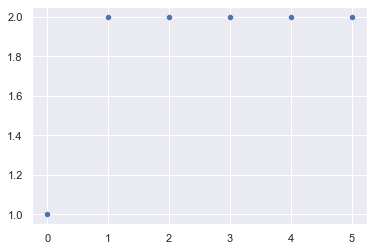

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


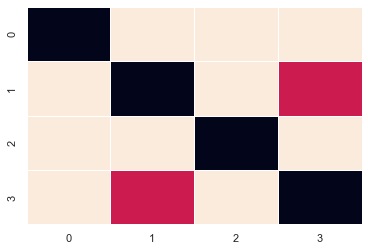

<Figure size 432x288 with 0 Axes>

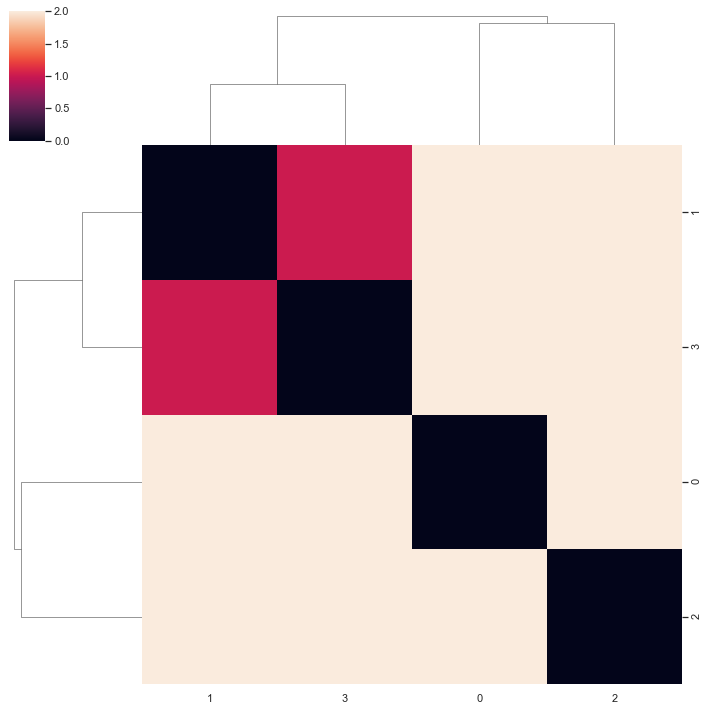

<Figure size 432x288 with 0 Axes>

In [7]:
%time printModel=False
printPartitions=False
annotateHeatMap=False
computeMetrics_handleJVM('test.csv','testB.csv',1.0,printModel,printPartitions,annotateHeatMap,[],2)

# DTMCs

## Bluetooth - bad way too big

## brp

### Varying max

In [ ]:
file_out="brp_varyingMax1.txt"
def experiment_brp():
    models_dir='prismdtmc/brp/varyingMax/'
    #sys.stdout = open(file_out, 'w')
    import os
    i=0
    files = os.listdir(models_dir)
    for f in files:
        if f.endswith('.tra'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            traFile = models_dir+f
            labelsFile = traFile.replace(".tra",".lab")
            %time computeMetrics_handleJVM(traFile,labelsFile,1.0,printModel,printPartitions,False,[],1.0)

run_writeout_to_file(experiment_brp,file_out)

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


In [ ]:
file_out="brp_varyingMax00001.txt"
def experiment_brp2():
    models_dir='prismdtmc/brp/varyingMax/'
    #sys.stdout = open(file_out, 'w')
    import os
    i=0
    files = os.listdir(models_dir)
    for f in files:
        if f.endswith('.tra'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            traFile = models_dir+f
            labelsFile = traFile.replace(".tra",".lab")
            %time computeMetrics_handleJVM(traFile,labelsFile,0.0001,printModel,printPartitions,False,[],1.0)

run_writeout_to_file(experiment_brp2,file_out)

### Old

In [ ]:
file_out="brp_good0.0001.txt"
def experiment_brp():
    models_dir='prismdtmc/brp/good/'
    #sys.stdout = open(file_out, 'w')
    import os
    i=0
    files = os.listdir(models_dir)
    for f in files:
        if f.endswith('.tra'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            traFile = models_dir+f
            labelsFile = traFile.replace(".tra",".lab")
            %time computeMetrics_handleJVM(traFile,labelsFile,0.0001,printModel,printPartitions,False,[])

run_writeout_to_file(experiment_brp,file_out)

Py4JJavaError: An error occurred while calling t.importPRISMDTMC.
: java.lang.NullPointerException
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.populateAuxiliarySpeciesDataStructures(EntryPointPythonMetrics.java:123)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.completeImporting(EntryPointPythonMetrics.java:138)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.importPRISMDTMC(EntryPointPythonMetrics.java:205)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:2

done


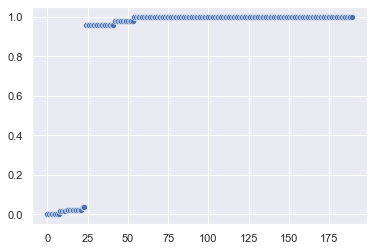

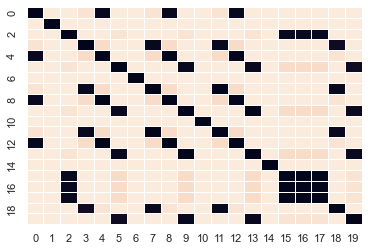

<Figure size 432x288 with 0 Axes>

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


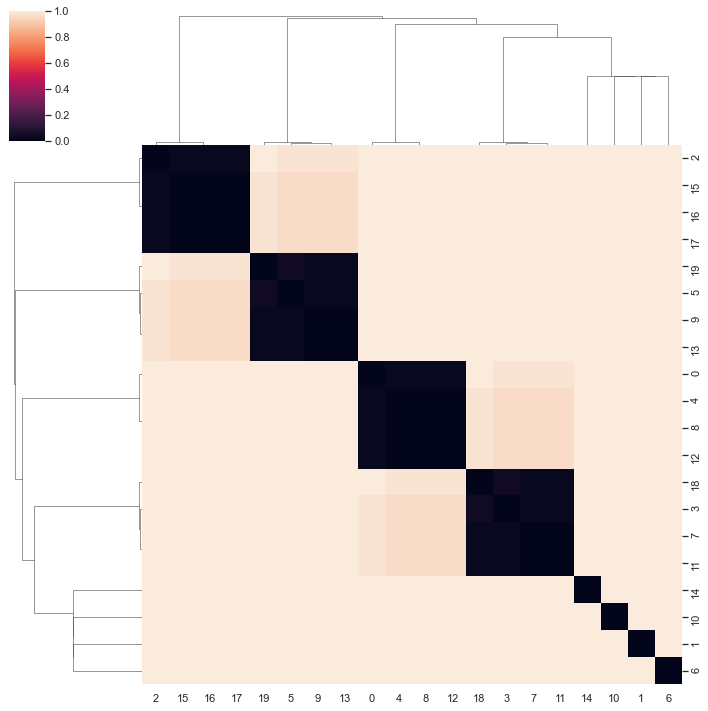

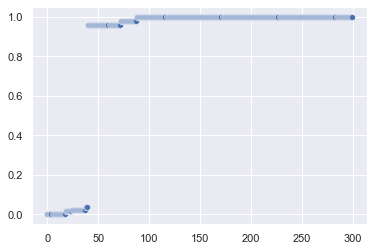

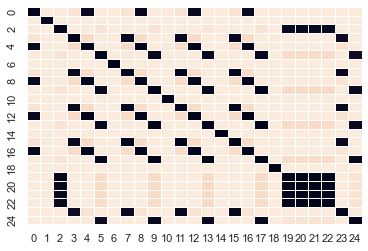

<Figure size 432x288 with 0 Axes>

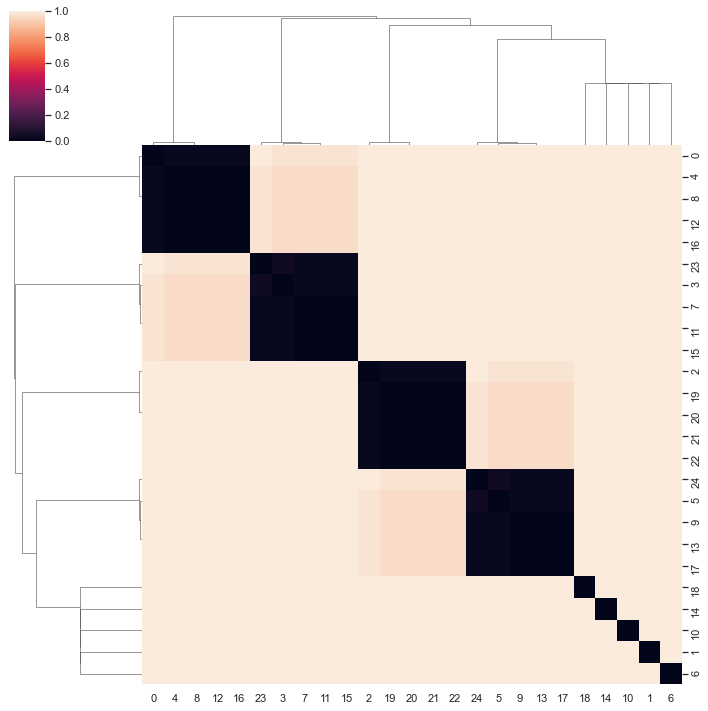

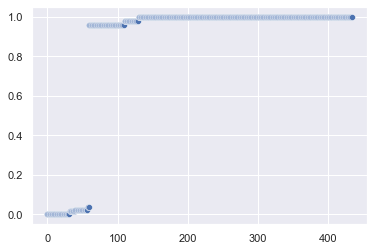

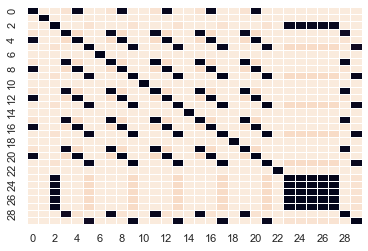

<Figure size 432x288 with 0 Axes>

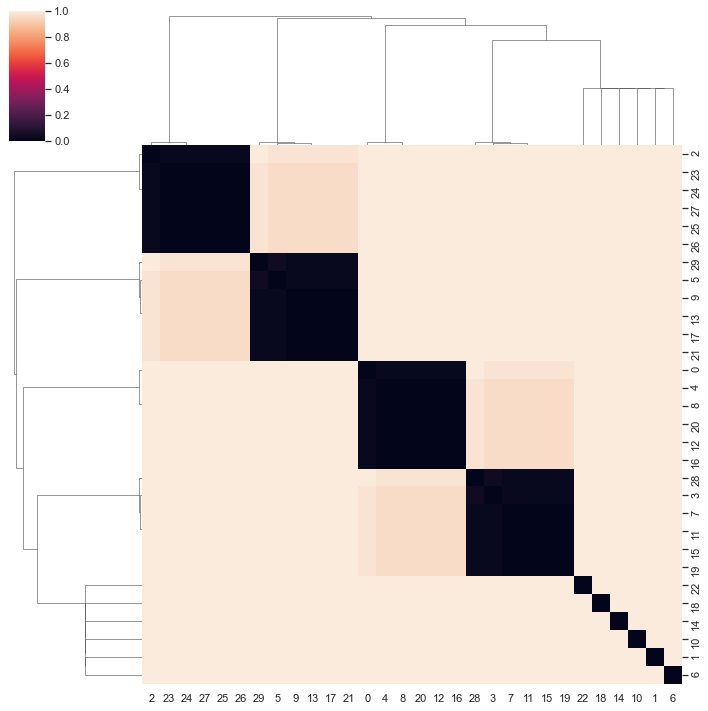

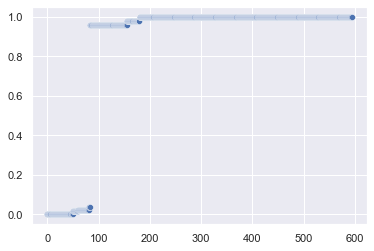

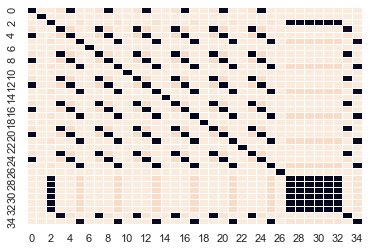

<Figure size 432x288 with 0 Axes>

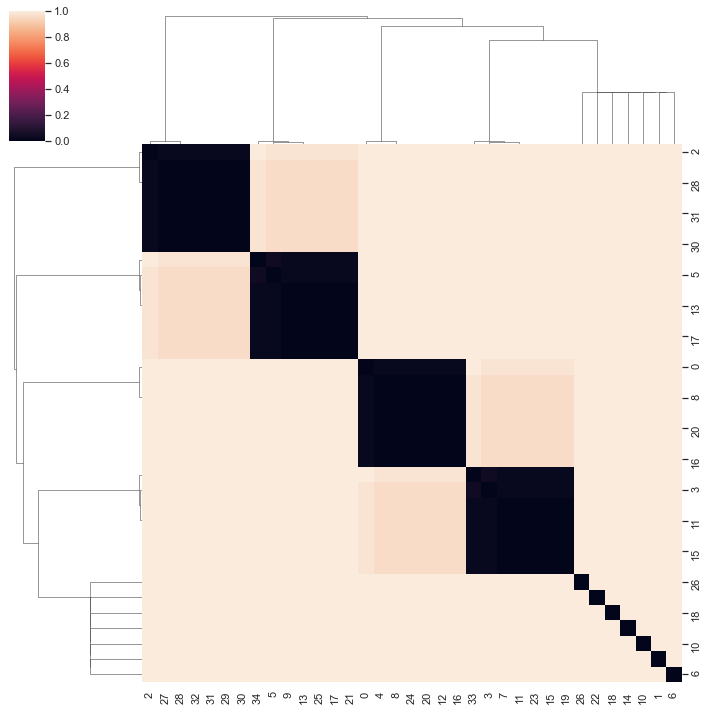

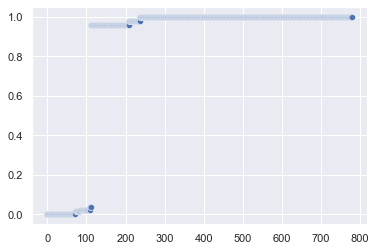

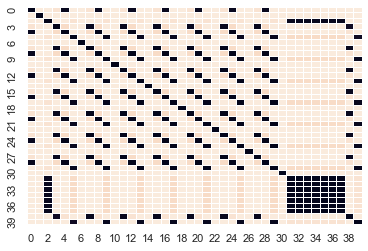

<Figure size 432x288 with 0 Axes>

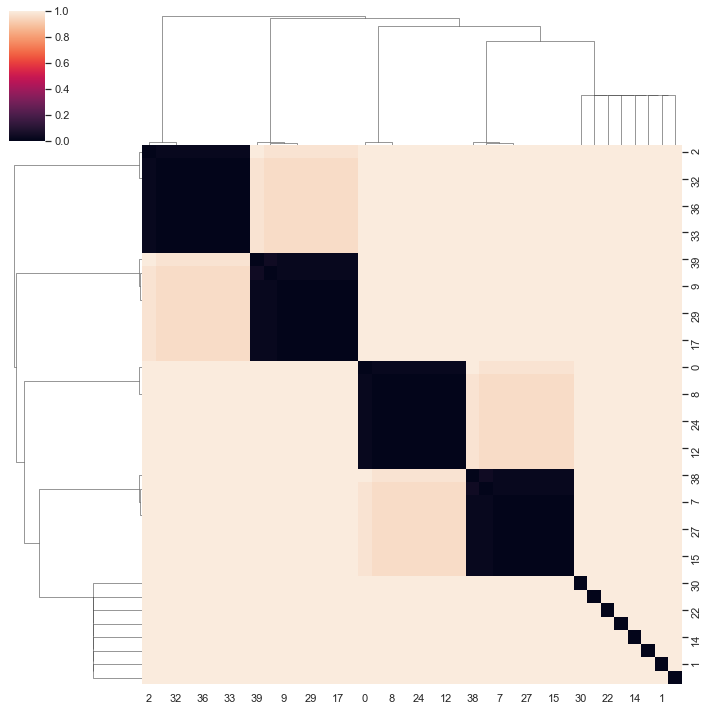

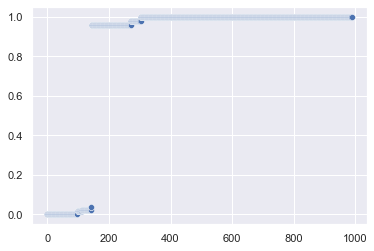

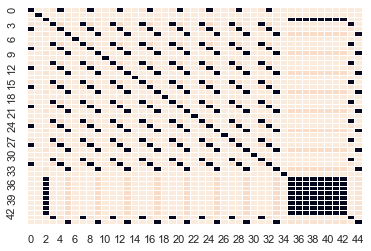

<Figure size 432x288 with 0 Axes>

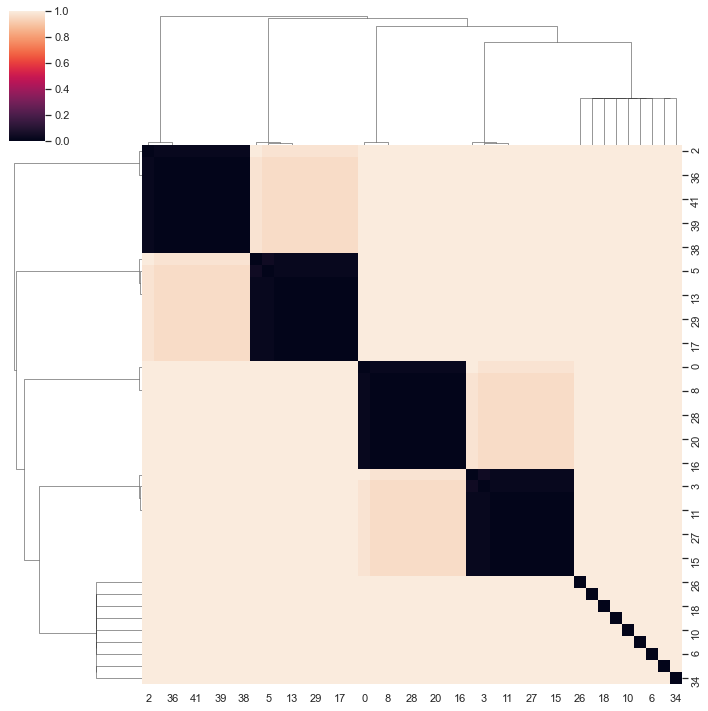

<Figure size 432x288 with 0 Axes>

In [38]:
#Store the original function for 'print()'
import sys
ipython_output = sys.stdout

#Store the original function for 'input()'
#from ipykernel.ipkernel import IPythonKernel
#ipython_input = IPythonKernel._input_request
try:
    file_out="brp.txt"
    sys.stdout = open(file_out, 'w')
    for M in range(1,8):
        name='prismdtmc/brp/brpN1.MAX'+str(M)
        %time computeMetrics_handleJVM(name+'.tra',name+'.lab',1.0,printModel,printPartitions,False,[])
finally:
    #Restore the correct input() and print()
    #IPythonKernel._input_request = ipython_input
    sys.stdout = ipython_output
    print('done')

Starting the JVM and ERODE
  Completed
Loading the model in ERODE prismdtmc/brp/brpN2.MAX1.tra
Computing the BB partition
We obtained 62 blocks out of 62 variables
Computing the metrics
INTERESTING VALUE in (0,1.0)!!!!!!!!

We have trimmed values larger than 1.0 to 1.0
The values of the metrics, sorted
[0.0, 0.0002, 0.00039, 0.0004, 0.0008, 0.00099, 0.0098, 0.01, 0.0102, 0.01059, 0.0193, 0.0196, 0.0197, 0.0198, 0.01989, 0.0199, 0.01999, 0.02, 0.02009, 0.0201, 0.02019, 0.02039, 0.0204, 0.02078, 0.02941, 0.0295, 0.0392, 0.0396, 0.03979, 0.03999, 0.04, 0.04018, 0.04019, 0.0487, 0.0497, 0.05919, 0.0592, 0.96, 0.9602, 0.96039, 0.9604, 0.9608, 0.96099, 0.96119, 0.96158, 0.9796, 0.9798, 0.97989, 0.9799, 0.97999, 0.98, 0.98001, 0.98002, 0.98009, 0.9801, 0.98019, 0.9802, 0.98039, 0.9804, 0.98041, 0.98059, 0.9806, 0.98077, 0.98078, 0.98079, 0.9808, 0.98115, 0.98961, 0.9898, 0.98981, 0.9899, 0.98999, 0.99, 0.9901, 0.99019, 0.9902, 0.99038, 0.99039, 0.9905, 0.99079, 0.9992, 0.99921, 0.99922, 0.999

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE
 Completed
CPU times: user 2.27 s, sys: 1.01 s, total: 3.28 s
Wall time: 24min 45s


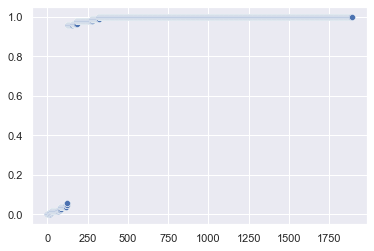

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


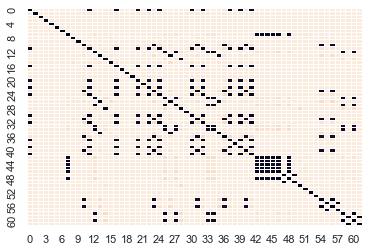

<Figure size 432x288 with 0 Axes>

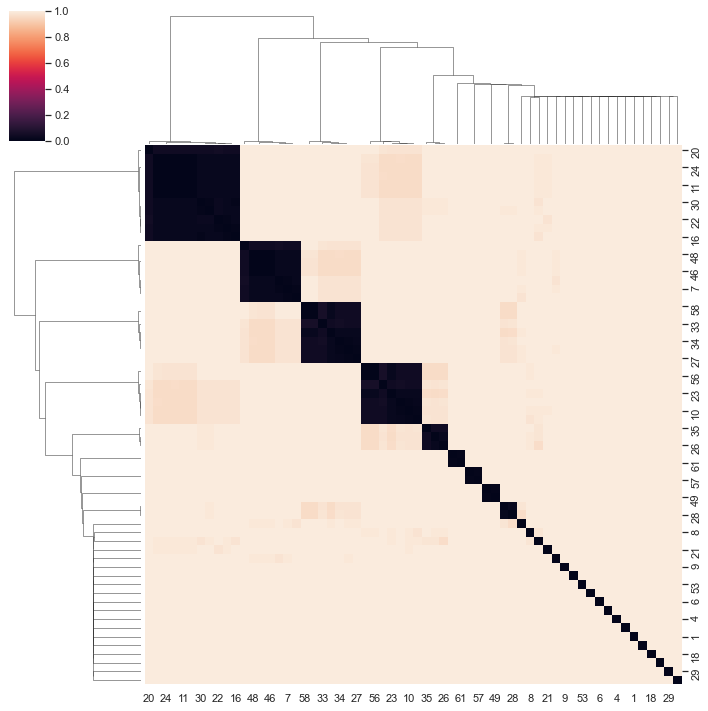

<Figure size 432x288 with 0 Axes>

In [32]:
%time computeMetrics_handleJVM('prismdtmc/brp/brpN2.MAX1.tra','prismdtmc/brp/brpN2.MAX1.lab',1.0,printModel,printPartitions,False,[])

Starting the JVM and ERODE
  Completed
Loading the model in ERODE prismdtmc/brp/brpN1.MAX2.tra
Computing the BB partition
We obtained 20 blocks out of 20 variables
Computing the metrics
INTERESTING VALUE in (0,1.0)!!!!!!!!

We have trimmed values larger than 1.0 to 1.0
The values of the metrics, sorted
[0.0, 1e-05, 0.00039, 0.0004, 0.0196, 0.02, 0.02001, 0.02039, 0.0396, 0.96, 0.96001, 0.9604, 0.98, 0.98001, 0.9804, 1.0]


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE
 Completed
CPU times: user 953 ms, sys: 874 ms, total: 1.83 s
Wall time: 11.5 s


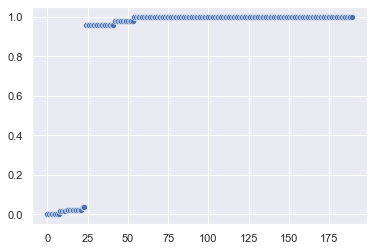

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


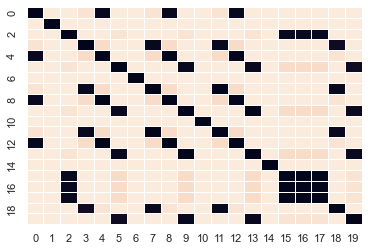

<Figure size 432x288 with 0 Axes>

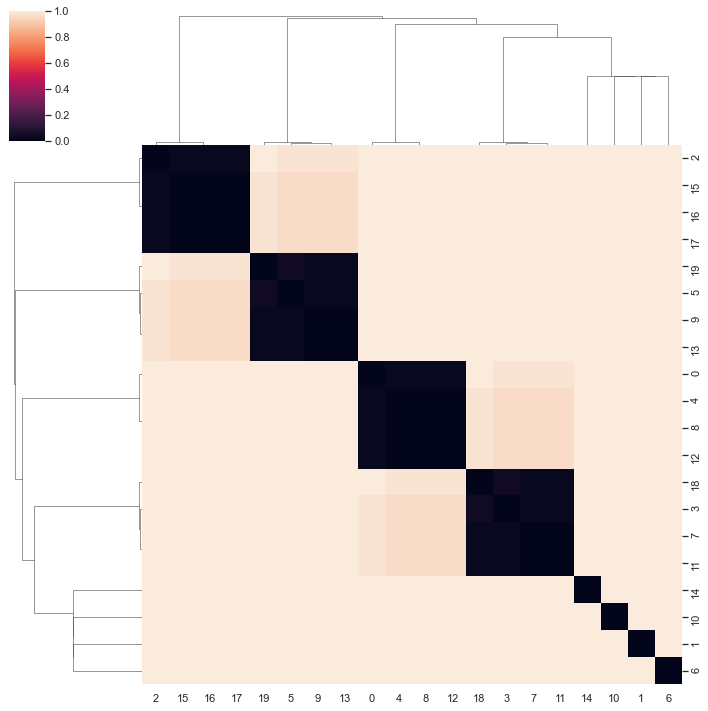

<Figure size 432x288 with 0 Axes>

In [31]:
%time computeMetrics_handleJVM('prismdtmc/brp/brpN1.MAX2.tra','prismdtmc/brp/brpN1.MAX2.lab',1.0,printModel,printPartitions,False,[])

## COUPON - do not have prism files

## CROWDS - BAD

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:62

done


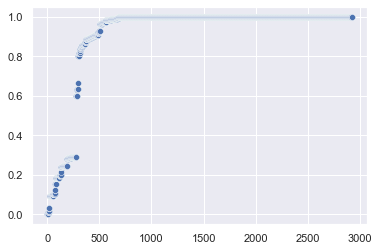

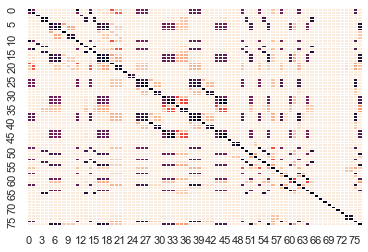

<Figure size 432x288 with 0 Axes>

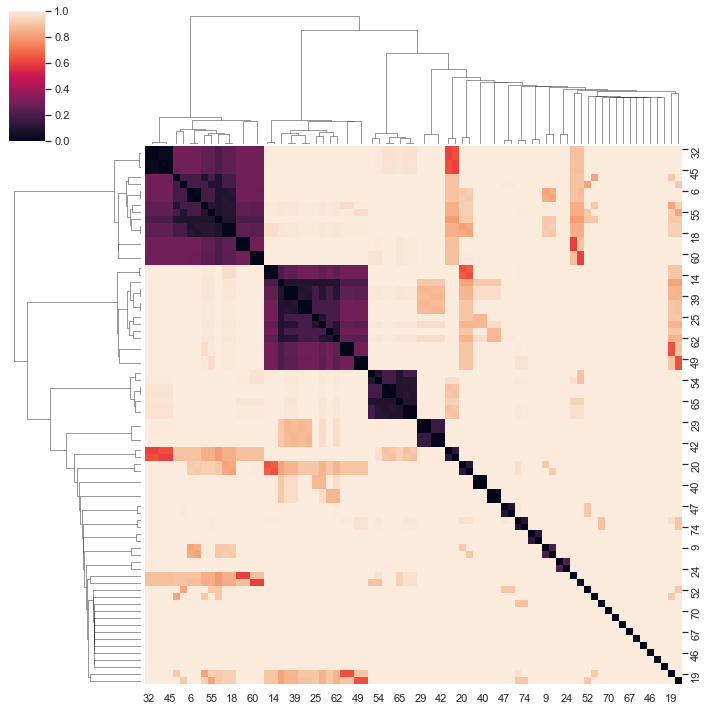

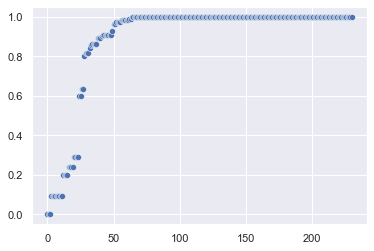

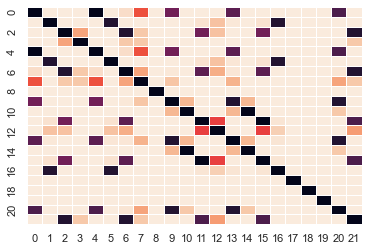

<Figure size 432x288 with 0 Axes>

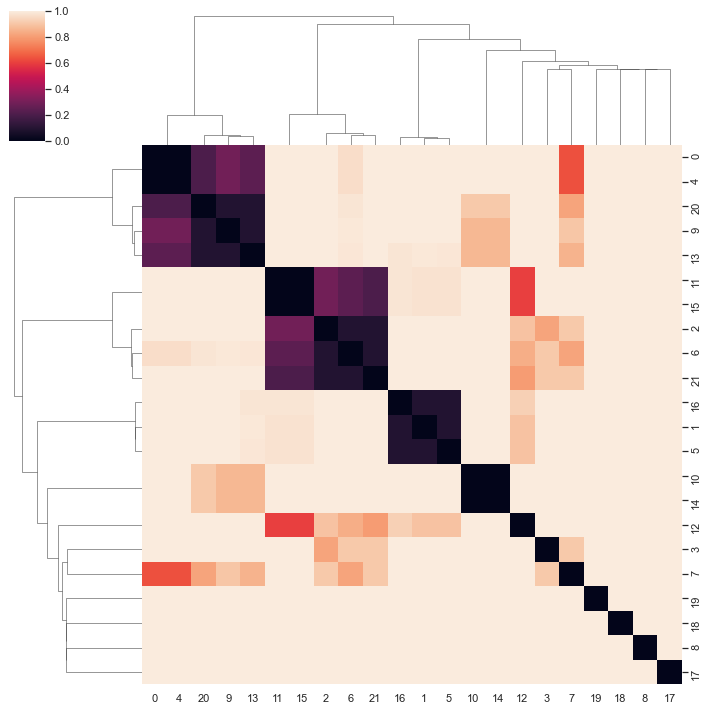

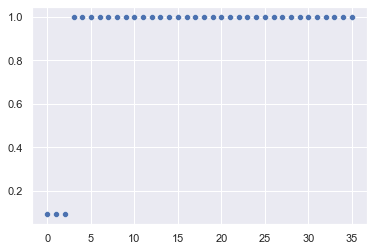

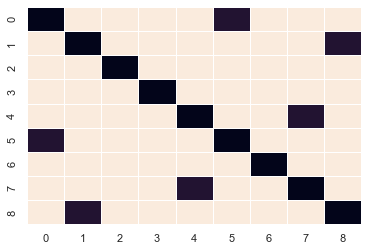

<Figure size 432x288 with 0 Axes>

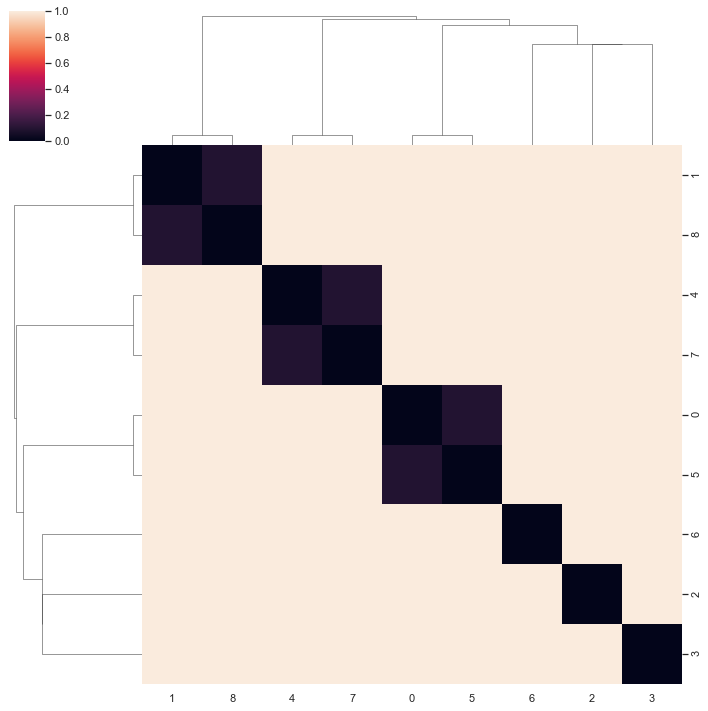

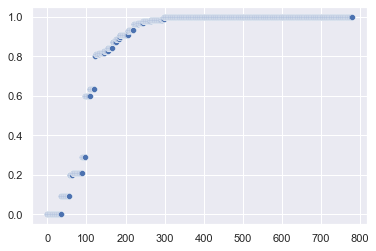

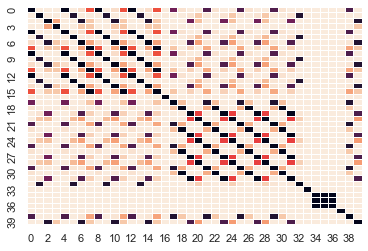

<Figure size 432x288 with 0 Axes>

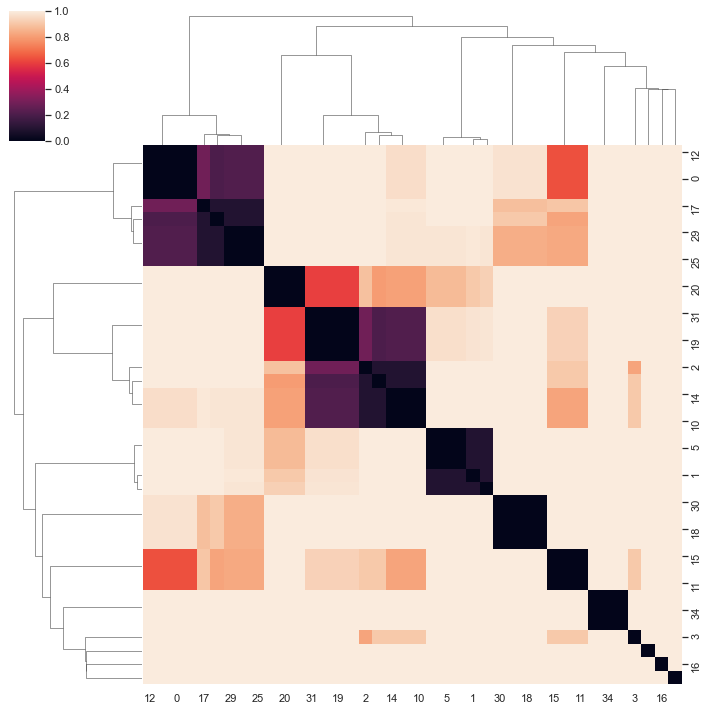

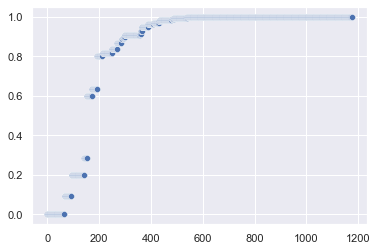

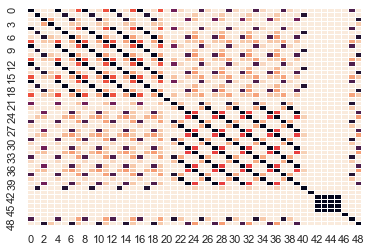

<Figure size 432x288 with 0 Axes>

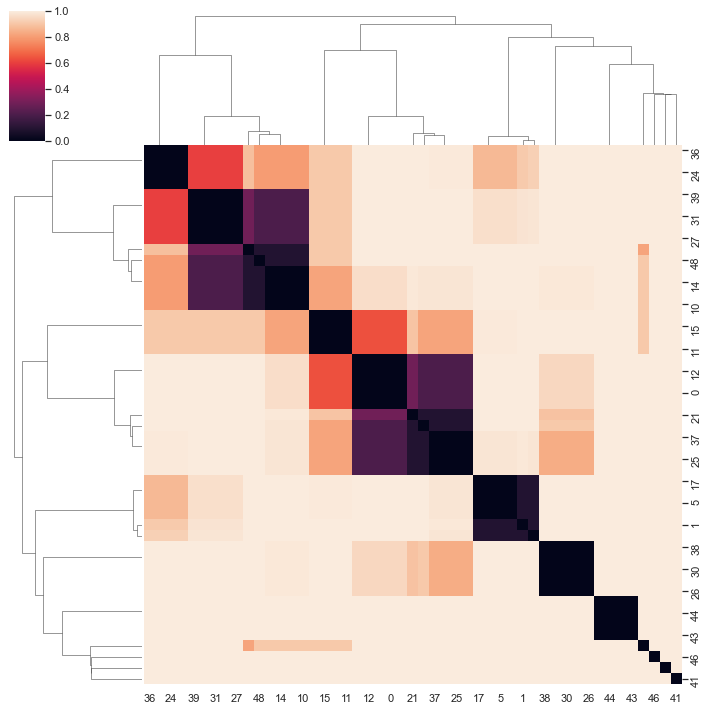

<Figure size 432x288 with 0 Axes>

In [5]:
import sys
ipython_output = sys.stdout

#Store the original function for 'input()'
#from ipykernel.ipkernel import IPythonKernel
#ipython_input = IPythonKernel._input_request
try:
    models_dir='prismdtmc/crowds/'
    file_out="crowds.txt"
    sys.stdout = open(file_out, 'w')
    import os
    i=0
    files = os.listdir(models_dir)
    for f in files:
        if f.endswith('.tra'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            traFile = models_dir+f
            labelsFile = traFile.replace(".tra",".lab")
            %time computeMetrics_handleJVM(traFile,labelsFile,1.0,printModel,printPartitions,False,[])
finally:
    #Restore the correct input() and print()
    #IPythonKernel._input_request = ipython_input
    sys.stdout = ipython_output
    print('done')

## egl - BAD


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


done


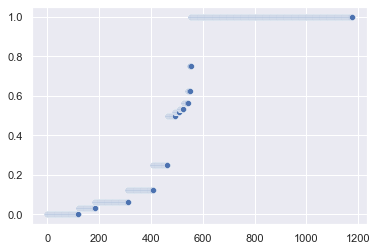

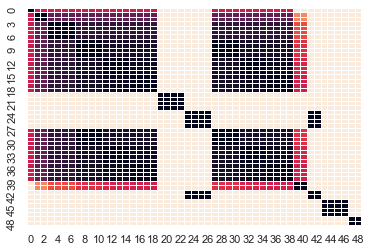

<Figure size 432x288 with 0 Axes>

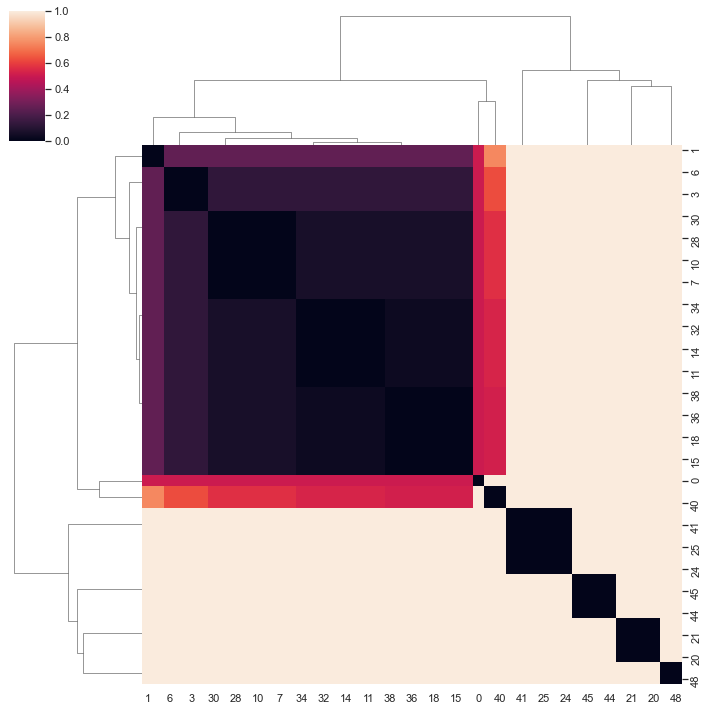

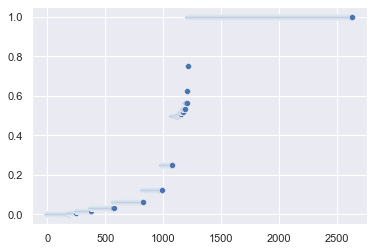

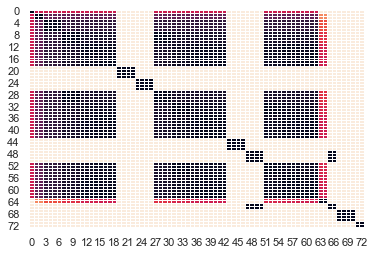

<Figure size 432x288 with 0 Axes>

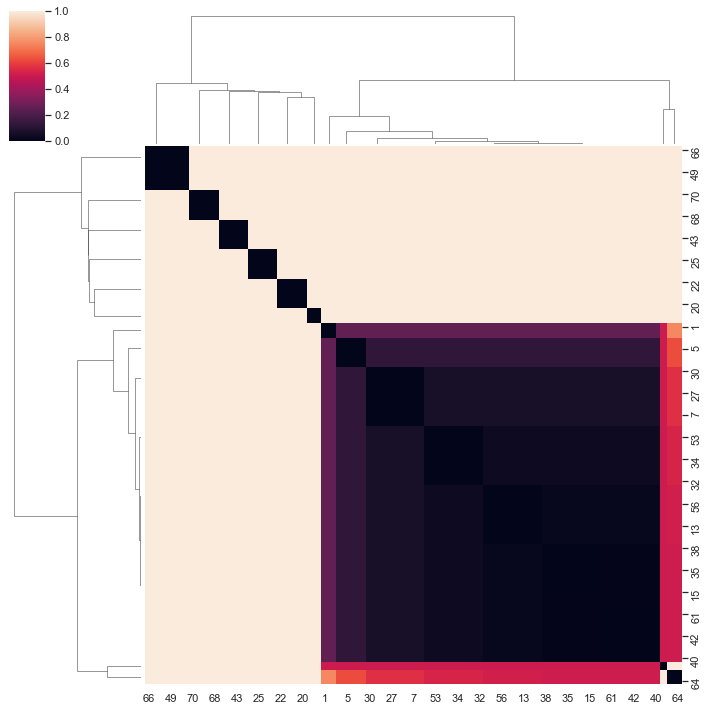

<Figure size 432x288 with 0 Axes>

In [6]:
import sys
ipython_output = sys.stdout

#Store the original function for 'input()'
#from ipykernel.ipkernel import IPythonKernel
#ipython_input = IPythonKernel._input_request
try:
    models_dir='prismdtmc/egl/'
    file_out="egl.txt"
    sys.stdout = open(file_out, 'w')
    import os
    i=0
    files = os.listdir(models_dir)
    for f in files:
        if f.endswith('.tra'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            traFile = models_dir+f
            labelsFile = traFile.replace(".tra",".lab")
            %time computeMetrics_handleJVM(traFile,labelsFile,1.0,printModel,printPartitions,False,[])
finally:
    #Restore the correct input() and print()
    #IPythonKernel._input_request = ipython_input
    sys.stdout = ipython_output
    print('done')

## haddad-monmege - VERY GOOD!

### p=0.6, varying N

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/si

done


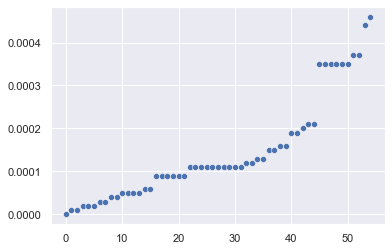

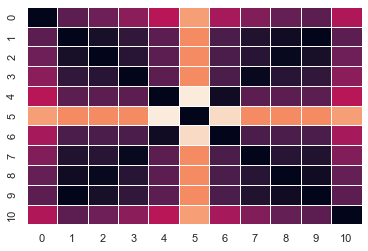

<Figure size 432x288 with 0 Axes>

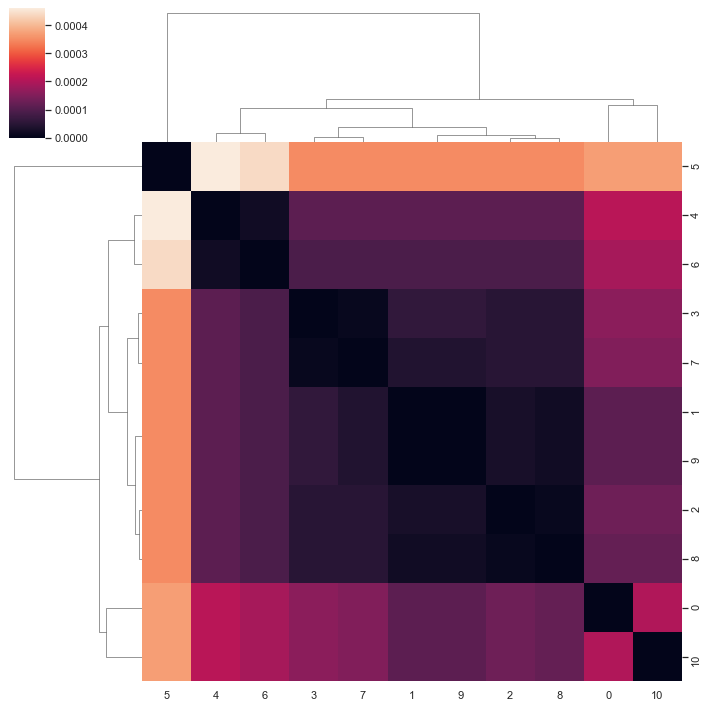

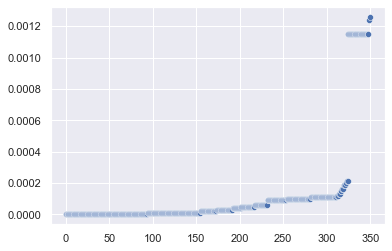

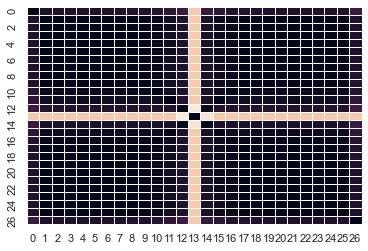

<Figure size 432x288 with 0 Axes>

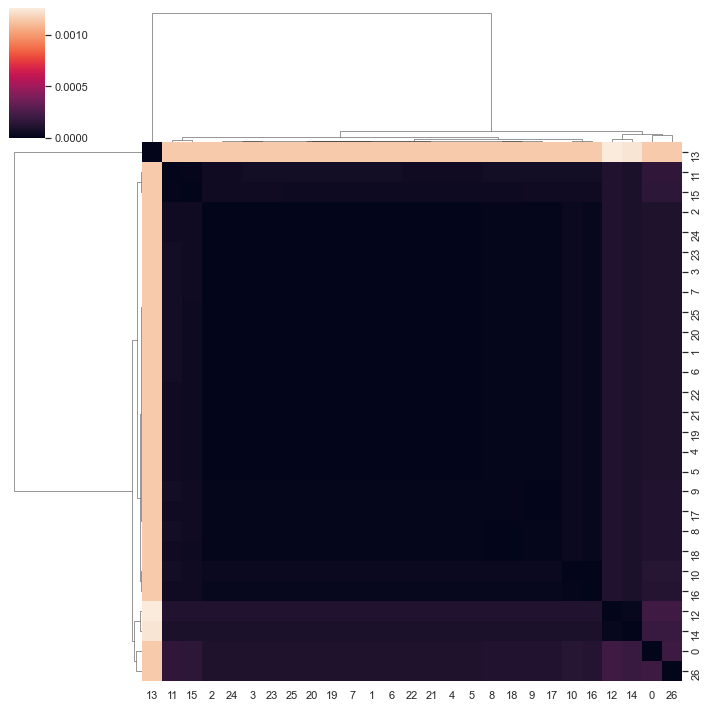

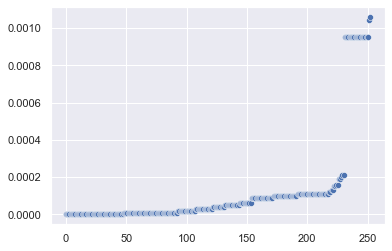

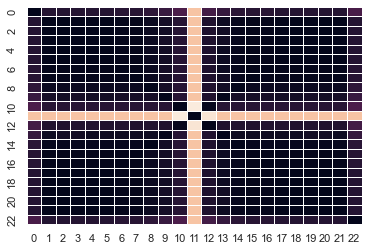

<Figure size 432x288 with 0 Axes>

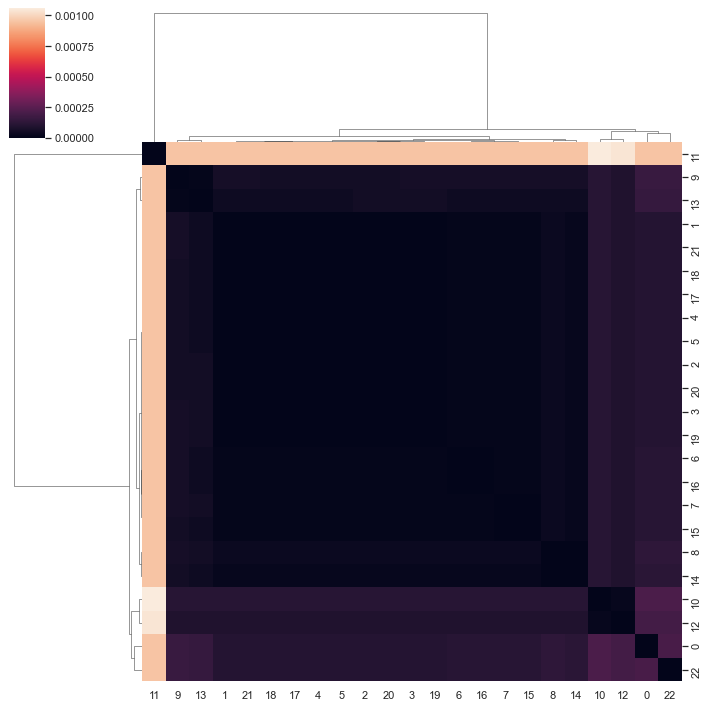

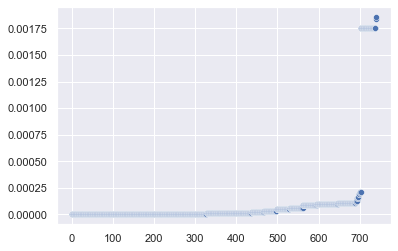

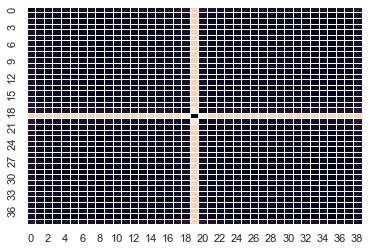

<Figure size 432x288 with 0 Axes>

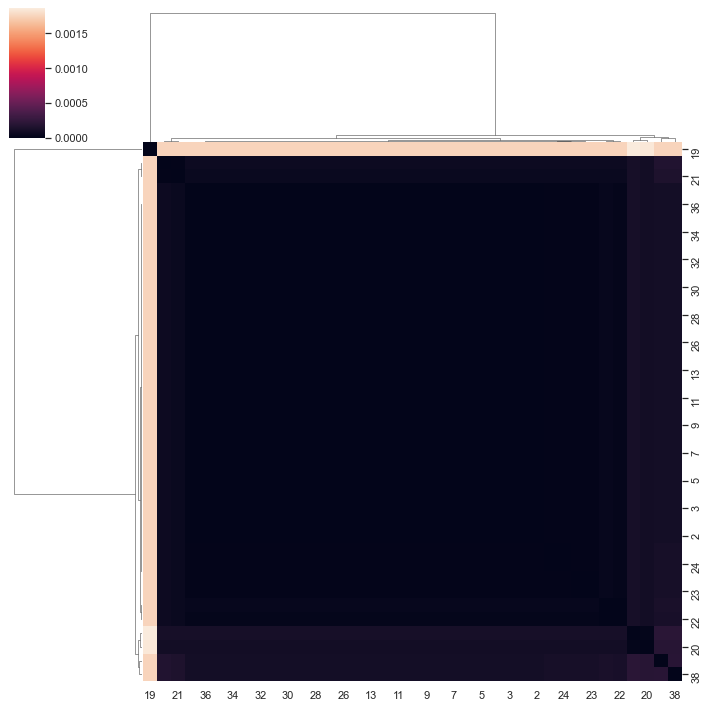

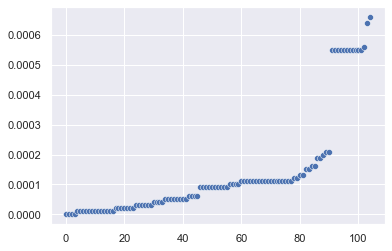

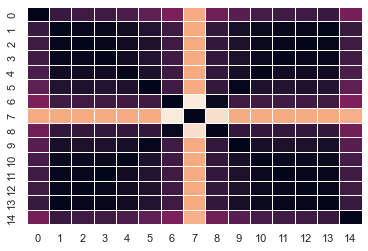

<Figure size 432x288 with 0 Axes>

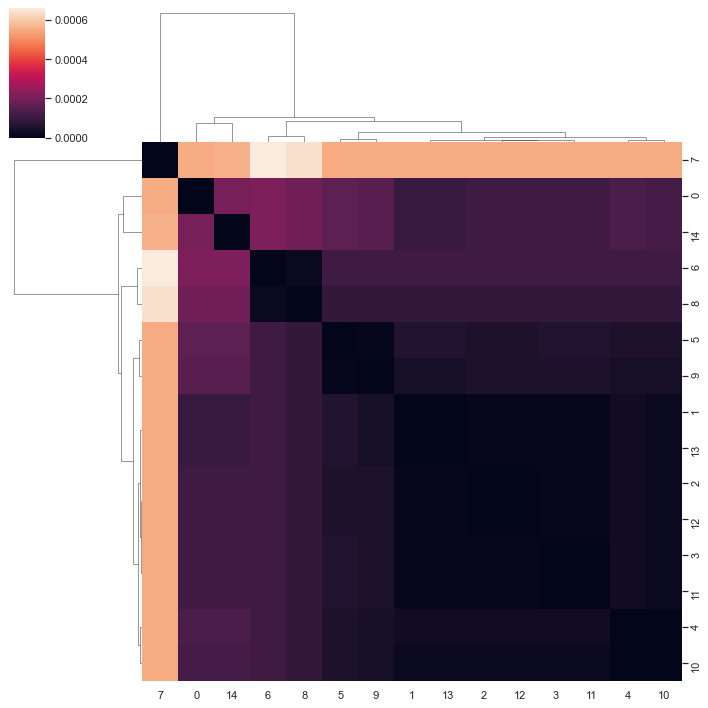

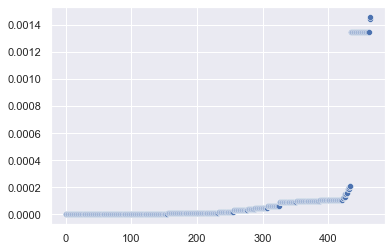

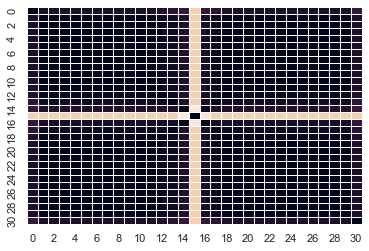

<Figure size 432x288 with 0 Axes>

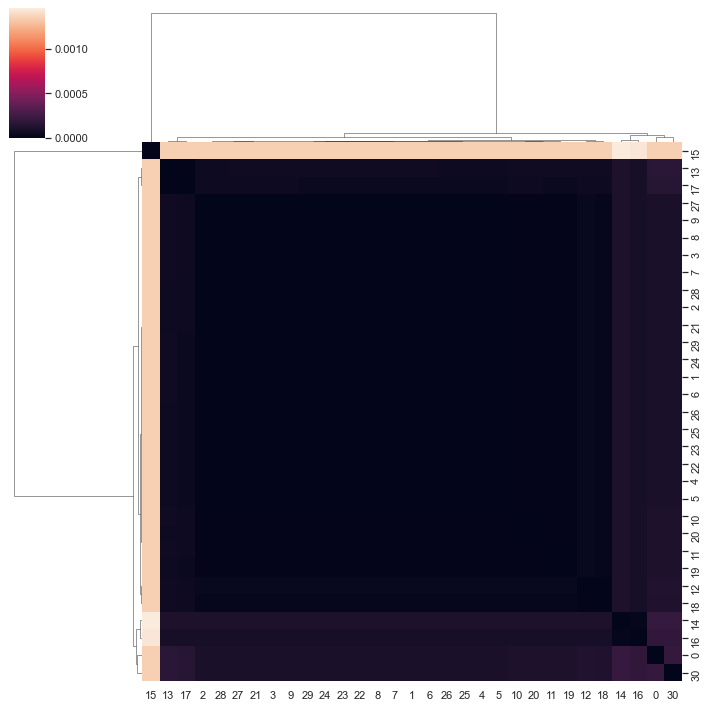

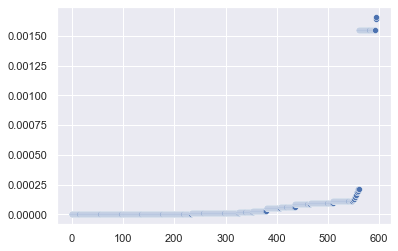

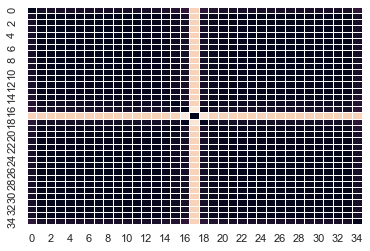

<Figure size 432x288 with 0 Axes>

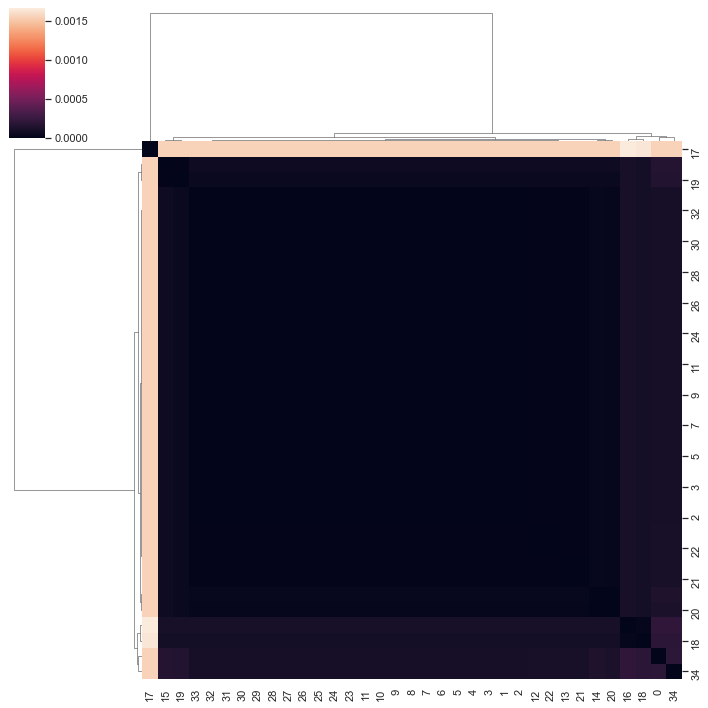

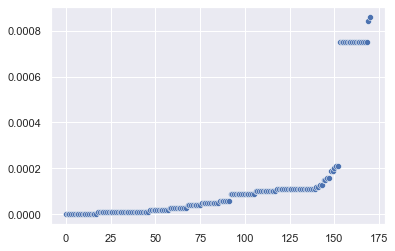

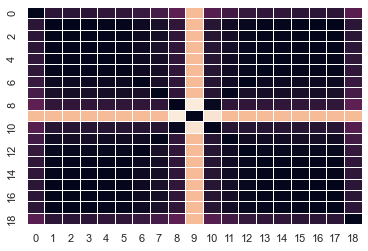

<Figure size 432x288 with 0 Axes>

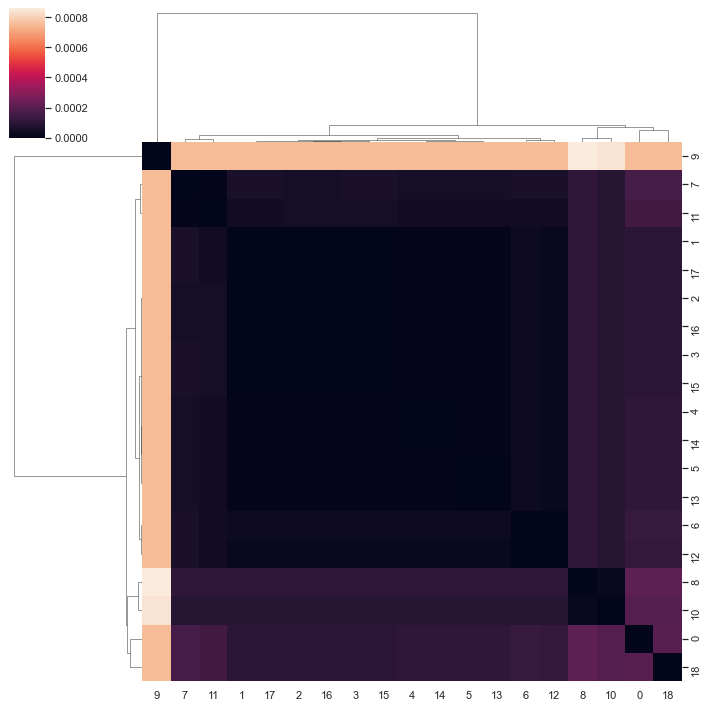

<Figure size 432x288 with 0 Axes>

In [8]:
file_out="haddad-monmege.v1_expp06_0.0001.txt"
def experiment_p06():
    models_dir='prismdtmc/haddad-monmege.v1/'
    #sys.stdout = open(file_out, 'w')
    import os
    i=0
    files = os.listdir(models_dir)
    for f in files:
        if f.endswith('.tra'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            traFile = models_dir+f
            labelsFile = traFile.replace(".tra",".lab")
            %time computeMetrics_handleJVM(traFile,labelsFile,0.0001,printModel,printPartitions,False,[],1)

run_writeout_to_file(experiment_p06,file_out)

### N=17, varying p

/var/folders/3l/tn1dgncs4wj02y9fdy1nr4380000gn/T/ipykernel_35715/1941292705.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


done


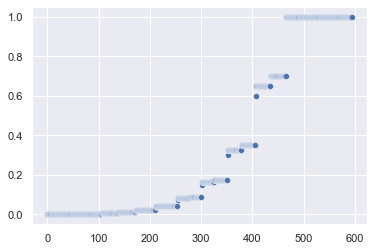

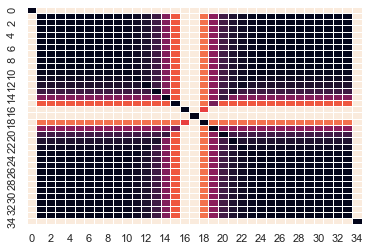

<Figure size 432x288 with 0 Axes>

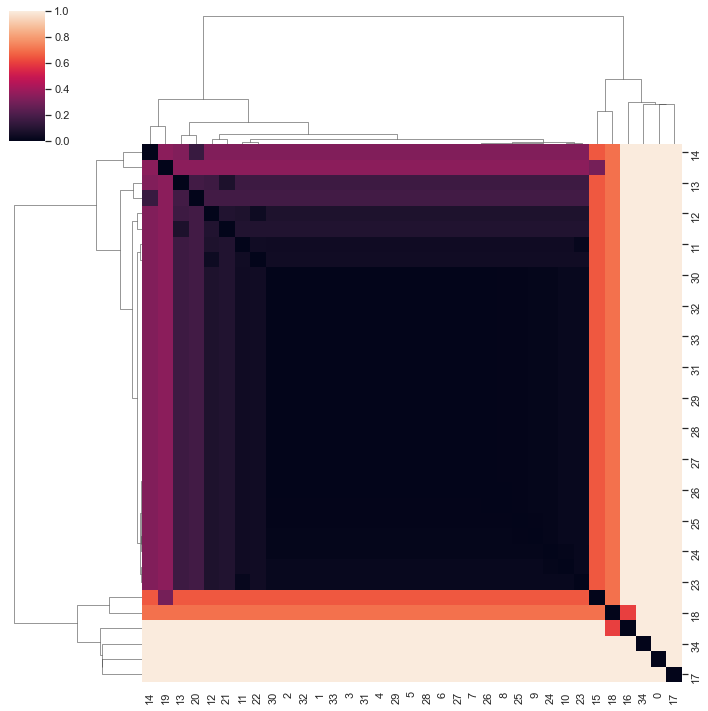

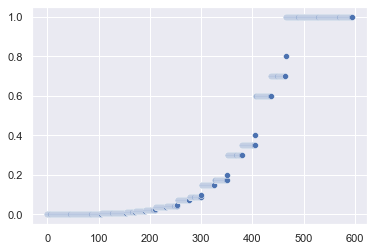

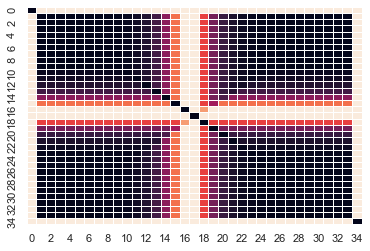

<Figure size 432x288 with 0 Axes>

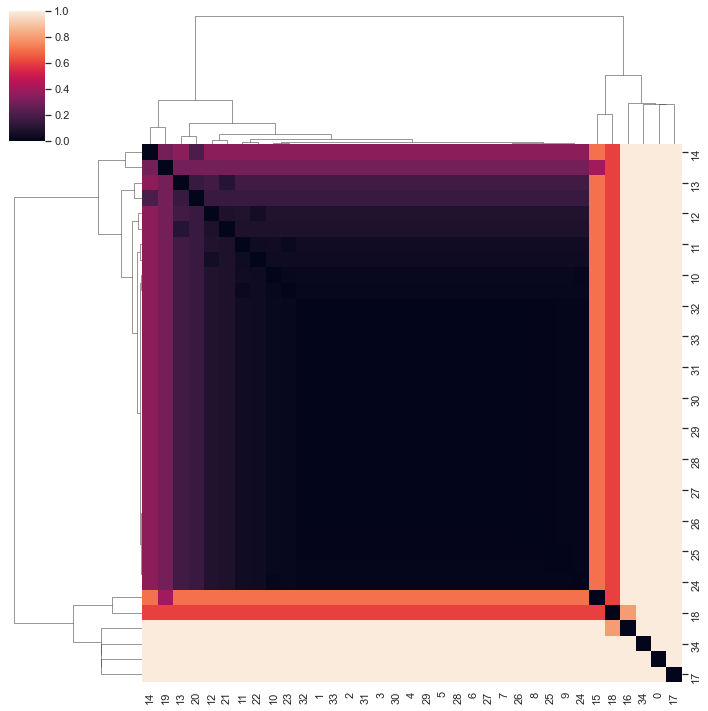

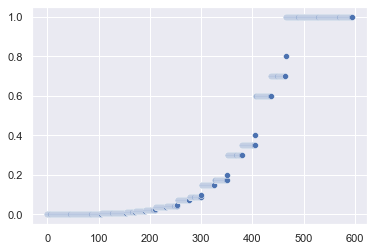

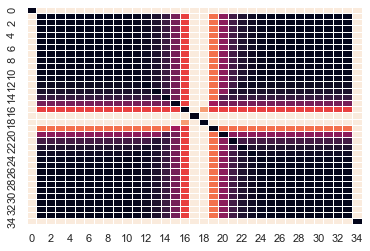

<Figure size 432x288 with 0 Axes>

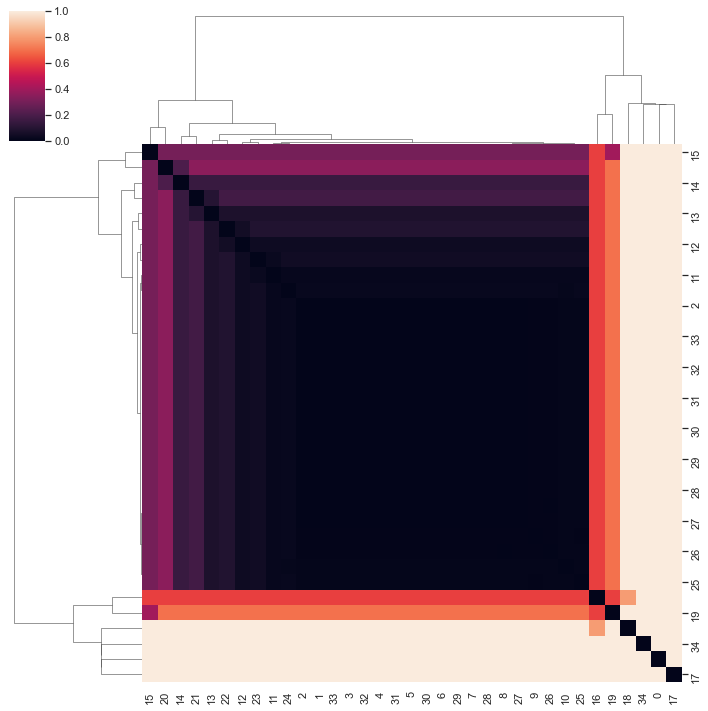

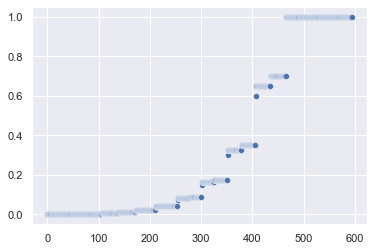

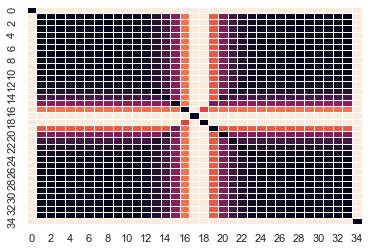

<Figure size 432x288 with 0 Axes>

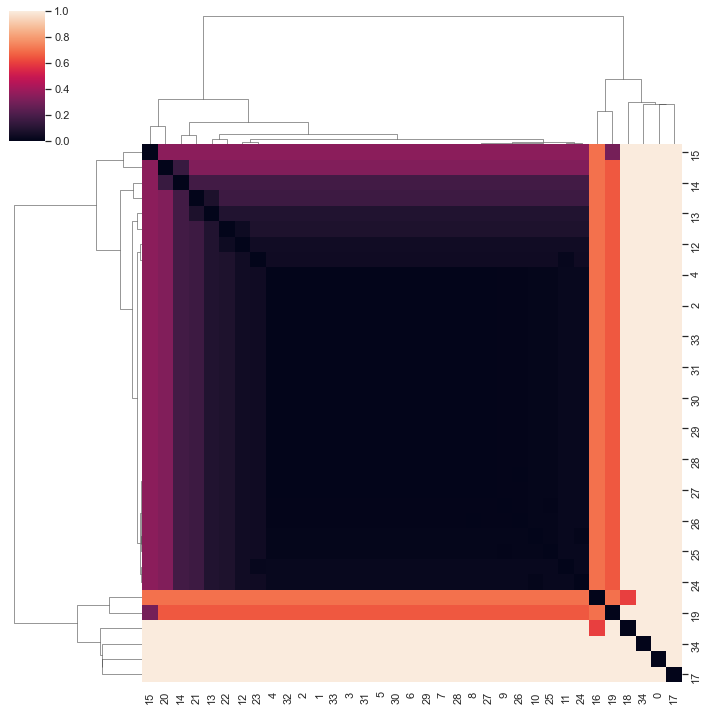

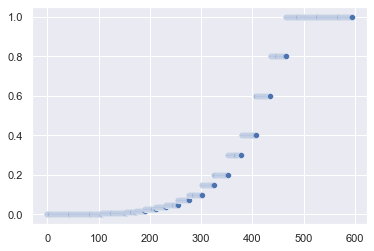

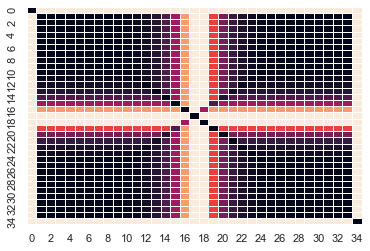

<Figure size 432x288 with 0 Axes>

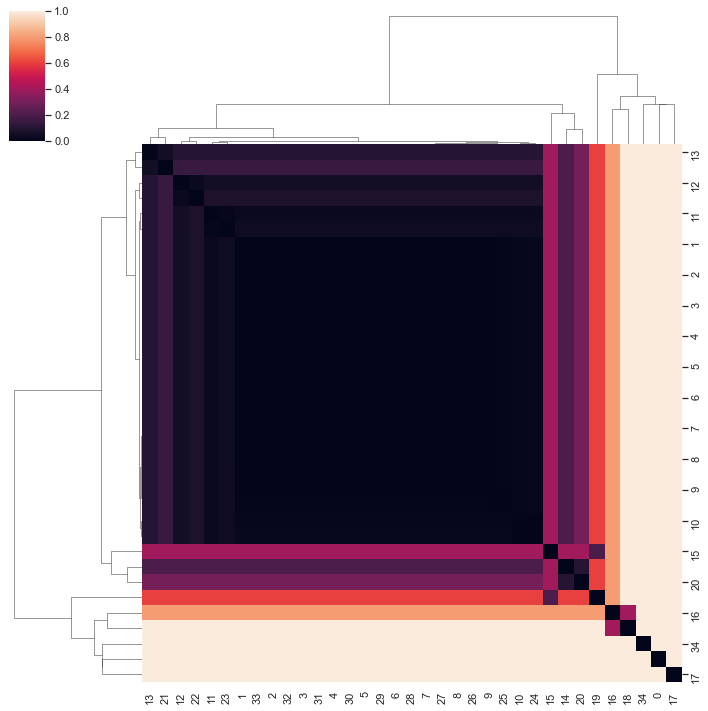

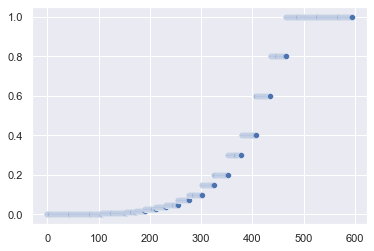

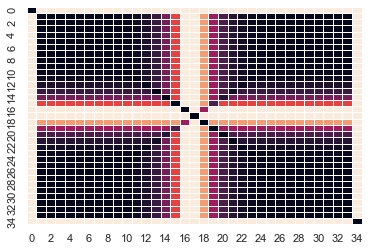

<Figure size 432x288 with 0 Axes>

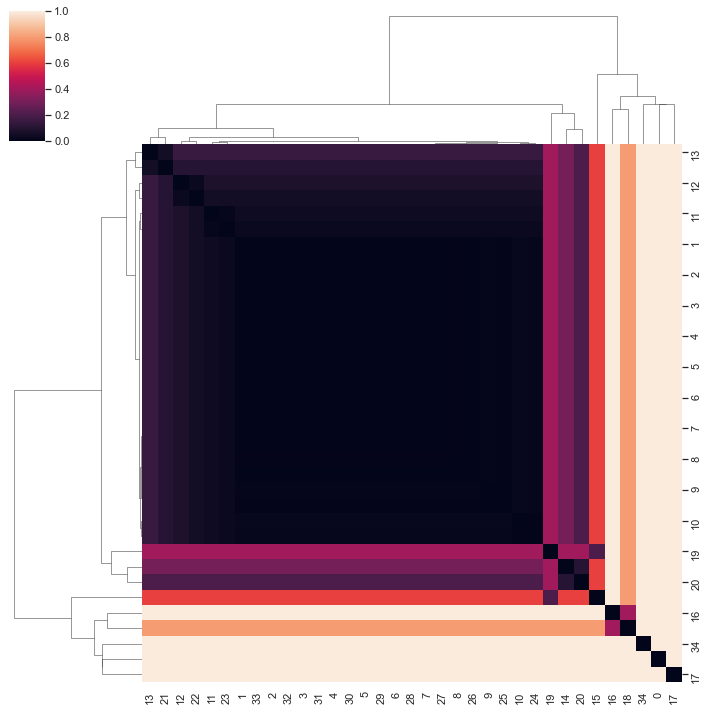

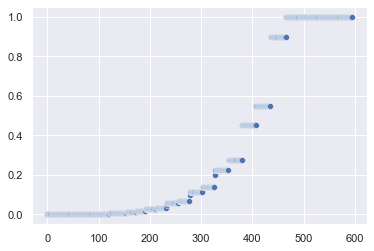

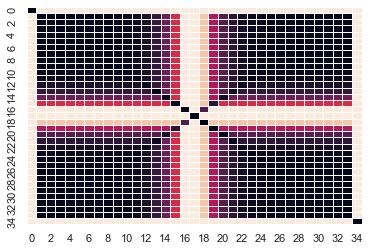

<Figure size 432x288 with 0 Axes>

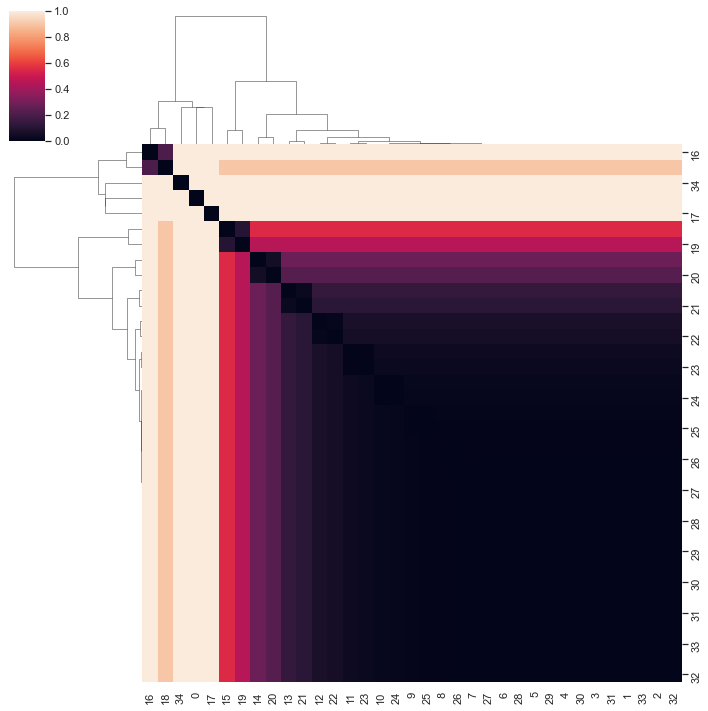

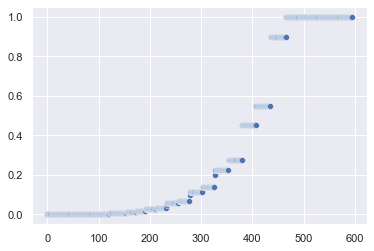

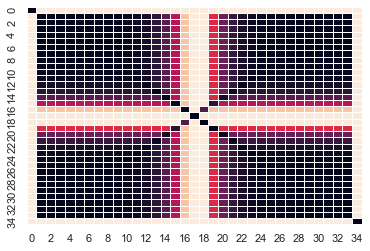

<Figure size 432x288 with 0 Axes>

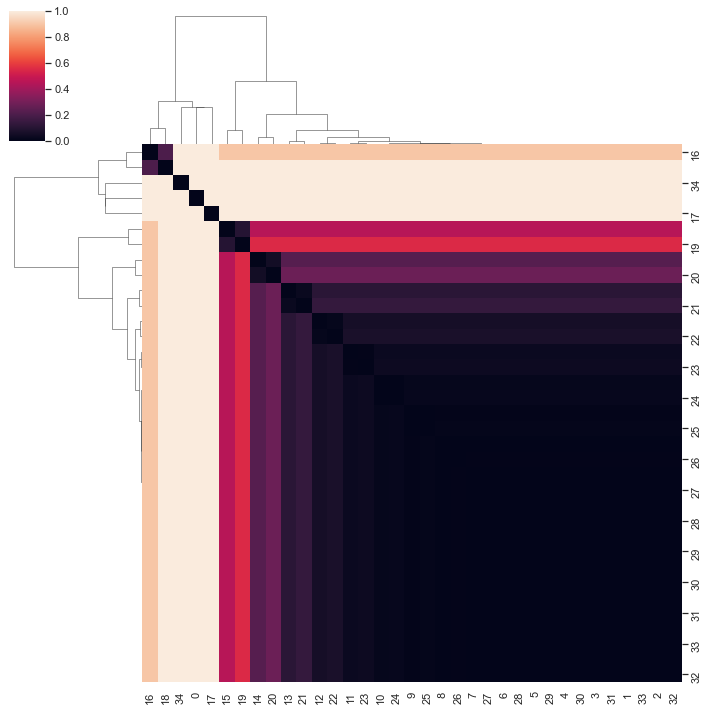

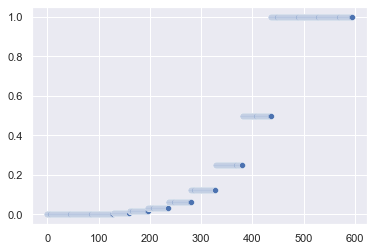

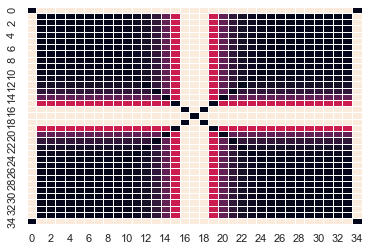

<Figure size 432x288 with 0 Axes>

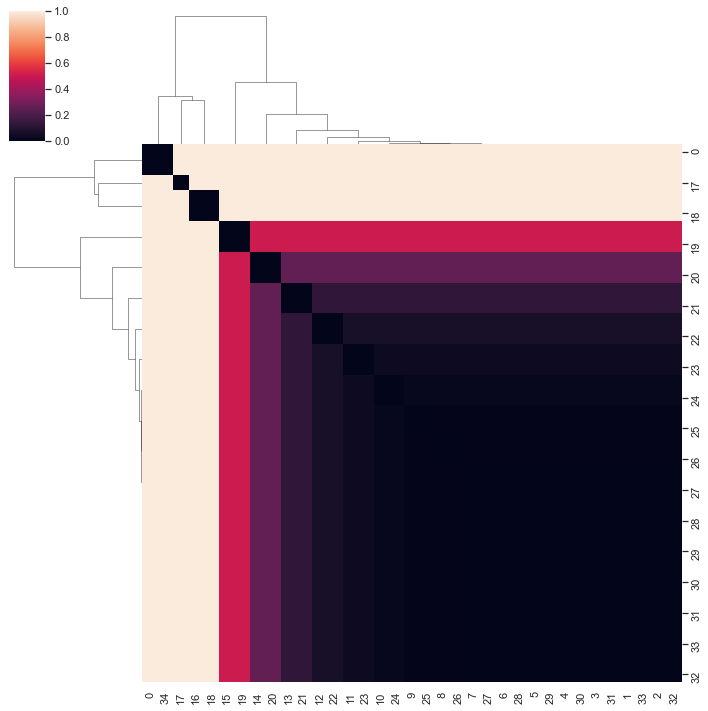

<Figure size 432x288 with 0 Axes>

In [18]:
def experiment_n17():
    models_dir='prismdtmc/haddad-monmege.v1/comparisonN17/'
    file_out="haddad-monmege.v1_expn17.txt"
    #sys.stdout = open(file_out, 'w')
    import os
    i=0
    files = os.listdir(models_dir)
    for f in files:
        if f.endswith('.tra'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            traFile = models_dir+f
            labelsFile = traFile.replace(".tra",".lab")
            %time computeMetrics_handleJVM(traFile,labelsFile,1.0,printModel,printPartitions,False,[])

run_writeout_to_file(experiment_n17)

In [9]:
# models_dir='prismdtmc/haddad-monmege.v1/'
# traFile=models_dir+'haddad-monmege.v1n{5}p0.6.tra'
# labelsFile=models_dir+'haddad-monmege.v1nn{7}p0.6.lab'
# %time computeMetrics_handleJVM(traFile,labelsFile,1.0,printModel,printPartitions,False,[])

Starting the JVM and ERODE
  Completed
Loading the model in ERODE prismdtmc/haddad-monmege.v1n5p0.6.tra
Computing the BB partition
We obtained 11 blocks out of 11 variables
Computing the metrics
INTERESTING VALUE in (0,1.0)!!!!!!!!

We have trimmed values larger than 1.0 to 1.0
The values of the metrics, sorted
[0.0, 0.025, 0.05, 0.1, 0.2, 0.225, 0.275, 0.45, 0.55, 0.9, 1.0]


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE
 Completed
CPU times: user 633 ms, sys: 548 ms, total: 1.18 s
Wall time: 7.46 s


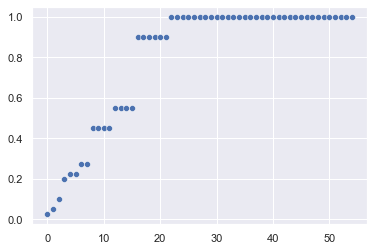

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


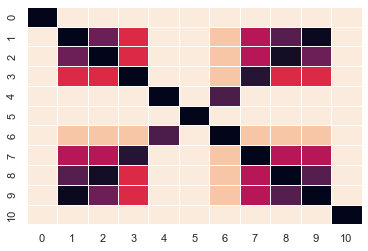

<Figure size 432x288 with 0 Axes>

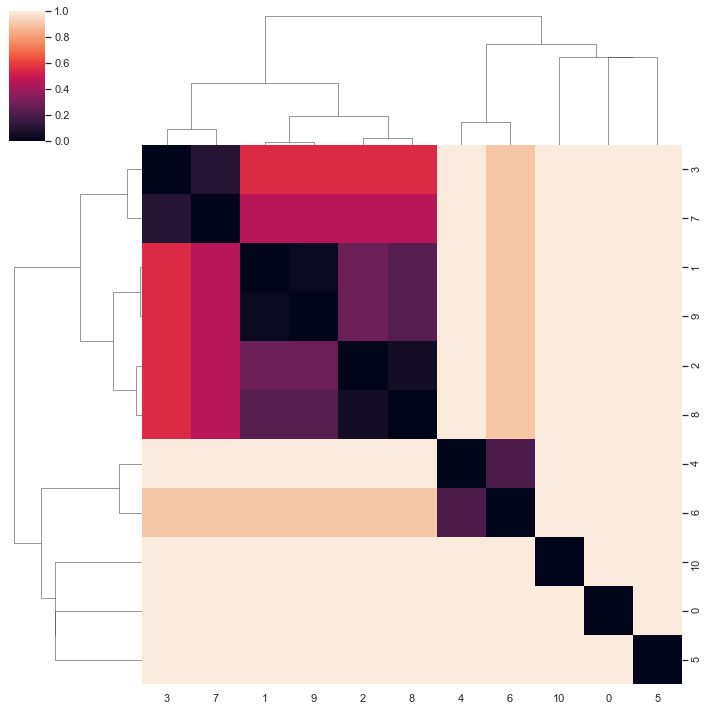

<Figure size 432x288 with 0 Axes>

In [33]:
%time computeMetrics_handleJVM('prismdtmc/haddad-monmege.v1n5p0.6.tra','prismdtmc/haddad-monmege.v1nn5p0.6.lab',1.0,printModel,printPartitions,False,[])


## Hermann

Starting the JVM and ERODE
  Completed
Loading the model in ERODE prismdtmc/hermann3.tra
Computing the BB partition
We obtained 2 blocks out of 8 variables
Computing the metrics
We have trimmed values larger than 1.0 to 1.0
The values of the metrics, sorted
[0.0, 1.0]


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1217, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


 Completed
CPU times: user 476 ms, sys: 250 ms, total: 726 ms
Wall time: 6.82 s


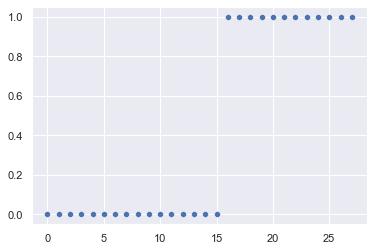

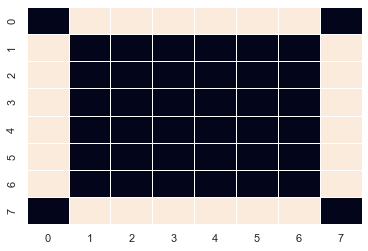

<Figure size 432x288 with 0 Axes>

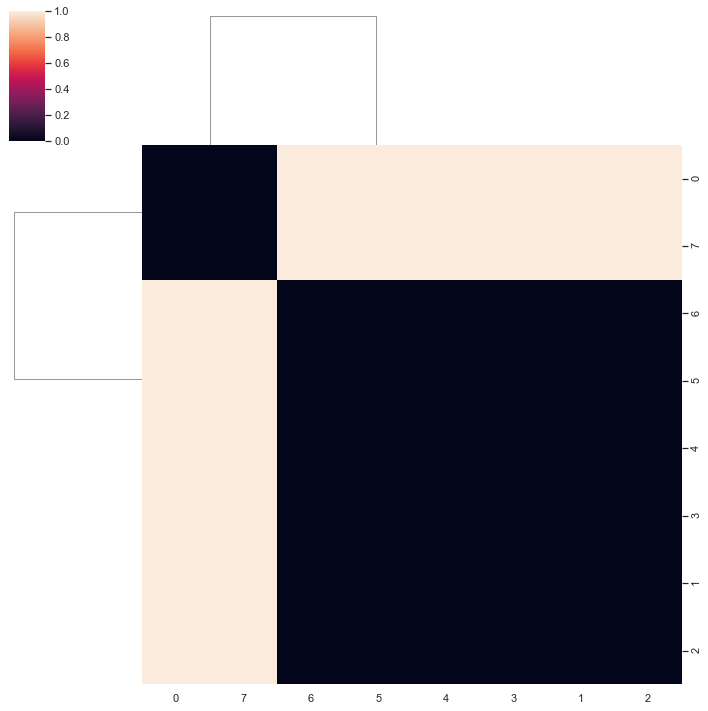

<Figure size 432x288 with 0 Axes>

In [26]:
printModel=False
printPartitions=False
annotateHeatMap=False
%time computeMetrics_handleJVM('prismdtmc/hermann3.tra','prismdtmc/hermann3.lab',1.0,printModel,printPartitions,annotateHeatMap,[])

Starting the JVM and ERODE
  Completed
Loading the model in ERODE prismdtmc/hermann5.tra
Computing the BB partition
We obtained 4 blocks out of 32 variables
Computing the metrics
INTERESTING VALUE in (0,1.0)!!!!!!!!

We have trimmed values larger than 1.0 to 1.0
The values of the metrics, sorted
[0.0, 0.25, 0.5, 0.75, 1.0]


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE
 Completed
CPU times: user 1.22 s, sys: 717 ms, total: 1.94 s
Wall time: 1min 10s


['prismdtmc/hermann5.tra']

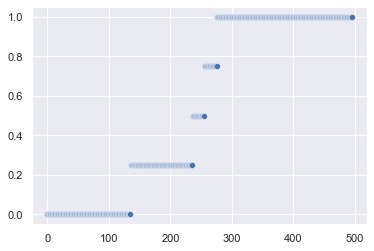

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


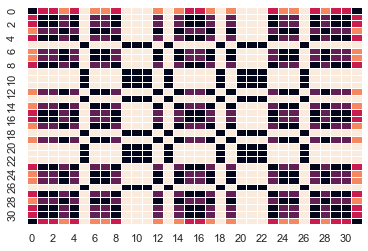

<Figure size 432x288 with 0 Axes>

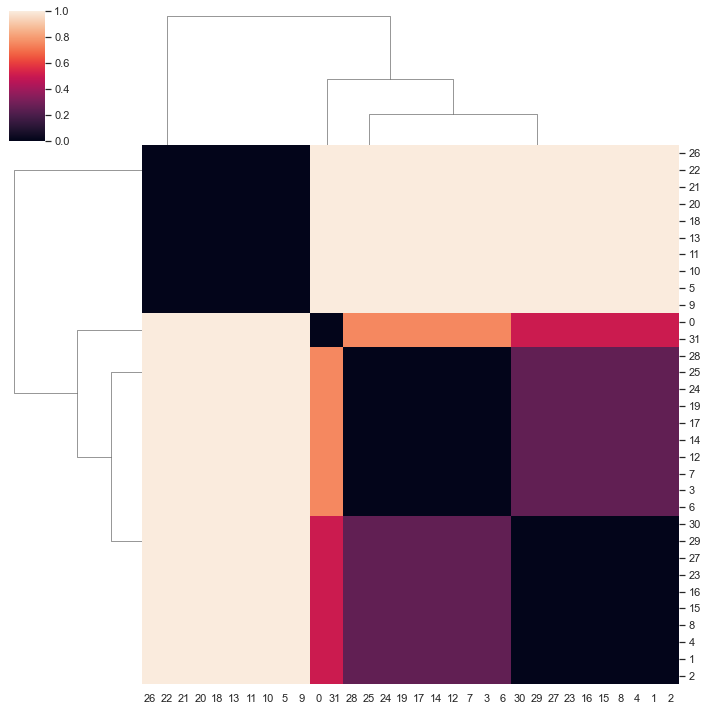

<Figure size 432x288 with 0 Axes>

In [34]:
#"ciao".endswith('o')
#computeMetrics_handleJVM('prismdtmc/hermann3_simple.tra','prismdtmc/hermann3_simple.lab')
#computeMetrics_handleJVM('prismdtmc/hermann3.tra','prismdtmc/hermann3.lab')
#computeMetrics_handleJVM('test2.csv','test2B.csv')
good_models=[]
%time computeMetrics_handleJVM('prismdtmc/hermann5.tra','prismdtmc/hermann5.lab',1.0,printModel,printPartitions,annotateHeatMap,good_models)
#computeMetrics_handleJVM('test.csv','testB.csv')

good_models

## leader_sync - BAD

In [9]:
#%time computeMetrics_handleJVM('prismdtmc/leader_sync3_2.tra','prismdtmc/leader_sync3_2.lab',1.0,printModel,printPartitions,annotateHeatMap,[])

#The values of the metrics, sorted
#[0.0, 1.0]

## NAND

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 44 blocks out of 44 variables
Computing the metrics
0.0 1.0 0.1 0.9 0.1 0.9 0.1 0.9 1.04 2.96 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
1.0 0.0 1.0 1.0 0.91 0.19 0.99 0.91 0.908 2.06 1.04 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.1 1.0 0.0 0.8 0.1 0.9 0.1 0.9 1.0166 2.879 0.9908 1.1 1.004 1.1 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.9 1.0 0.8 0.0 0.9 0.9 0.9 0.9 0.9446 2.231 0.9172 1.9 1.036 1.9 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.1 0.91 0.1 0.9 0.0 0.8 0.08 0.88 0.998 2.87 1.00166 1.1 0.99908 1.01 1.0004 1.01 1.0 1.0 1.0 1.0 1.0 1.

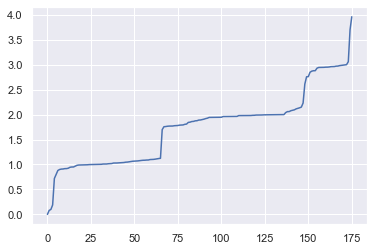

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE
 Completed
CPU times: user 1.7 s, sys: 1.12 s, total: 2.82 s
Wall time: 3min 2s


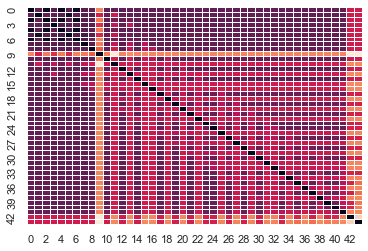

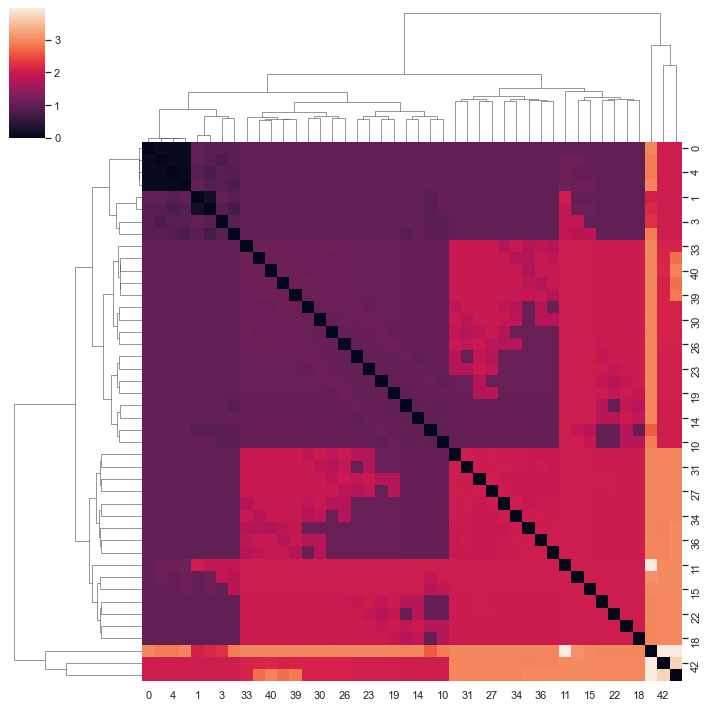

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


In [16]:
%time computeMetrics_handleJVM('prismdtmc/nandN1.K2.tra','prismdtmc/nandN1.K2.lab',1.0,printModel,printPartitions,False,[])

## Oscillators

Starting the JVM and ERODE
  Completed
Loading the model in ERODE prismdtmc/oscillators/oscillators.3-6-0.1-1.v1mu0.1.lambda1.tra
Computing the BB partition
We obtained 39 blocks out of 57 variables
Computing the metrics
INTERESTING VALUE in (0,1.0)!!!!!!!!

We have trimmed values larger than 1.0 to 1.0
The values of the metrics, sorted
[0.0, 0.00463, 0.00926, 0.01389, 0.02315, 0.02778, 0.1, 0.10926, 0.11, 0.11389, 0.12315, 0.12778, 0.2, 0.21389, 0.28, 0.28926, 0.29389, 0.38, 0.39389, 0.5545, 0.92, 1.0]


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Terminating JVM and ERODE
 Completed
CPU times: user 4.77 s, sys: 1.69 s, total: 6.46 s
Wall time: 13min 50s


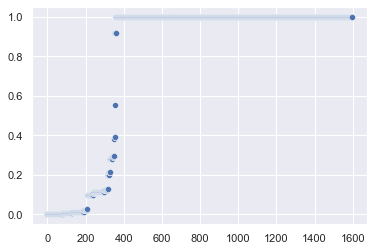

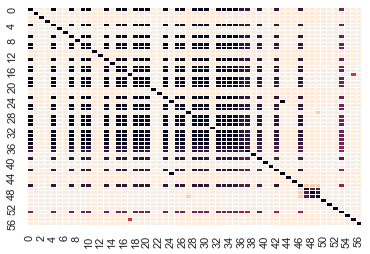

<Figure size 432x288 with 0 Axes>

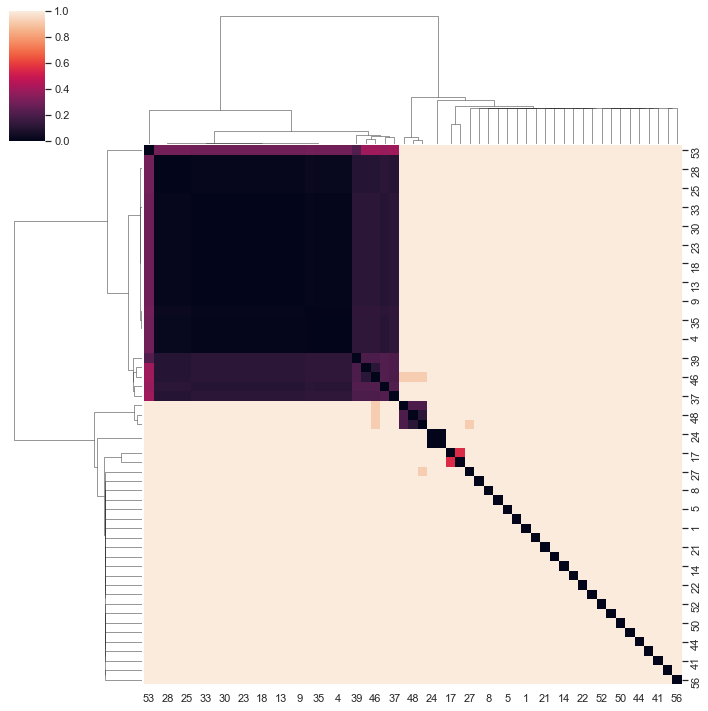

<Figure size 432x288 with 0 Axes>

In [35]:
%time computeMetrics_handleJVM('prismdtmc/oscillators/oscillators.3-6-0.1-1.v1mu0.1.lambda1.tra','prismdtmc/oscillators/oscillators.3-6-0.1-1.v1mu0.1.lambda1.lab',1.0,printModel,printPartitions,False,[])

In [36]:
#%time computeMetrics_handleJVM('prismdtmc/oscillators/oscillatorsmu0.1.lambda1.tra','prismdtmc/oscillators/oscillatorsmu0.1.lambda1.lab',1.0,printModel,printPartitions,False,[])

# Leontief

## Italy

In [ ]:
%time computeMetrics_handleJVM('leontief/ITAData.csv','leontief/ITADemand.csv',546053.0,printModel,printPartitions,False)

In [ ]:
%time computeMetrics_handleJVM('leontief/ITAData.csv','leontief/ITADemand.csv',1,printModel,printPartitions,False)

# Weighted Networks

## Euler

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/si

done


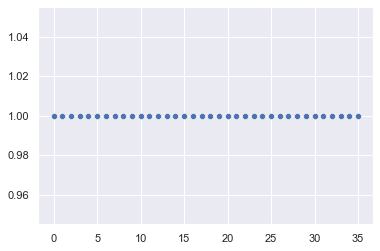

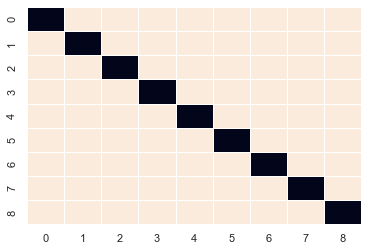

<Figure size 432x288 with 0 Axes>

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


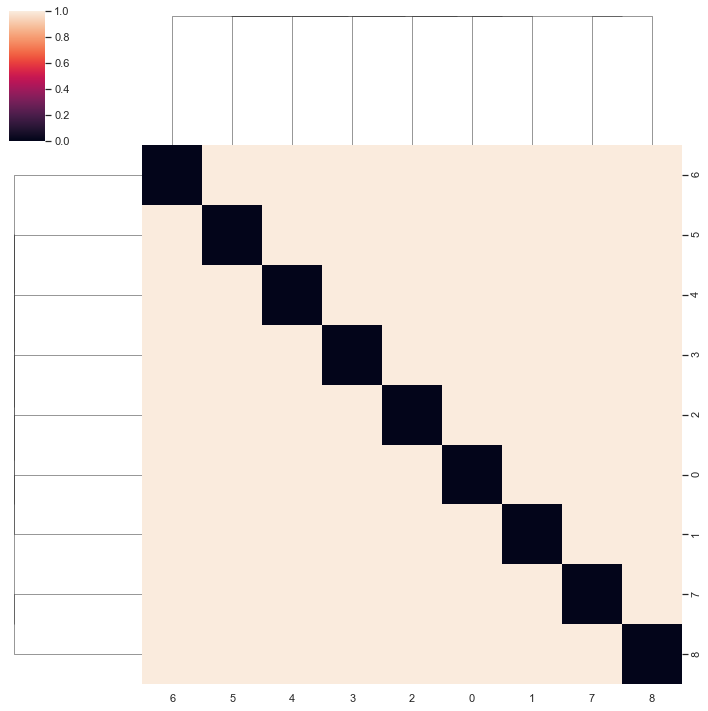

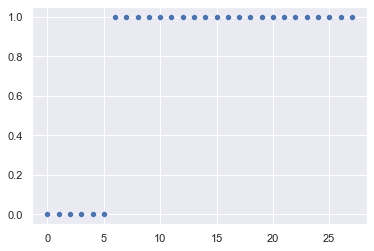

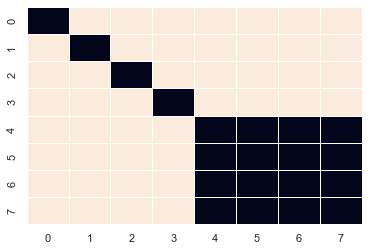

<Figure size 432x288 with 0 Axes>

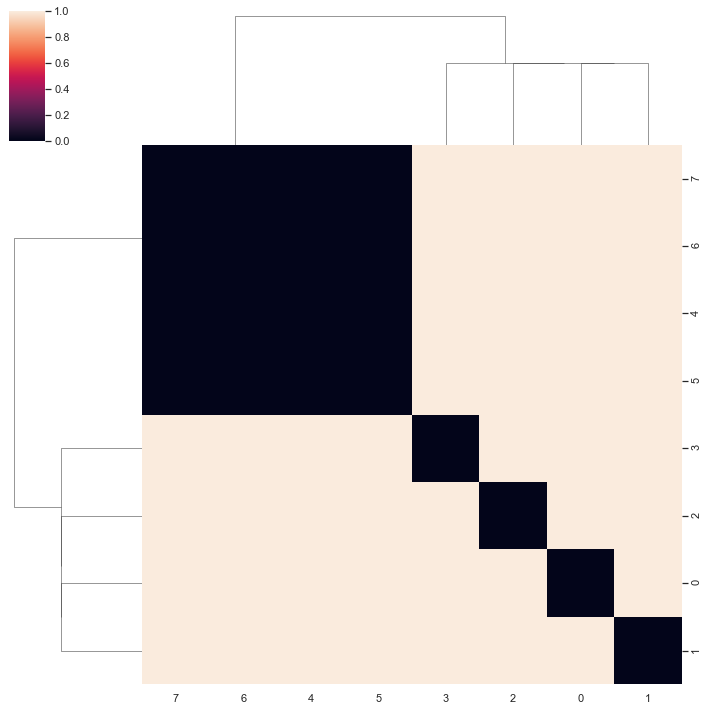

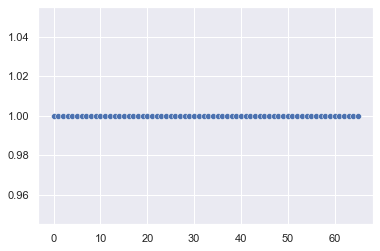

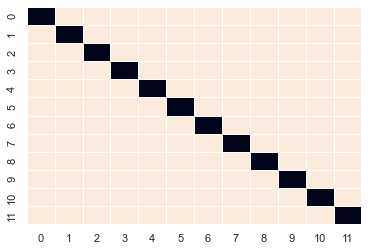

<Figure size 432x288 with 0 Axes>

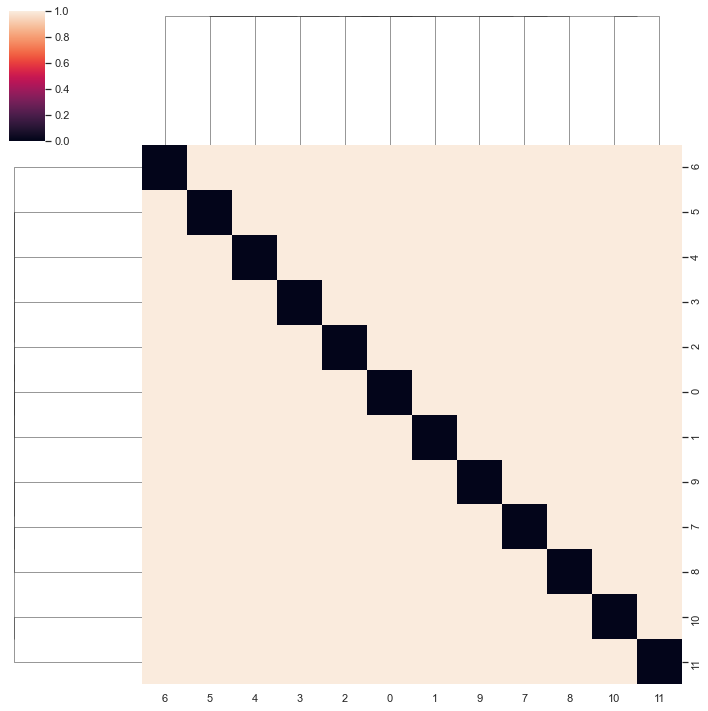

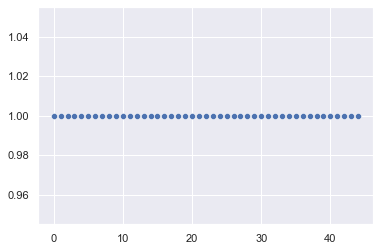

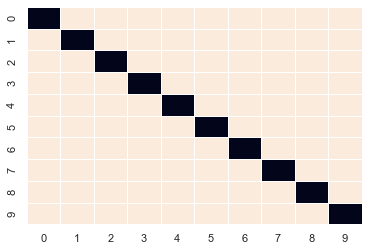

<Figure size 432x288 with 0 Axes>

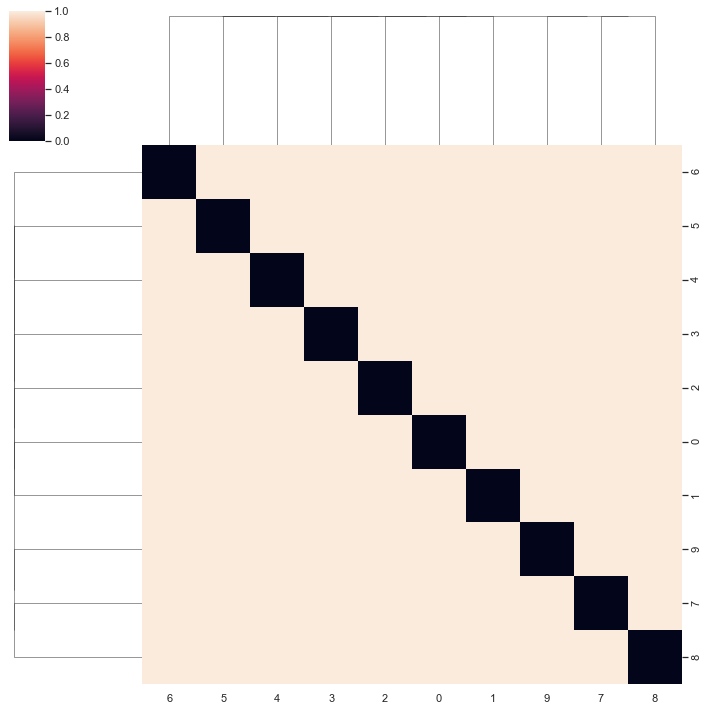

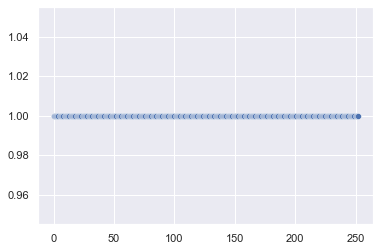

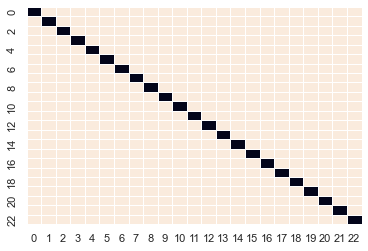

<Figure size 432x288 with 0 Axes>

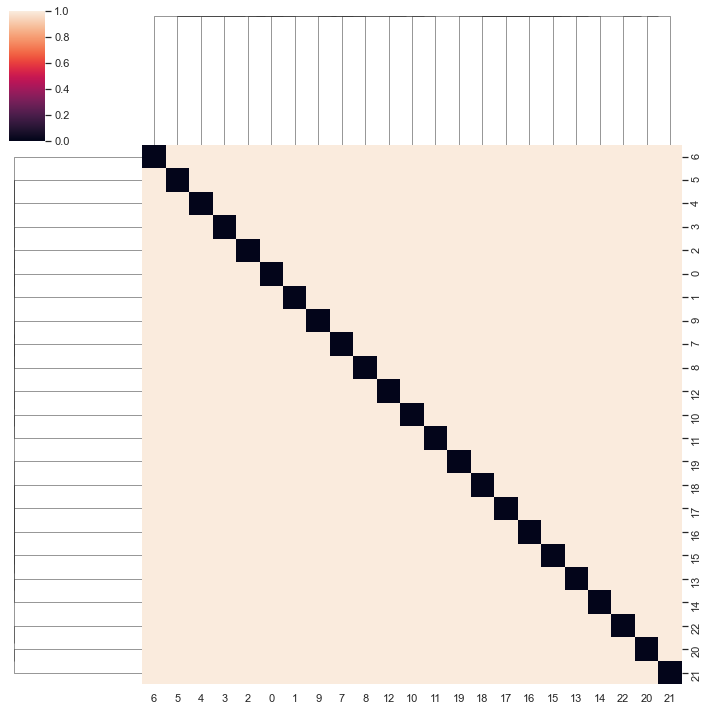

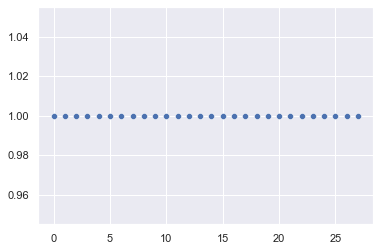

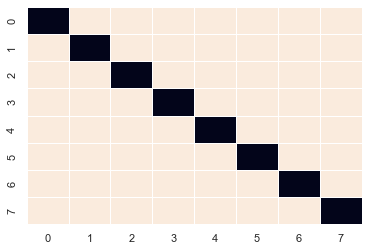

<Figure size 432x288 with 0 Axes>

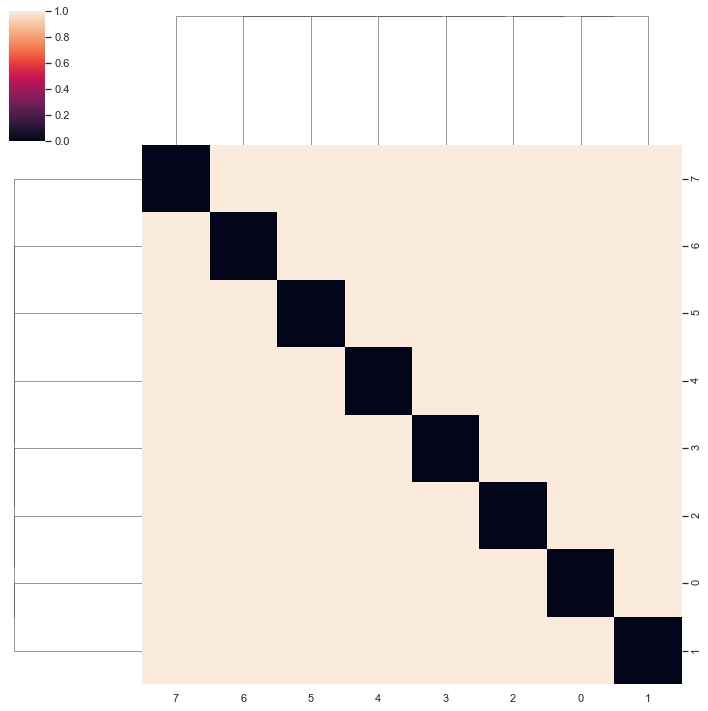

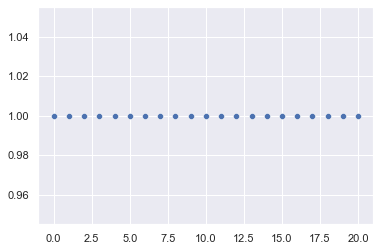

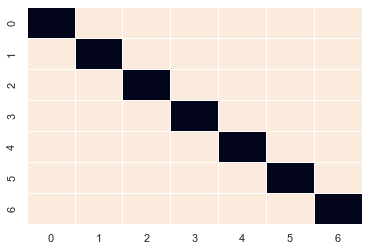

<Figure size 432x288 with 0 Axes>

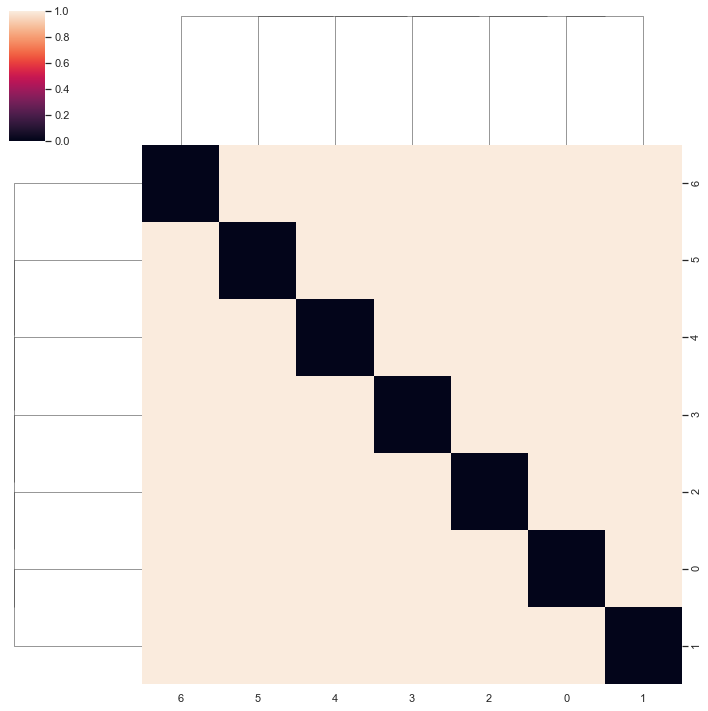

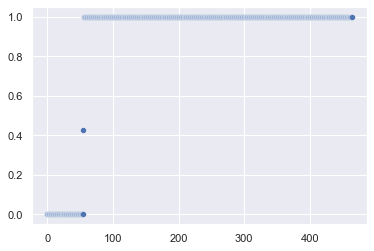

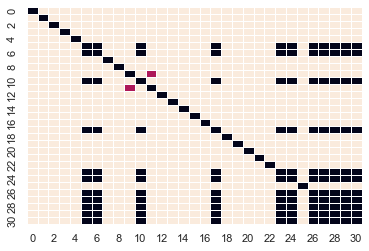

<Figure size 432x288 with 0 Axes>

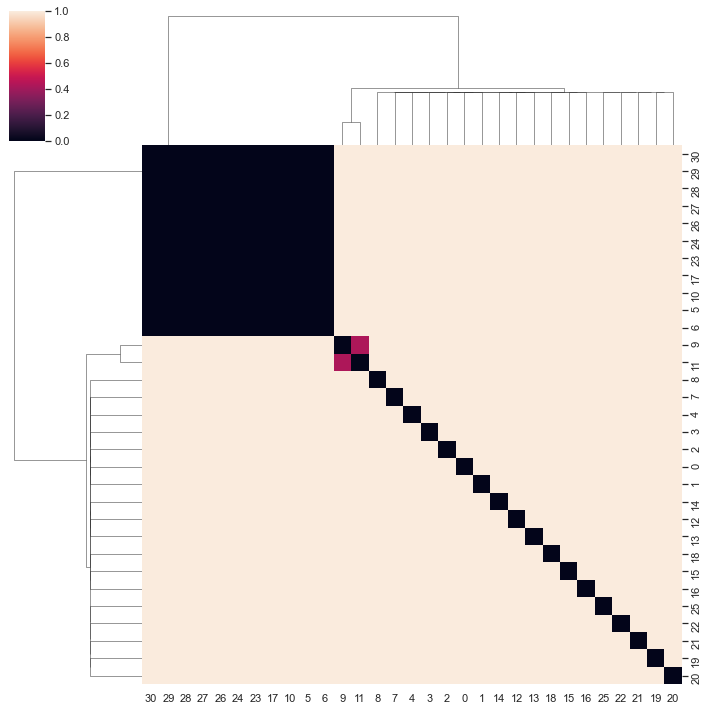

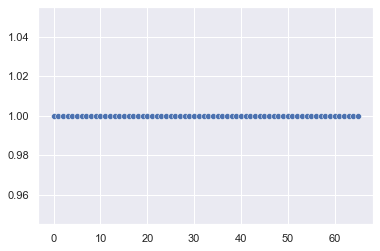

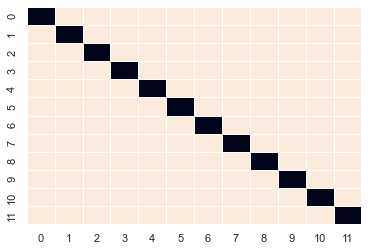

<Figure size 432x288 with 0 Axes>

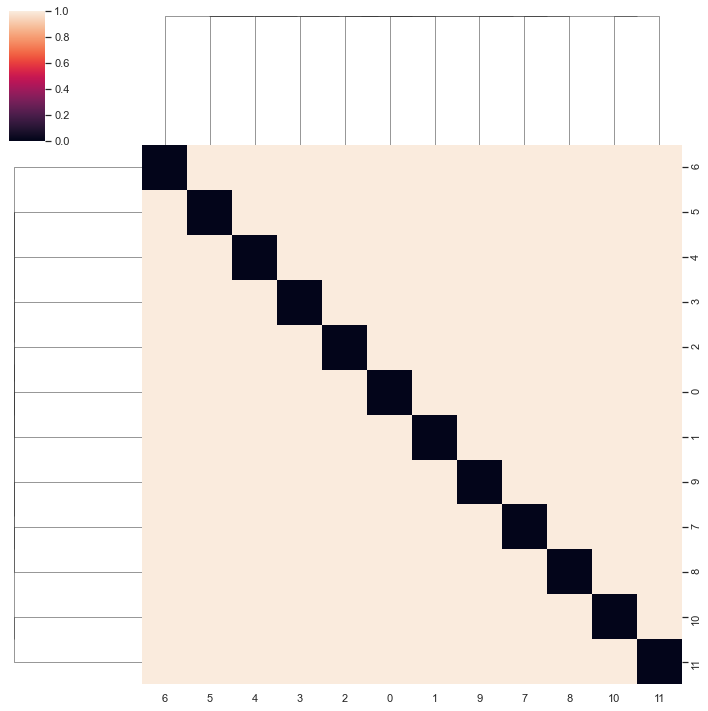

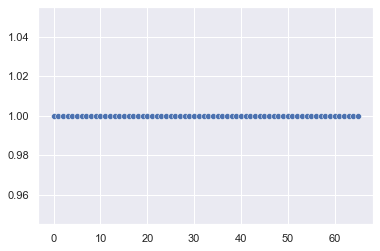

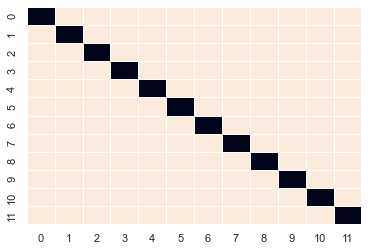

<Figure size 432x288 with 0 Axes>

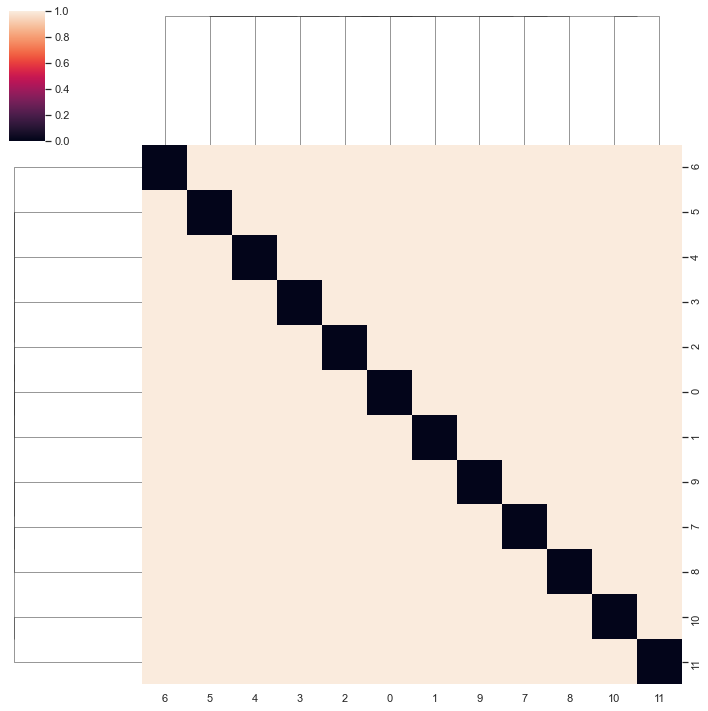

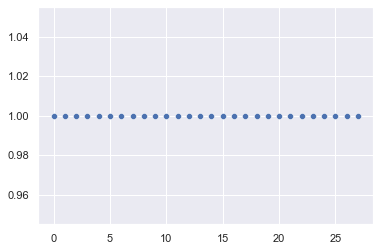

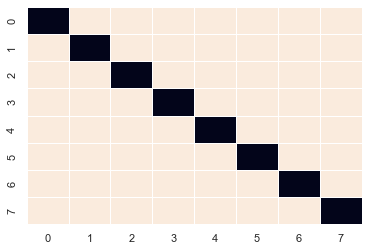

<Figure size 432x288 with 0 Axes>

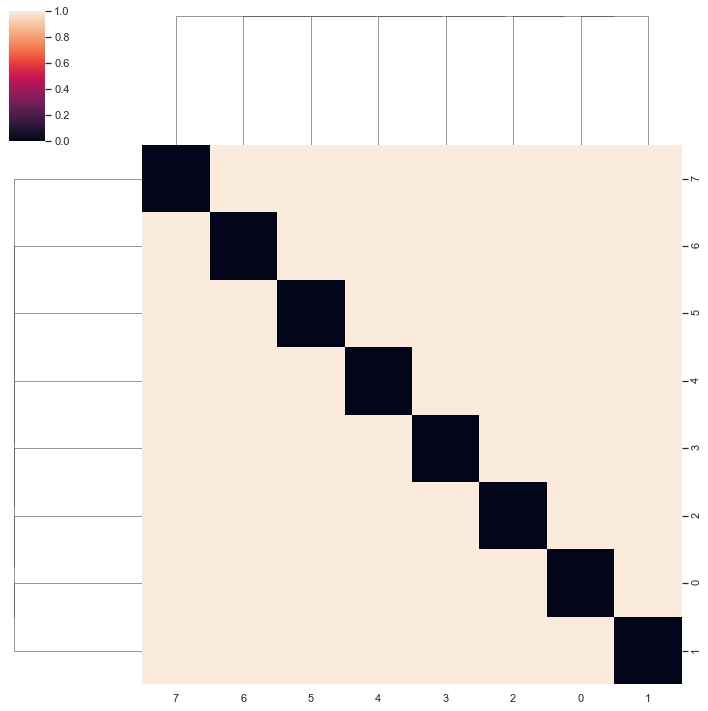

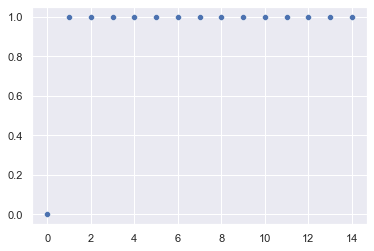

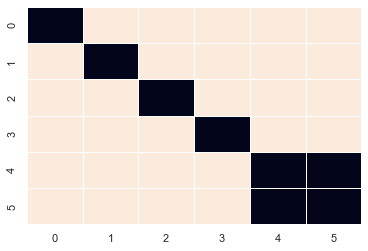

<Figure size 432x288 with 0 Axes>

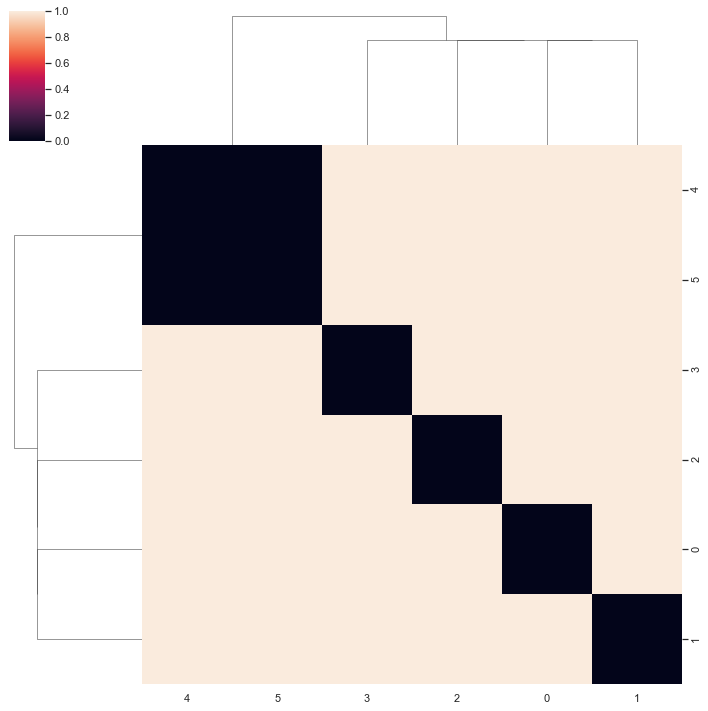

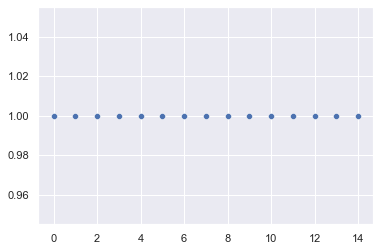

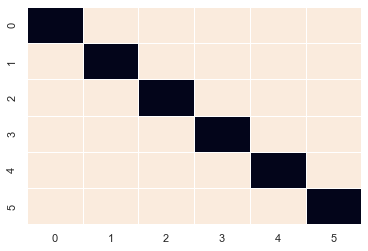

<Figure size 432x288 with 0 Axes>

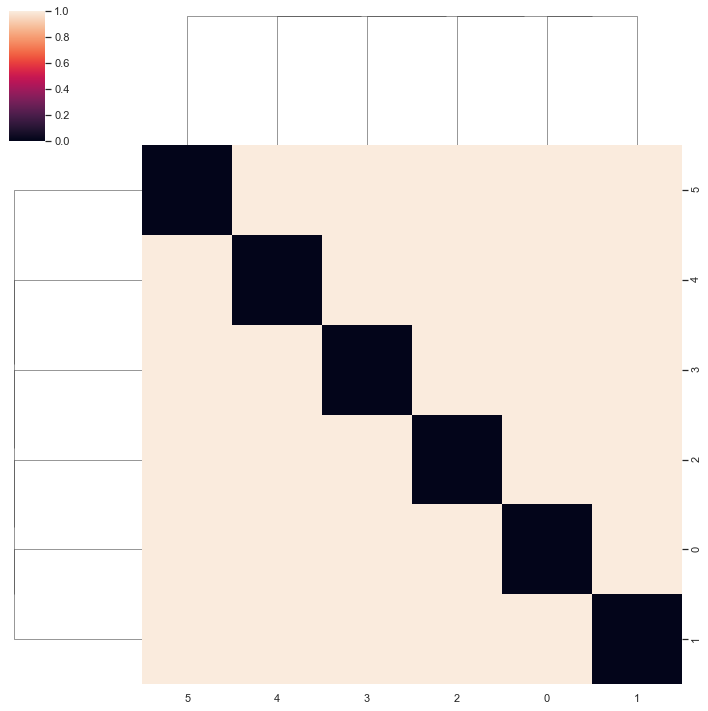

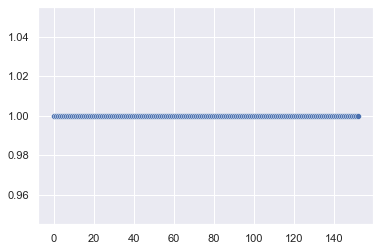

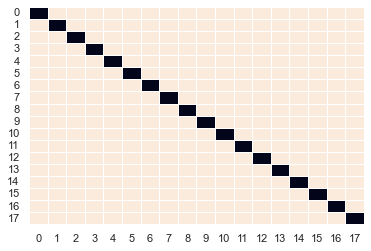

<Figure size 432x288 with 0 Axes>

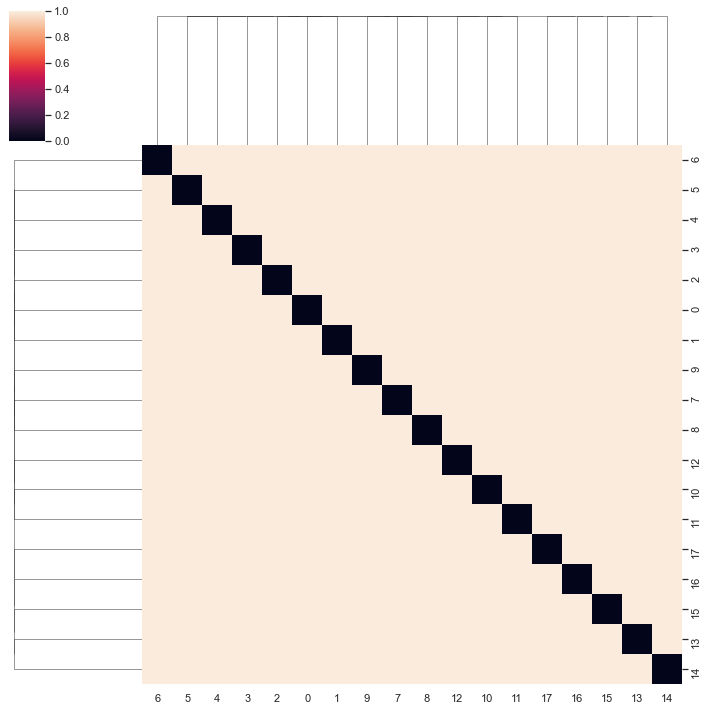

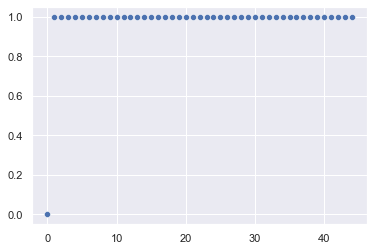

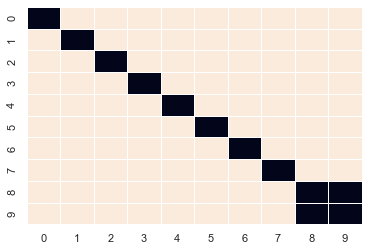

<Figure size 432x288 with 0 Axes>

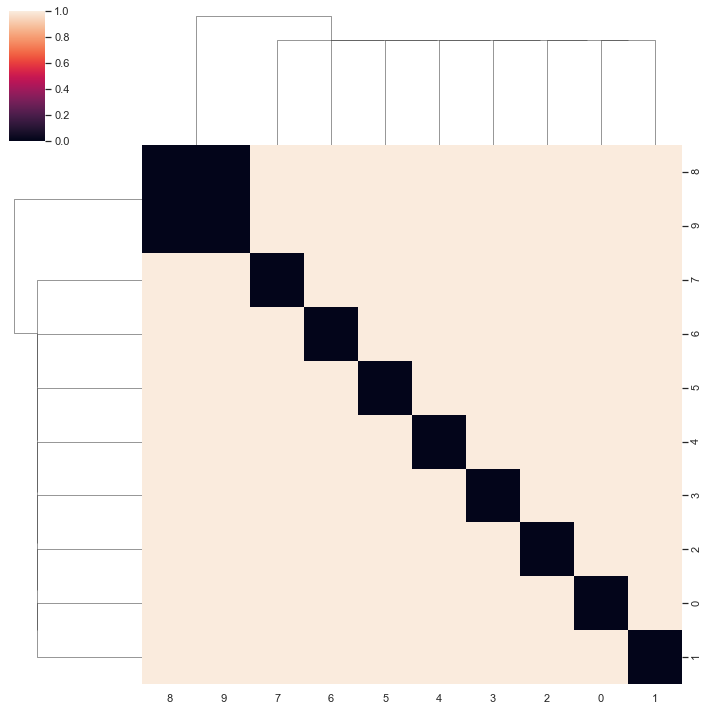

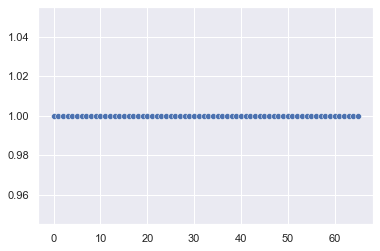

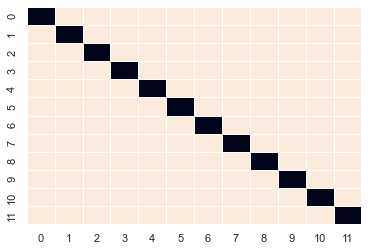

<Figure size 432x288 with 0 Axes>

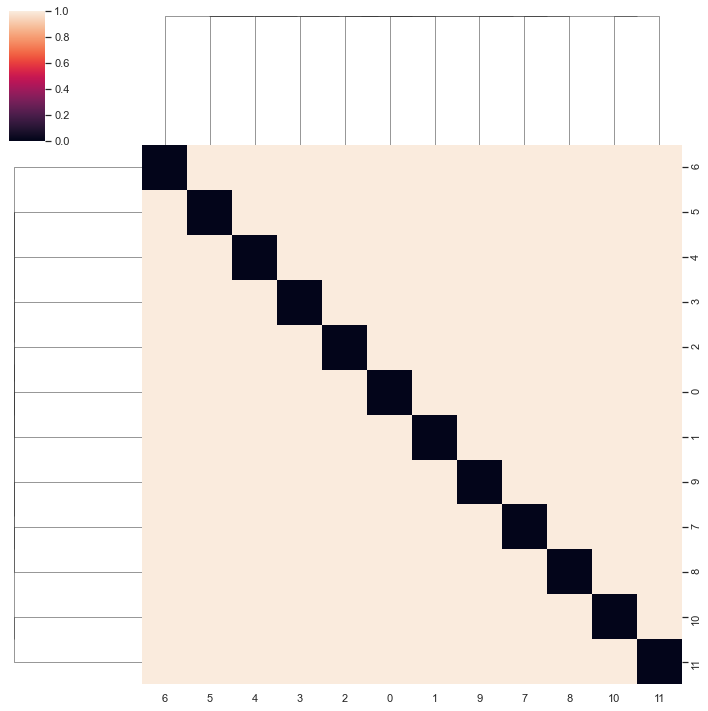

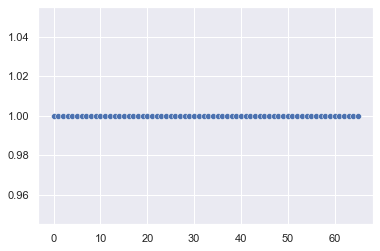

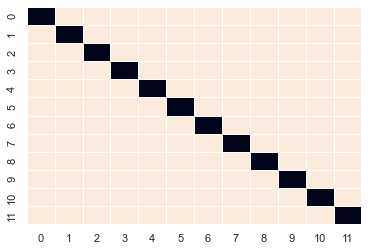

<Figure size 432x288 with 0 Axes>

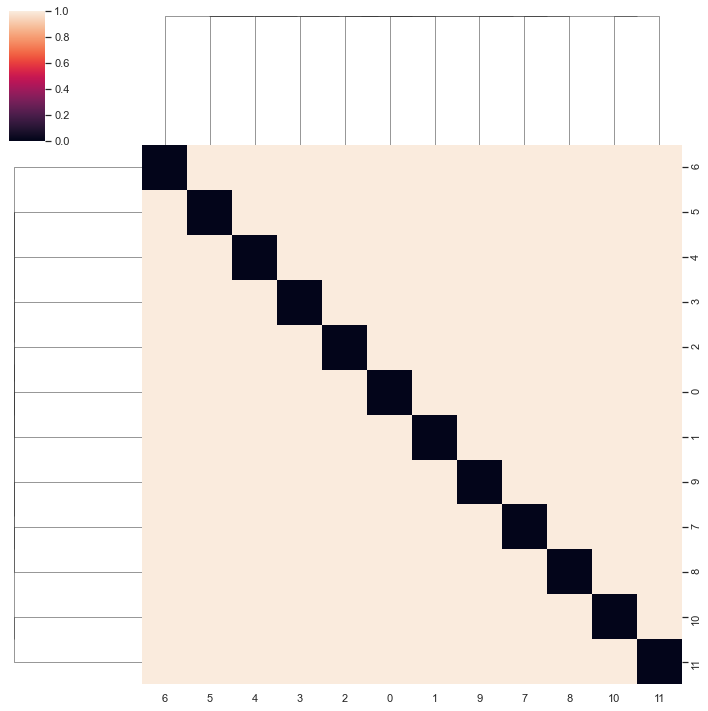

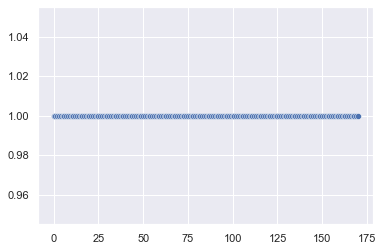

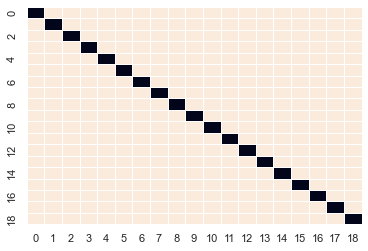

<Figure size 432x288 with 0 Axes>

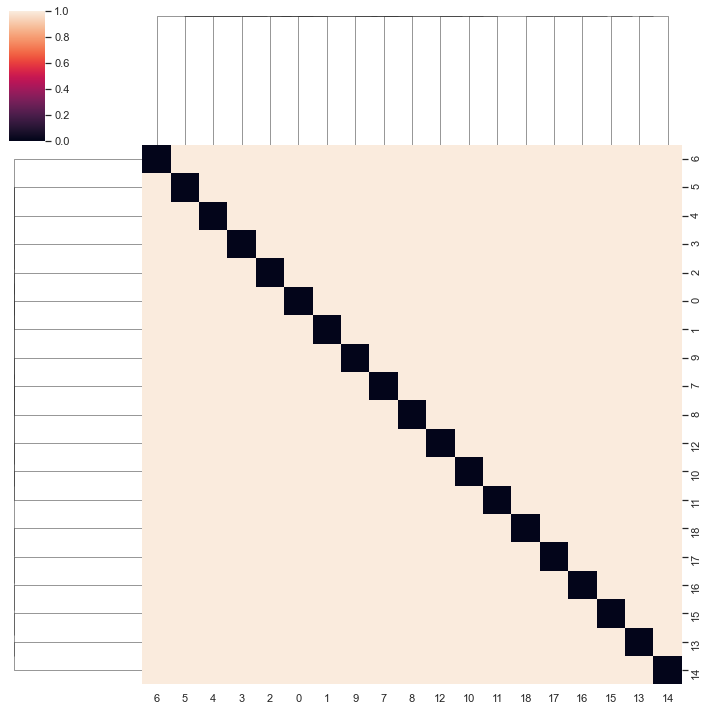

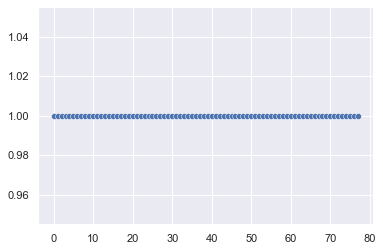

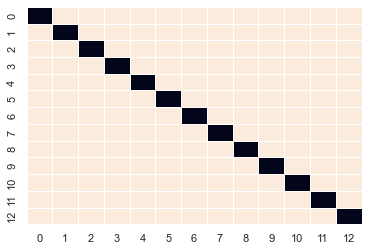

<Figure size 432x288 with 0 Axes>

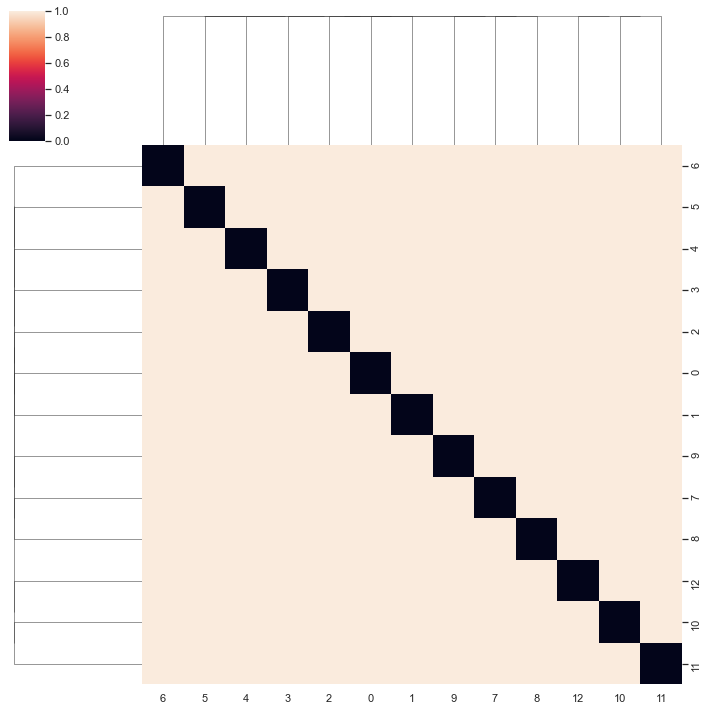

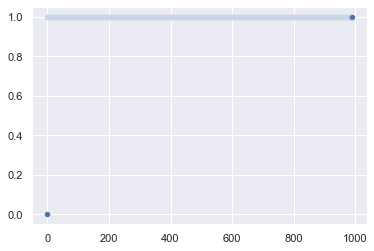

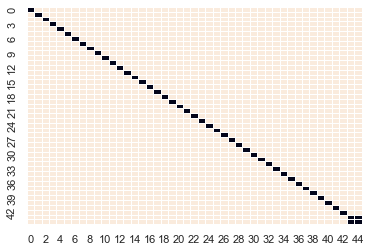

<Figure size 432x288 with 0 Axes>

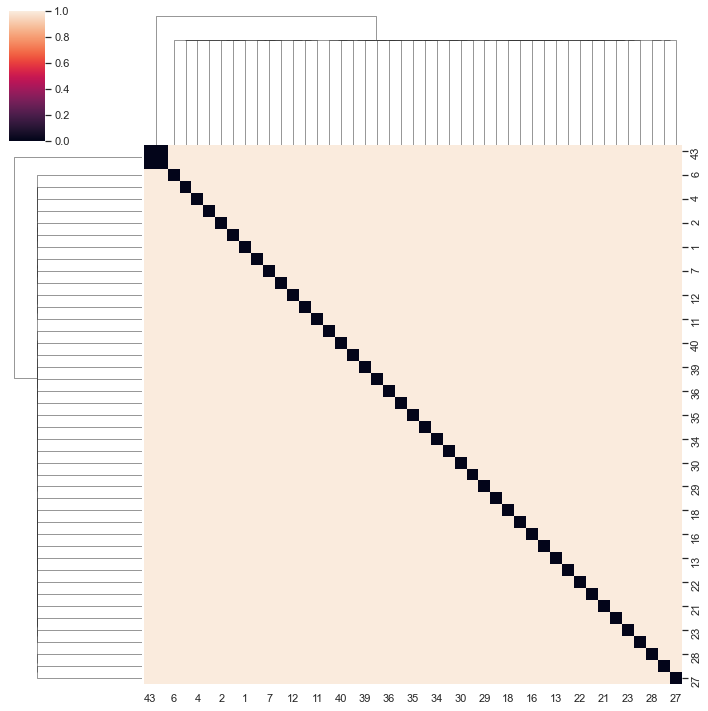

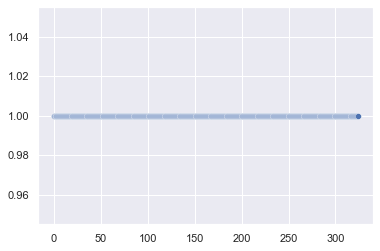

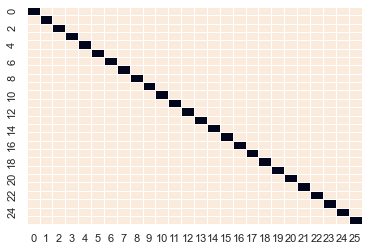

<Figure size 432x288 with 0 Axes>

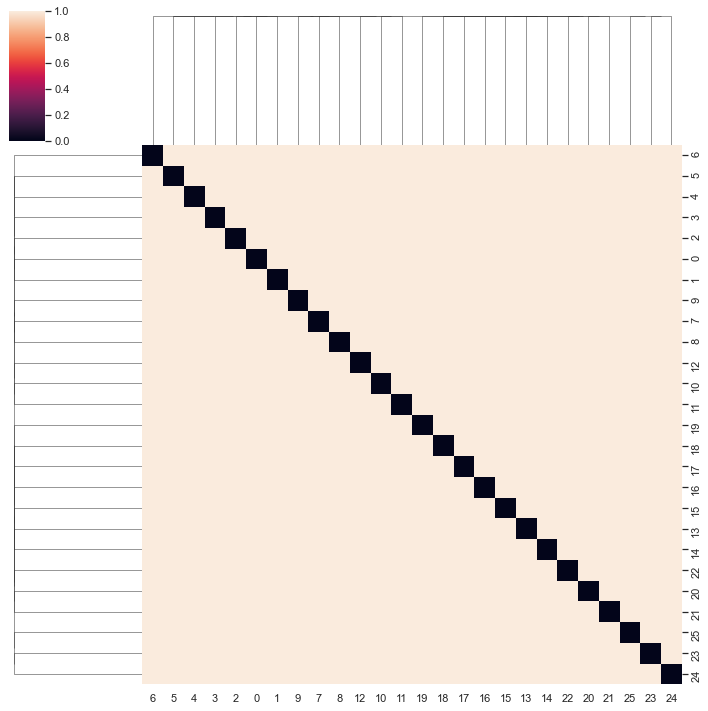

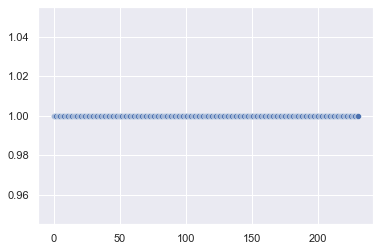

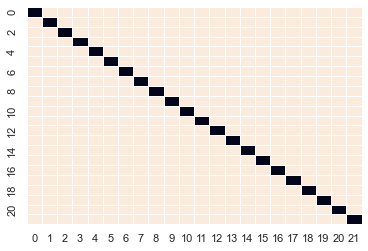

<Figure size 432x288 with 0 Axes>

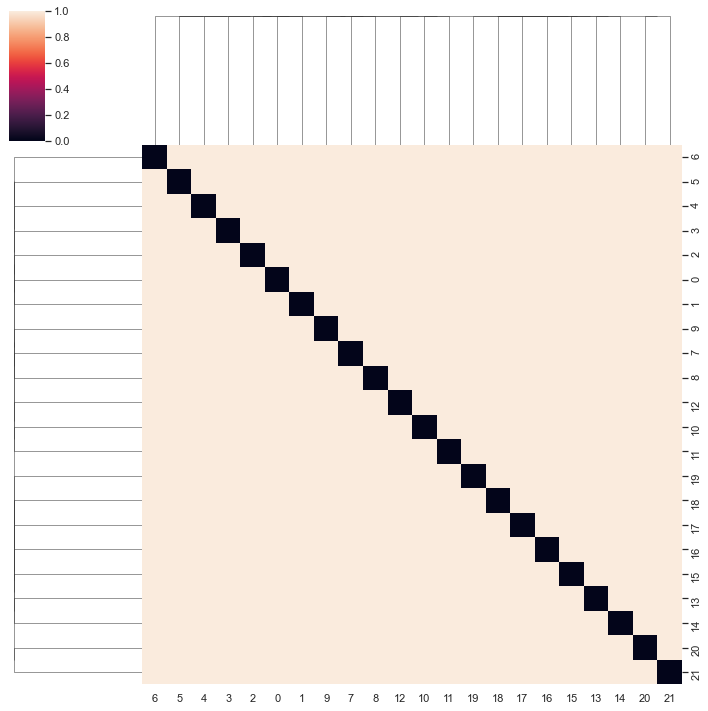

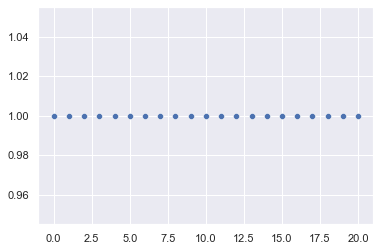

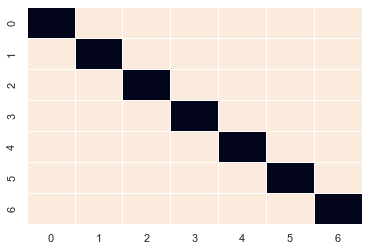

<Figure size 432x288 with 0 Axes>

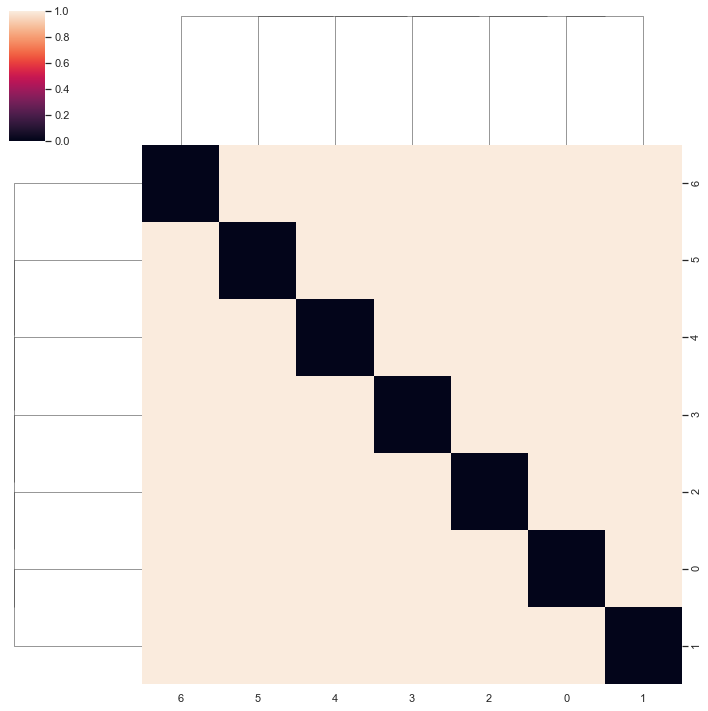

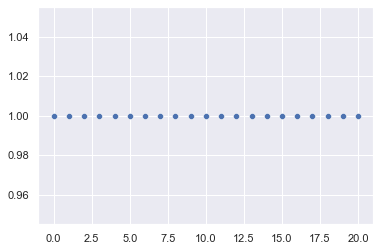

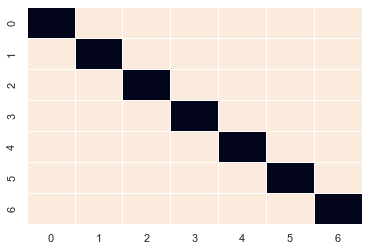

<Figure size 432x288 with 0 Axes>

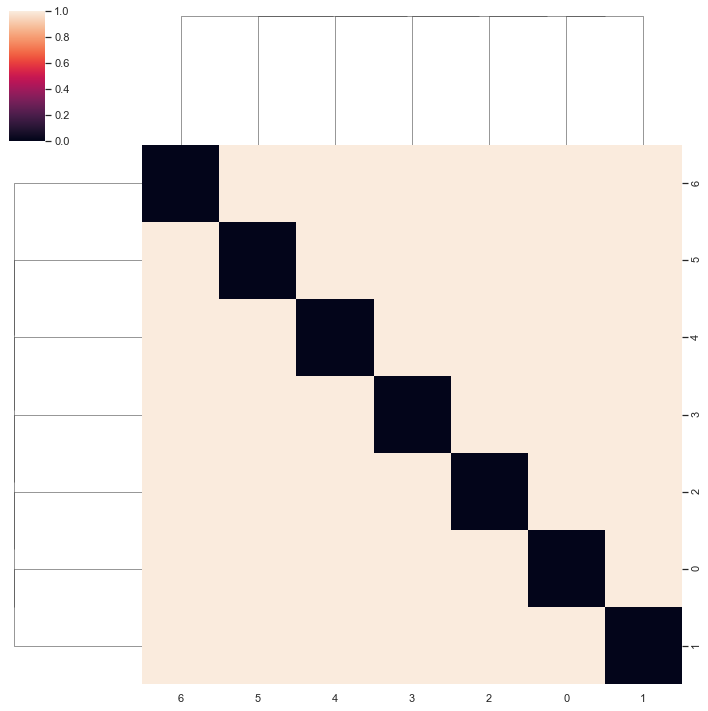

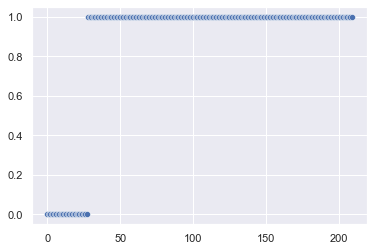

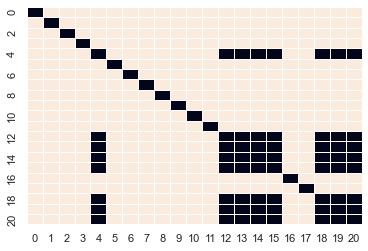

<Figure size 432x288 with 0 Axes>

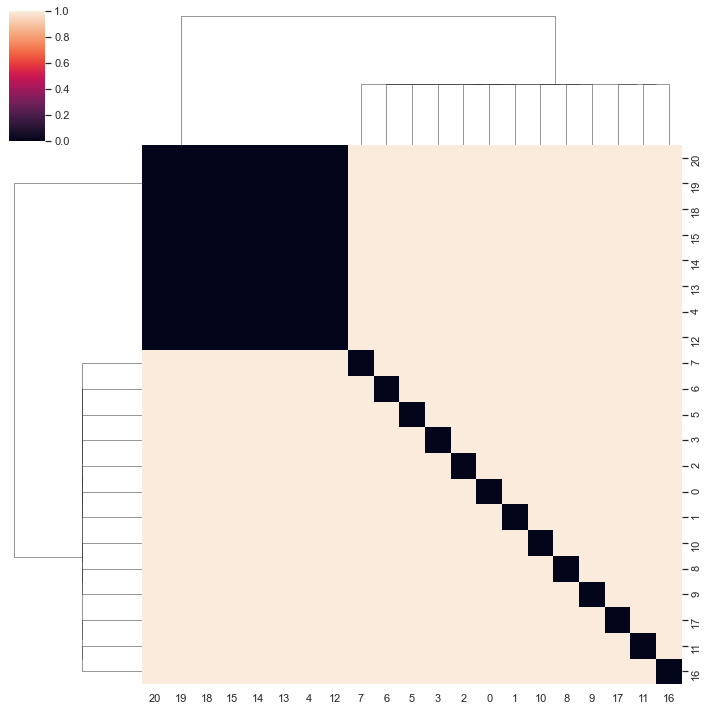

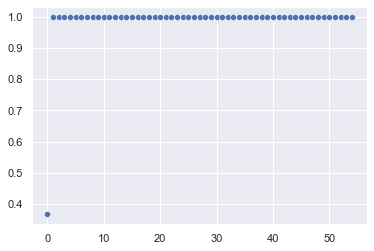

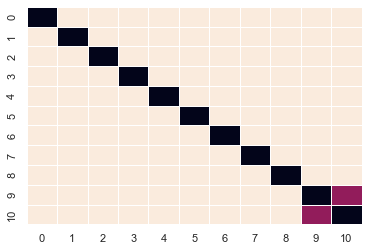

<Figure size 432x288 with 0 Axes>

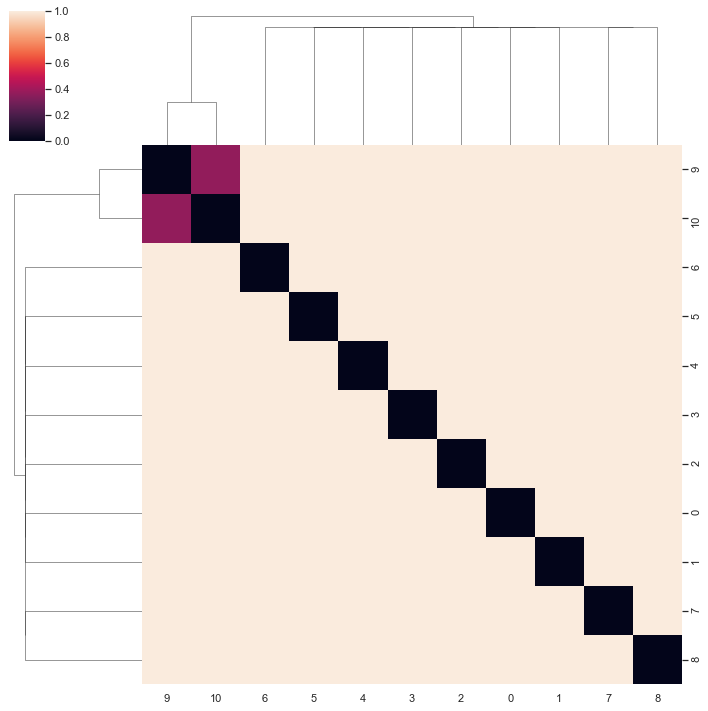

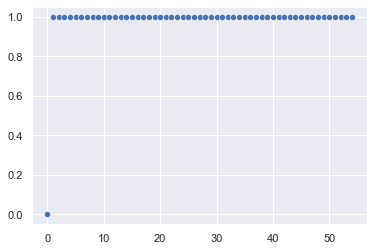

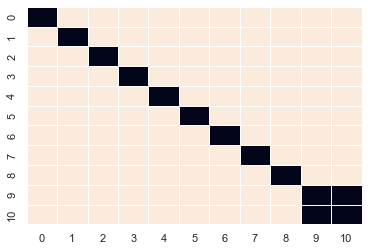

<Figure size 432x288 with 0 Axes>

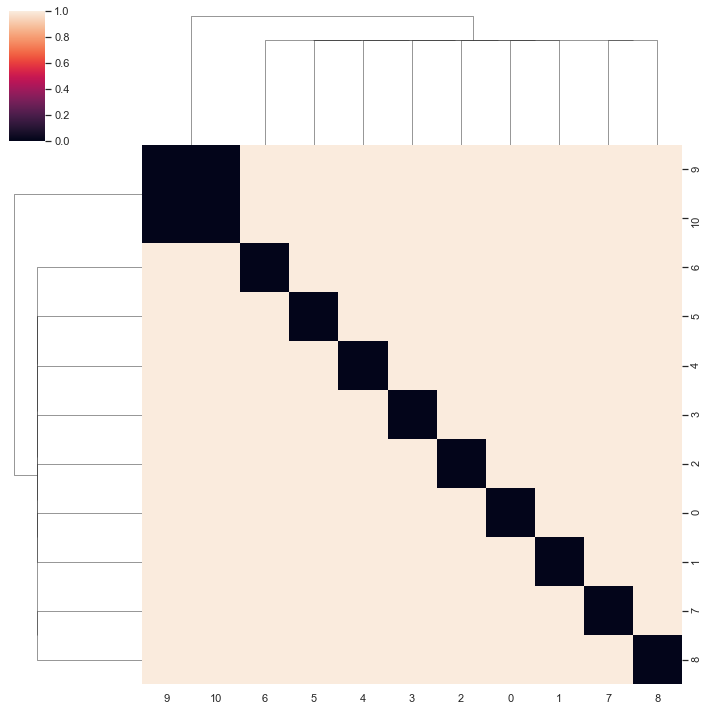

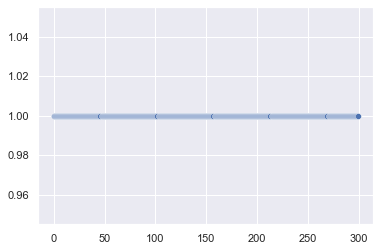

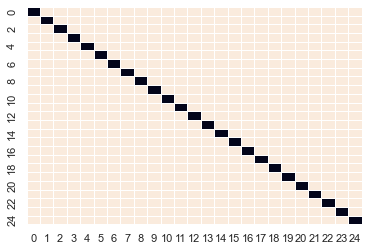

<Figure size 432x288 with 0 Axes>

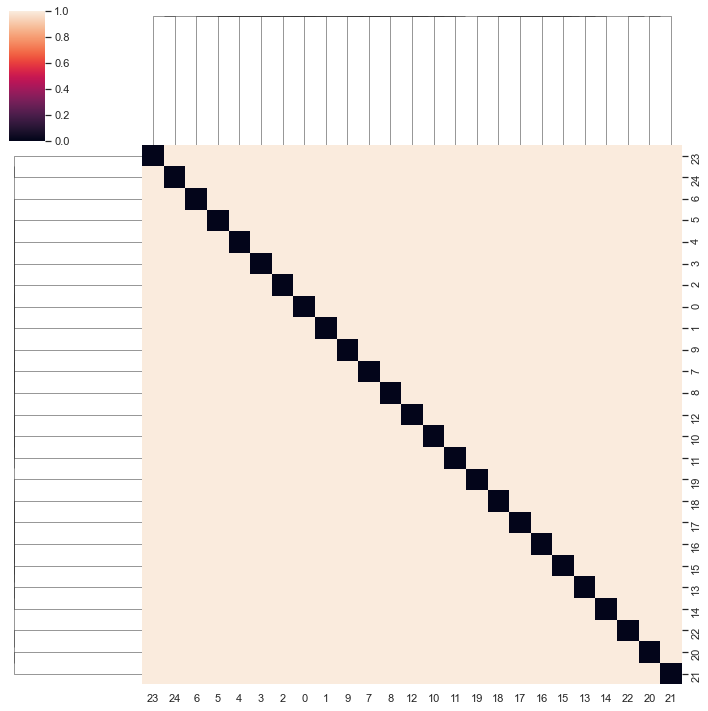

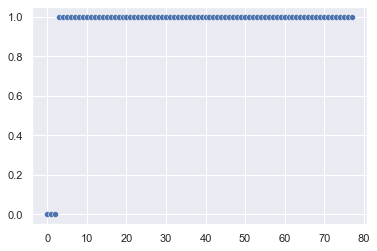

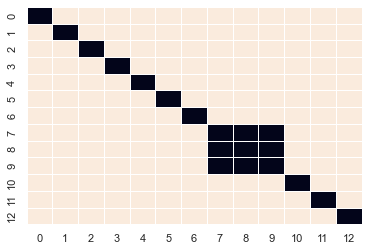

<Figure size 432x288 with 0 Axes>

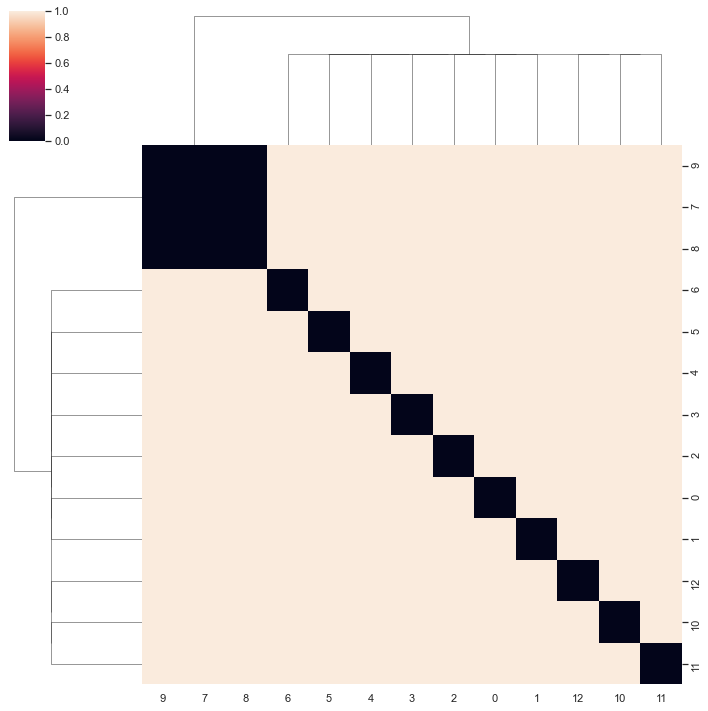

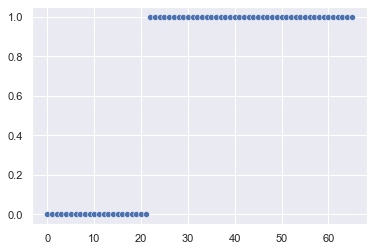

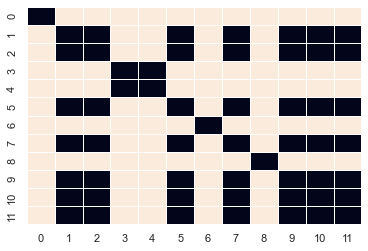

<Figure size 432x288 with 0 Axes>

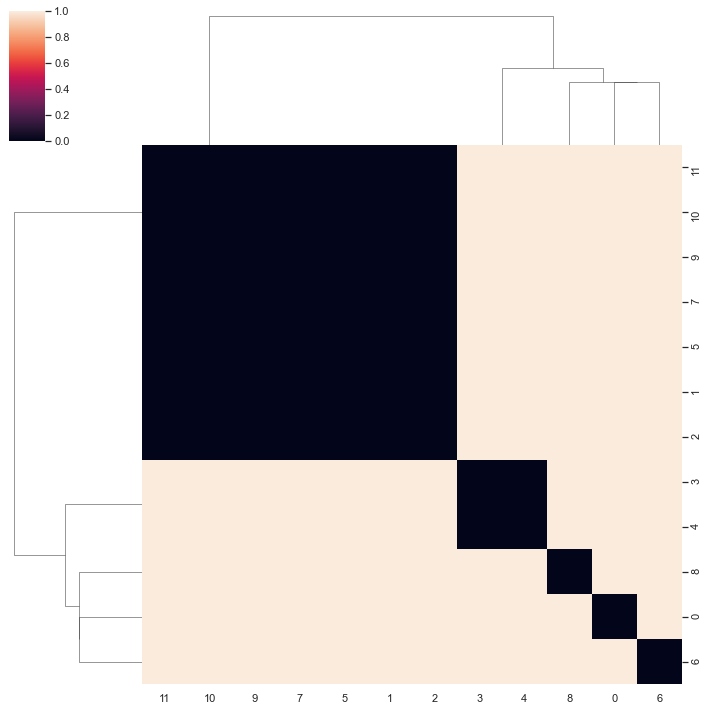

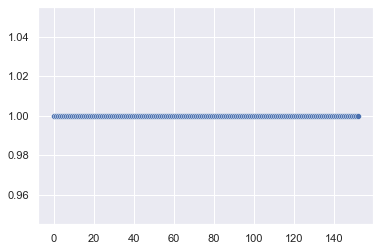

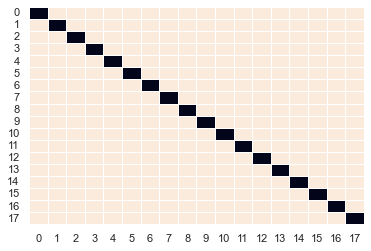

<Figure size 432x288 with 0 Axes>

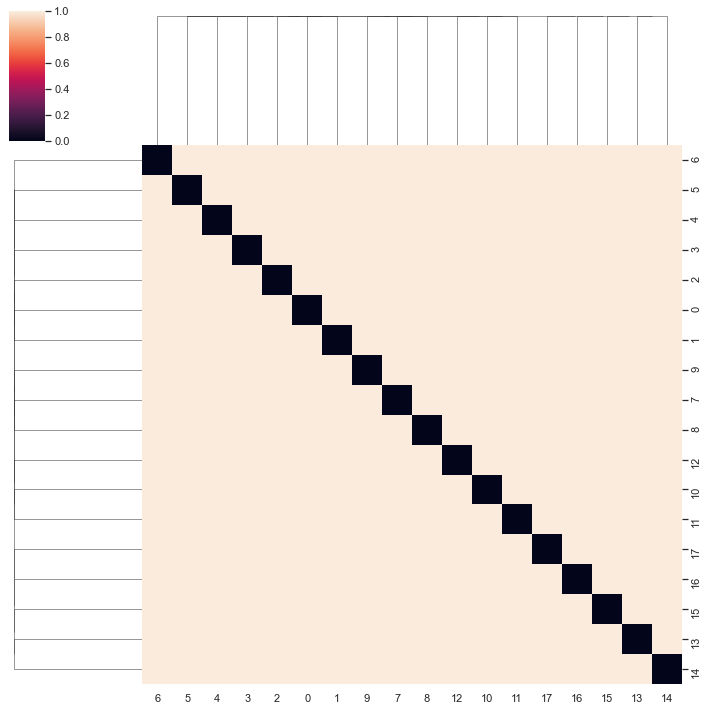

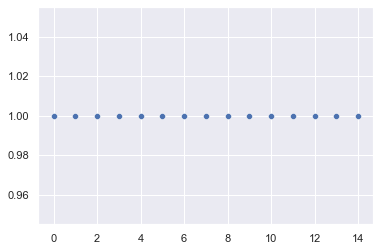

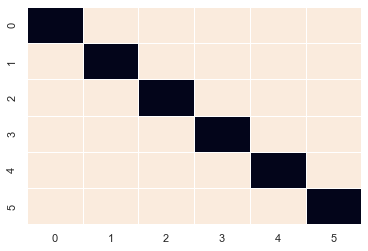

<Figure size 432x288 with 0 Axes>

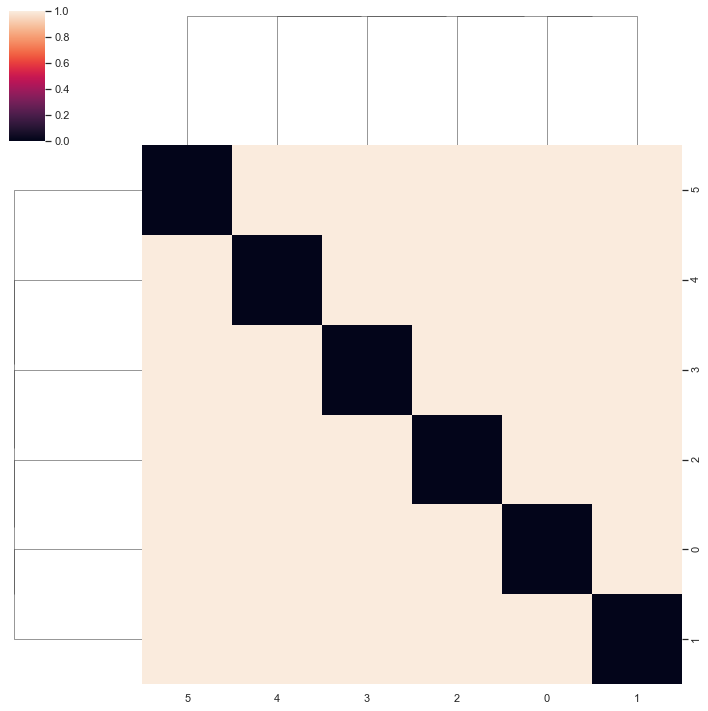

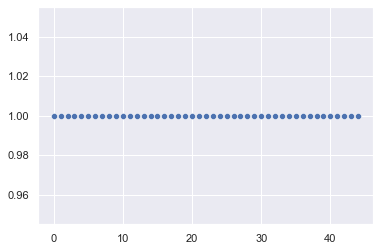

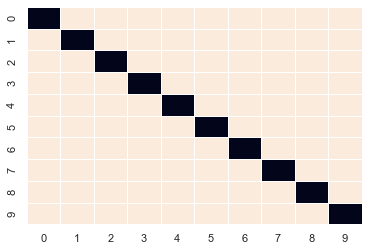

<Figure size 432x288 with 0 Axes>

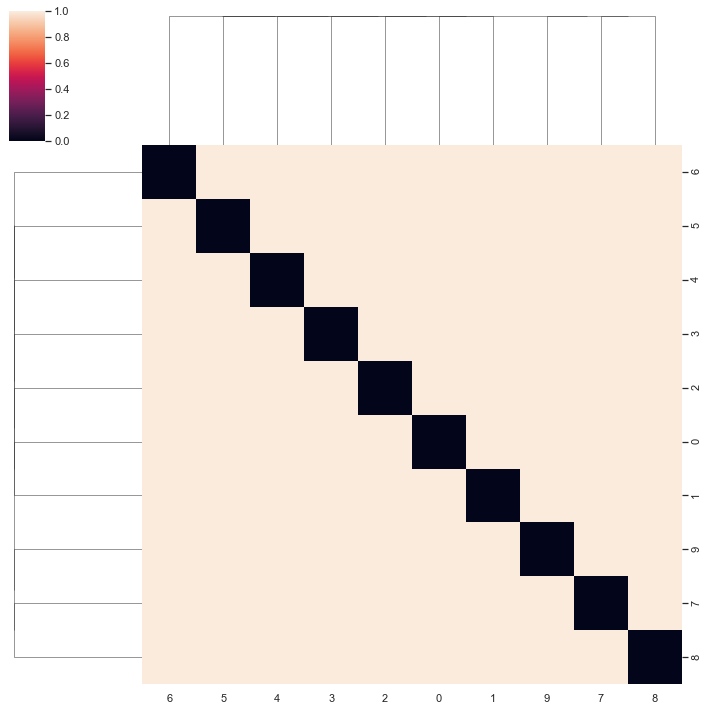

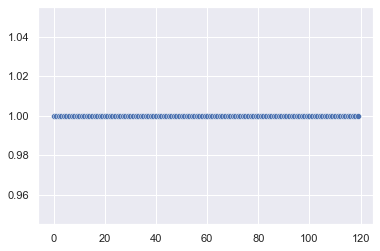

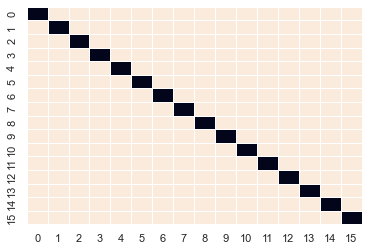

<Figure size 432x288 with 0 Axes>

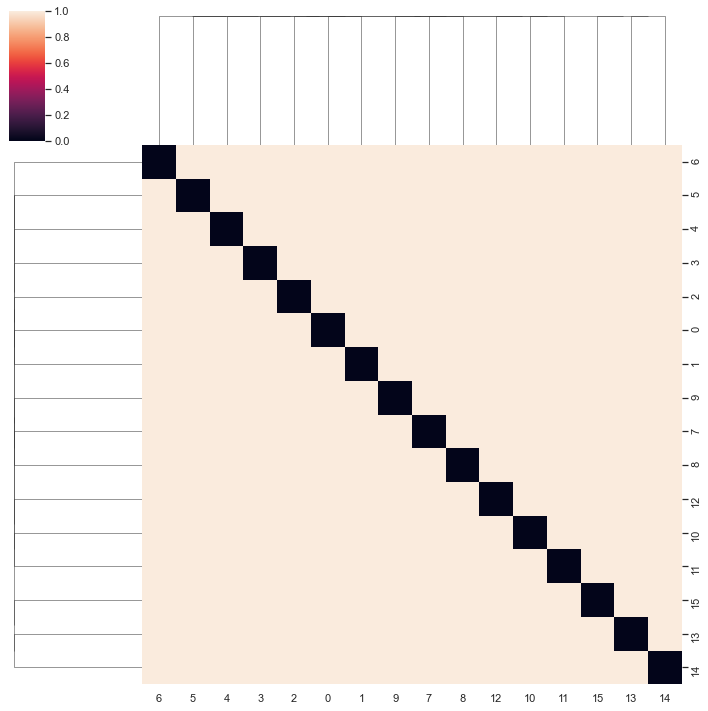

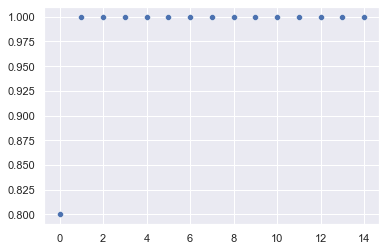

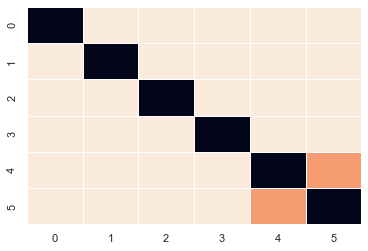

<Figure size 432x288 with 0 Axes>

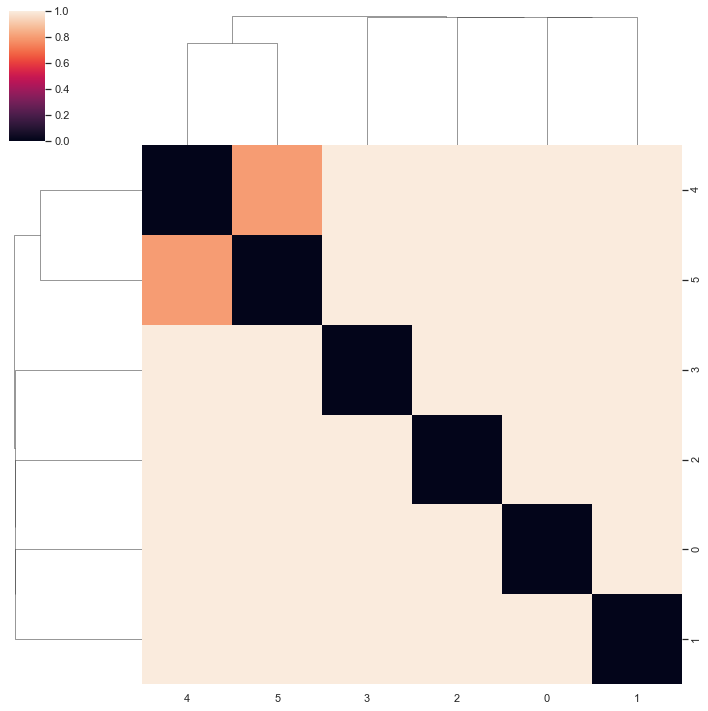

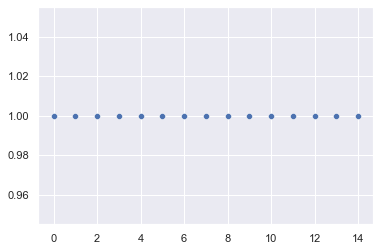

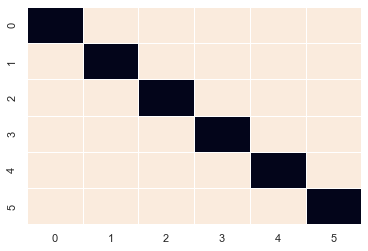

<Figure size 432x288 with 0 Axes>

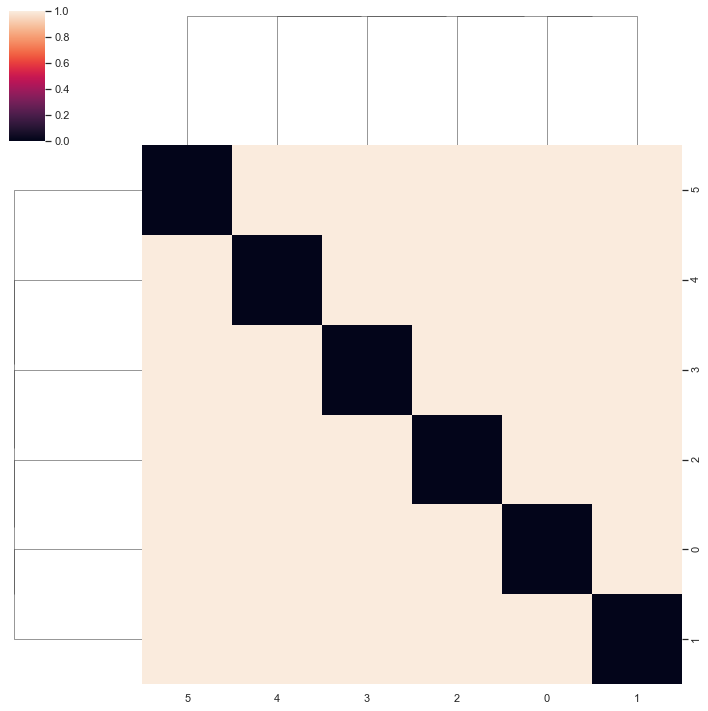

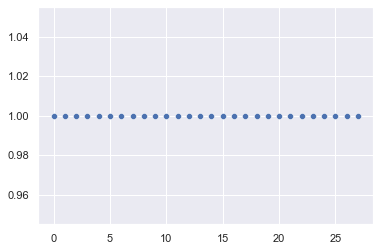

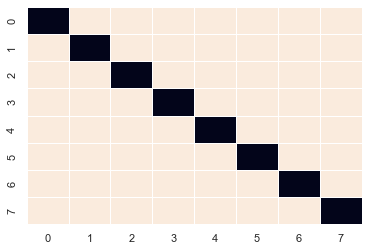

<Figure size 432x288 with 0 Axes>

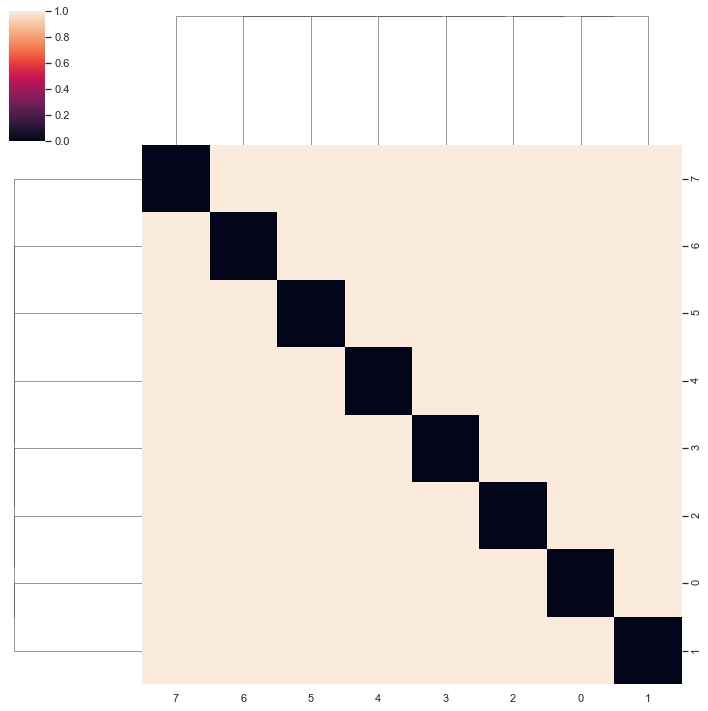

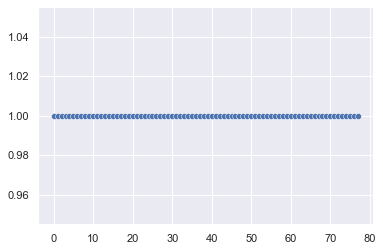

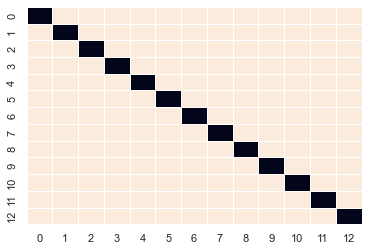

<Figure size 432x288 with 0 Axes>

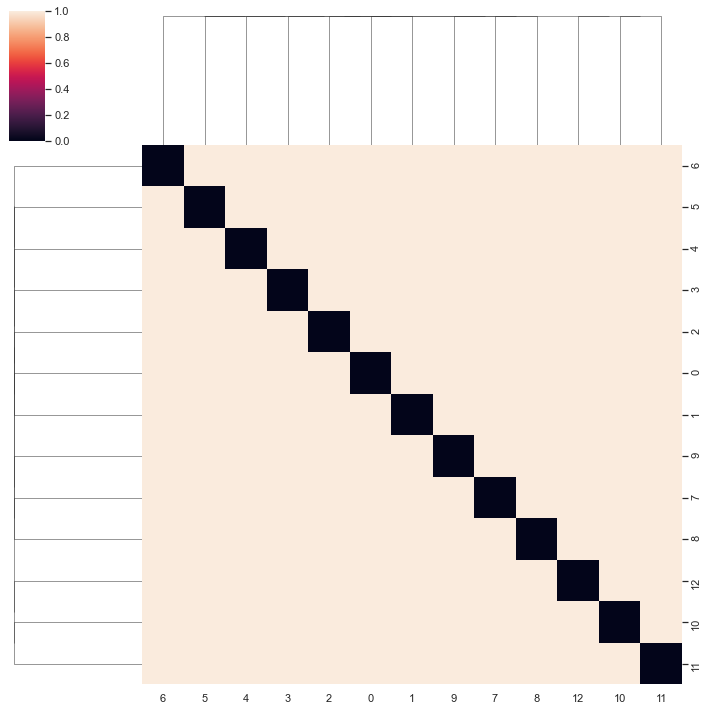

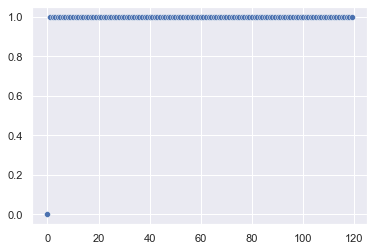

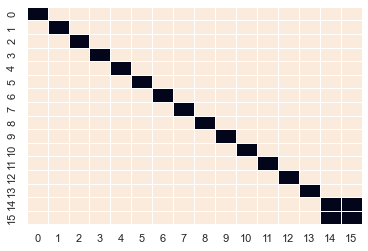

<Figure size 432x288 with 0 Axes>

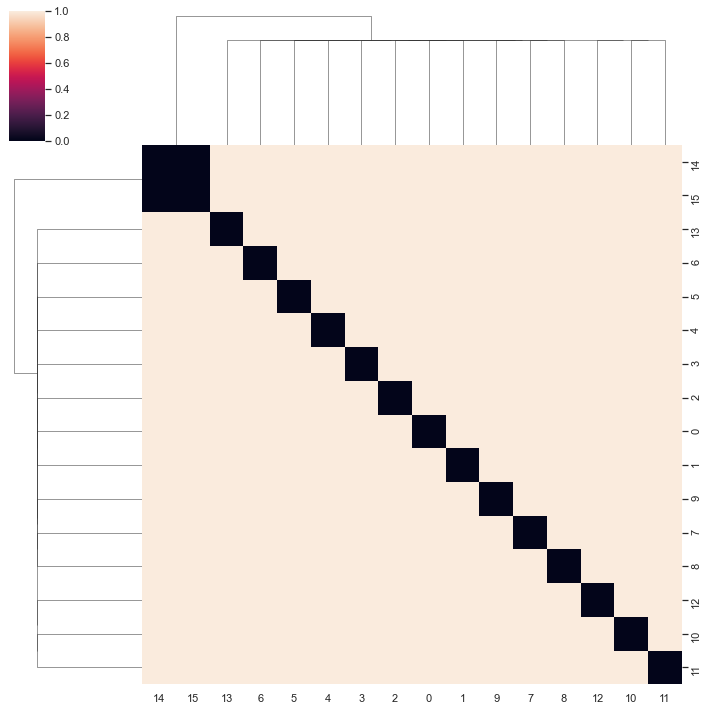

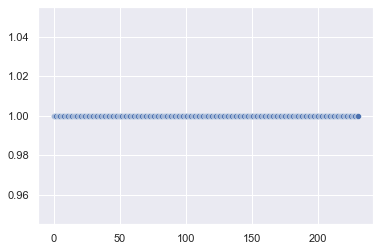

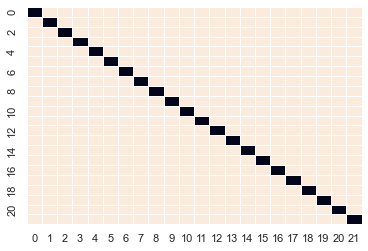

<Figure size 432x288 with 0 Axes>

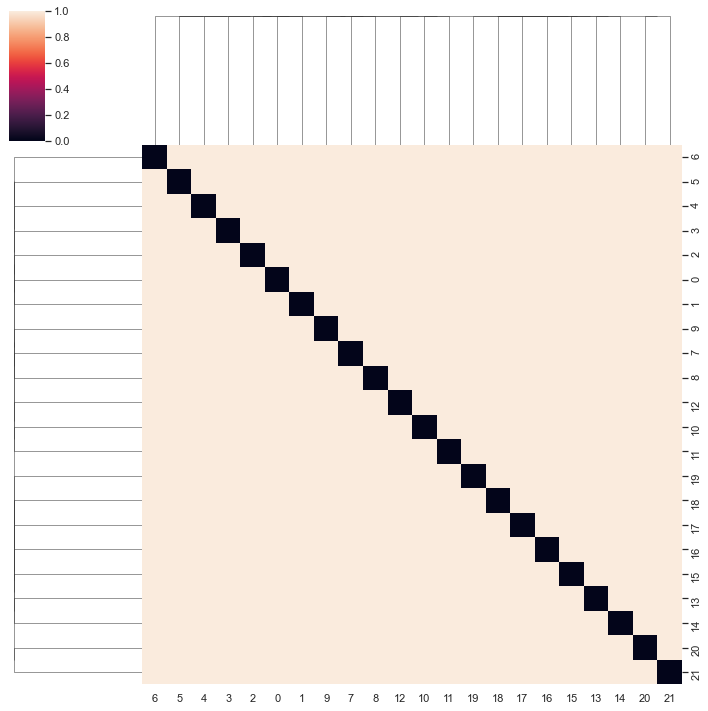

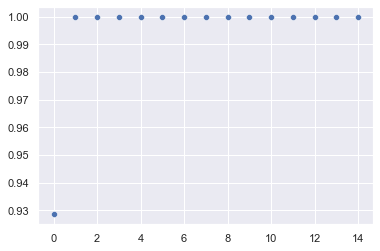

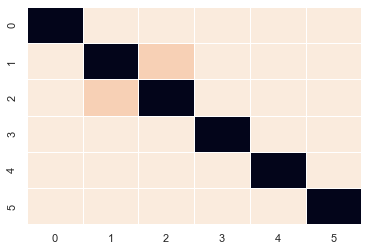

<Figure size 432x288 with 0 Axes>

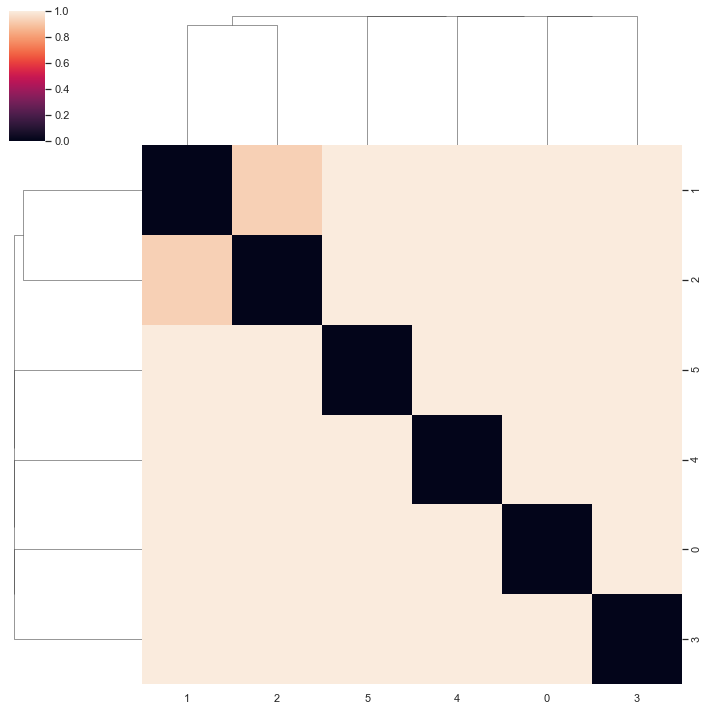

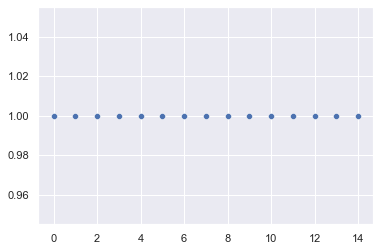

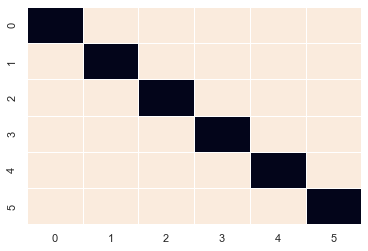

<Figure size 432x288 with 0 Axes>

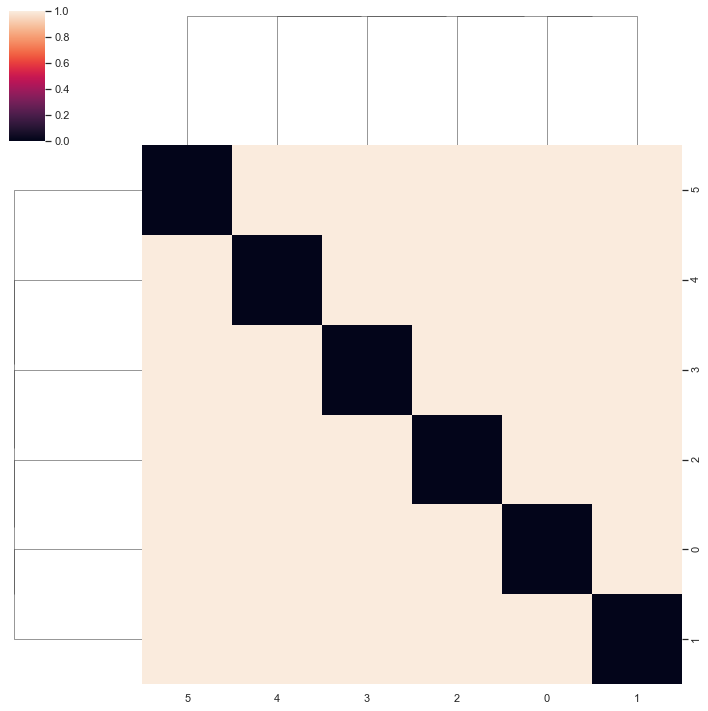

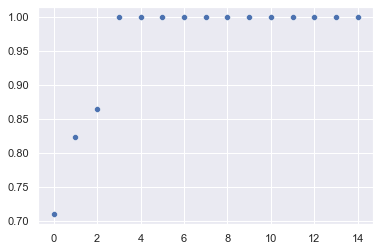

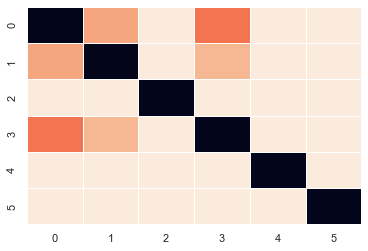

<Figure size 432x288 with 0 Axes>

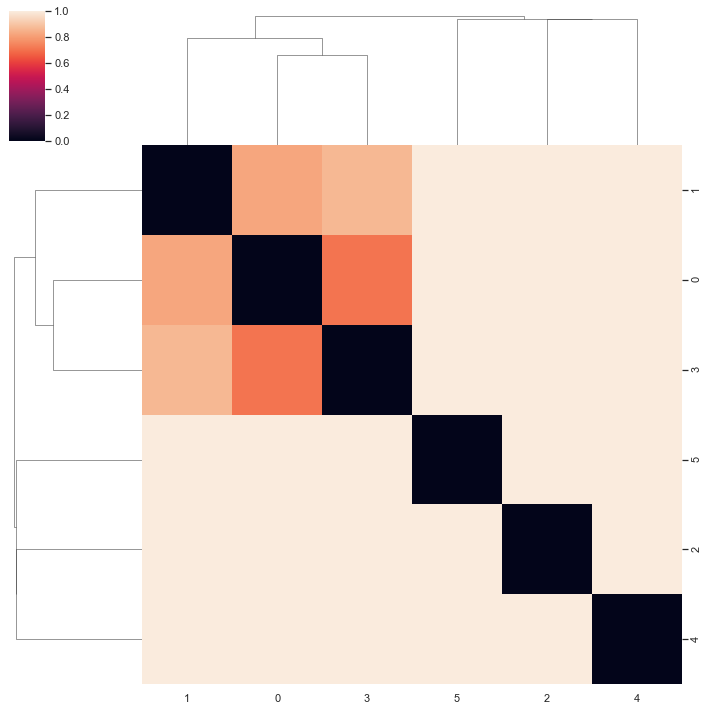

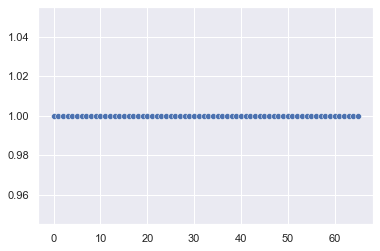

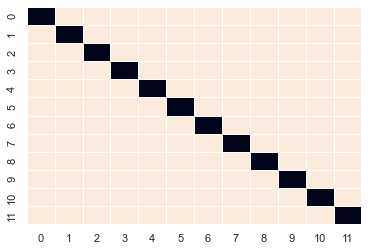

<Figure size 432x288 with 0 Axes>

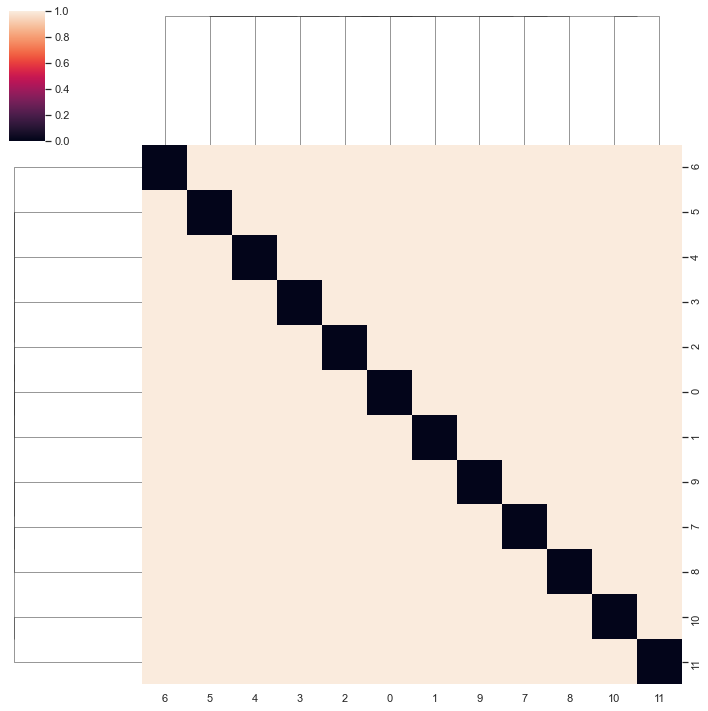

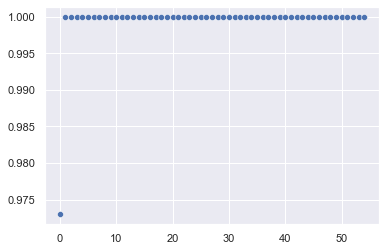

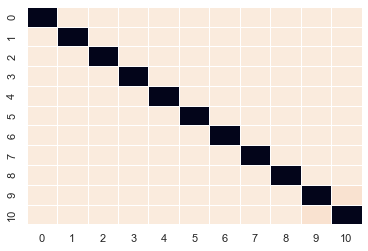

<Figure size 432x288 with 0 Axes>

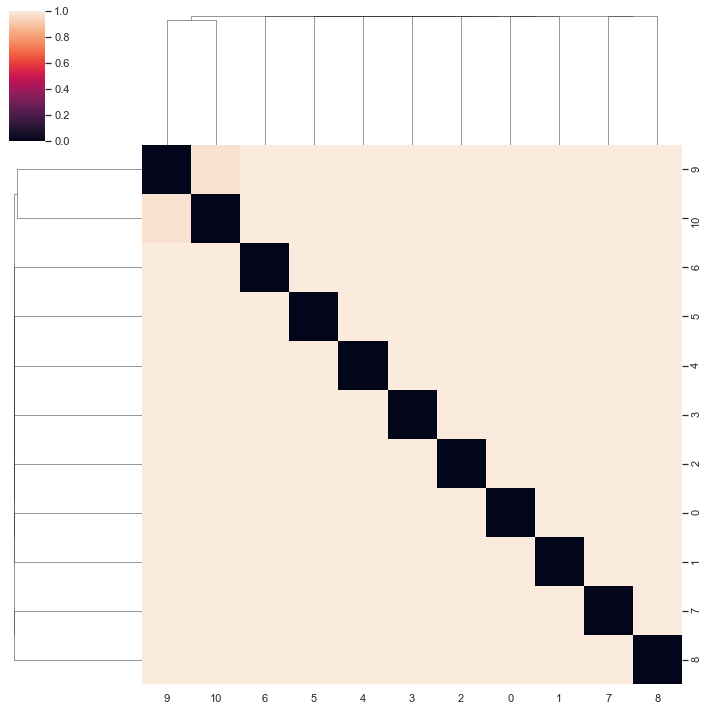

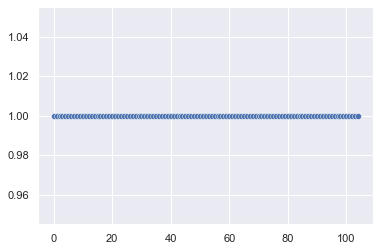

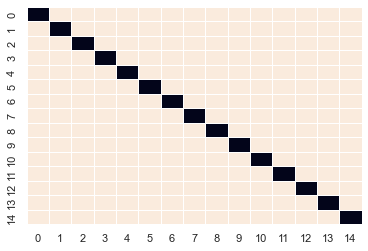

<Figure size 432x288 with 0 Axes>

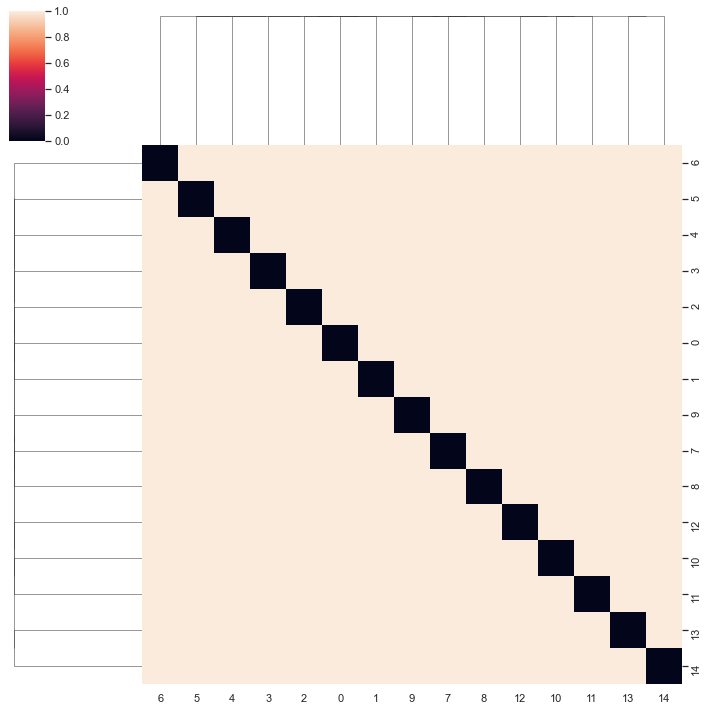

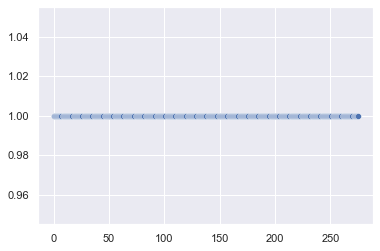

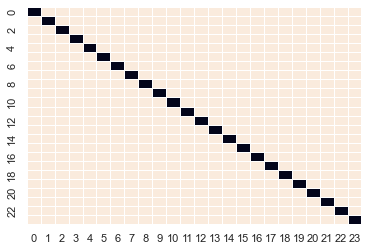

<Figure size 432x288 with 0 Axes>

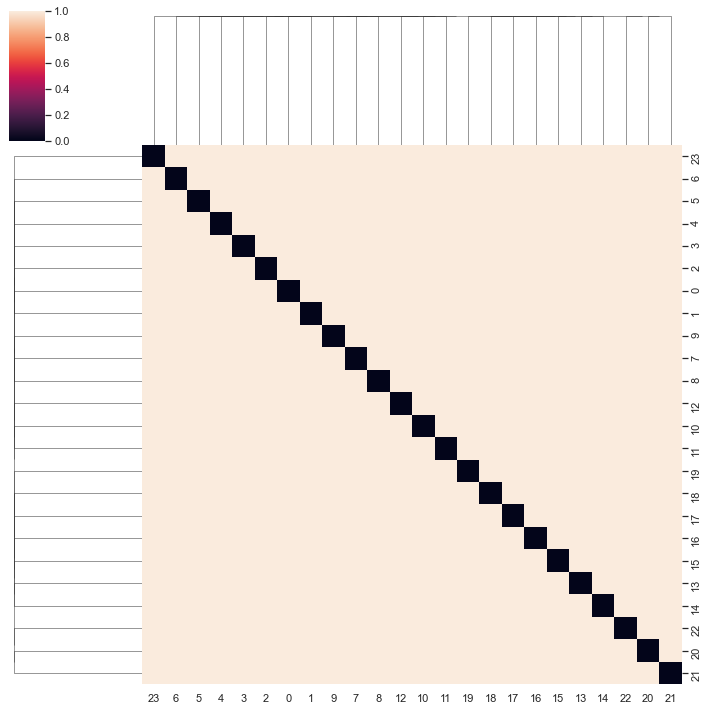

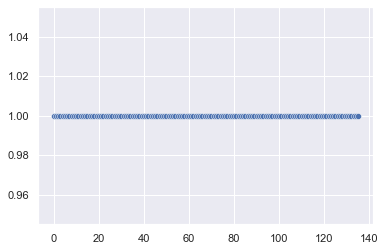

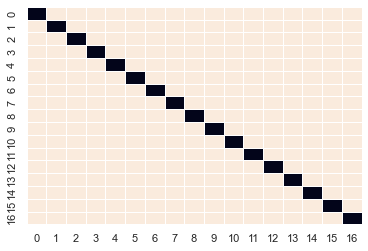

<Figure size 432x288 with 0 Axes>

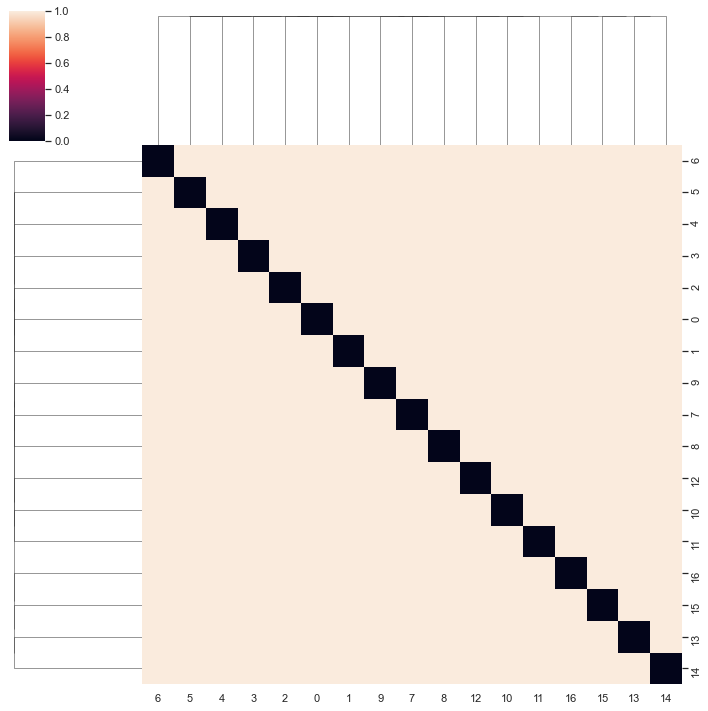

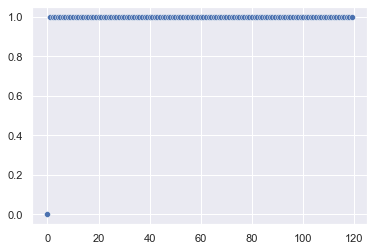

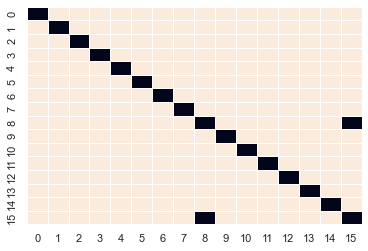

<Figure size 432x288 with 0 Axes>

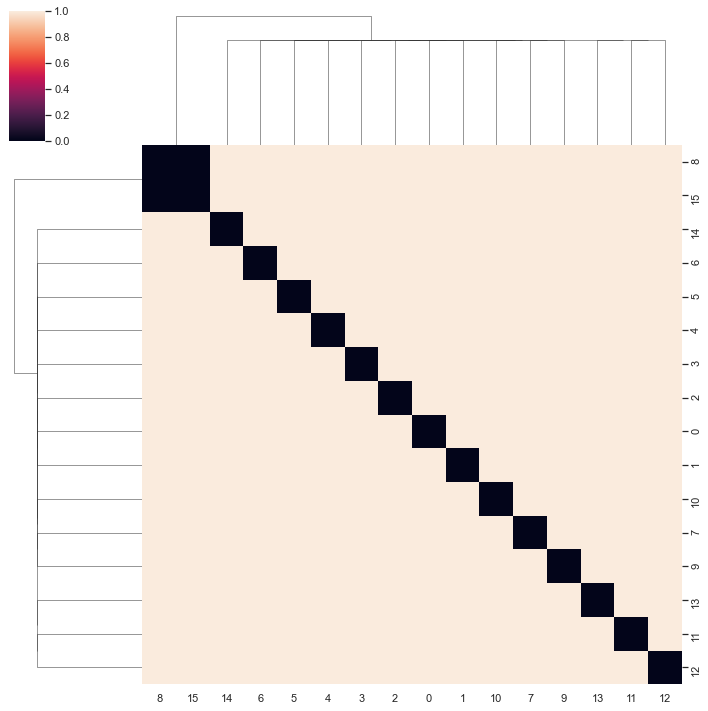

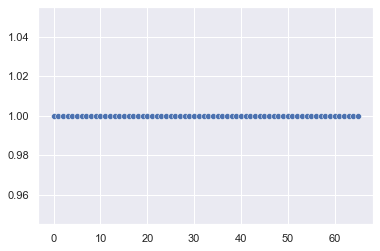

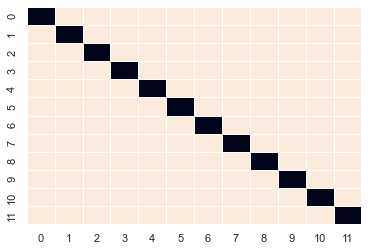

<Figure size 432x288 with 0 Axes>

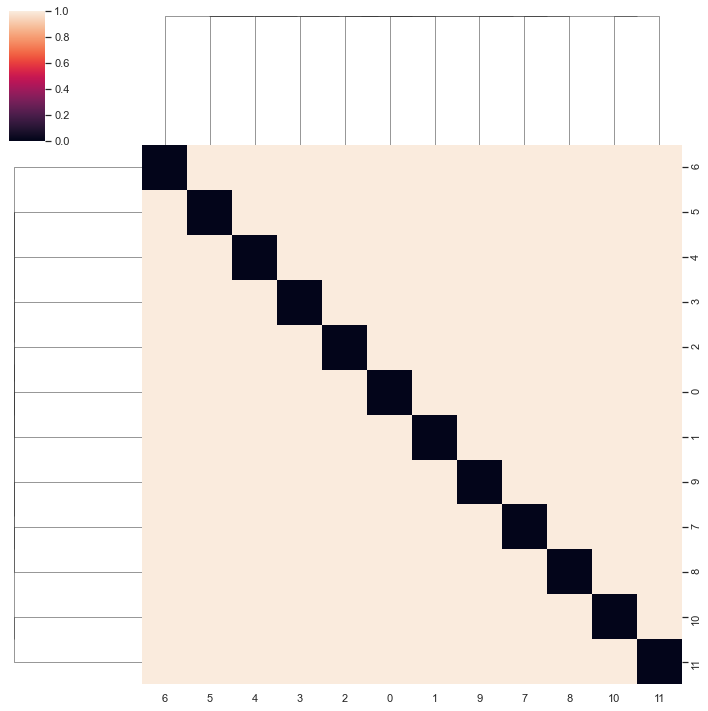

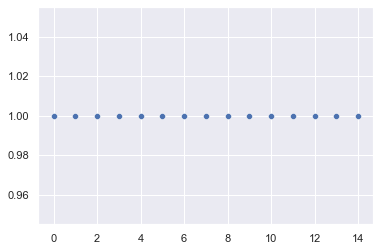

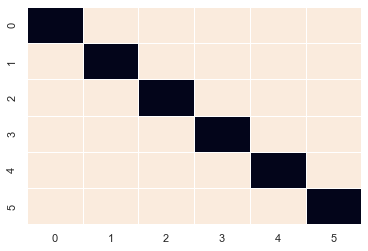

<Figure size 432x288 with 0 Axes>

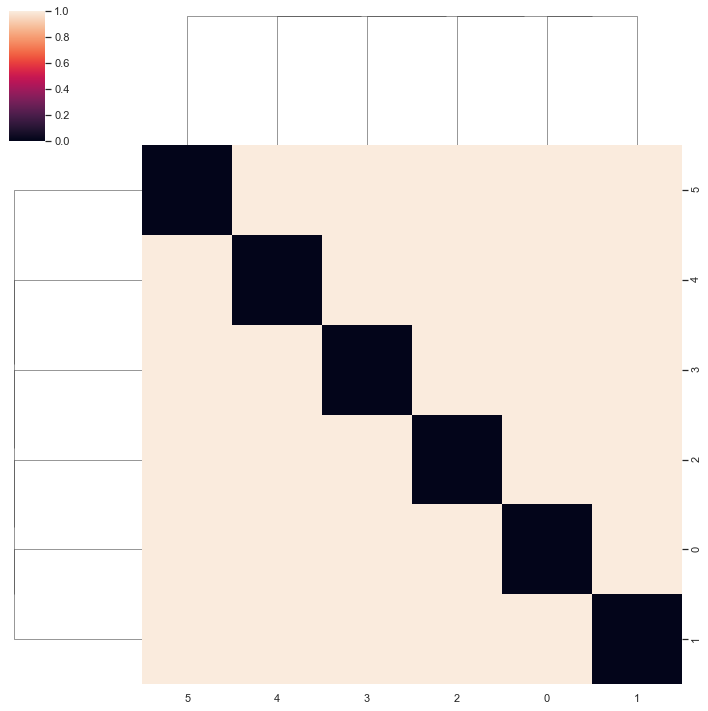

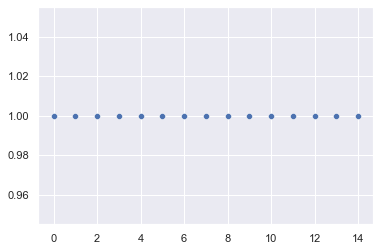

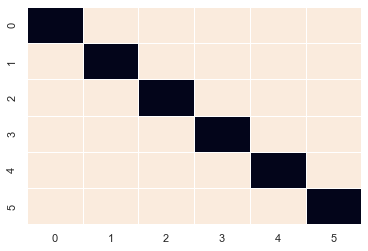

<Figure size 432x288 with 0 Axes>

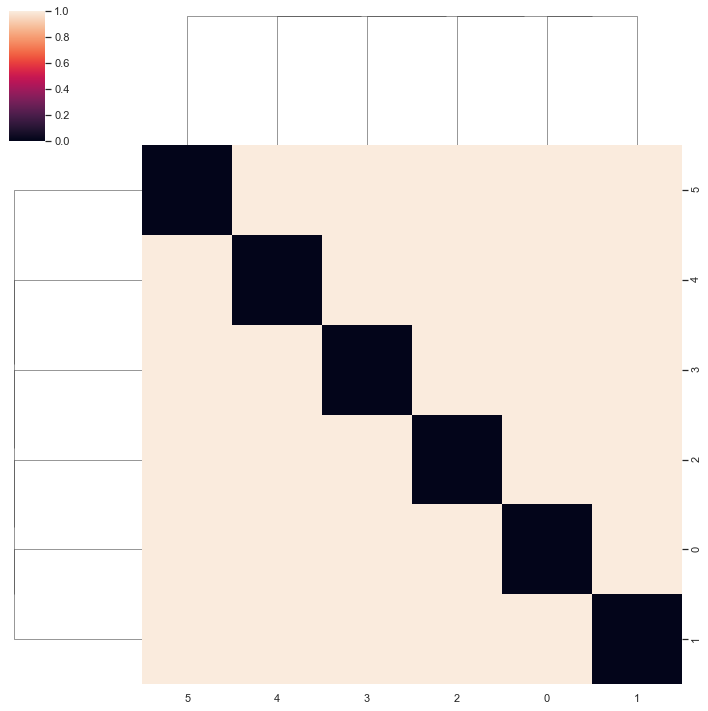

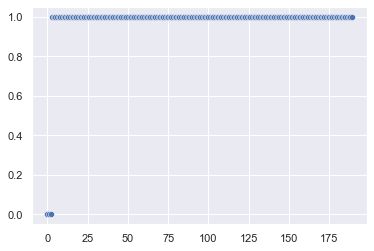

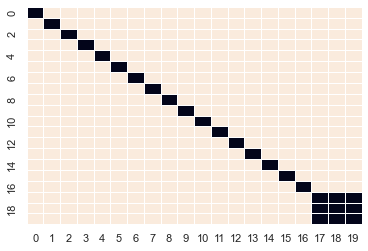

<Figure size 432x288 with 0 Axes>

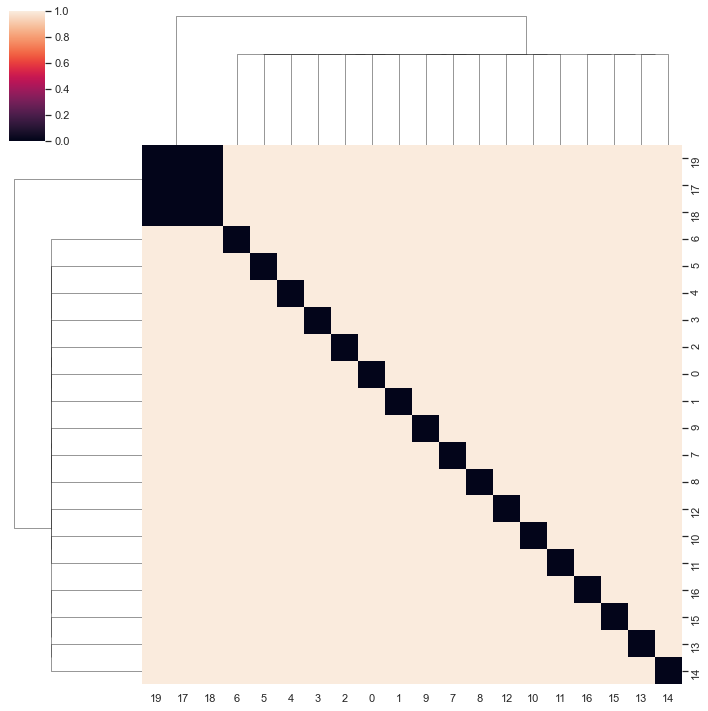

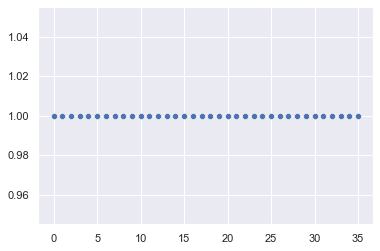

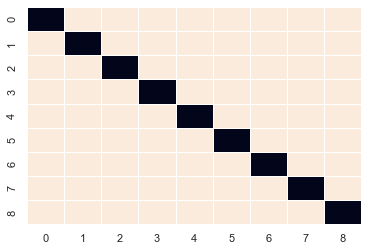

<Figure size 432x288 with 0 Axes>

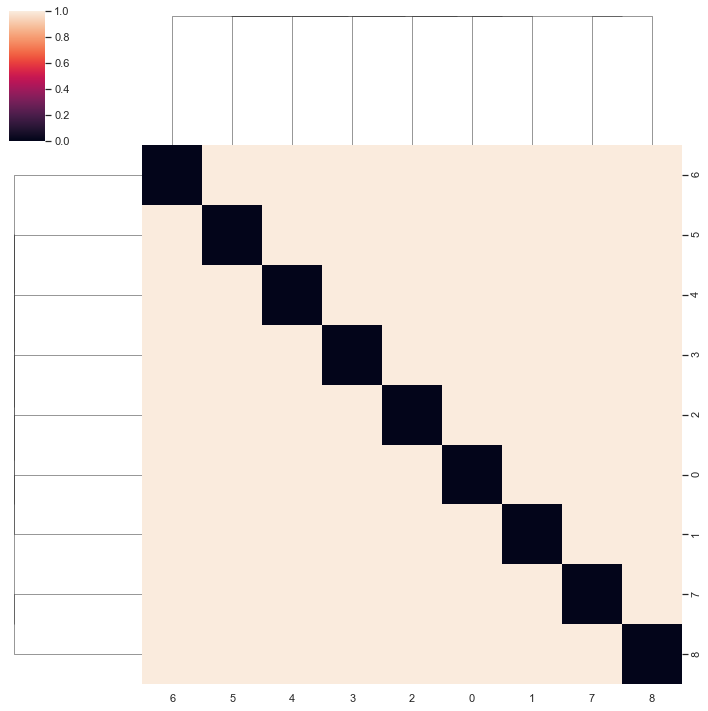

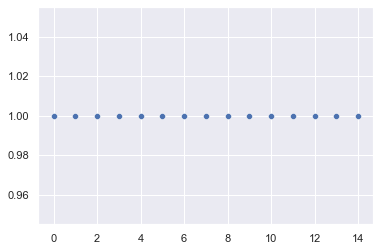

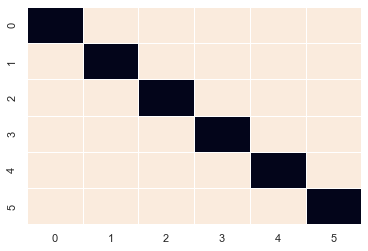

<Figure size 432x288 with 0 Axes>

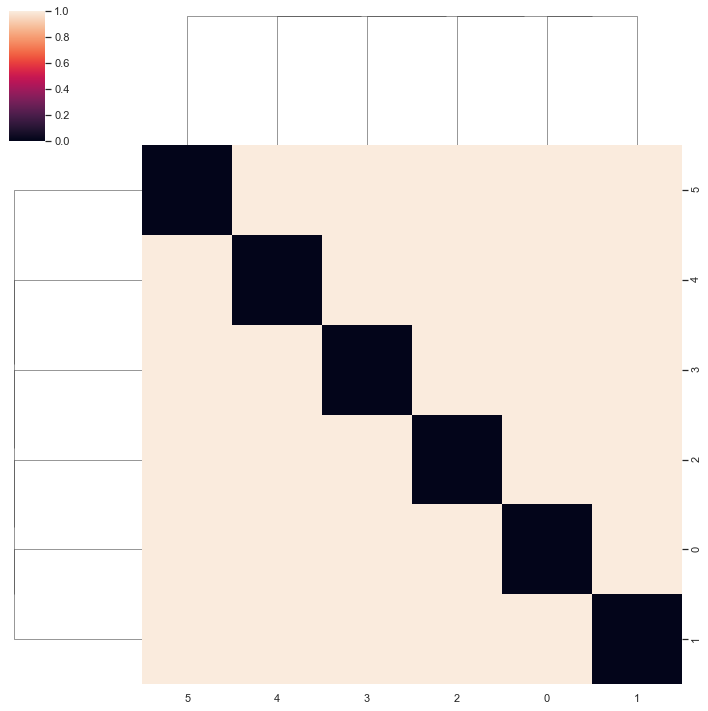

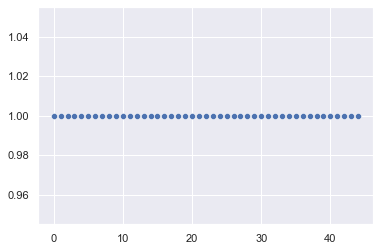

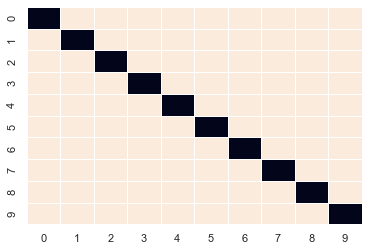

<Figure size 432x288 with 0 Axes>

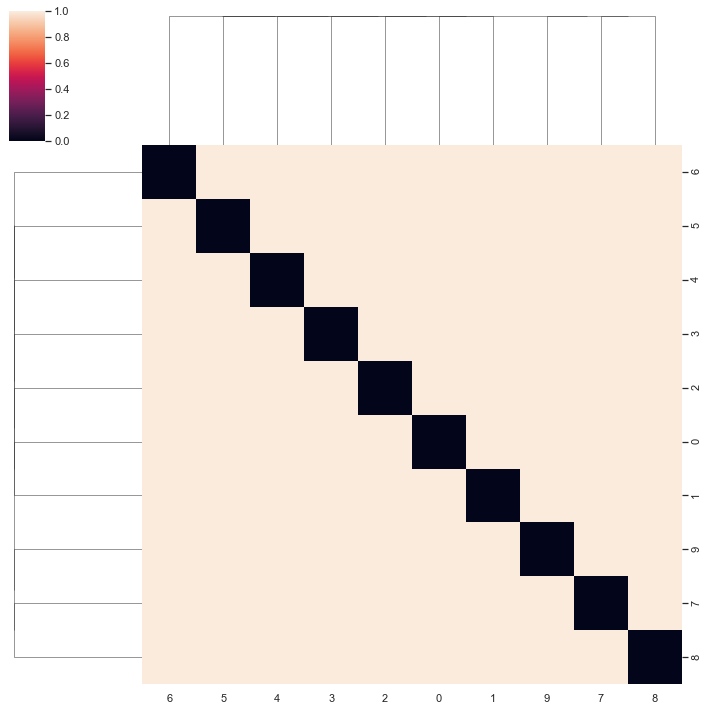

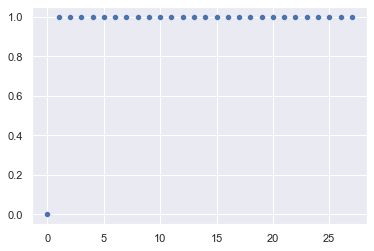

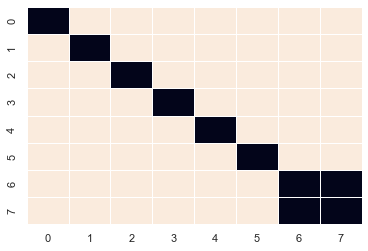

<Figure size 432x288 with 0 Axes>

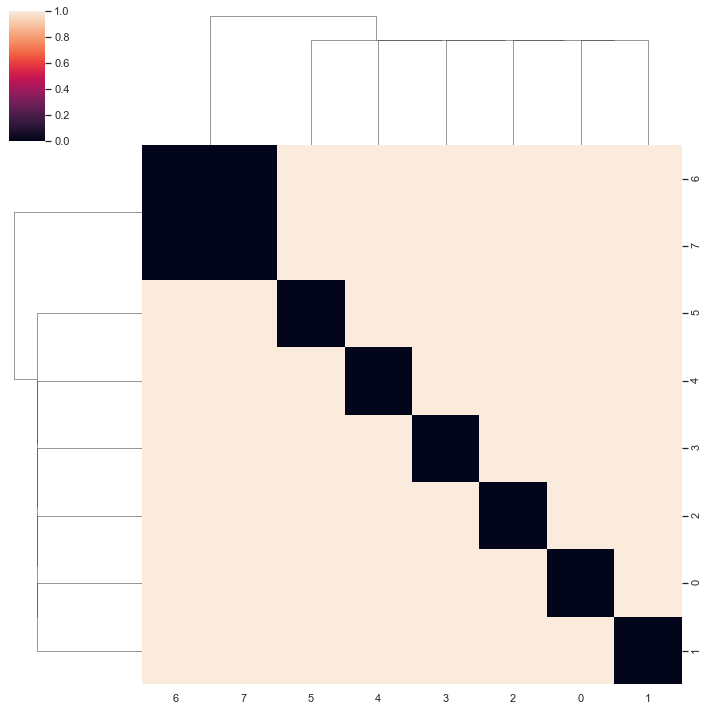

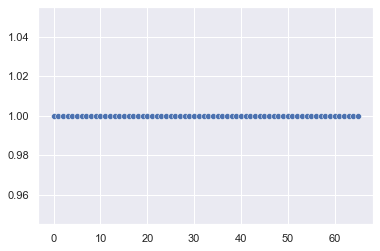

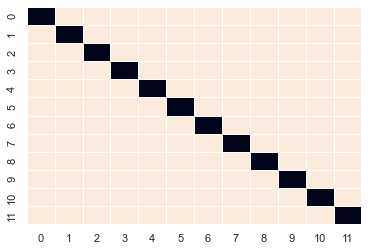

<Figure size 432x288 with 0 Axes>

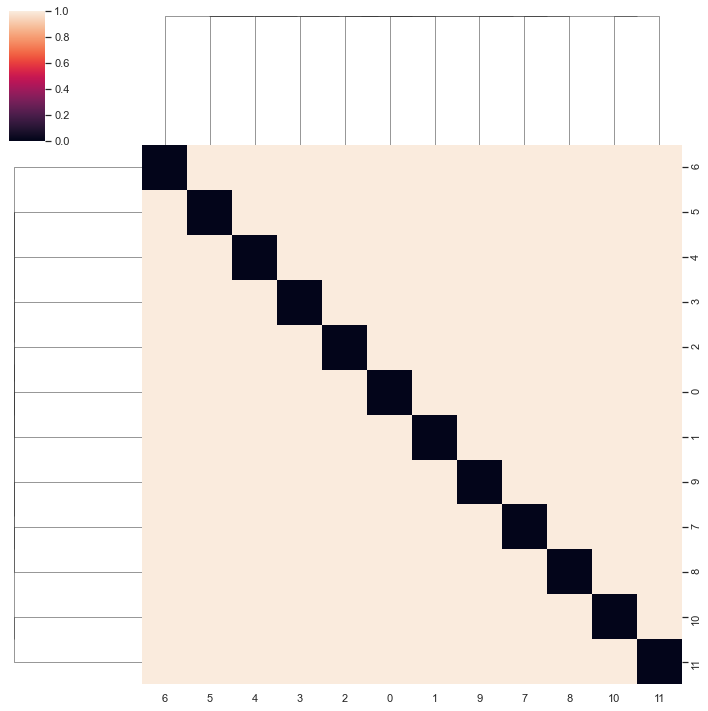

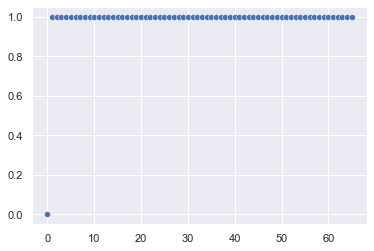

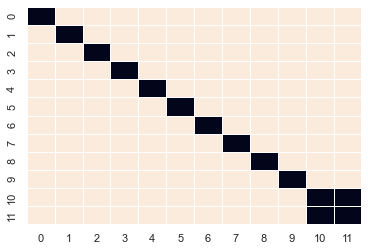

<Figure size 432x288 with 0 Axes>

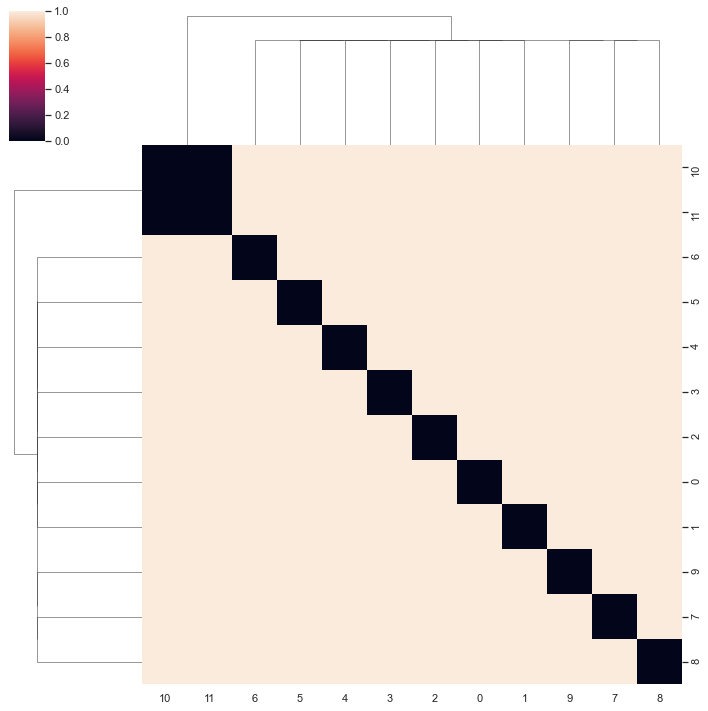

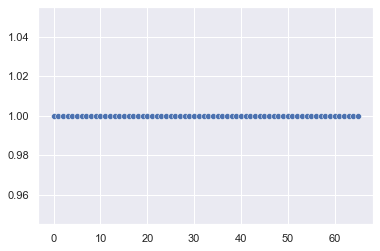

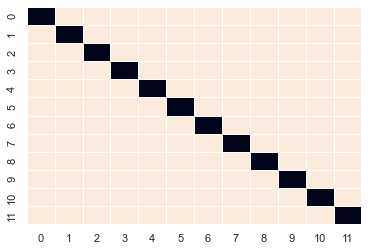

<Figure size 432x288 with 0 Axes>

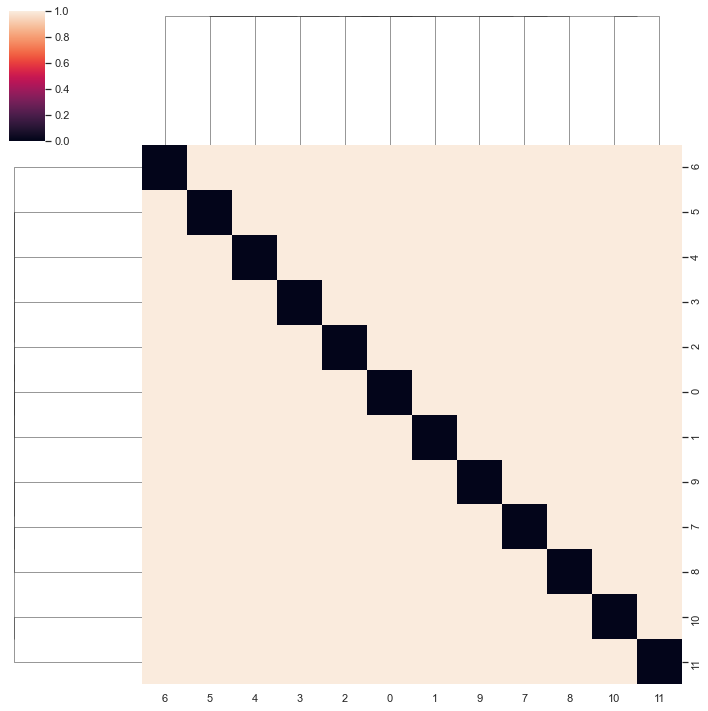

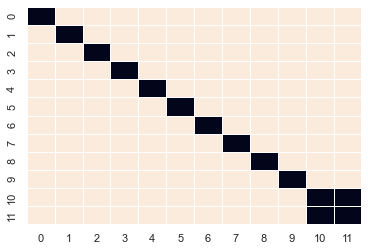

<Figure size 432x288 with 0 Axes>

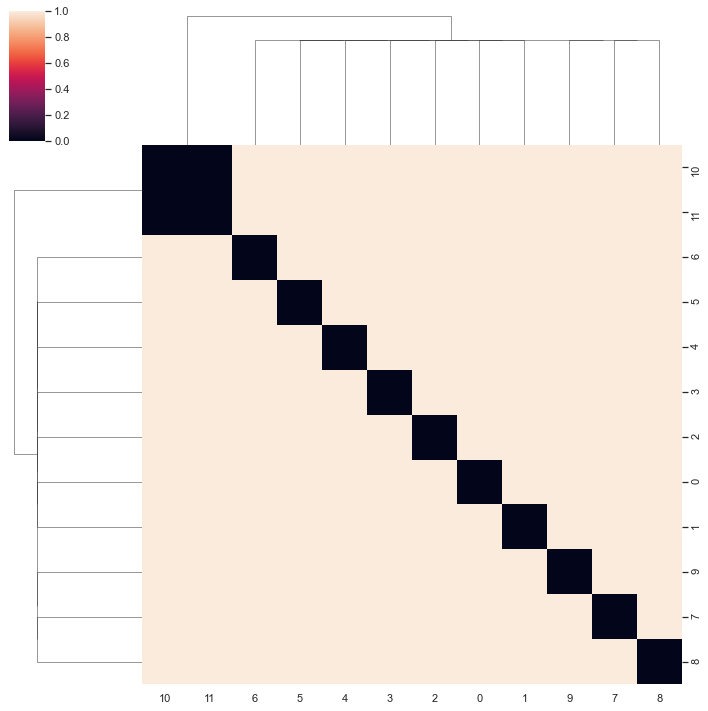

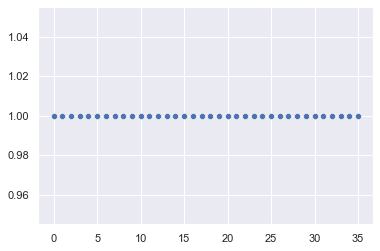

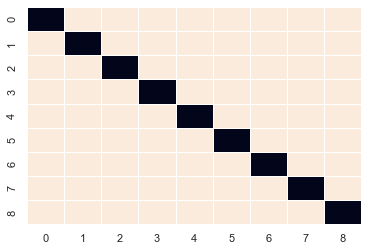

<Figure size 432x288 with 0 Axes>

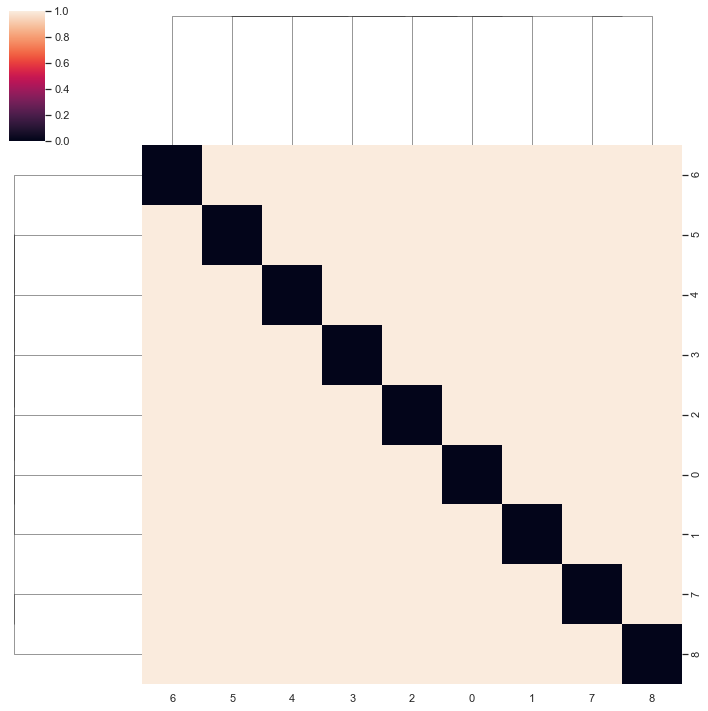

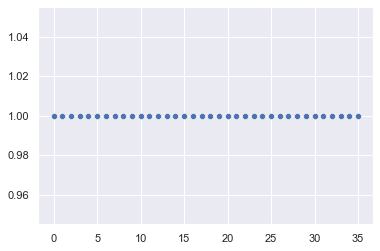

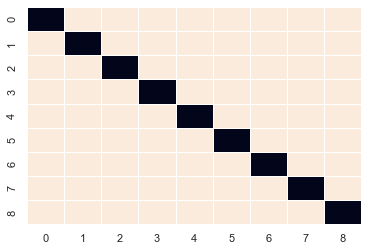

<Figure size 432x288 with 0 Axes>

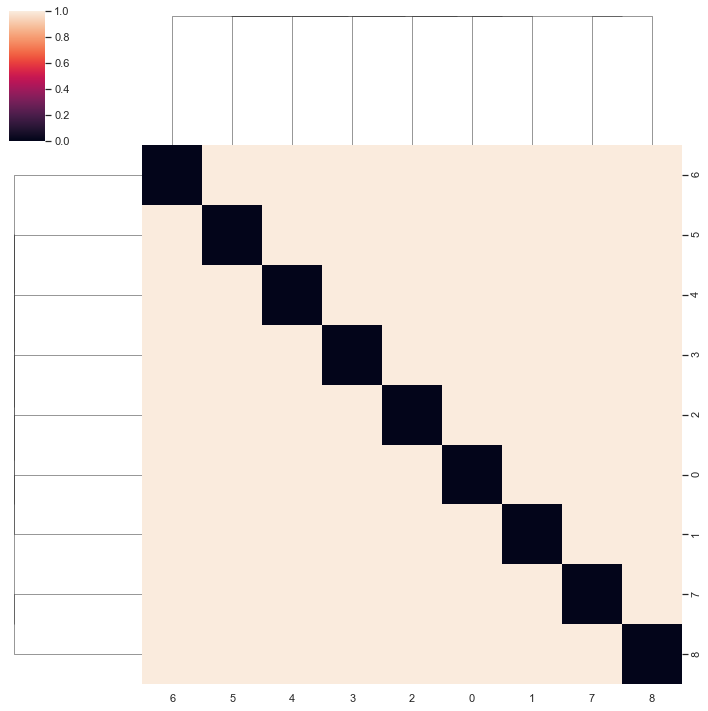

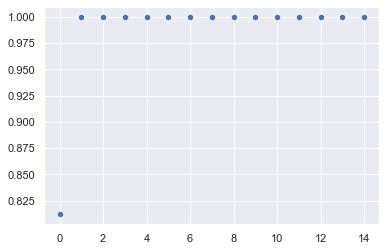

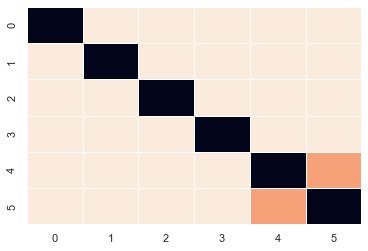

<Figure size 432x288 with 0 Axes>

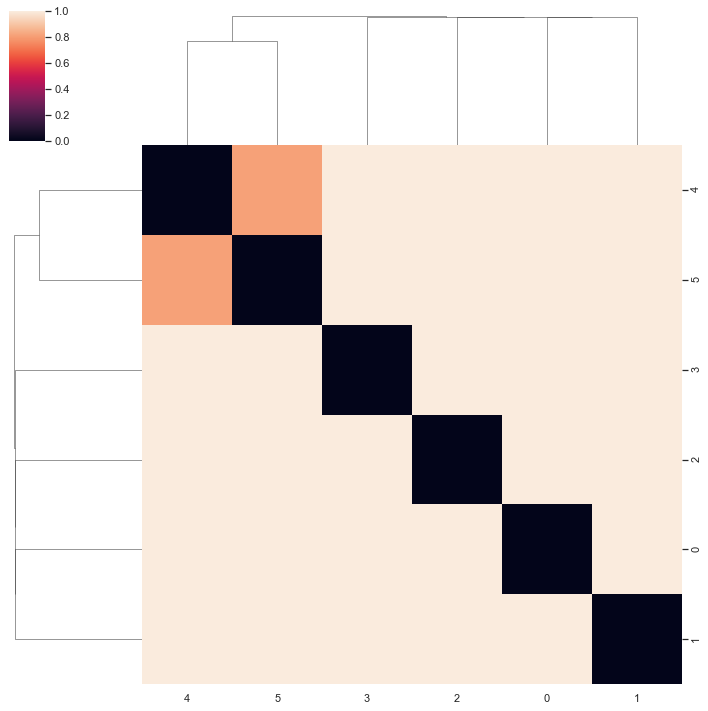

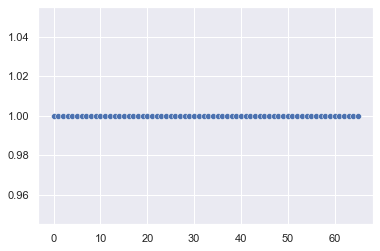

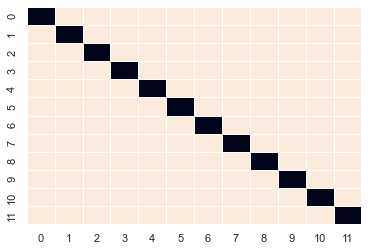

<Figure size 432x288 with 0 Axes>

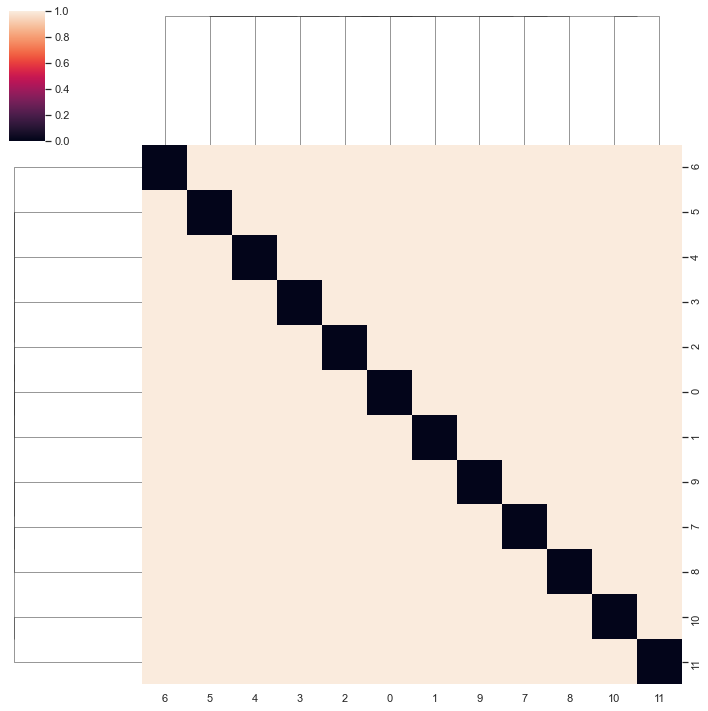

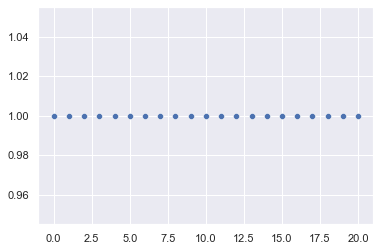

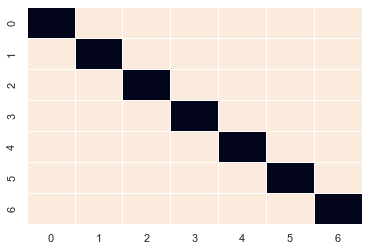

<Figure size 432x288 with 0 Axes>

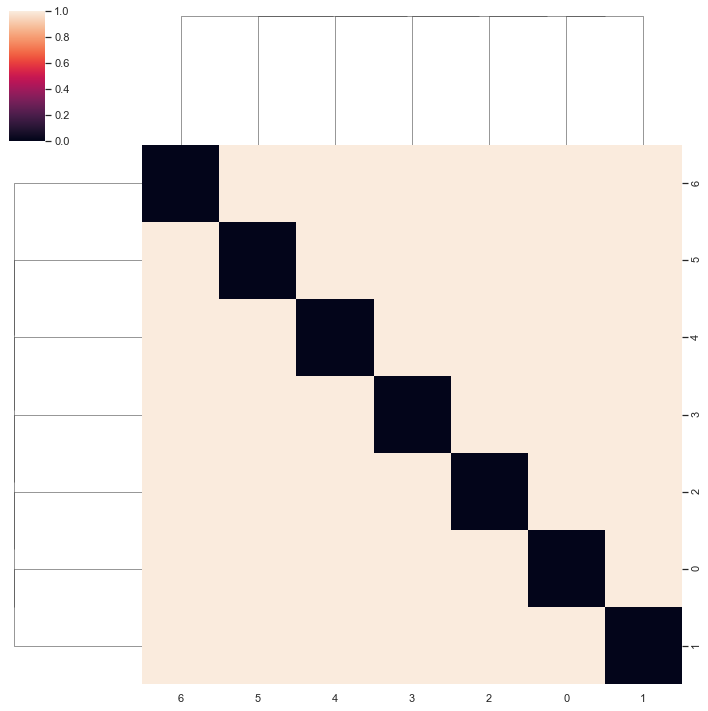

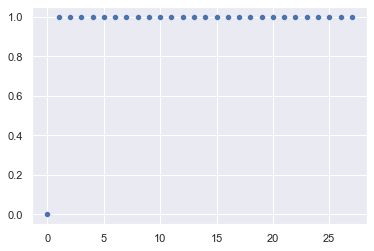

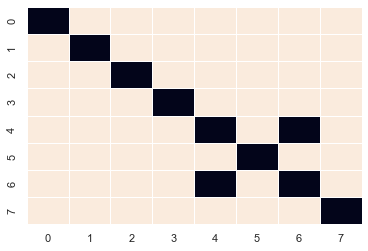

<Figure size 432x288 with 0 Axes>

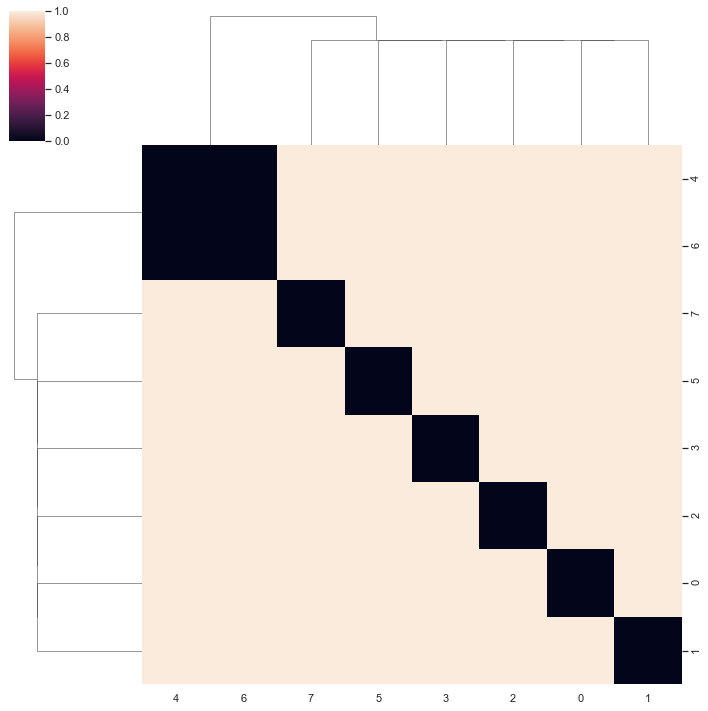

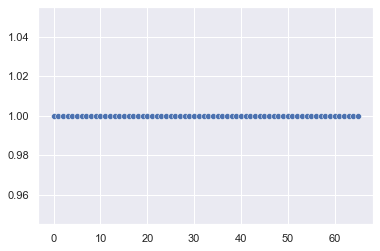

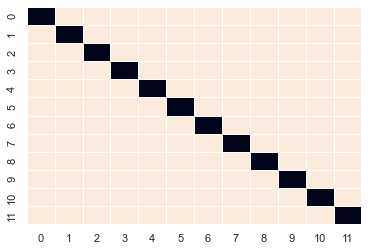

<Figure size 432x288 with 0 Axes>

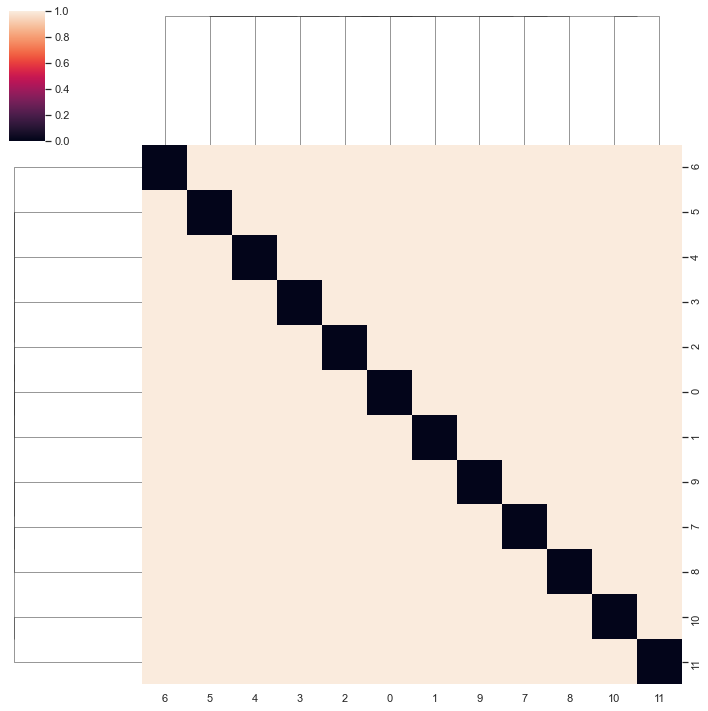

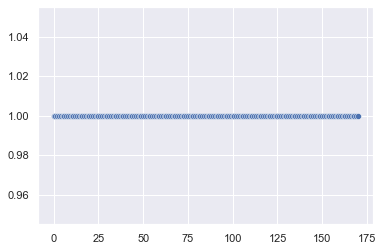

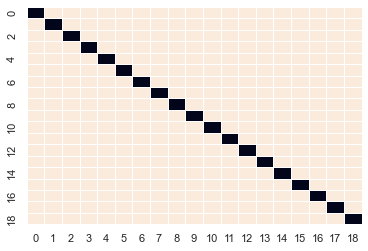

<Figure size 432x288 with 0 Axes>

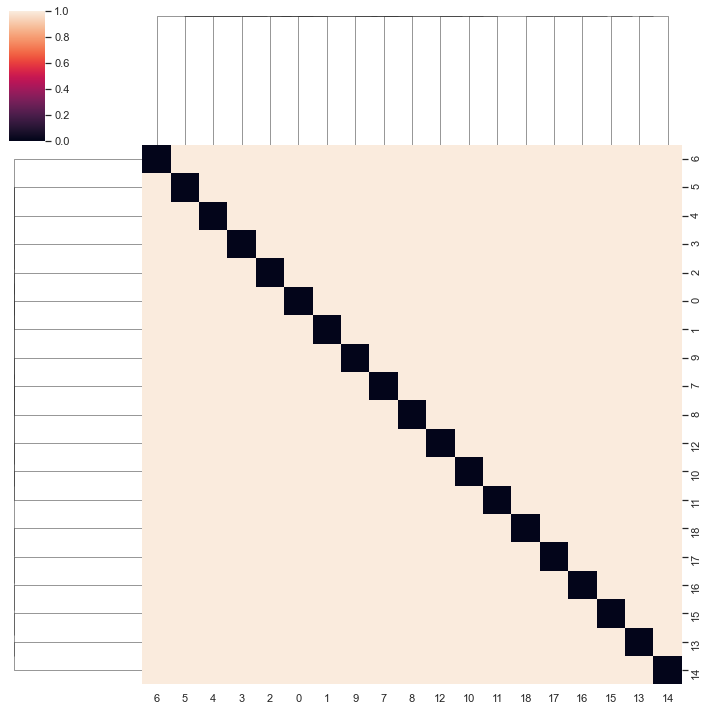

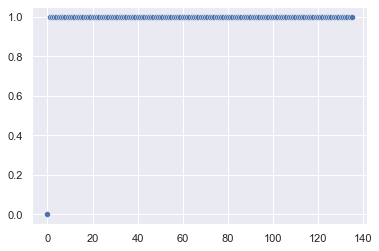

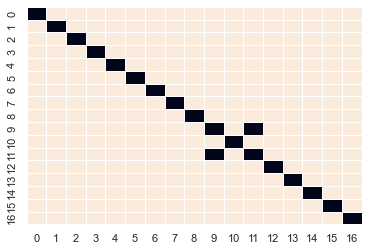

<Figure size 432x288 with 0 Axes>

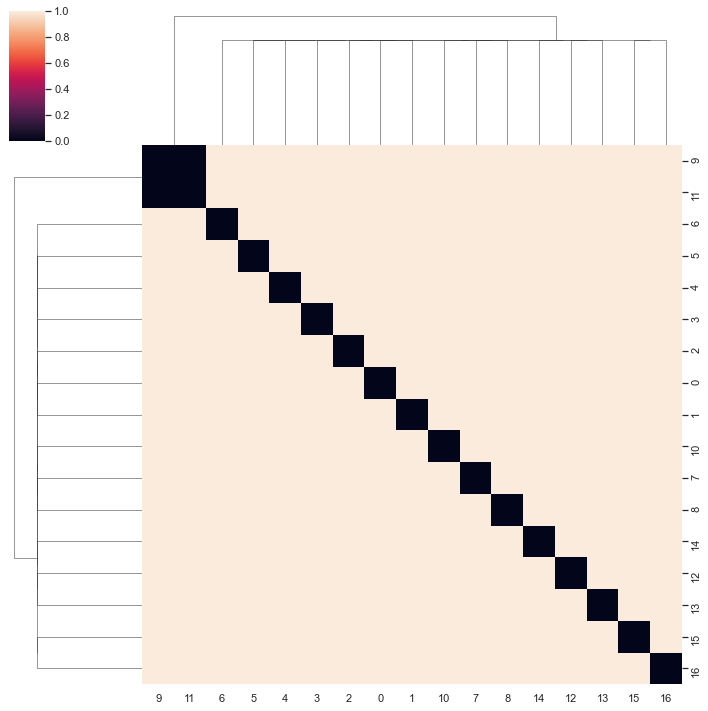

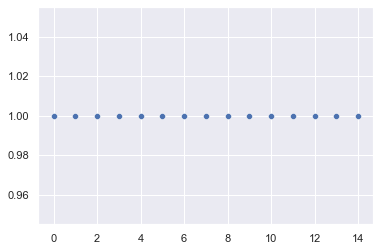

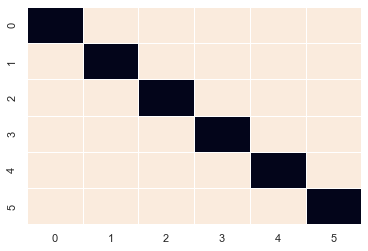

<Figure size 432x288 with 0 Axes>

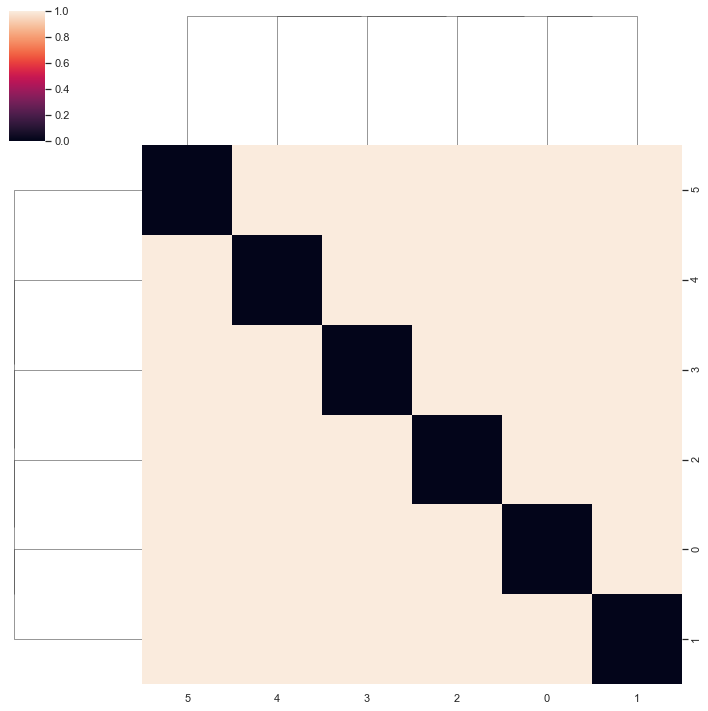

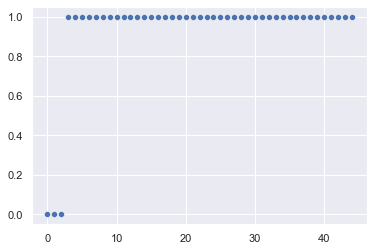

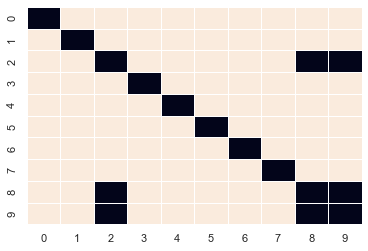

<Figure size 432x288 with 0 Axes>

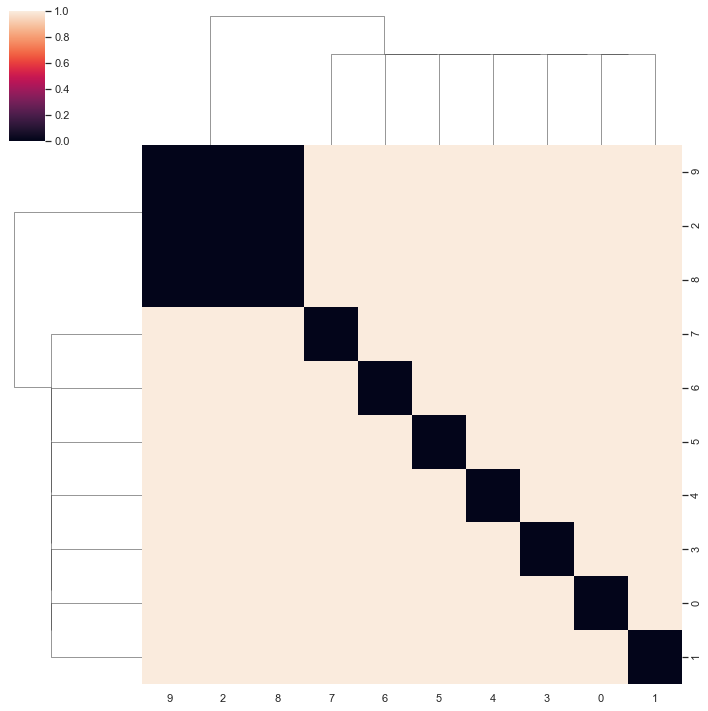

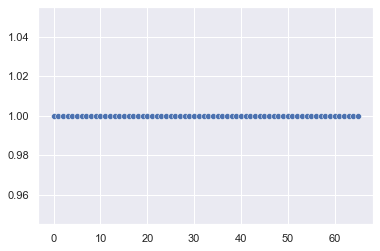

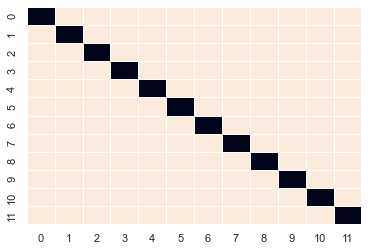

<Figure size 432x288 with 0 Axes>

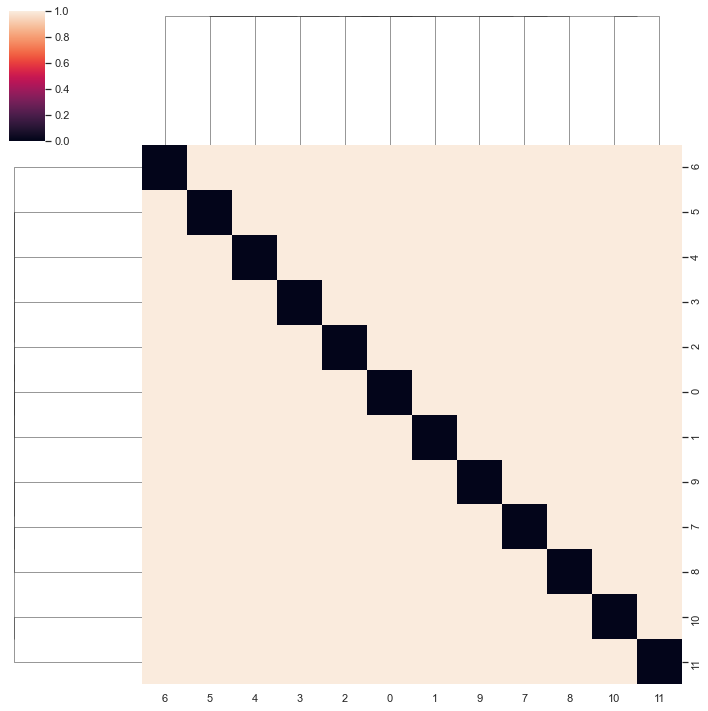

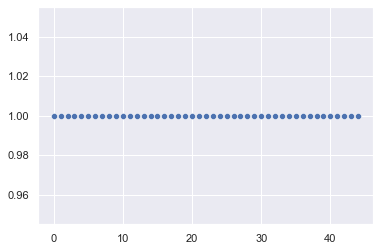

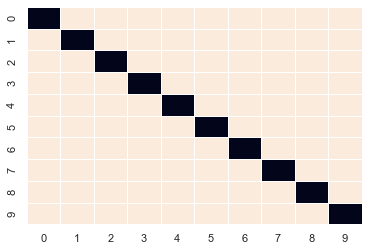

<Figure size 432x288 with 0 Axes>

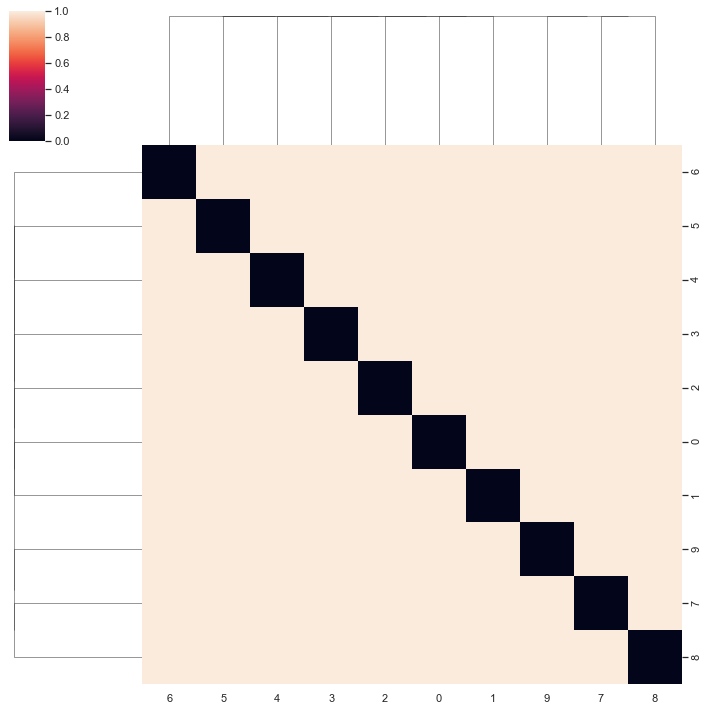

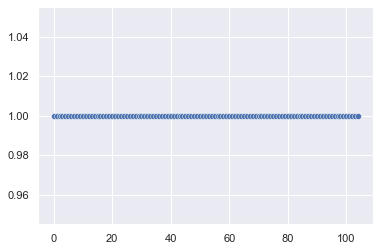

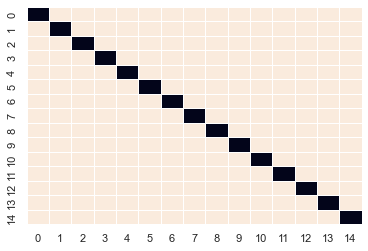

<Figure size 432x288 with 0 Axes>

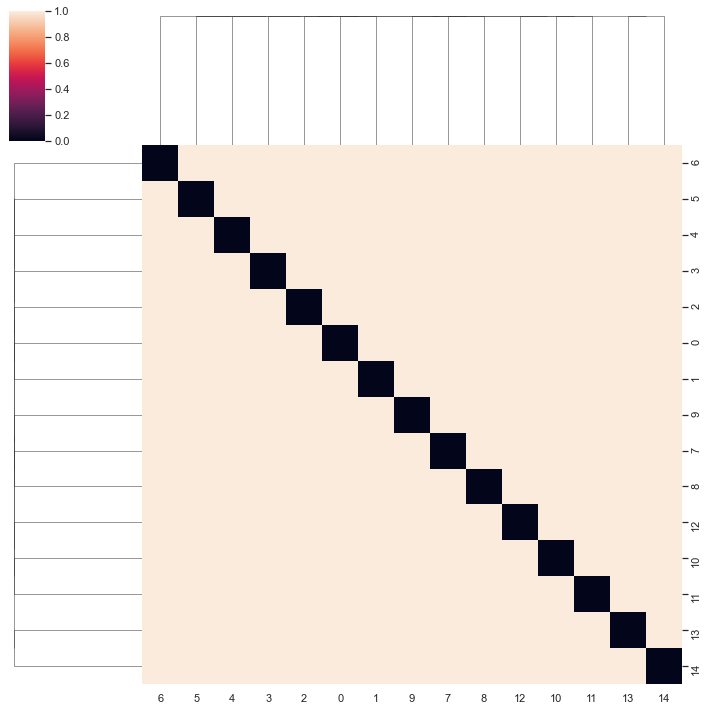

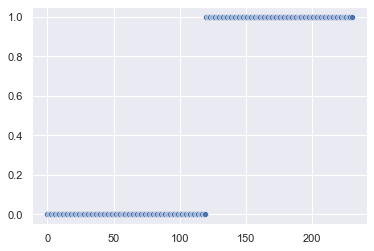

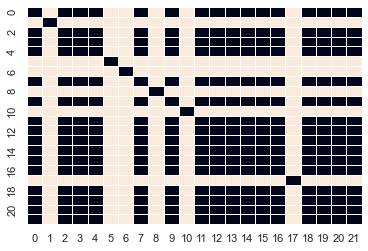

<Figure size 432x288 with 0 Axes>

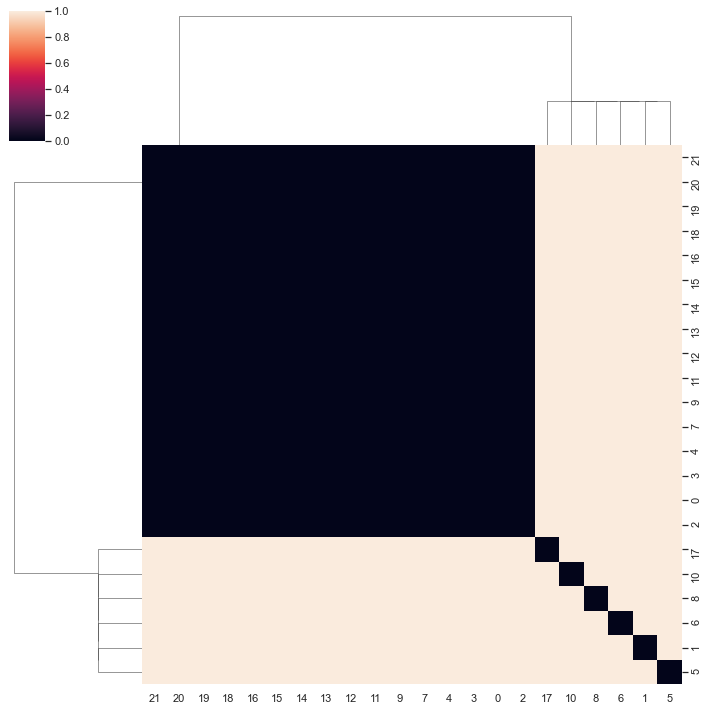

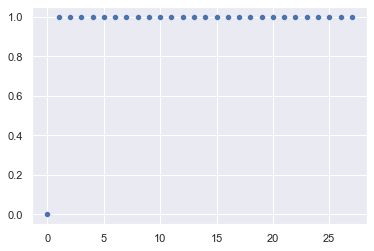

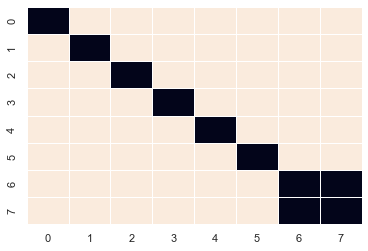

<Figure size 432x288 with 0 Axes>

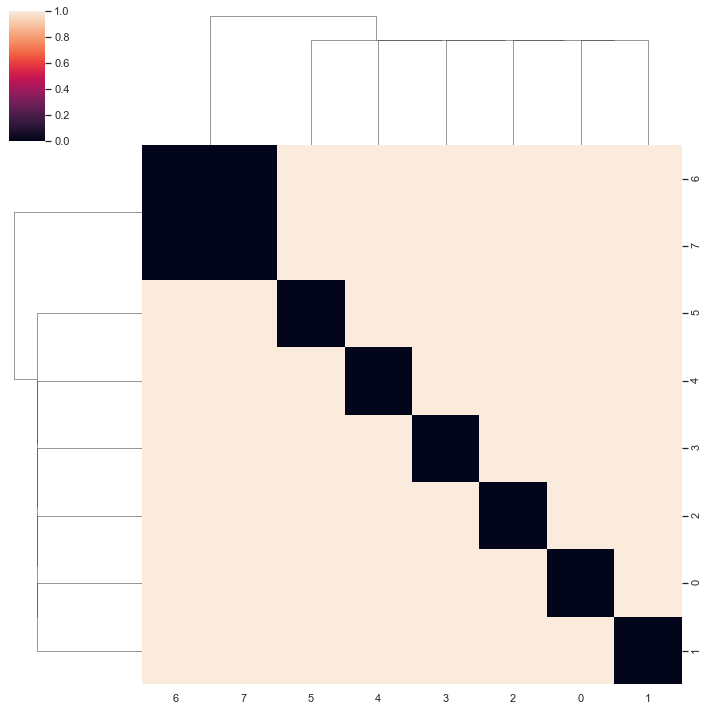

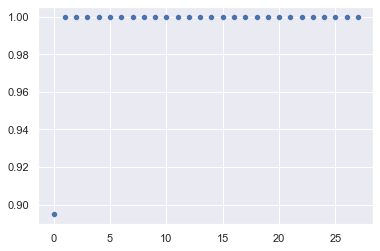

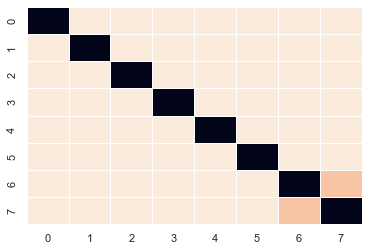

<Figure size 432x288 with 0 Axes>

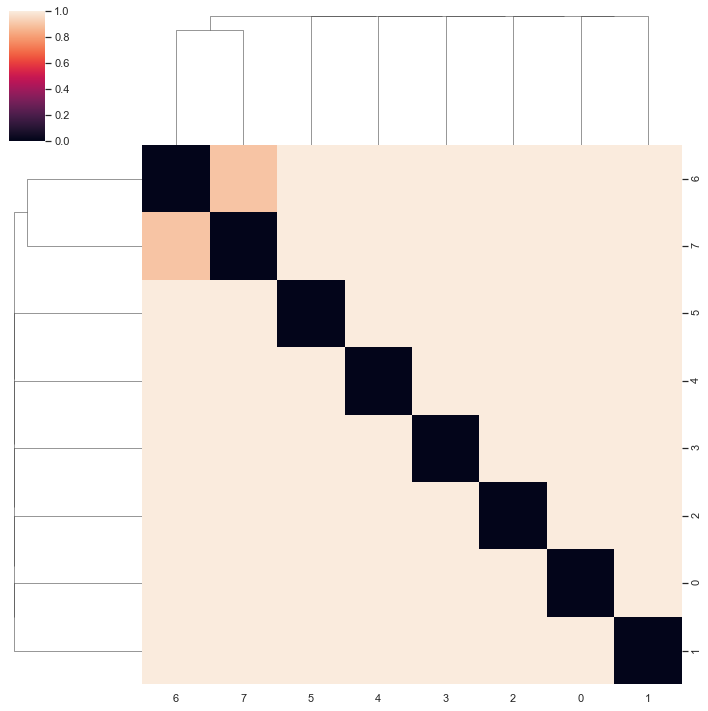

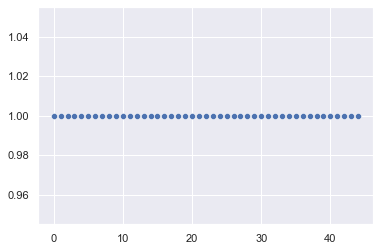

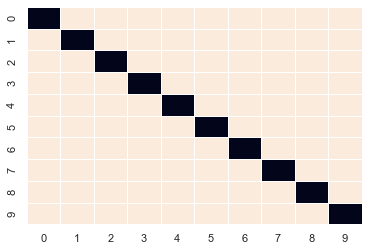

<Figure size 432x288 with 0 Axes>

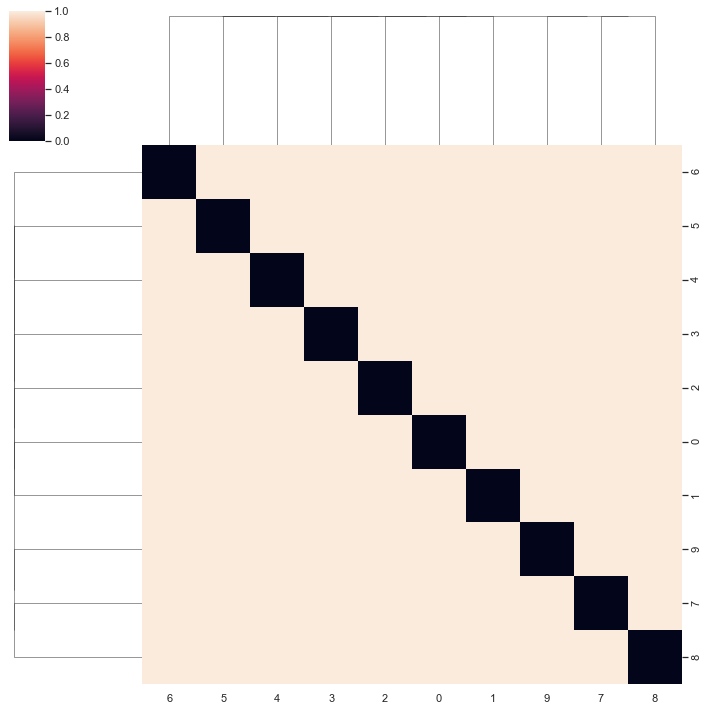

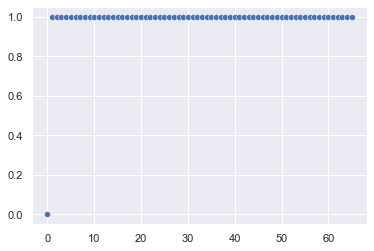

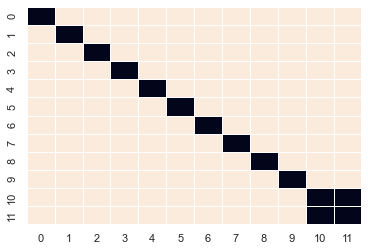

<Figure size 432x288 with 0 Axes>

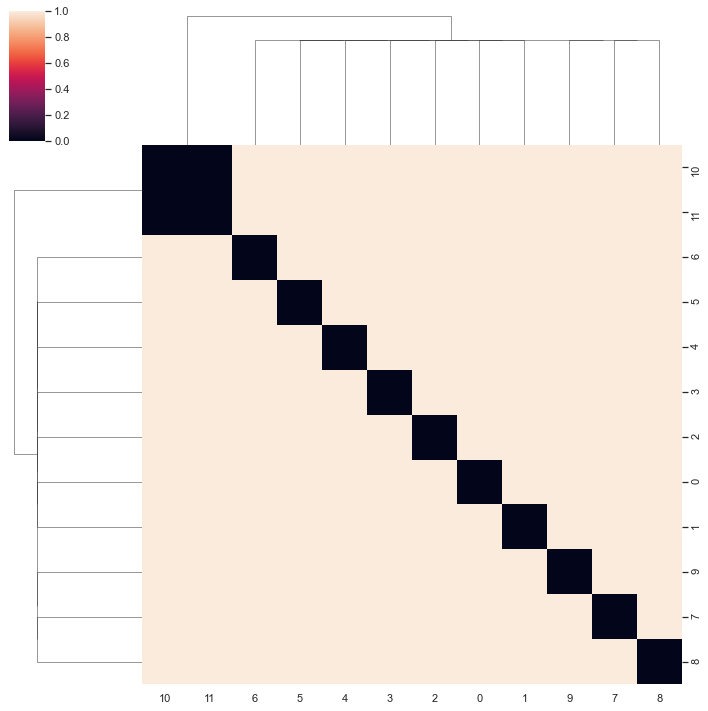

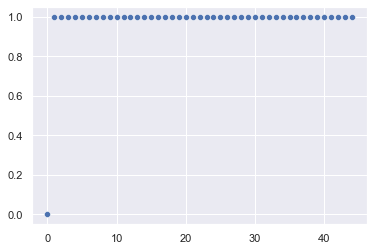

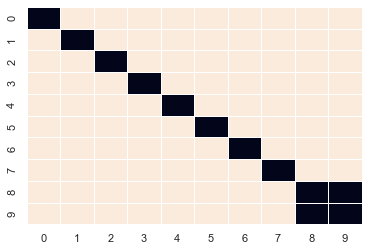

<Figure size 432x288 with 0 Axes>

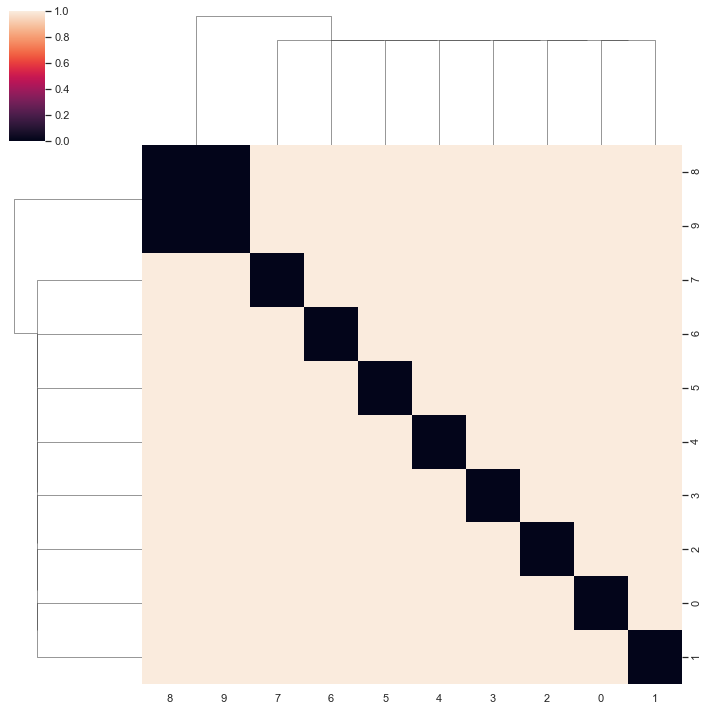

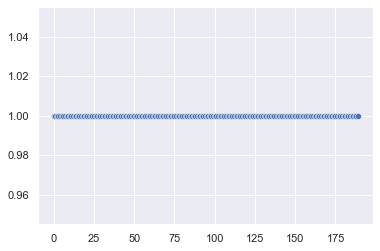

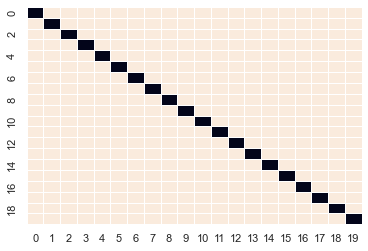

<Figure size 432x288 with 0 Axes>

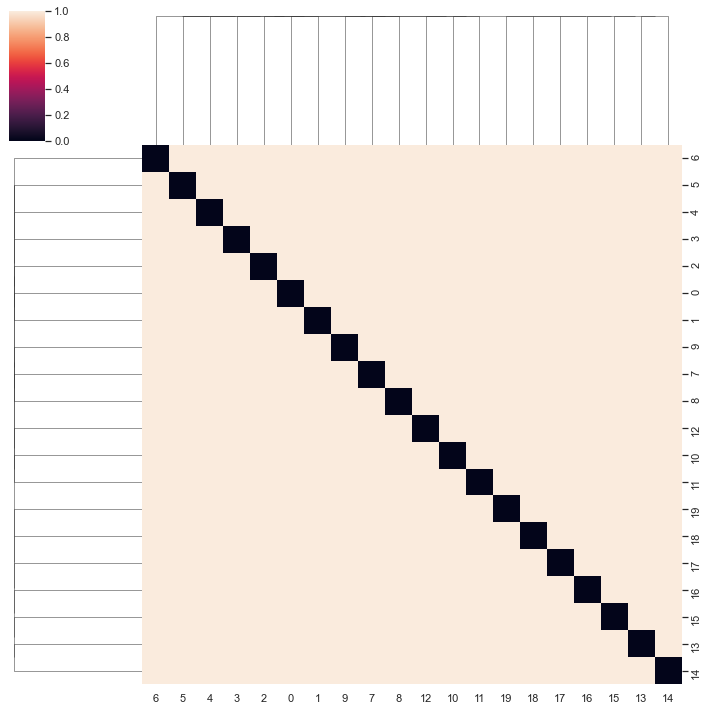

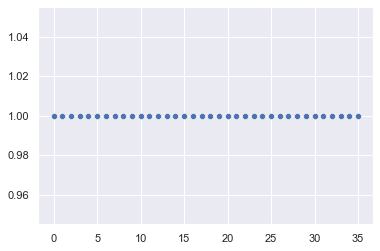

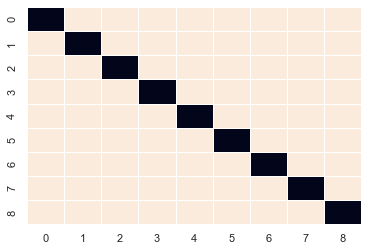

<Figure size 432x288 with 0 Axes>

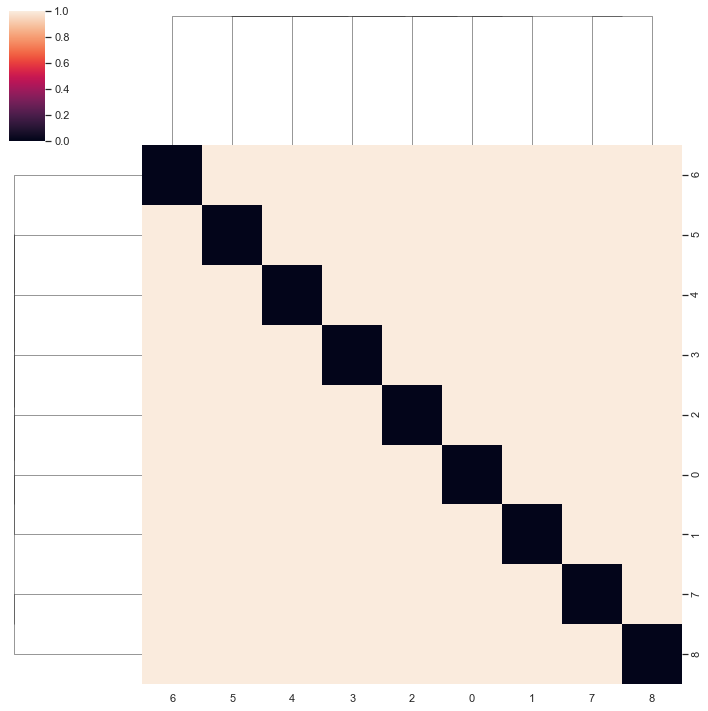

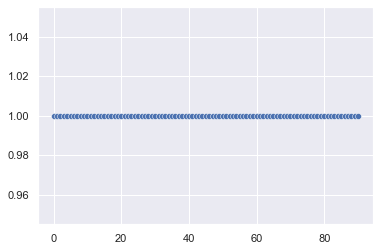

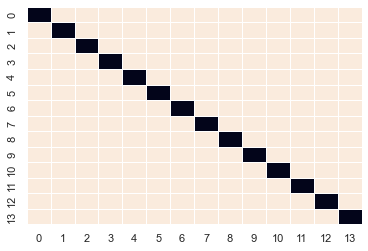

<Figure size 432x288 with 0 Axes>

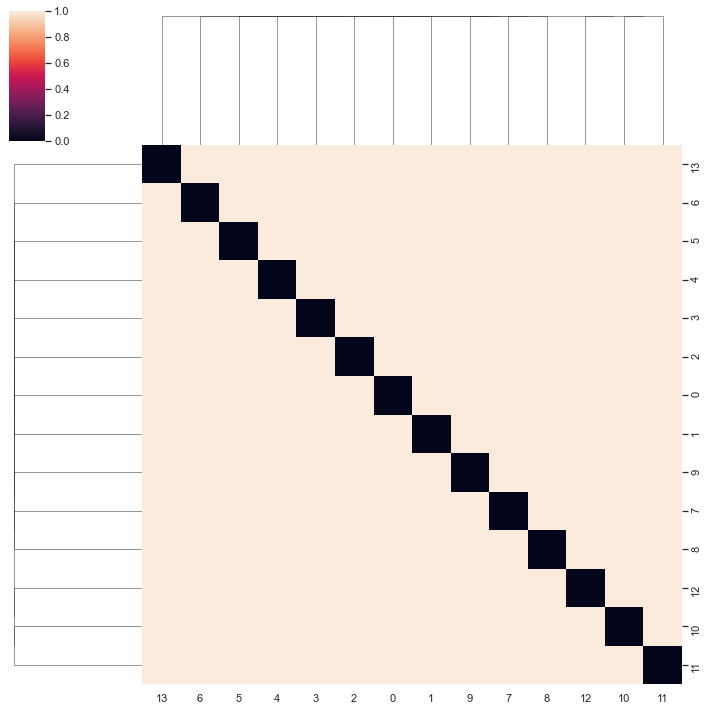

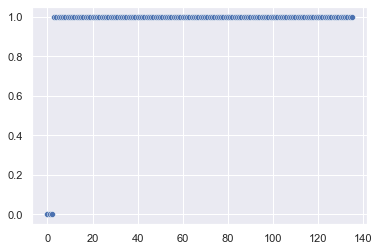

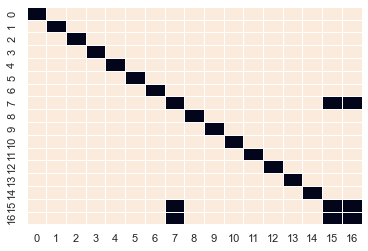

<Figure size 432x288 with 0 Axes>

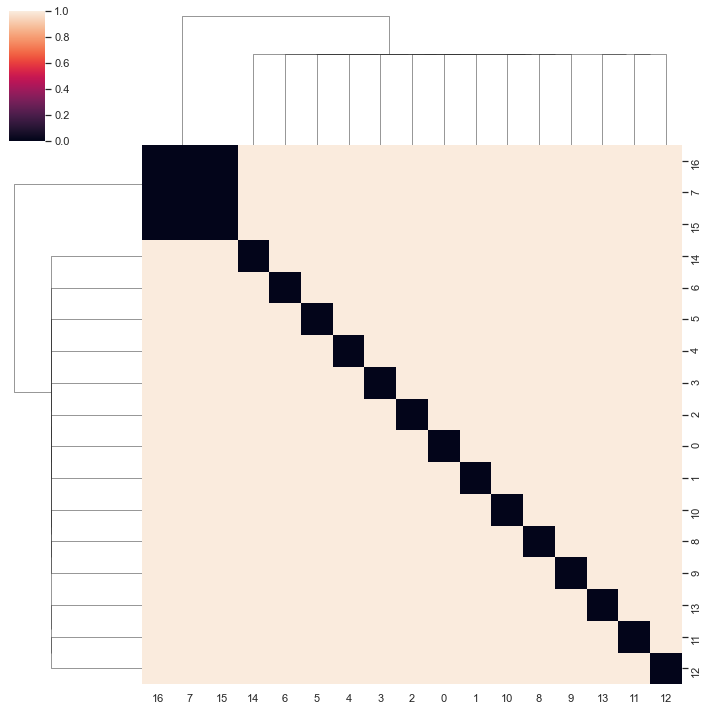

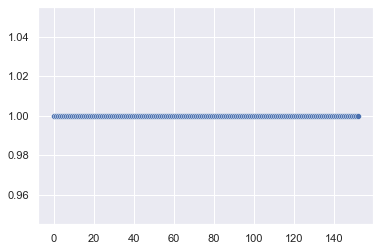

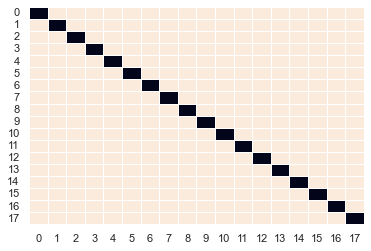

<Figure size 432x288 with 0 Axes>

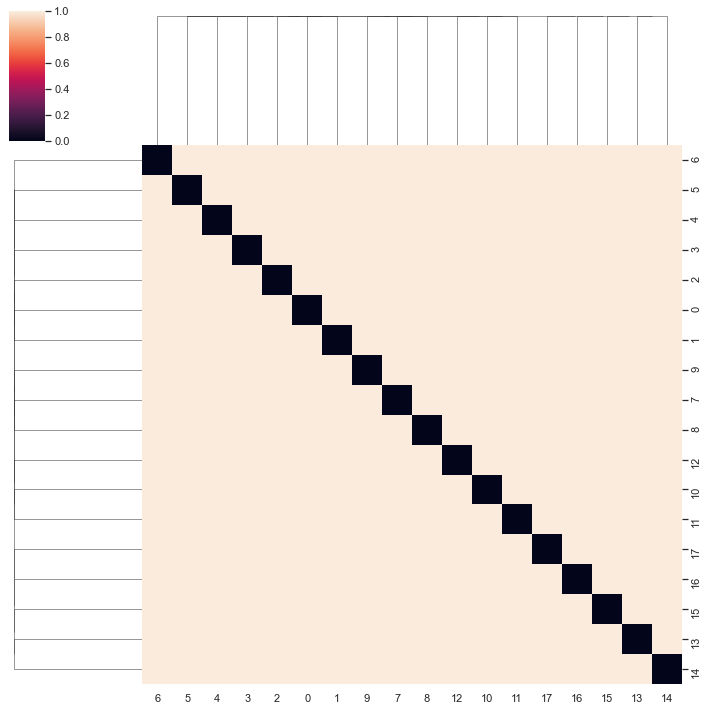

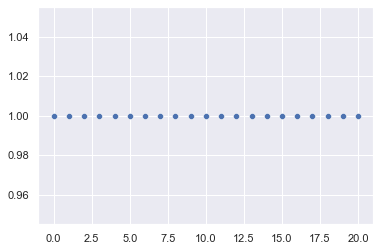

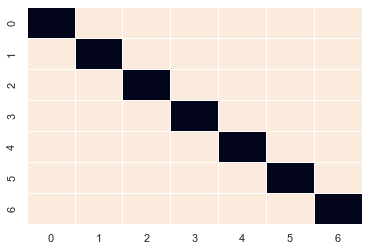

<Figure size 432x288 with 0 Axes>

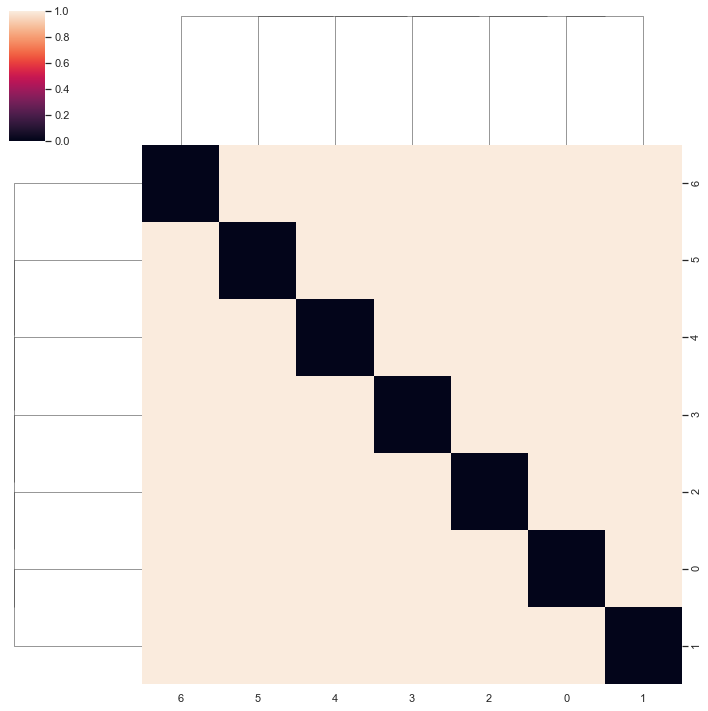

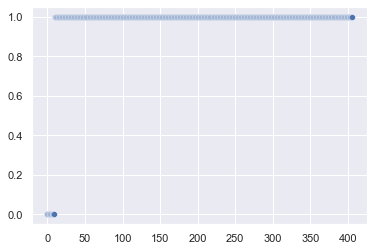

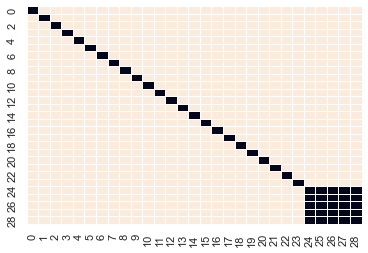

<Figure size 432x288 with 0 Axes>

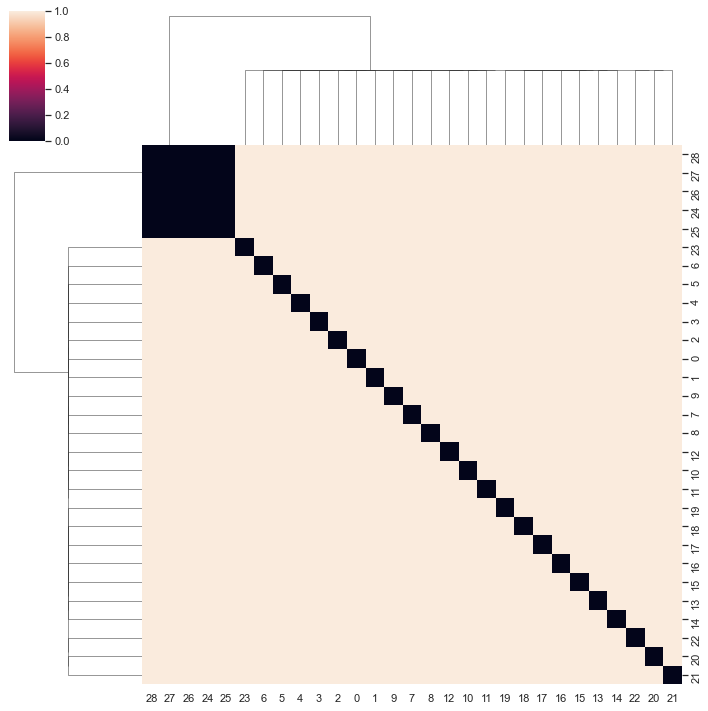

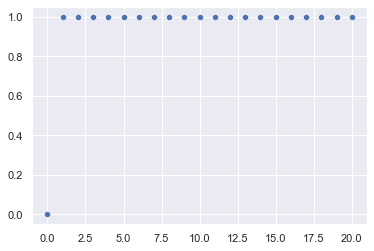

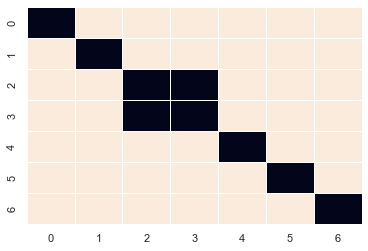

<Figure size 432x288 with 0 Axes>

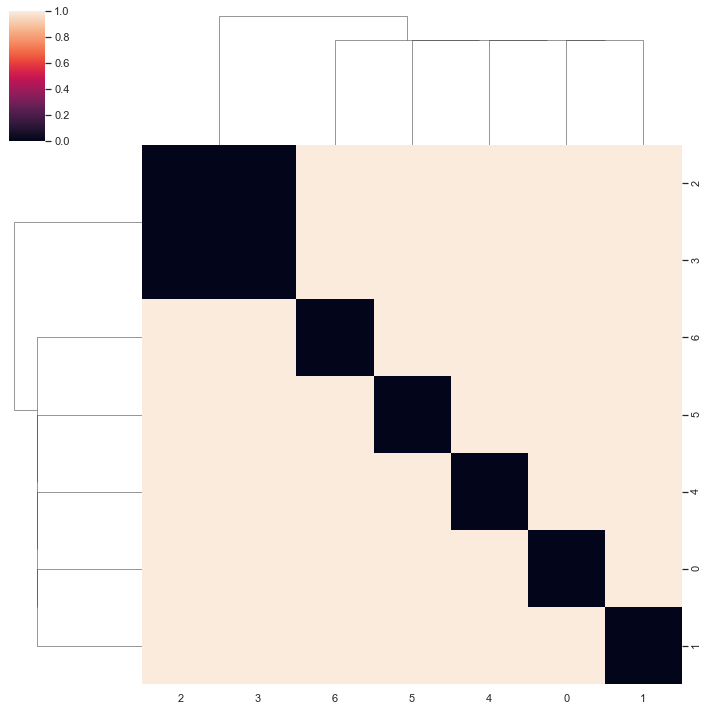

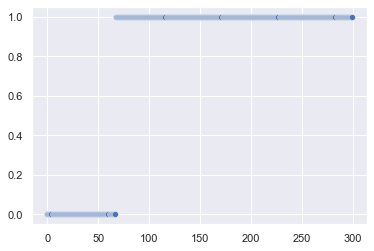

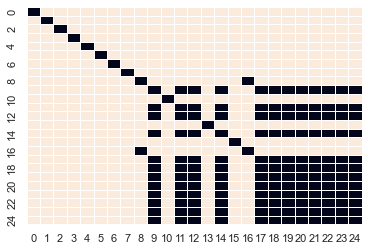

<Figure size 432x288 with 0 Axes>

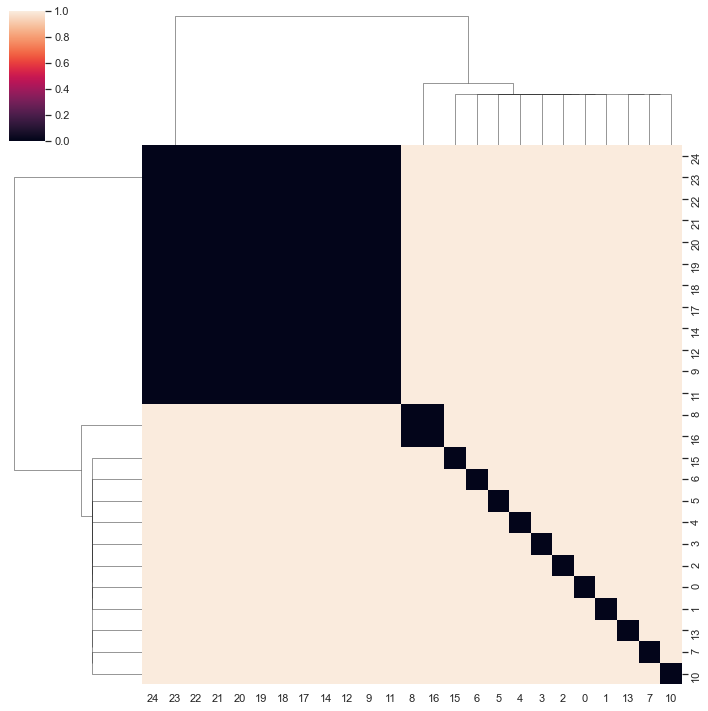

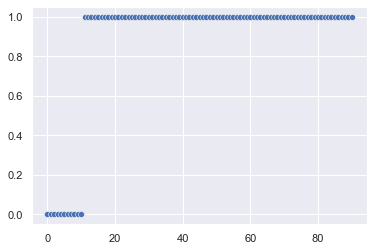

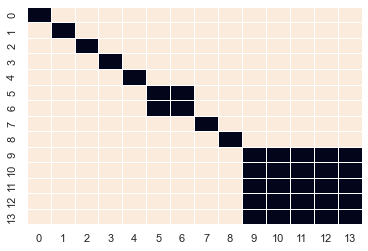

<Figure size 432x288 with 0 Axes>

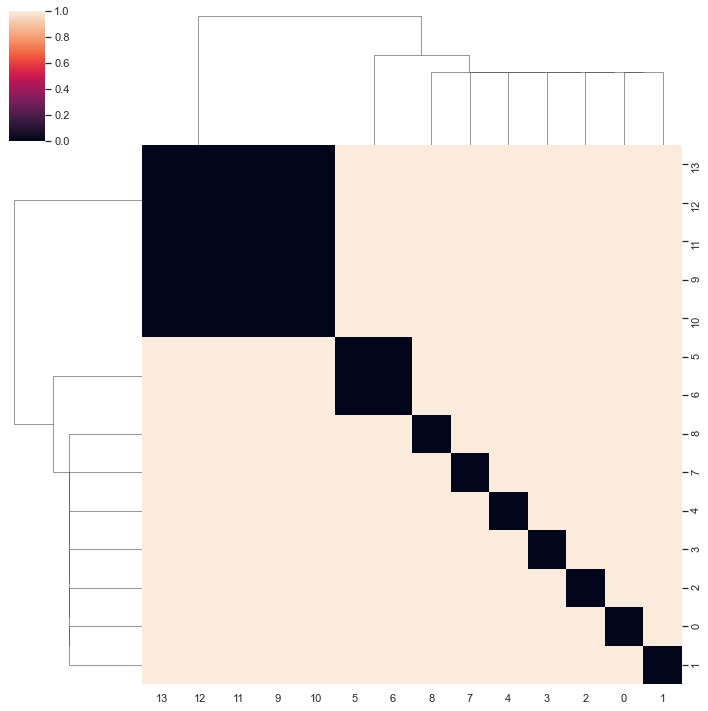

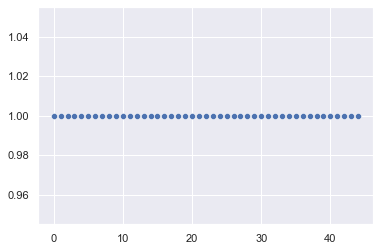

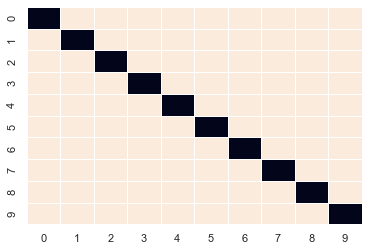

<Figure size 432x288 with 0 Axes>

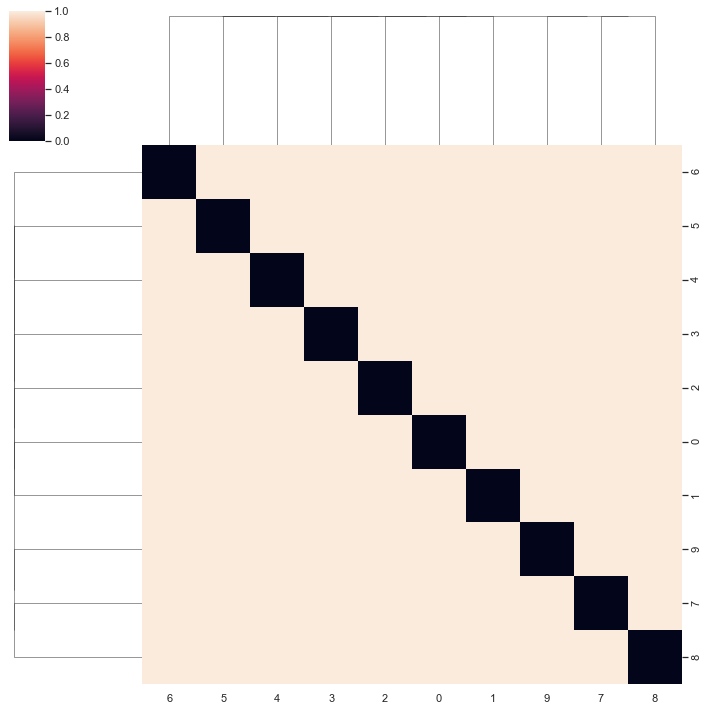

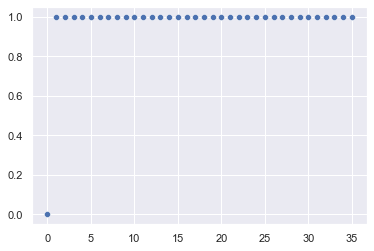

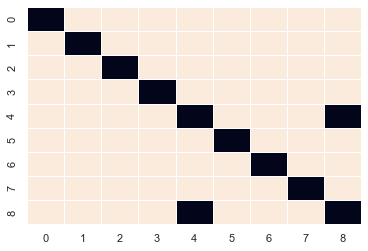

<Figure size 432x288 with 0 Axes>

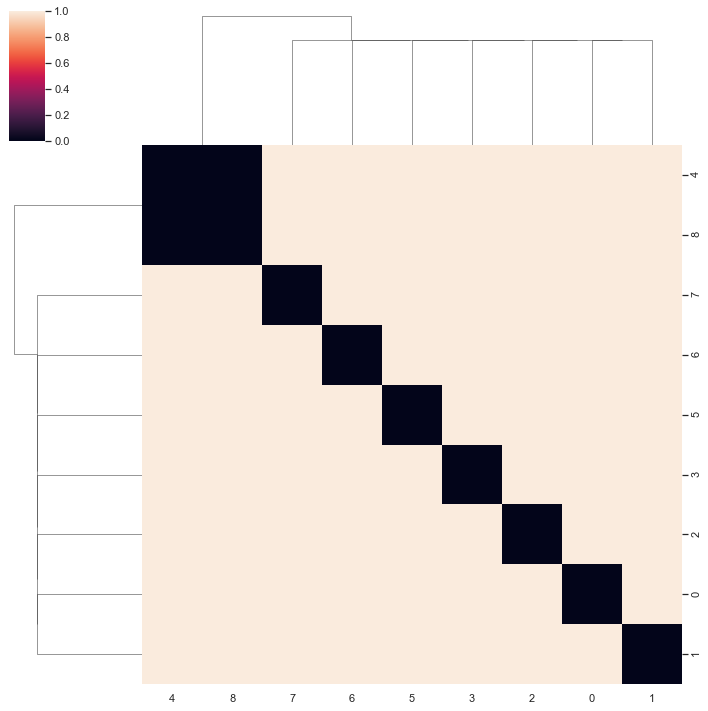

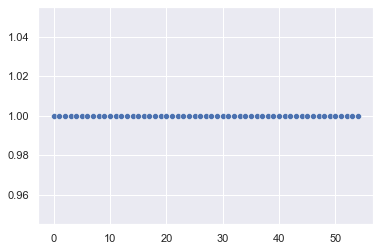

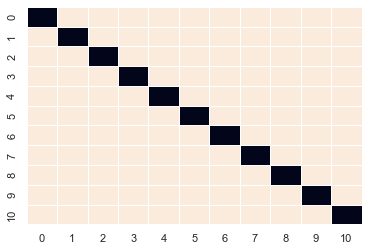

<Figure size 432x288 with 0 Axes>

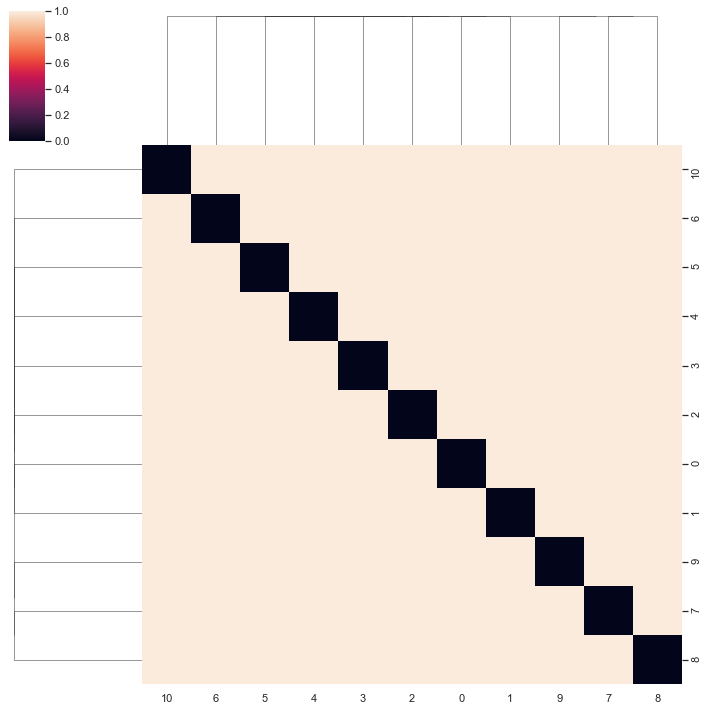

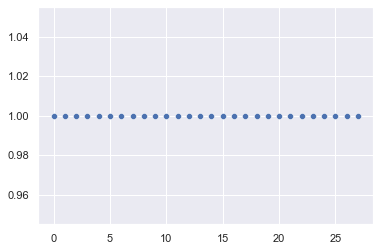

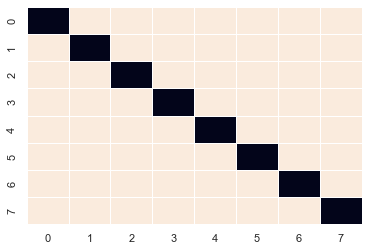

<Figure size 432x288 with 0 Axes>

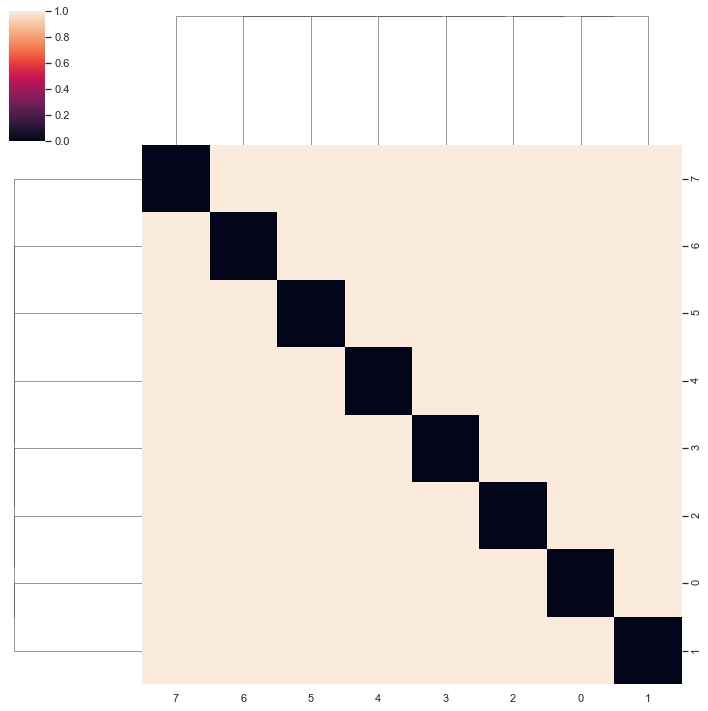

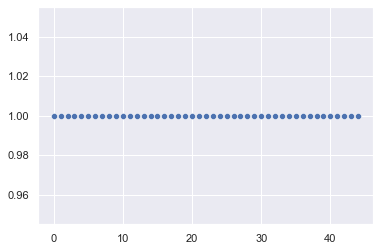

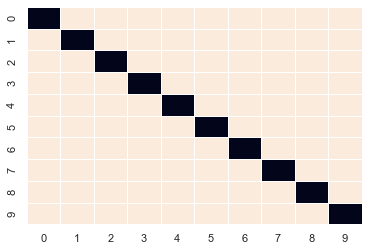

<Figure size 432x288 with 0 Axes>

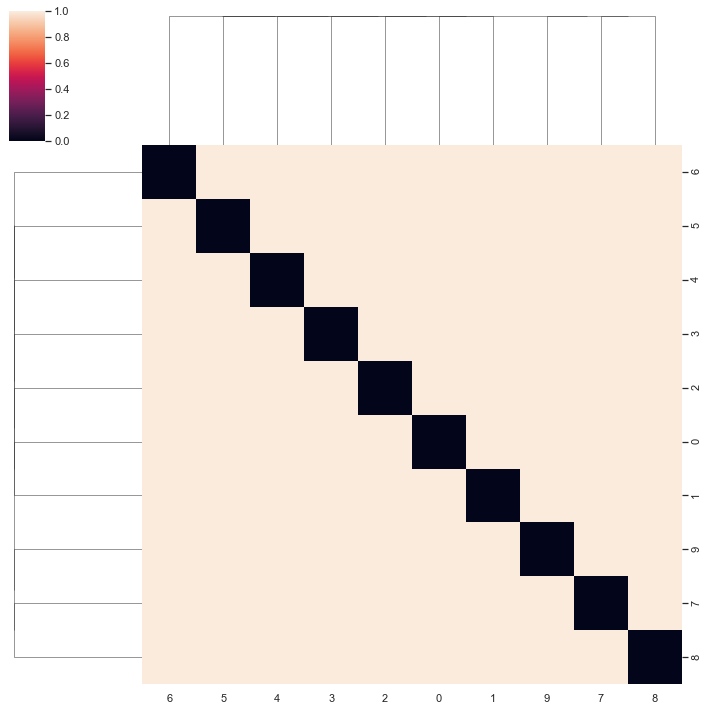

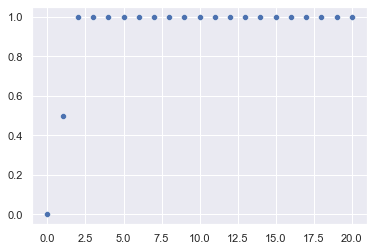

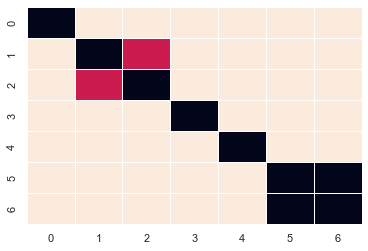

<Figure size 432x288 with 0 Axes>

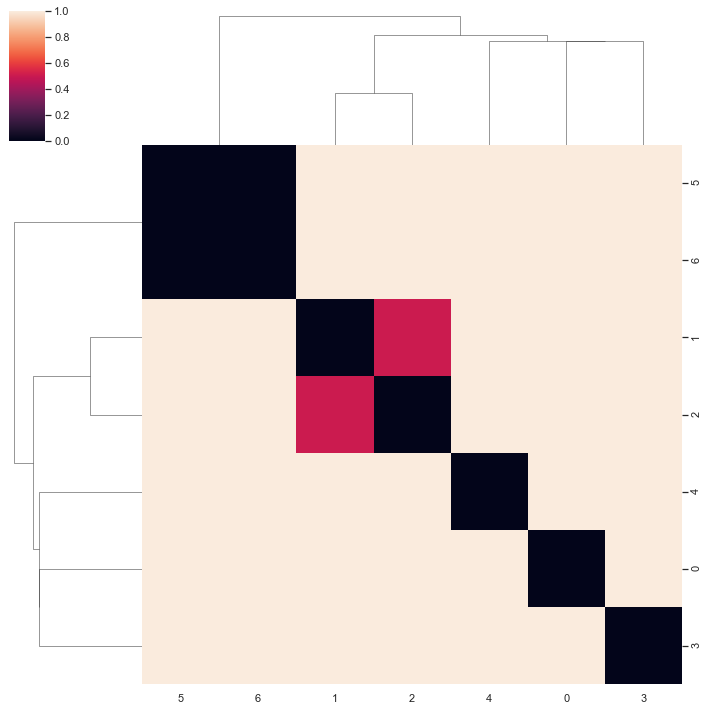

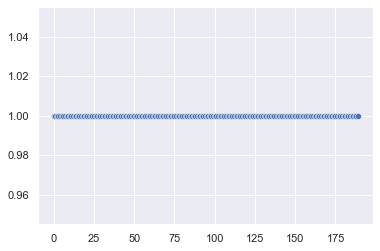

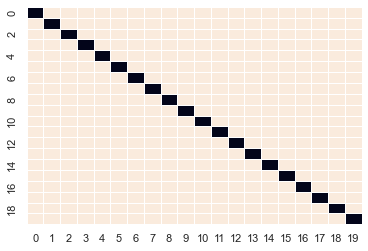

<Figure size 432x288 with 0 Axes>

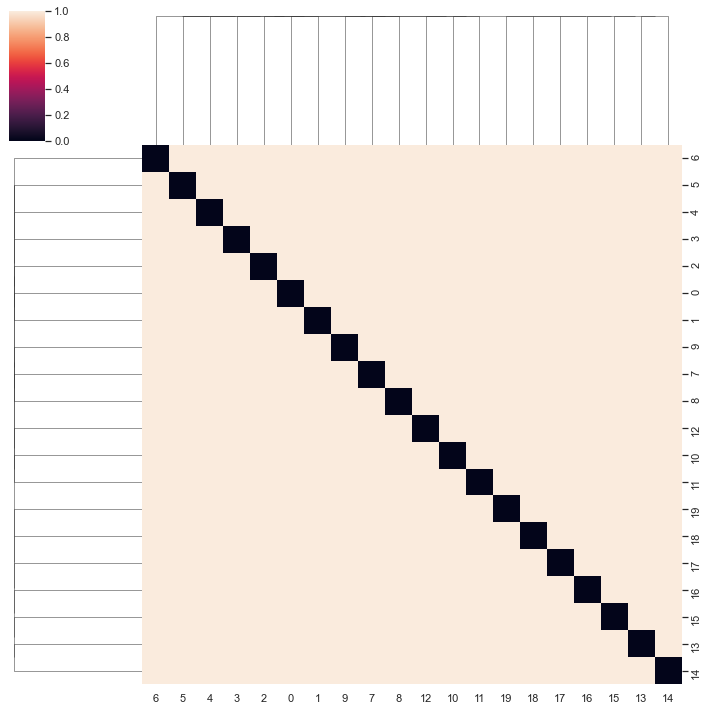

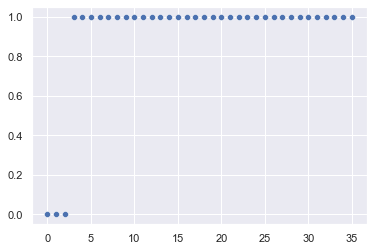

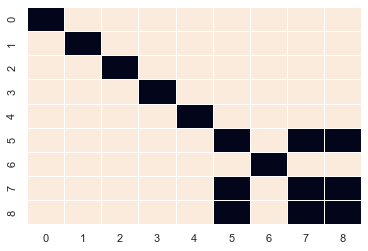

<Figure size 432x288 with 0 Axes>

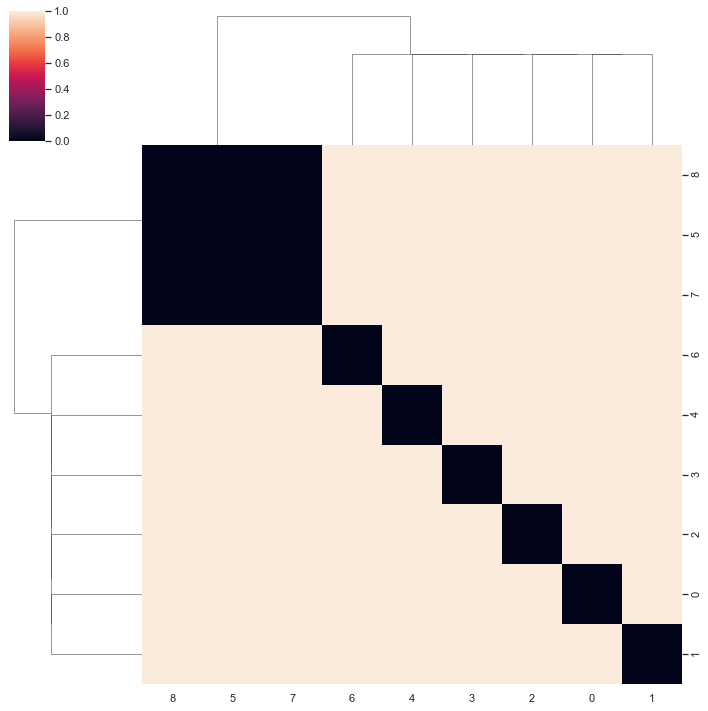

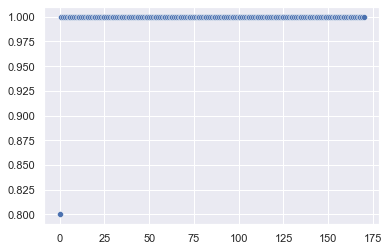

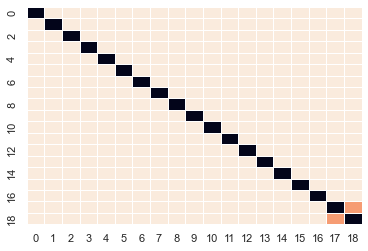

<Figure size 432x288 with 0 Axes>

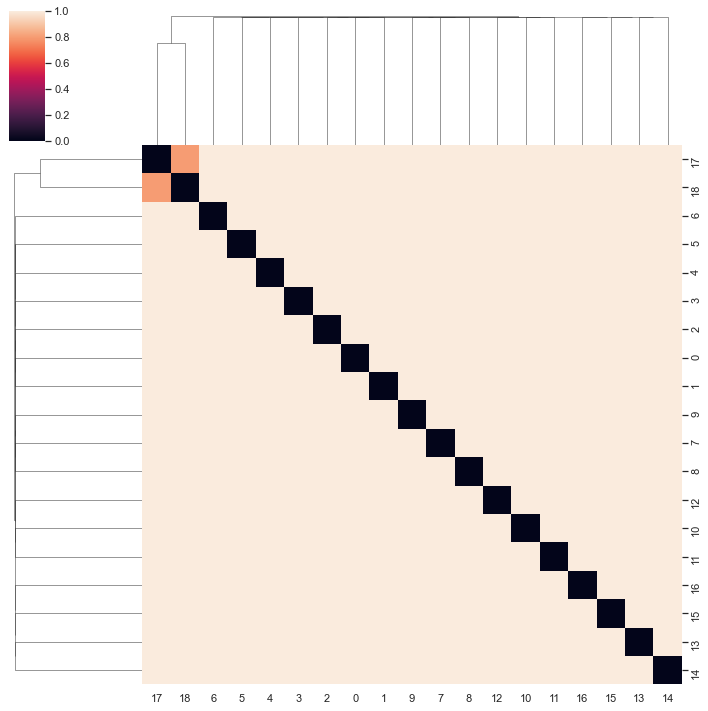

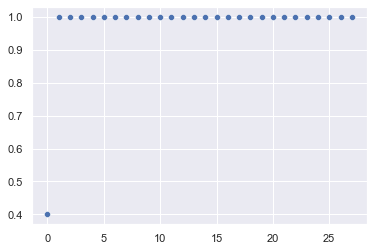

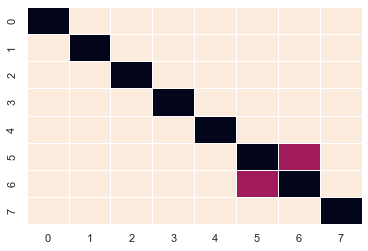

<Figure size 432x288 with 0 Axes>

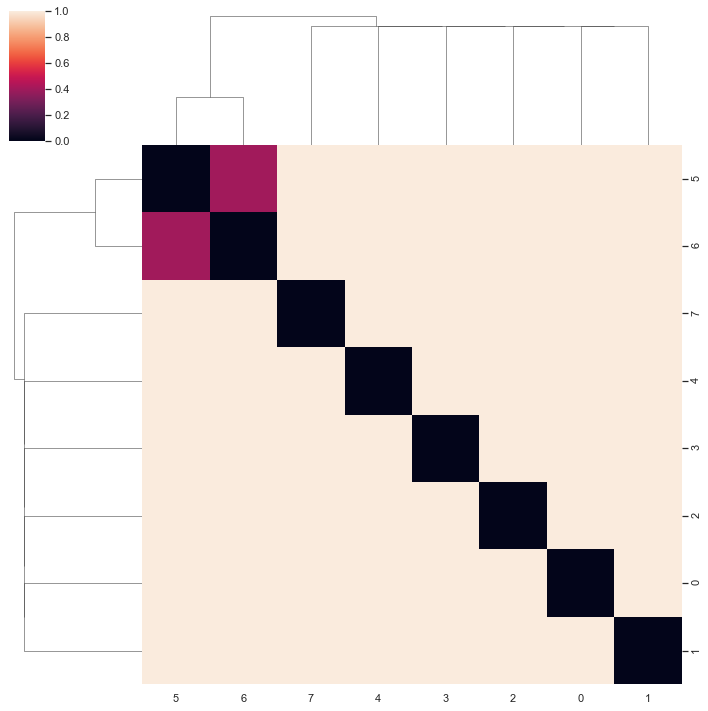

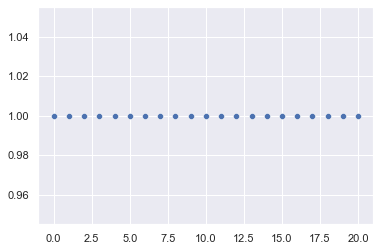

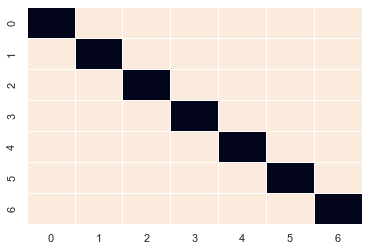

<Figure size 432x288 with 0 Axes>

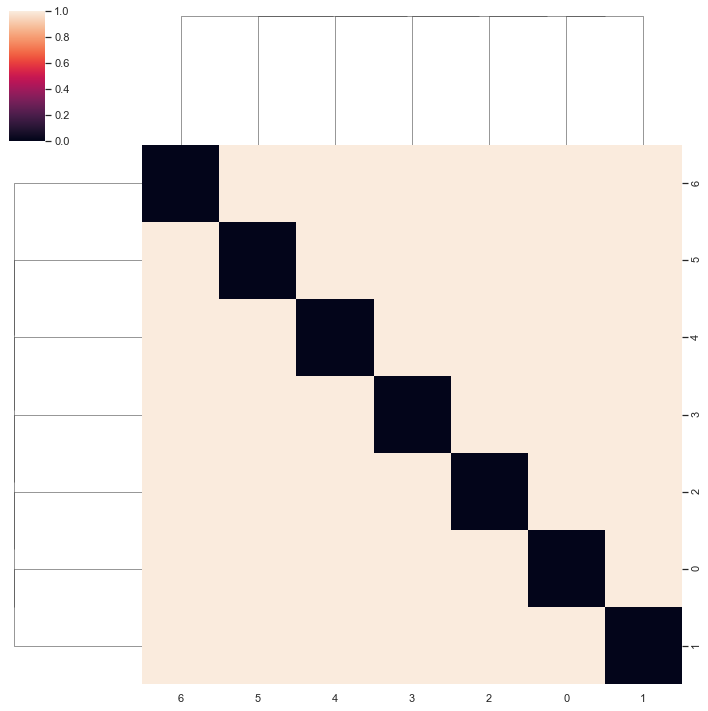

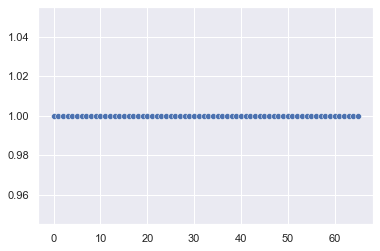

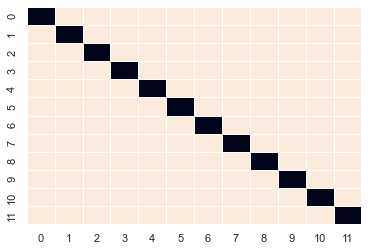

<Figure size 432x288 with 0 Axes>

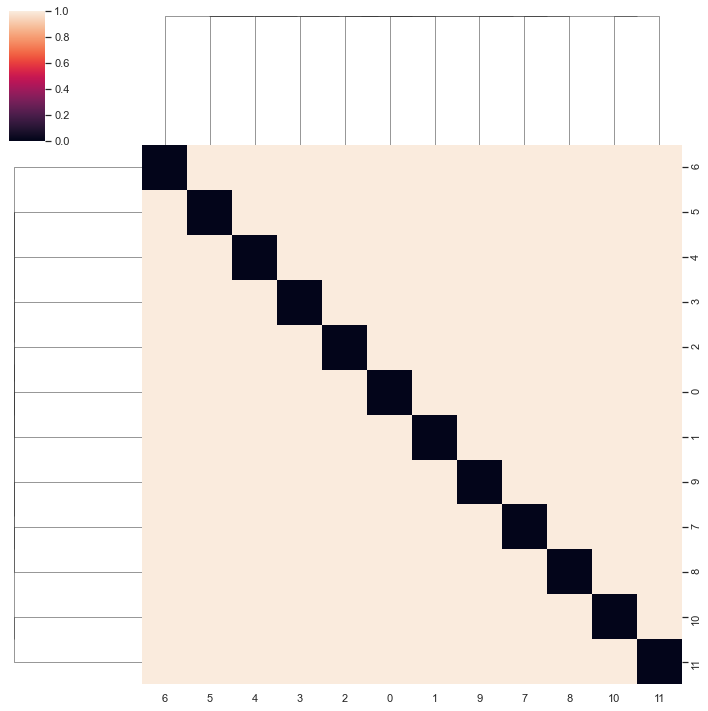

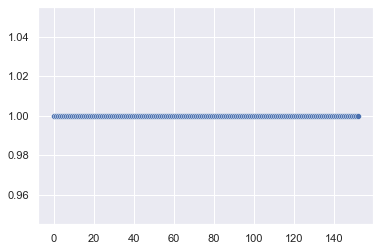

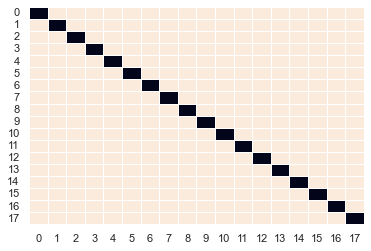

<Figure size 432x288 with 0 Axes>

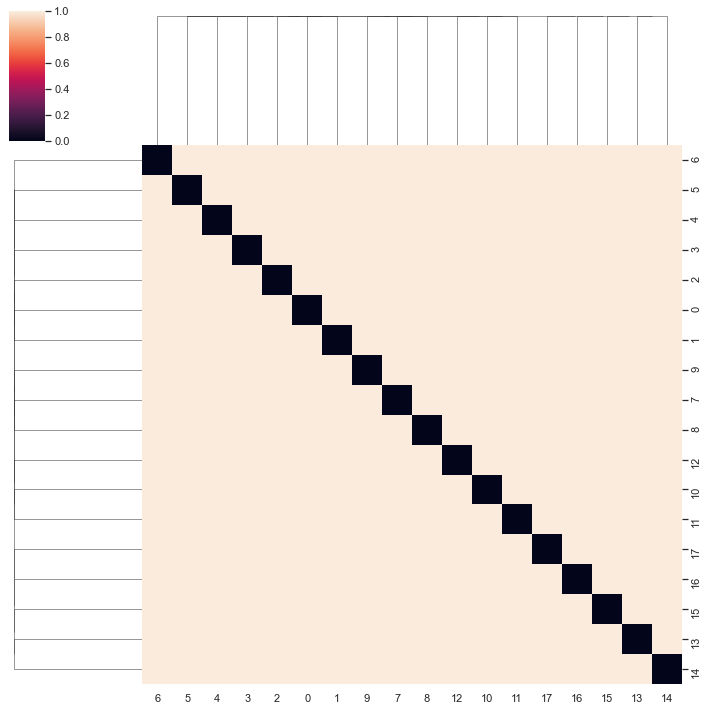

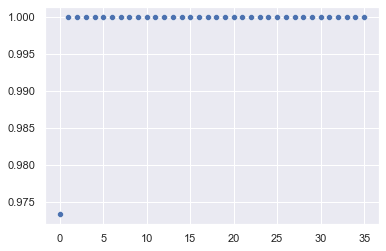

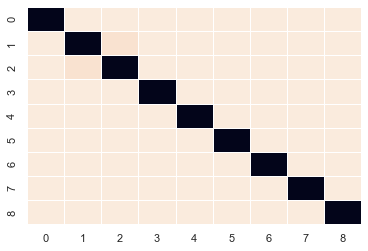

<Figure size 432x288 with 0 Axes>

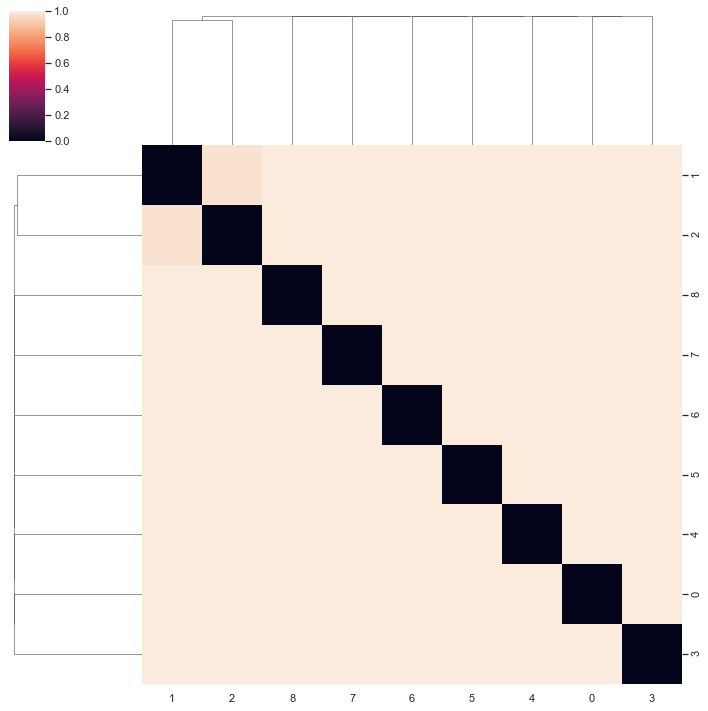

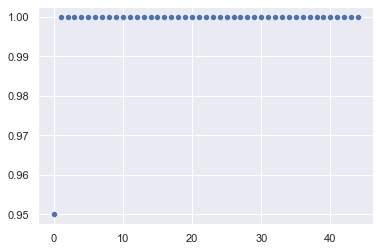

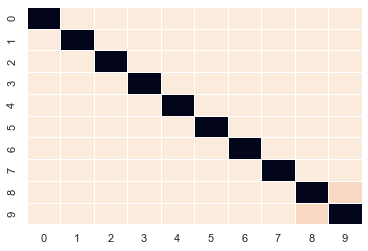

<Figure size 432x288 with 0 Axes>

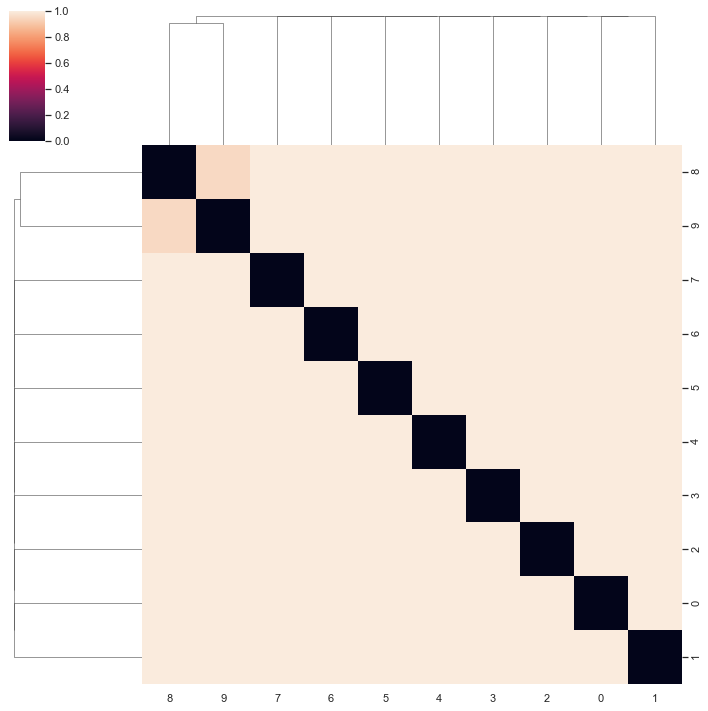

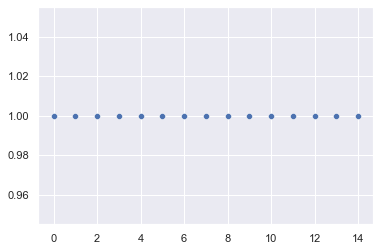

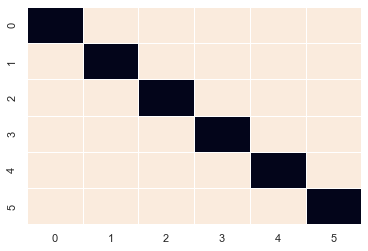

<Figure size 432x288 with 0 Axes>

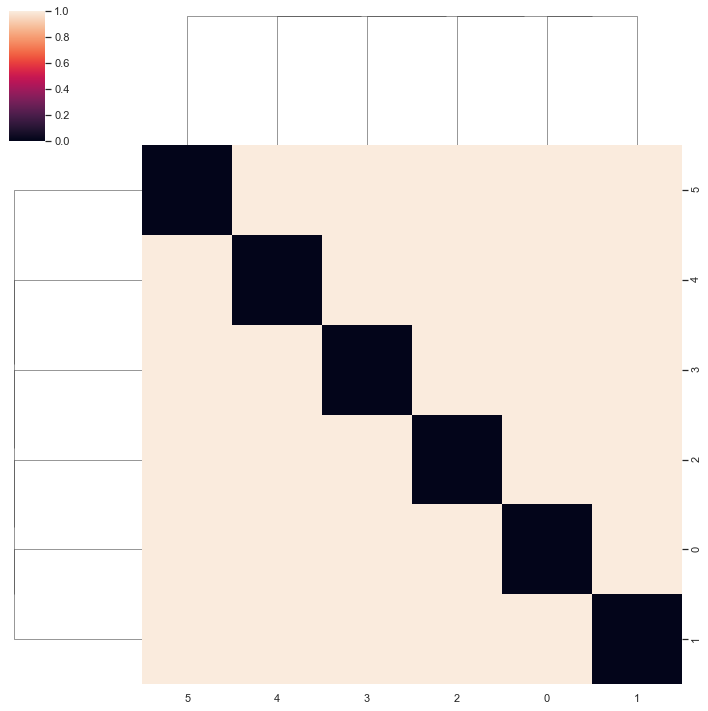

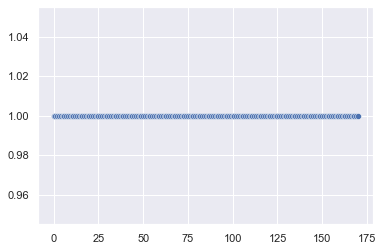

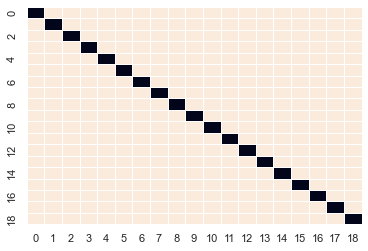

<Figure size 432x288 with 0 Axes>

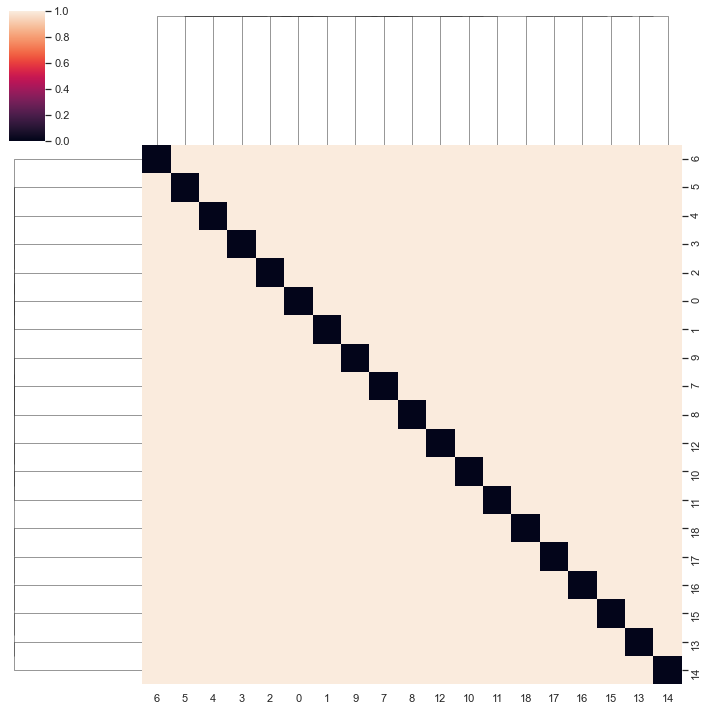

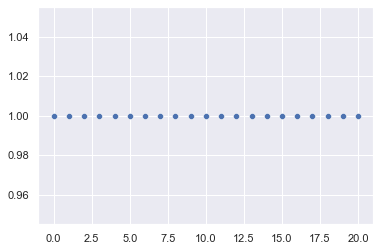

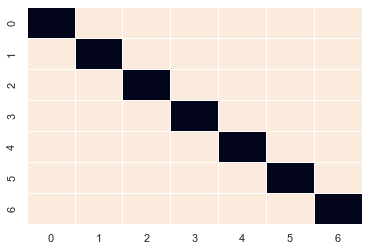

<Figure size 432x288 with 0 Axes>

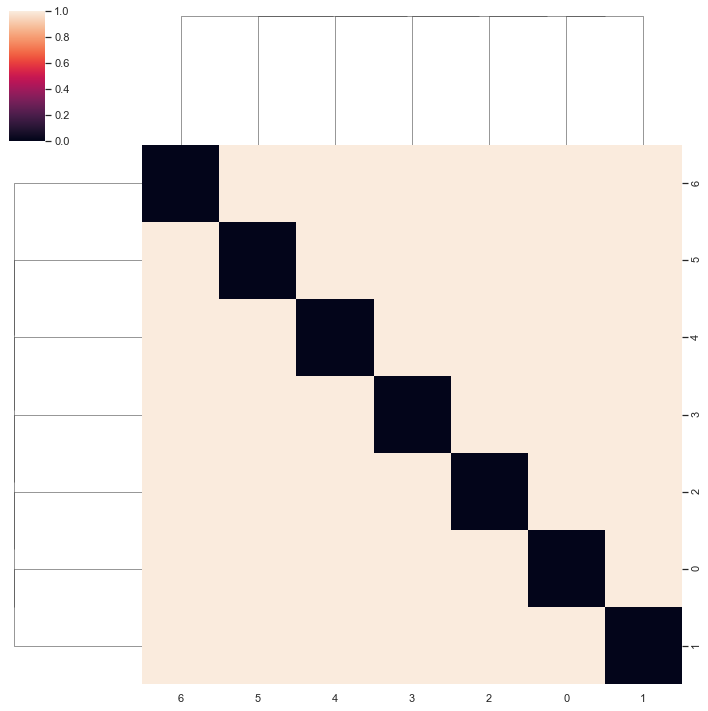

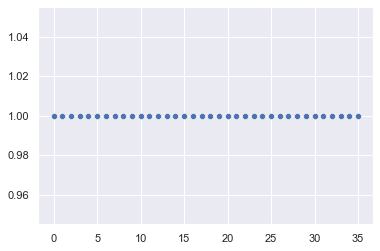

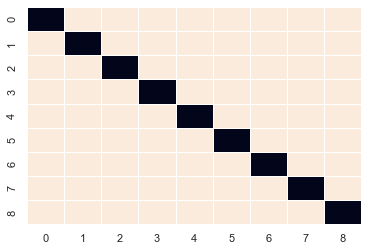

<Figure size 432x288 with 0 Axes>

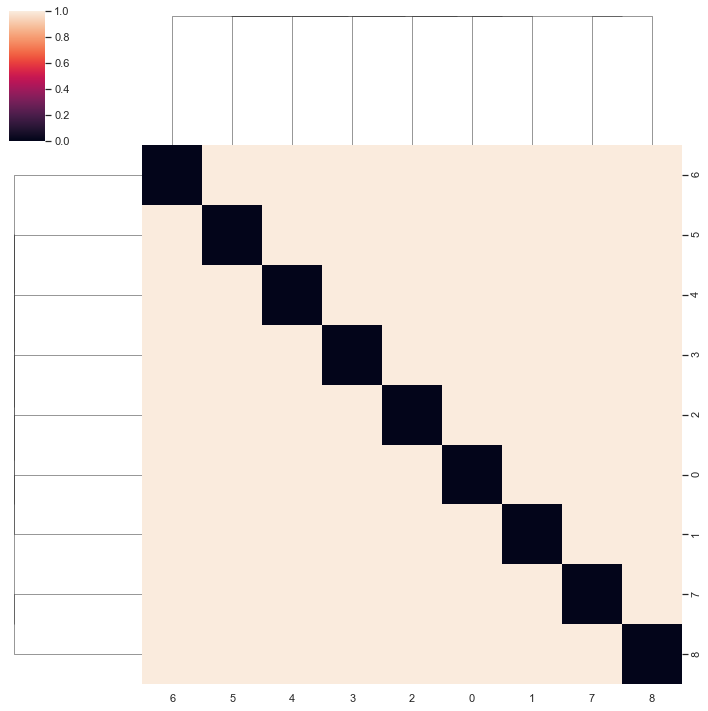

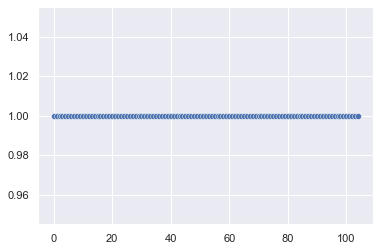

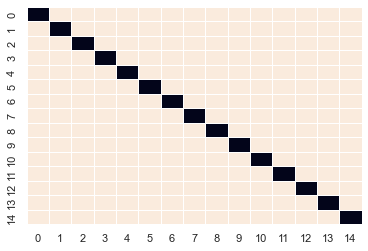

<Figure size 432x288 with 0 Axes>

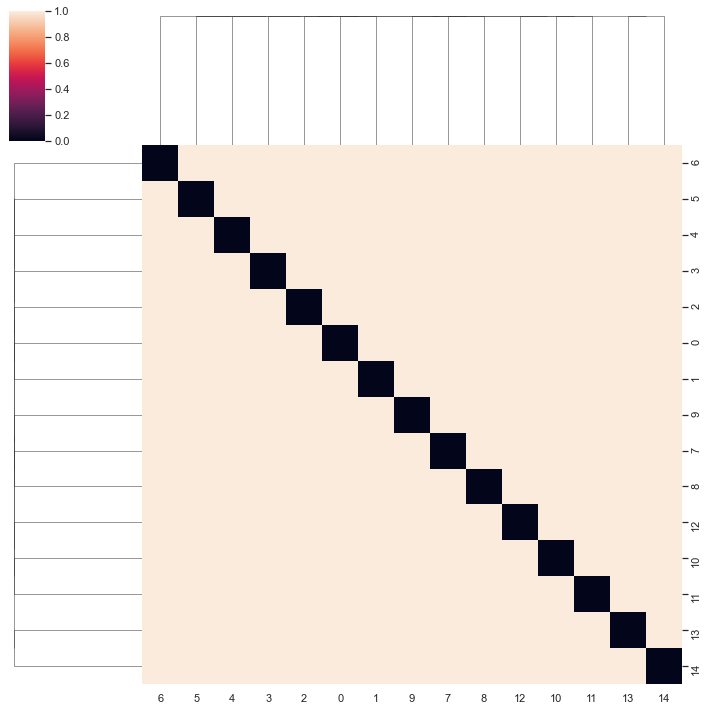

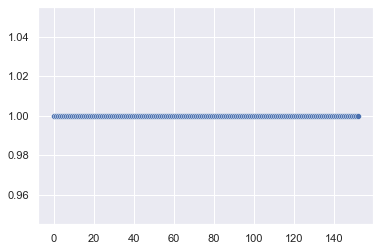

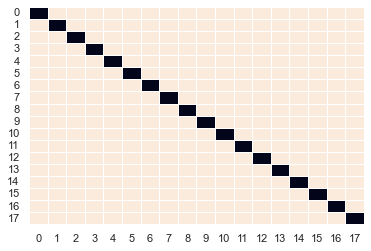

<Figure size 432x288 with 0 Axes>

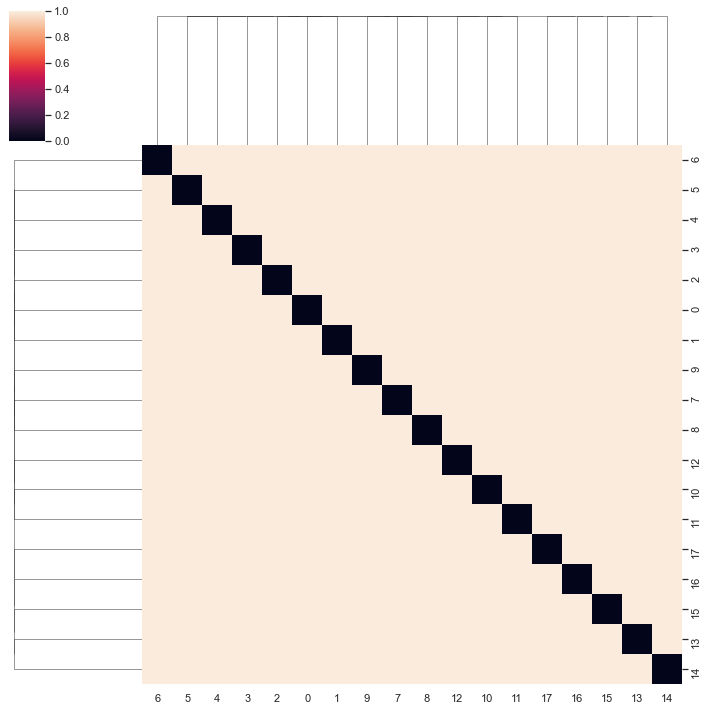

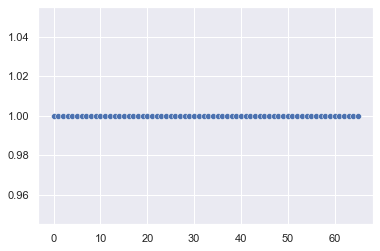

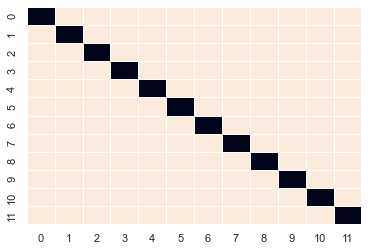

<Figure size 432x288 with 0 Axes>

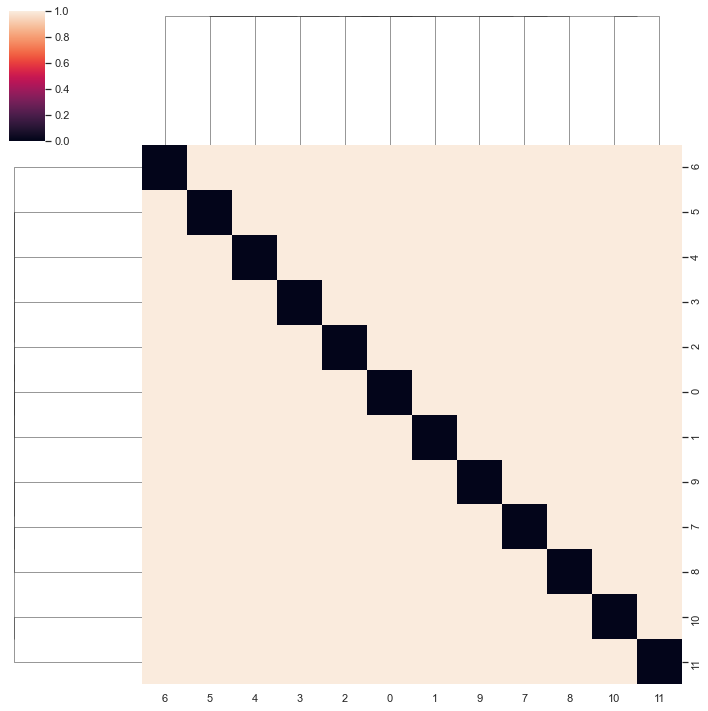

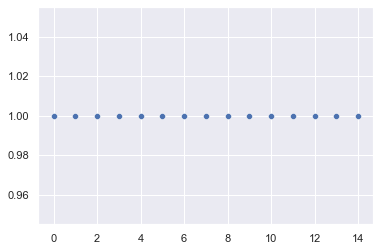

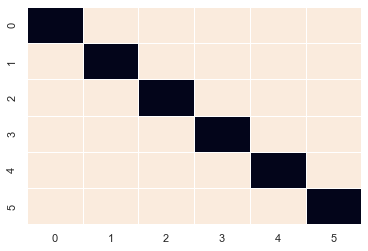

<Figure size 432x288 with 0 Axes>

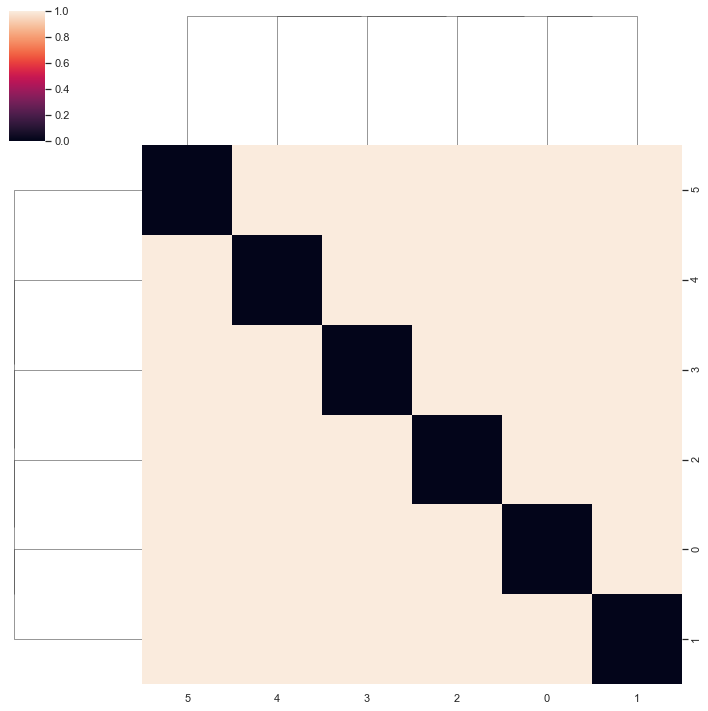

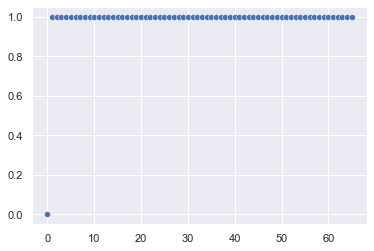

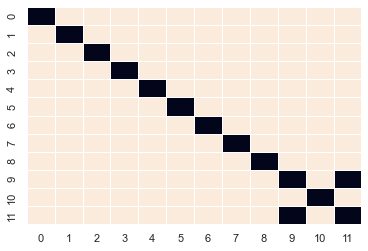

<Figure size 432x288 with 0 Axes>

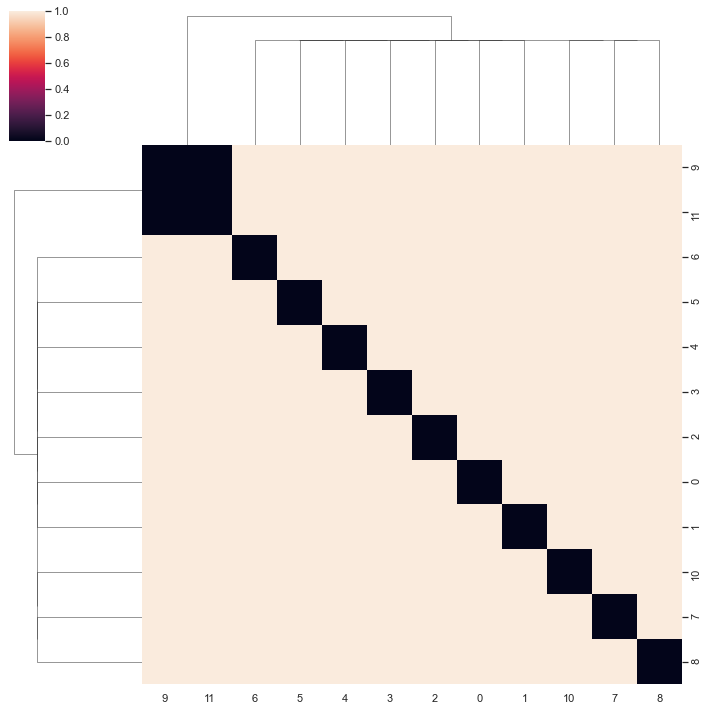

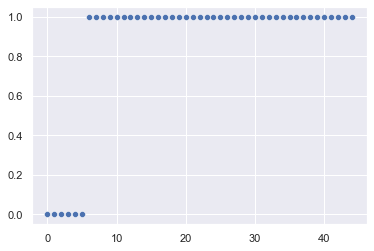

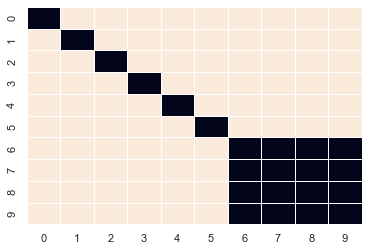

<Figure size 432x288 with 0 Axes>

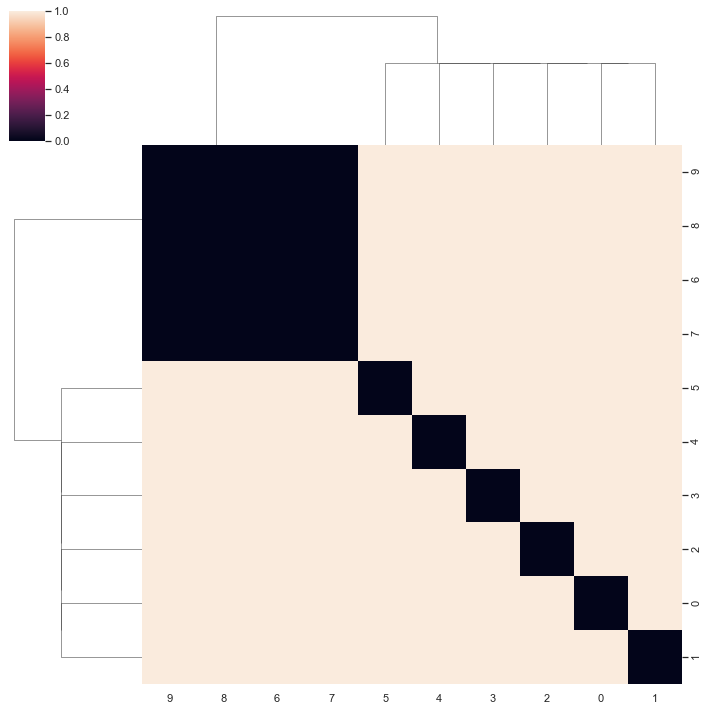

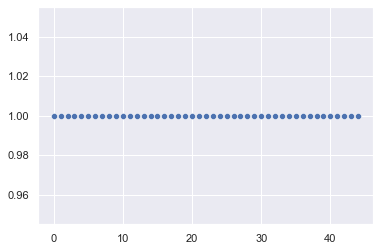

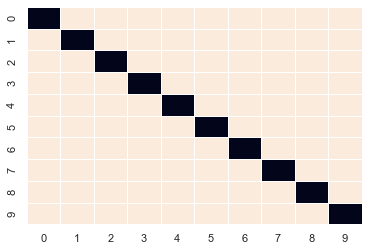

<Figure size 432x288 with 0 Axes>

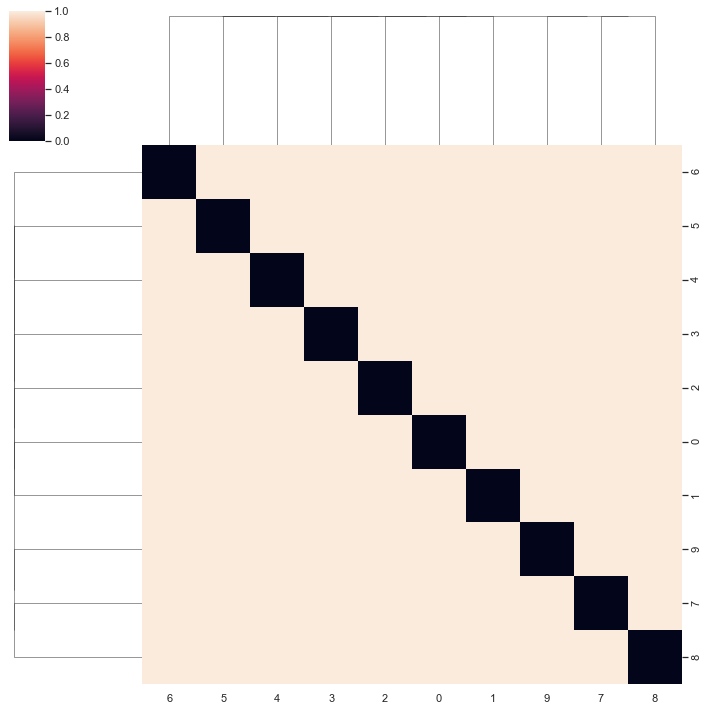

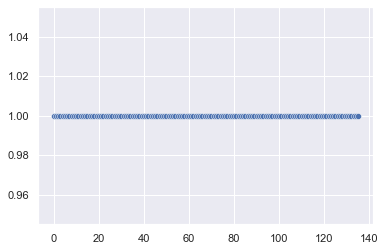

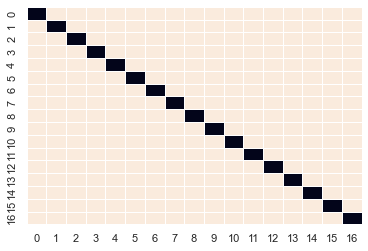

<Figure size 432x288 with 0 Axes>

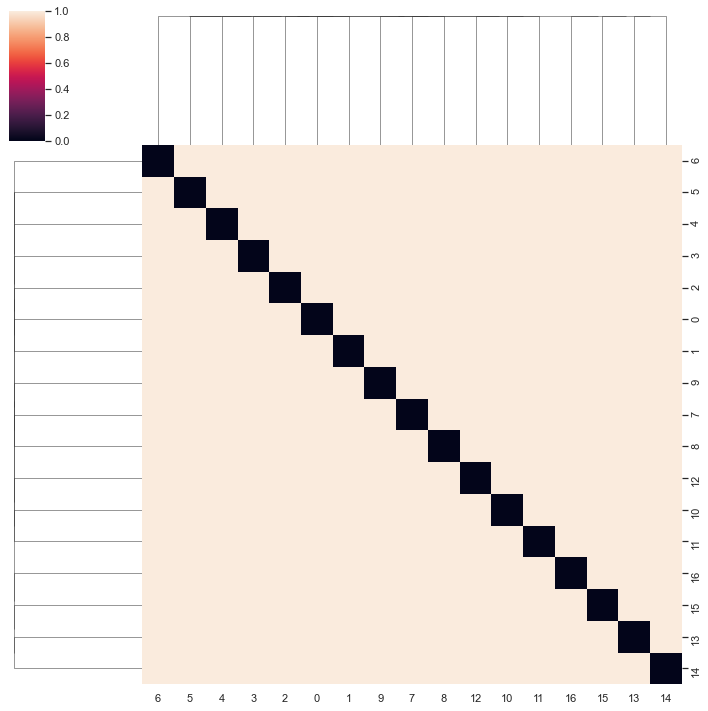

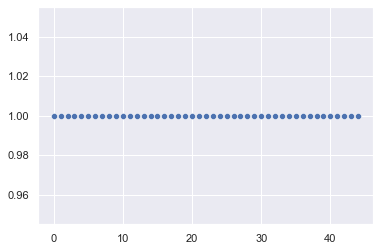

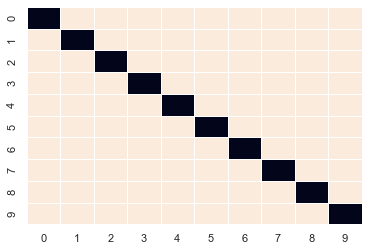

<Figure size 432x288 with 0 Axes>

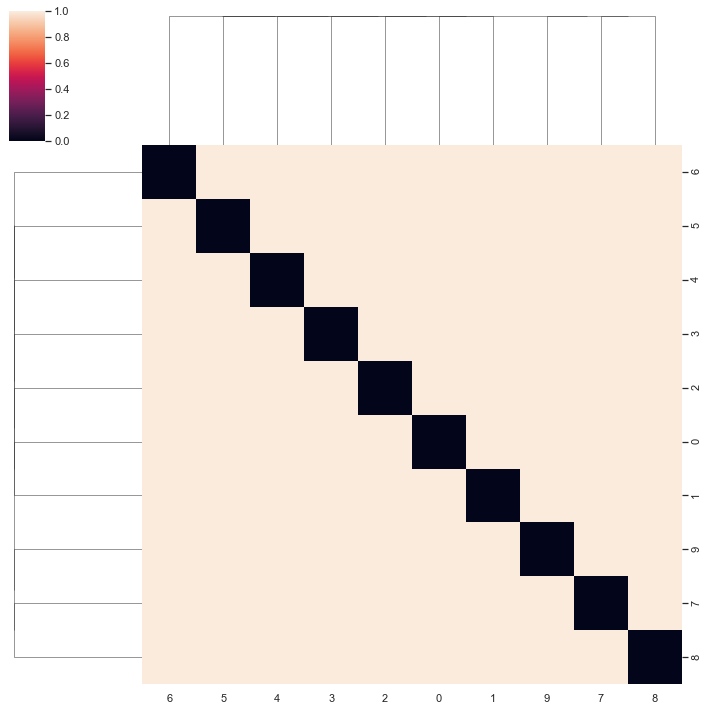

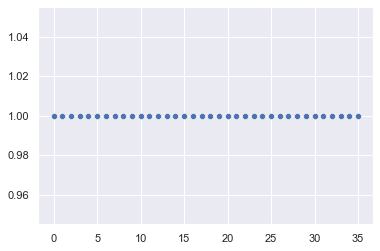

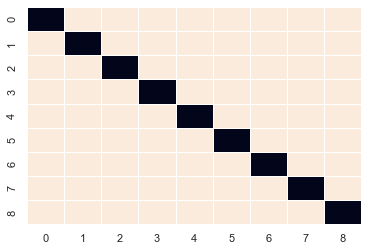

<Figure size 432x288 with 0 Axes>

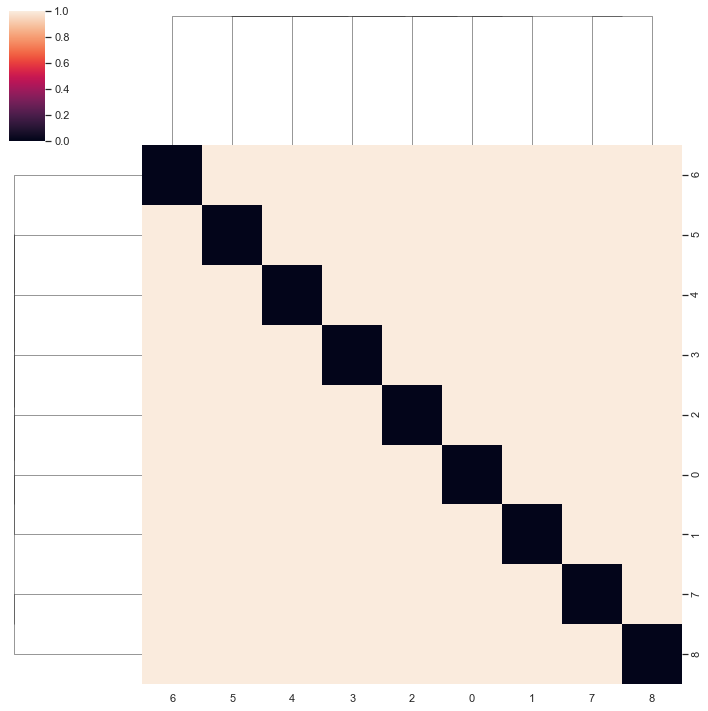

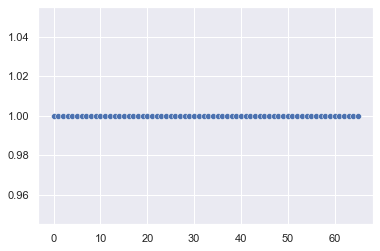

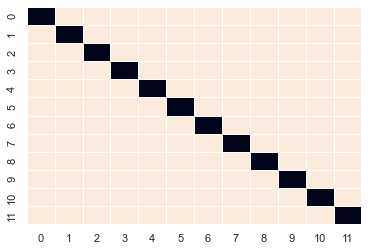

<Figure size 432x288 with 0 Axes>

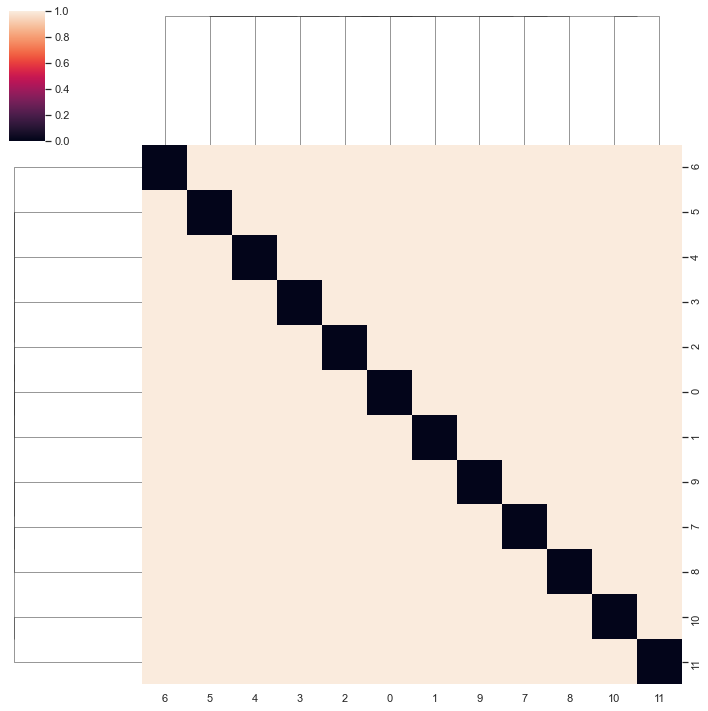

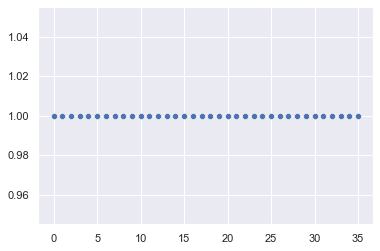

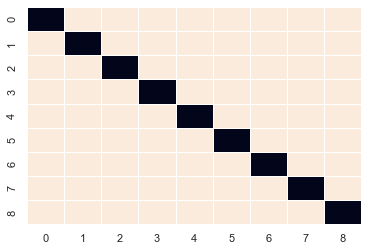

<Figure size 432x288 with 0 Axes>

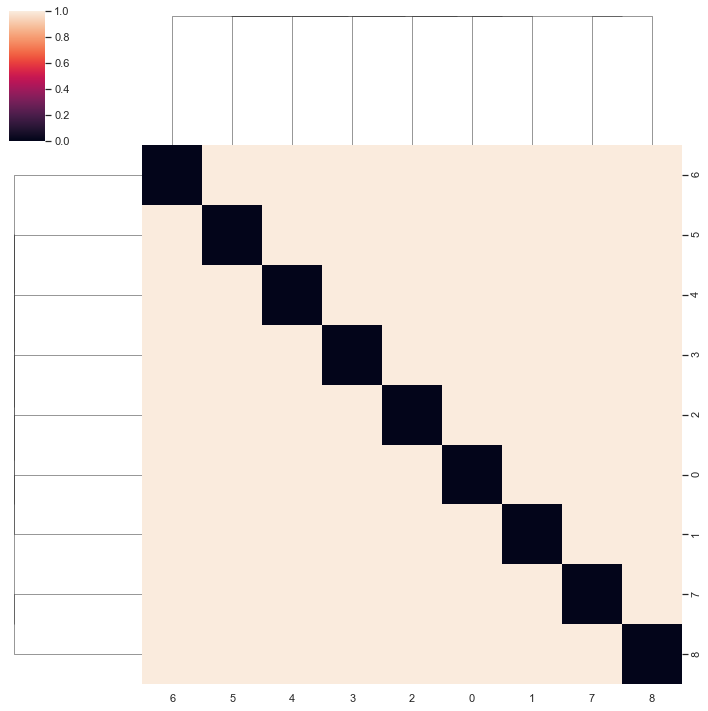

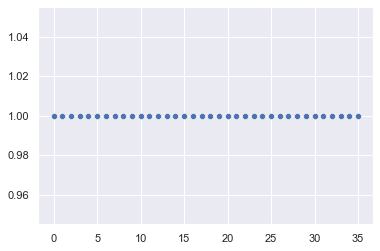

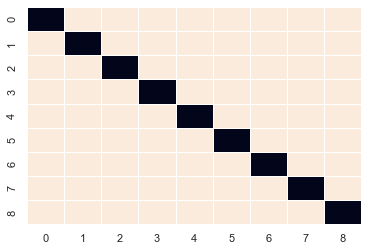

<Figure size 432x288 with 0 Axes>

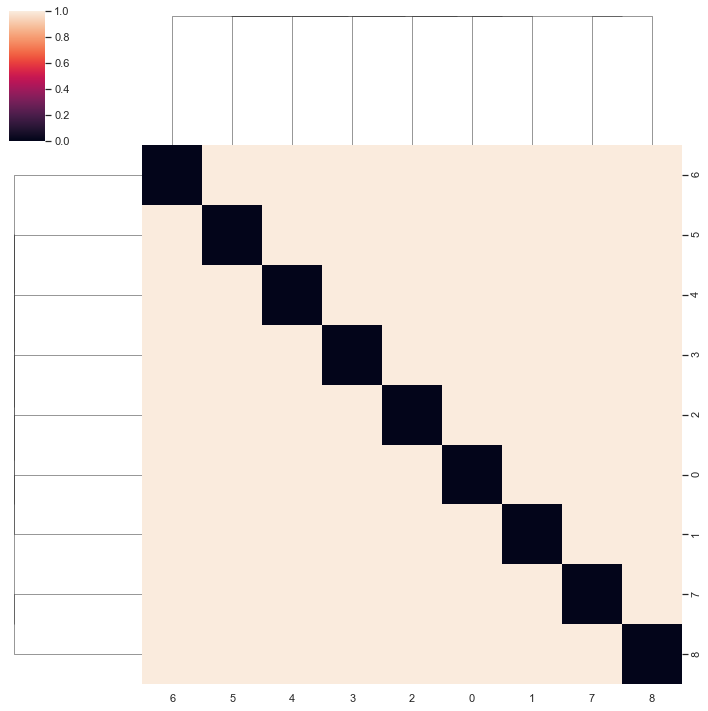

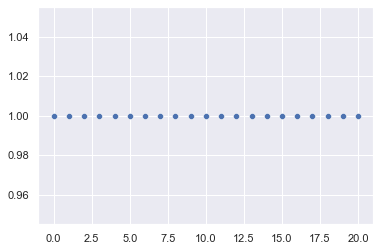

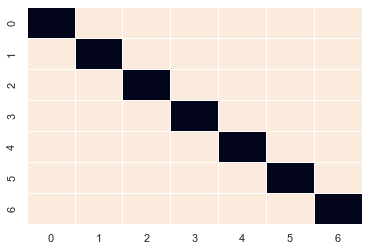

<Figure size 432x288 with 0 Axes>

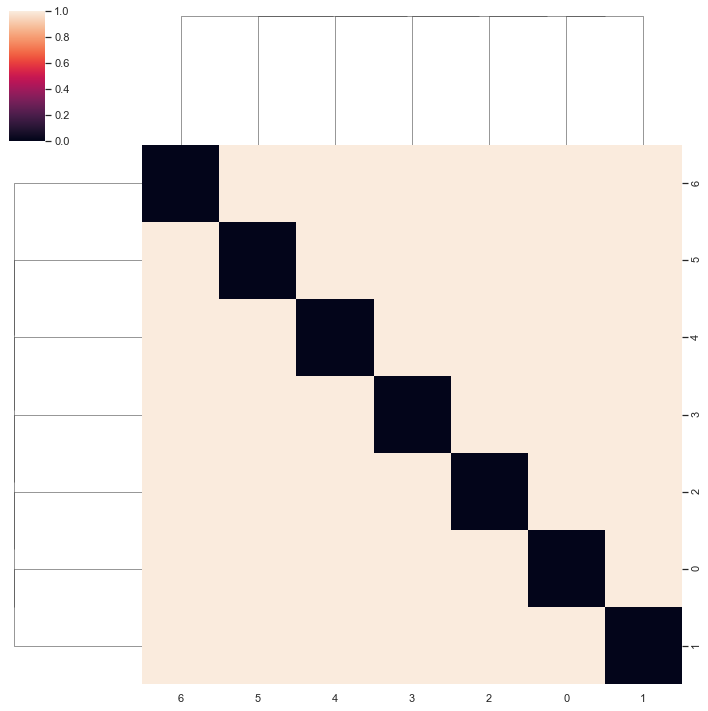

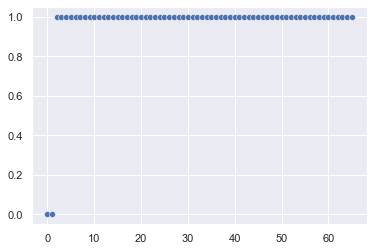

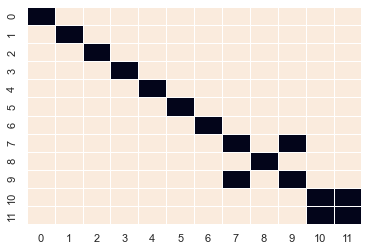

<Figure size 432x288 with 0 Axes>

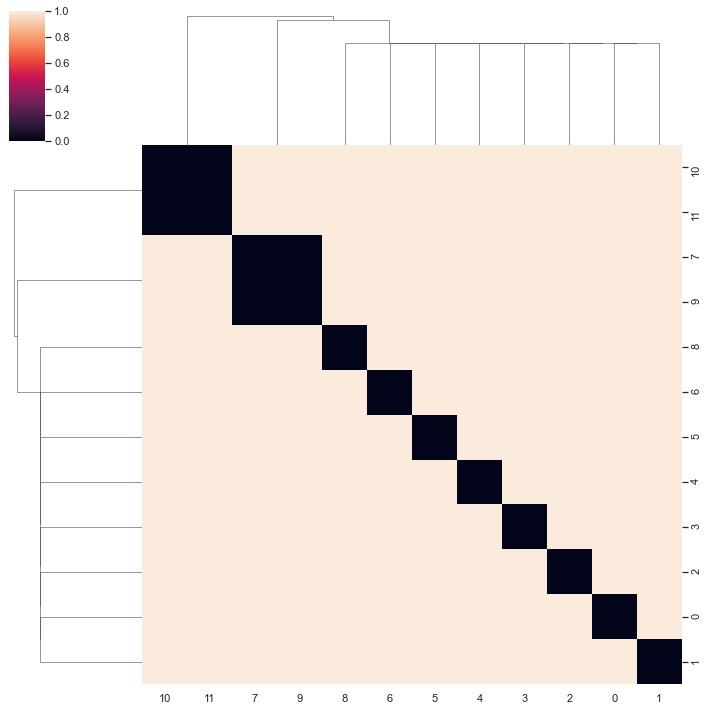

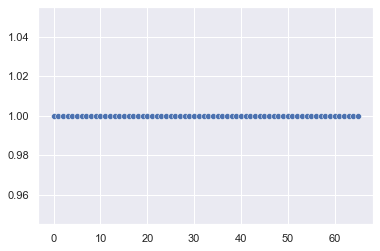

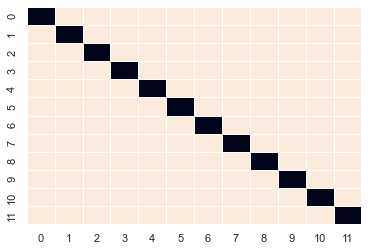

<Figure size 432x288 with 0 Axes>

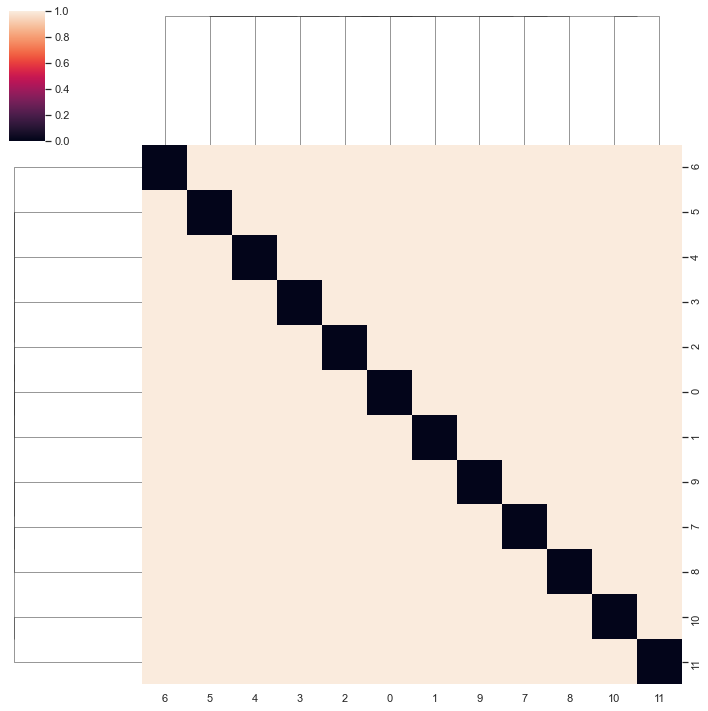

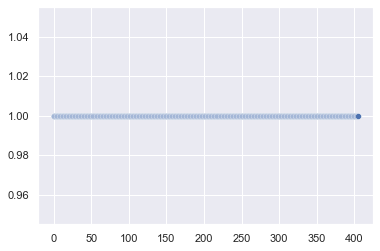

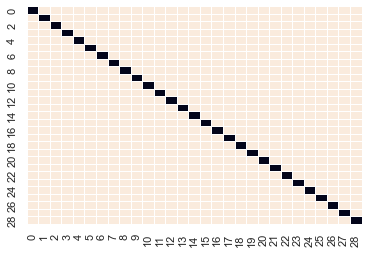

<Figure size 432x288 with 0 Axes>

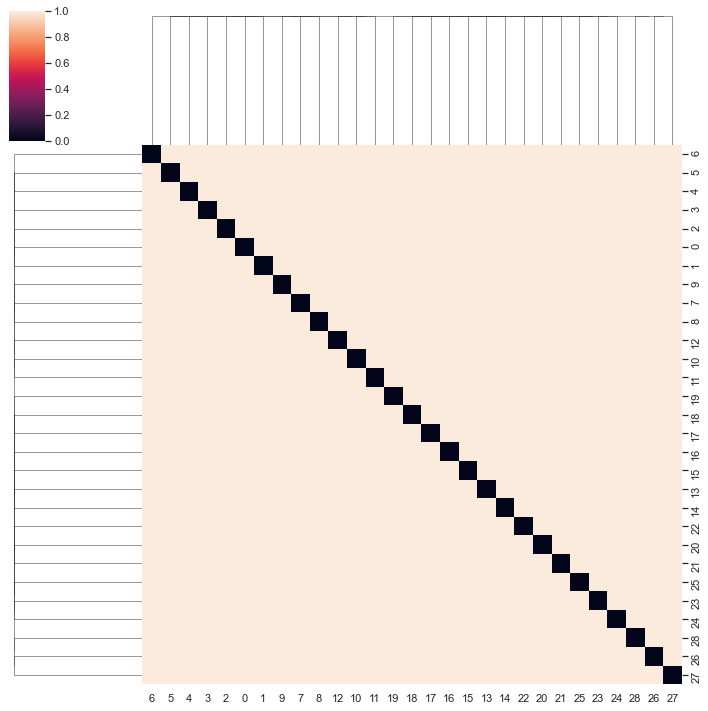

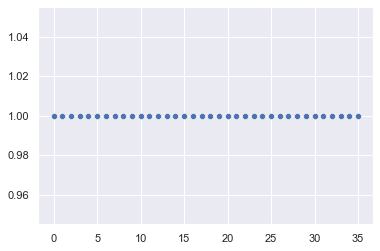

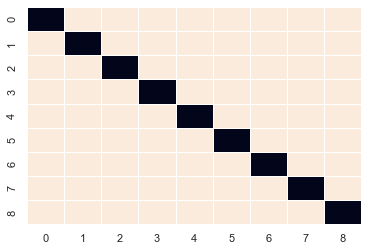

<Figure size 432x288 with 0 Axes>

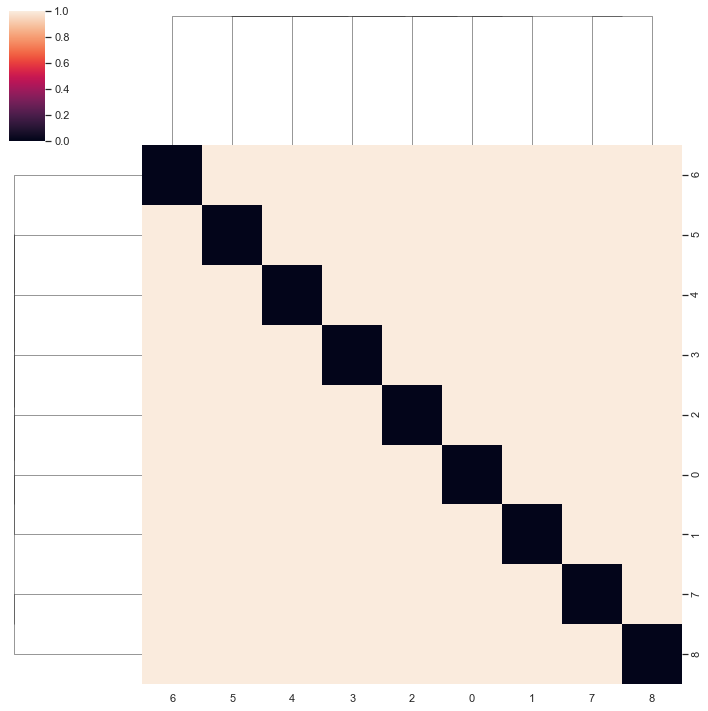

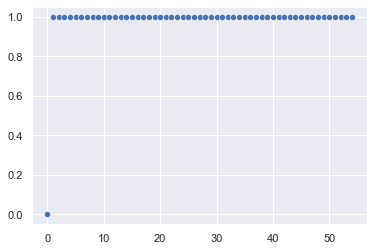

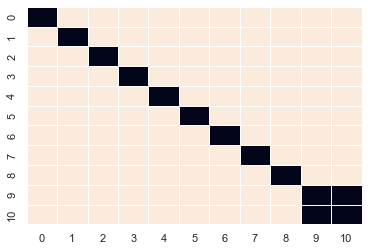

<Figure size 432x288 with 0 Axes>

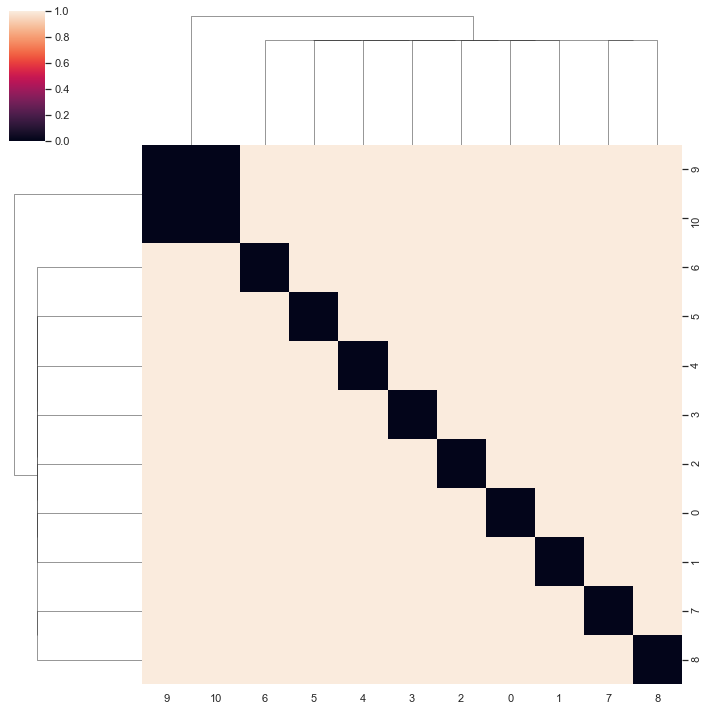

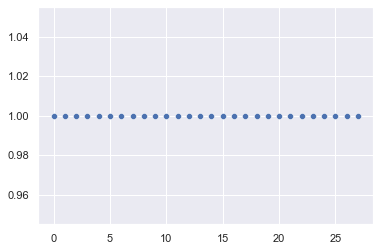

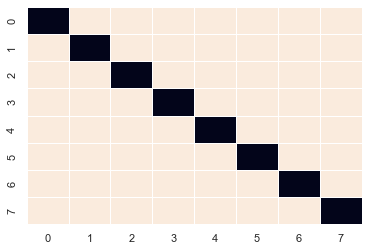

<Figure size 432x288 with 0 Axes>

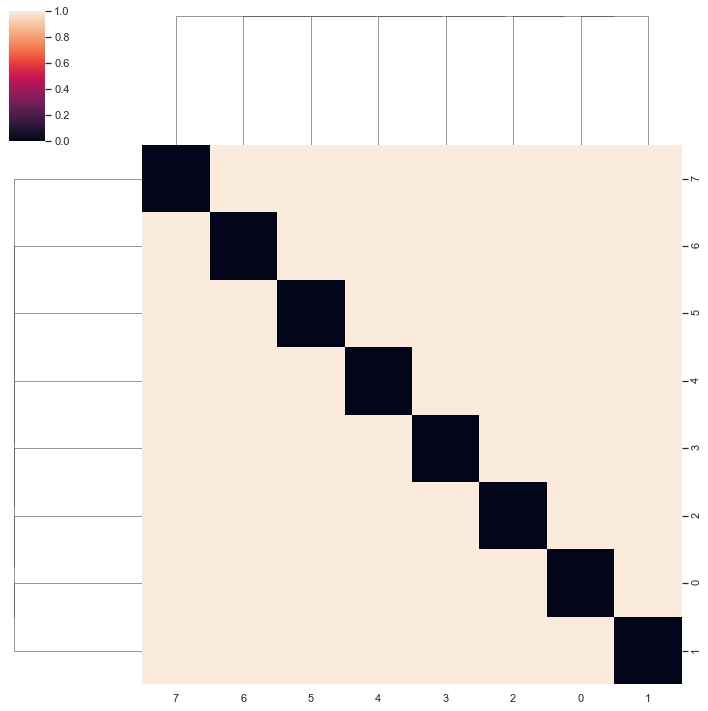

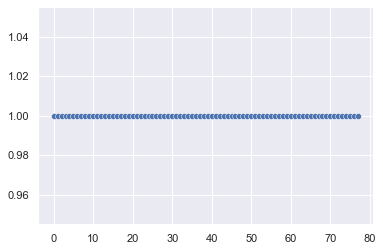

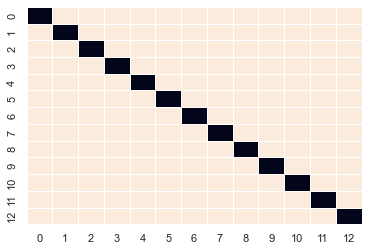

<Figure size 432x288 with 0 Axes>

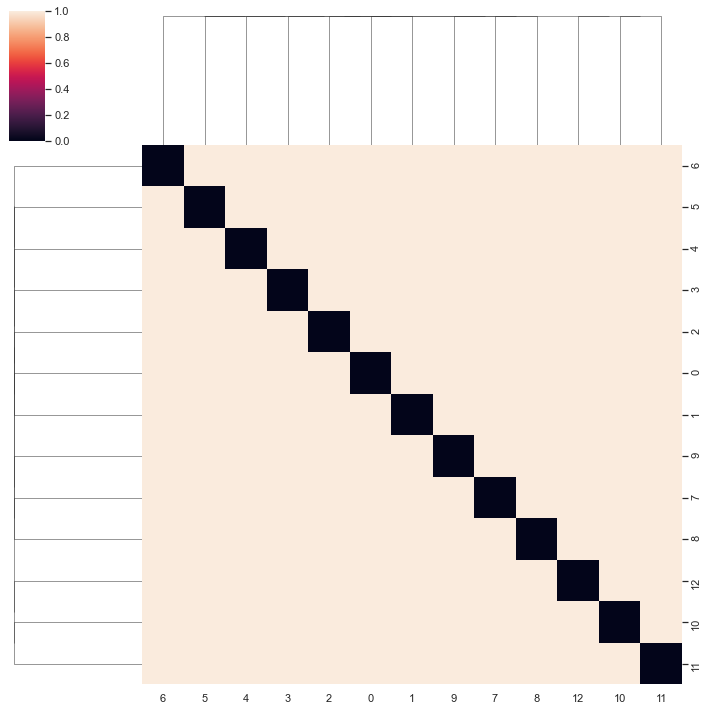

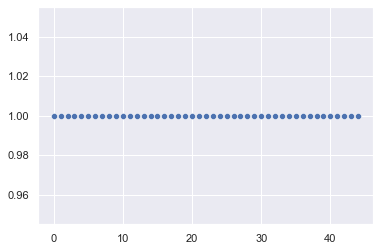

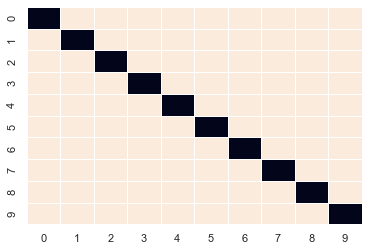

<Figure size 432x288 with 0 Axes>

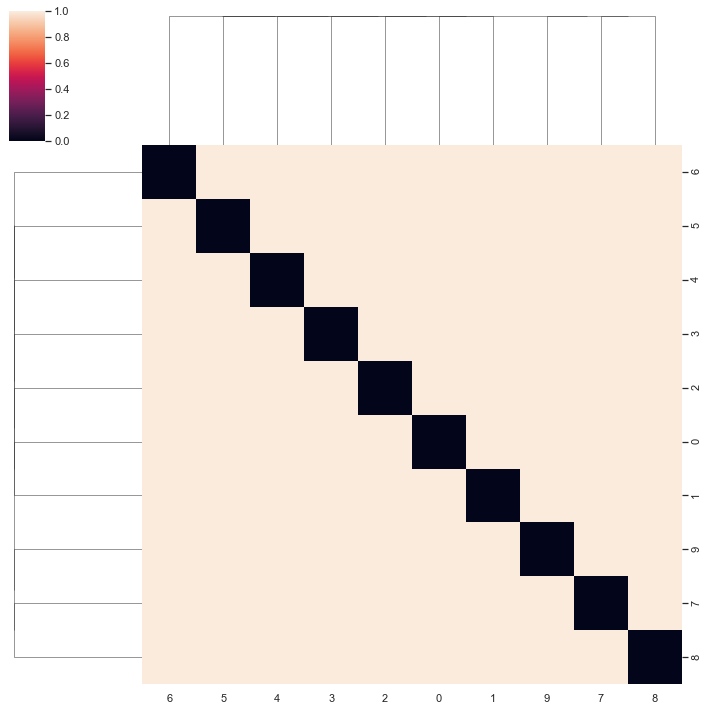

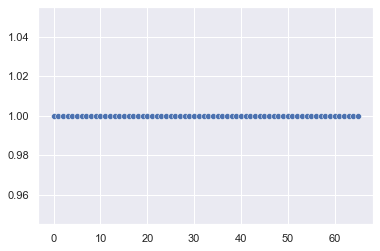

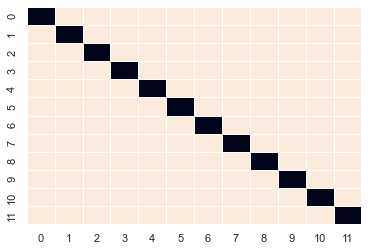

<Figure size 432x288 with 0 Axes>

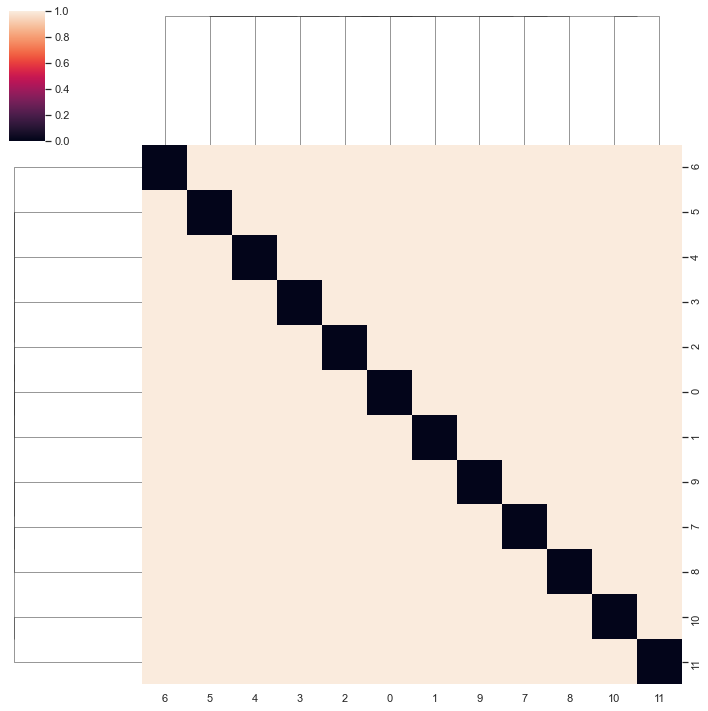

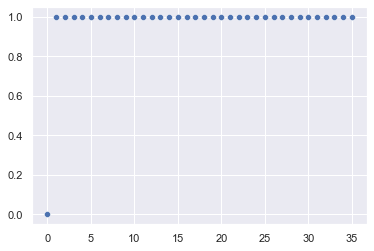

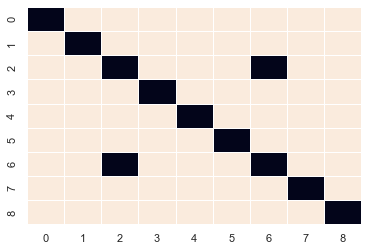

<Figure size 432x288 with 0 Axes>

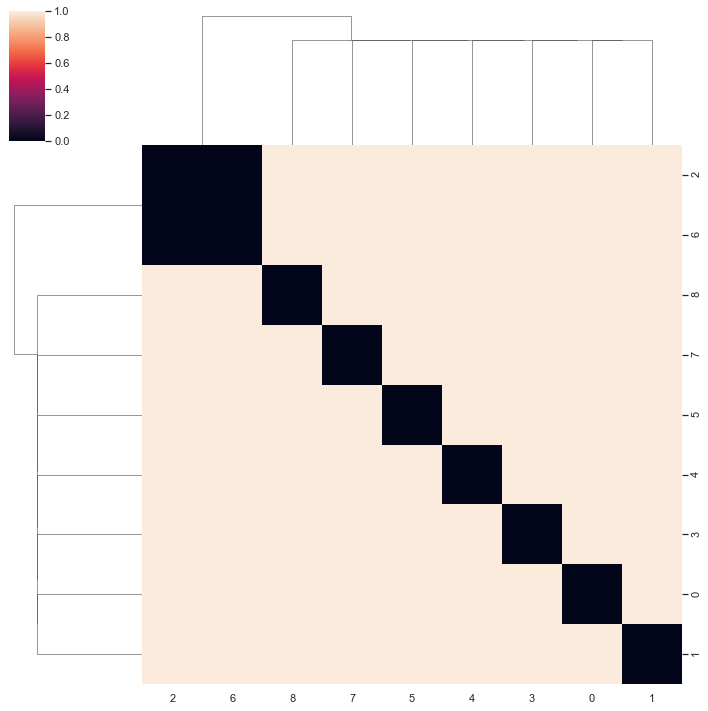

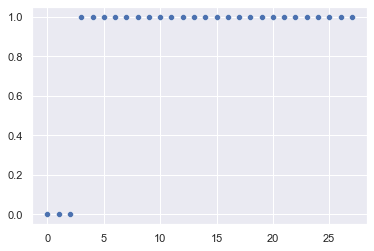

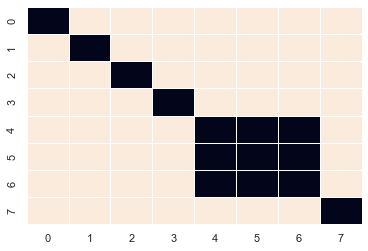

<Figure size 432x288 with 0 Axes>

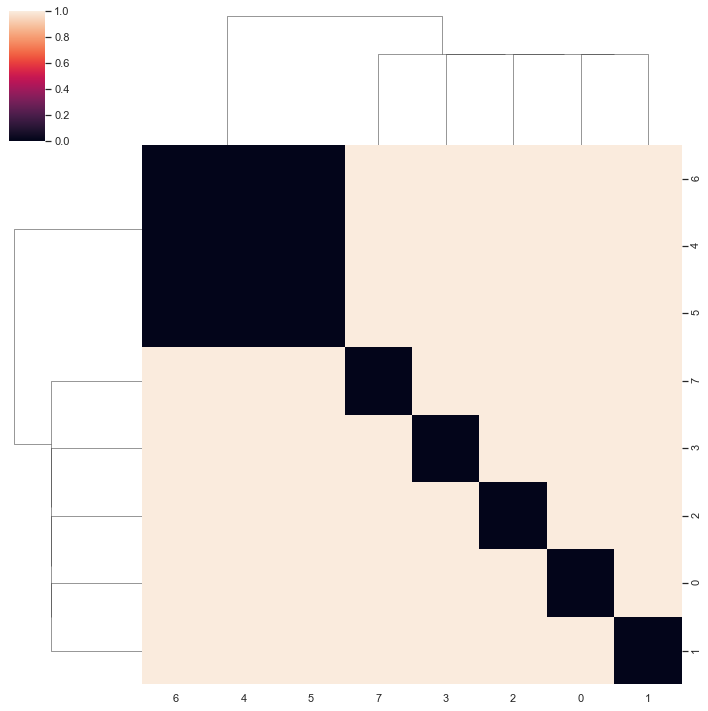

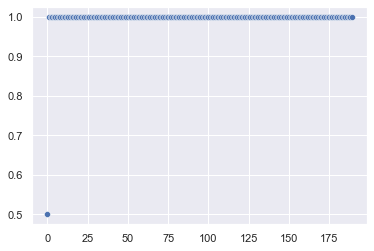

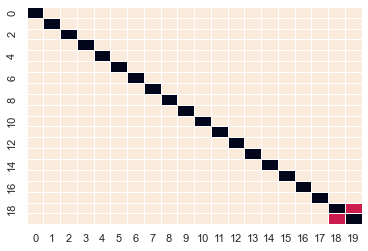

<Figure size 432x288 with 0 Axes>

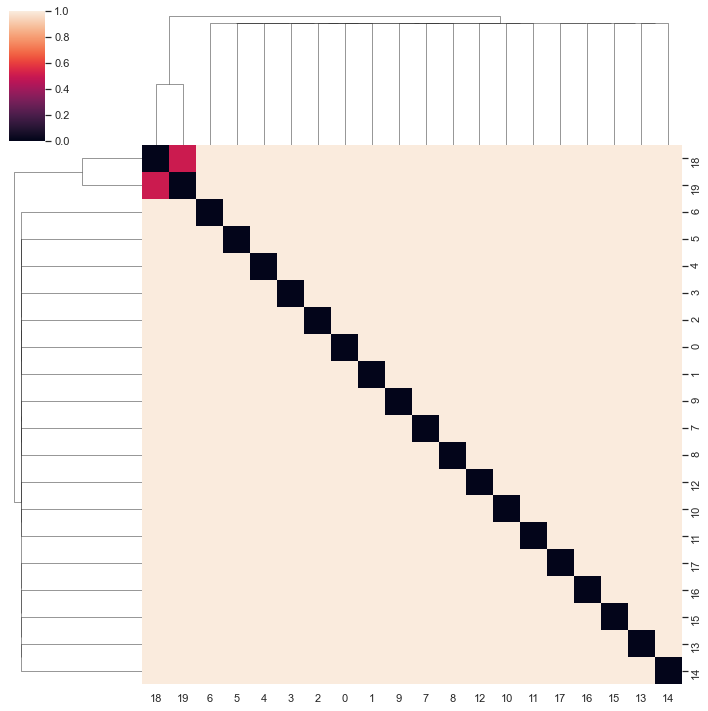

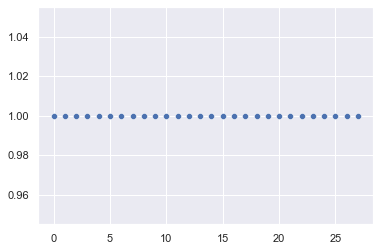

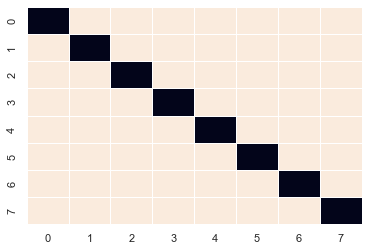

<Figure size 432x288 with 0 Axes>

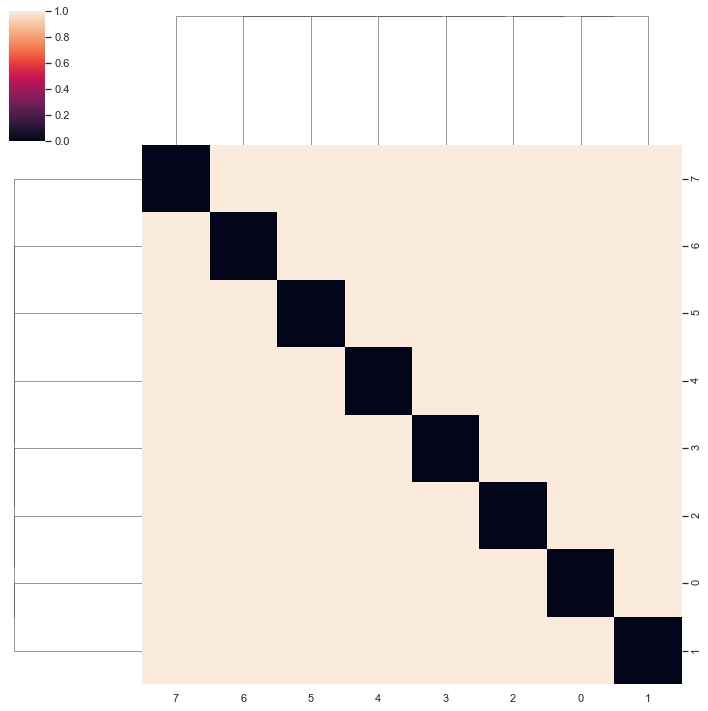

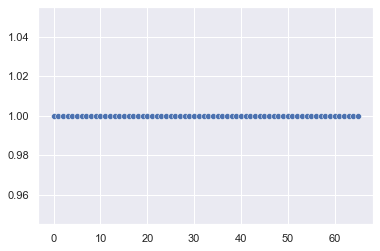

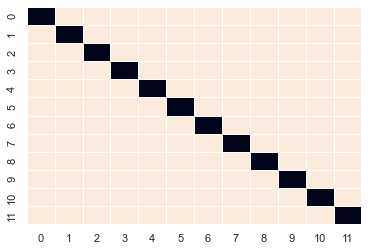

<Figure size 432x288 with 0 Axes>

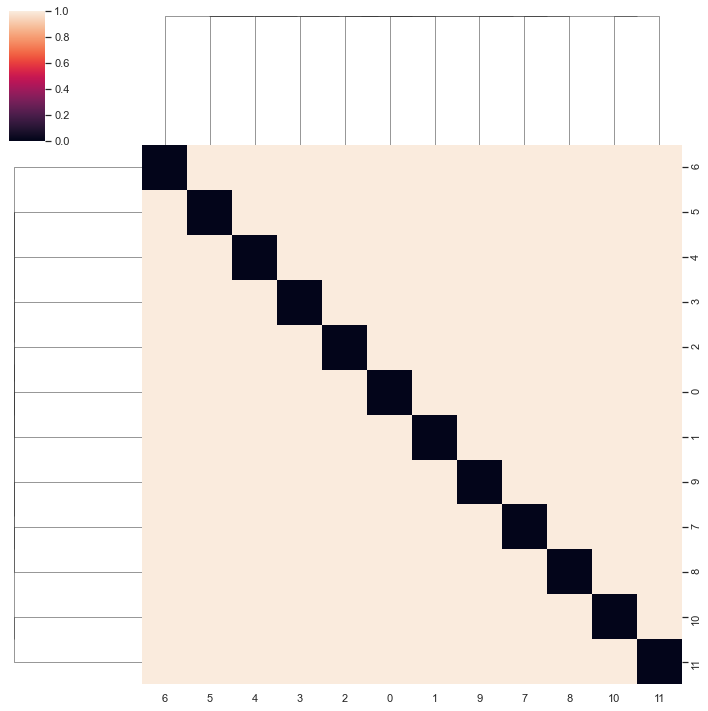

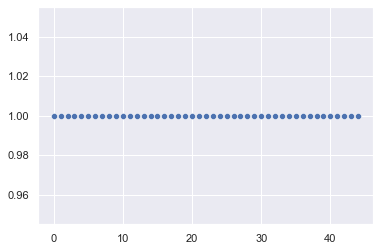

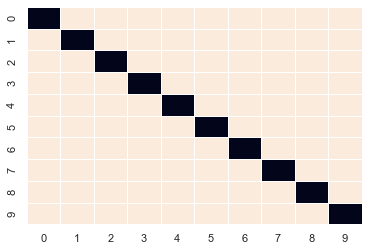

<Figure size 432x288 with 0 Axes>

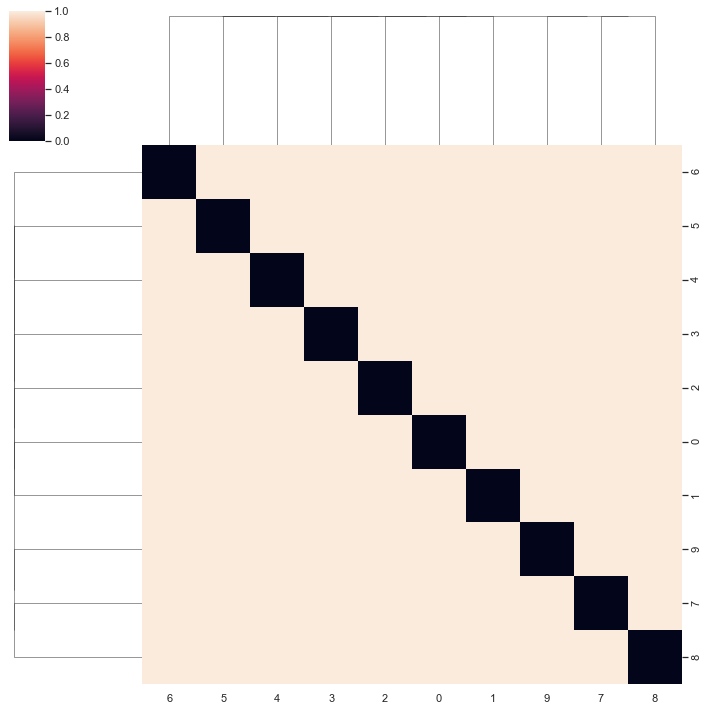

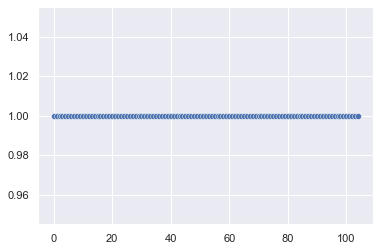

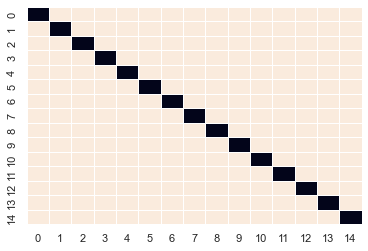

<Figure size 432x288 with 0 Axes>

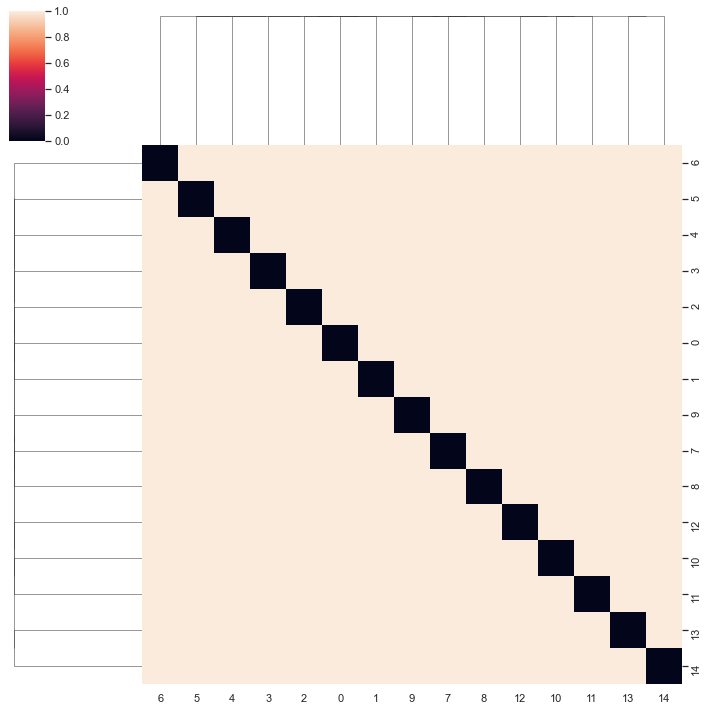

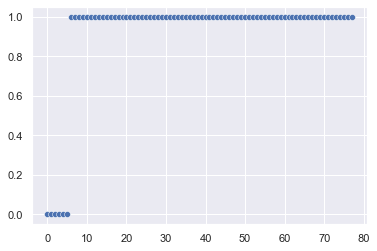

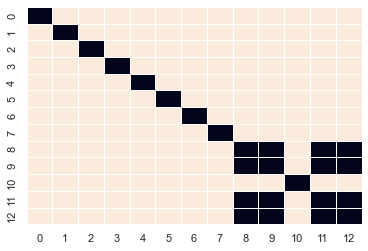

<Figure size 432x288 with 0 Axes>

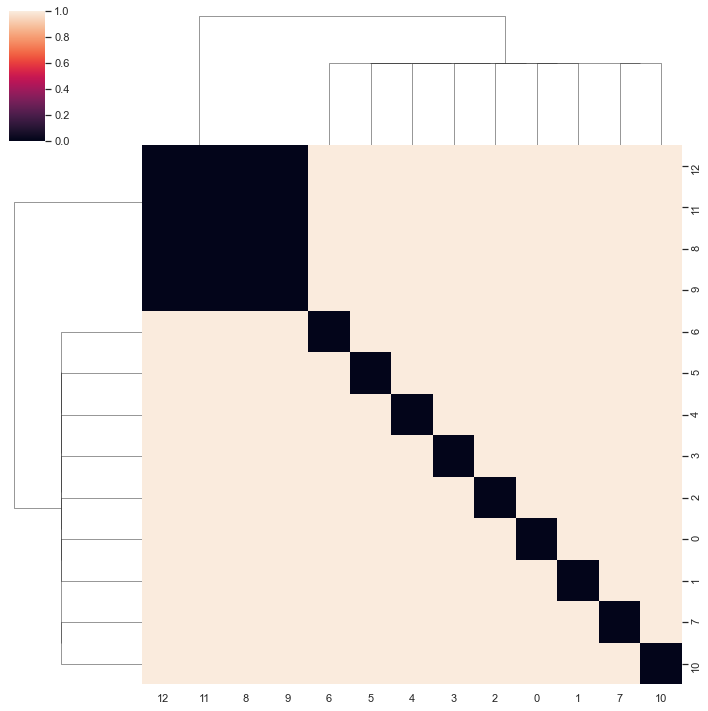

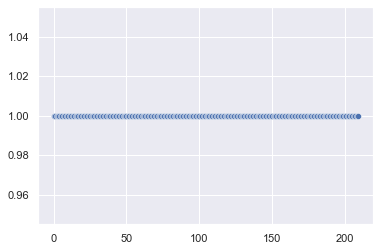

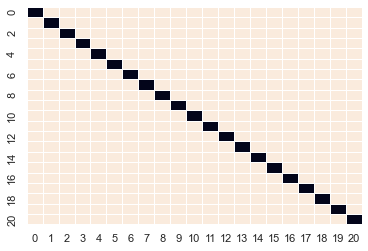

<Figure size 432x288 with 0 Axes>

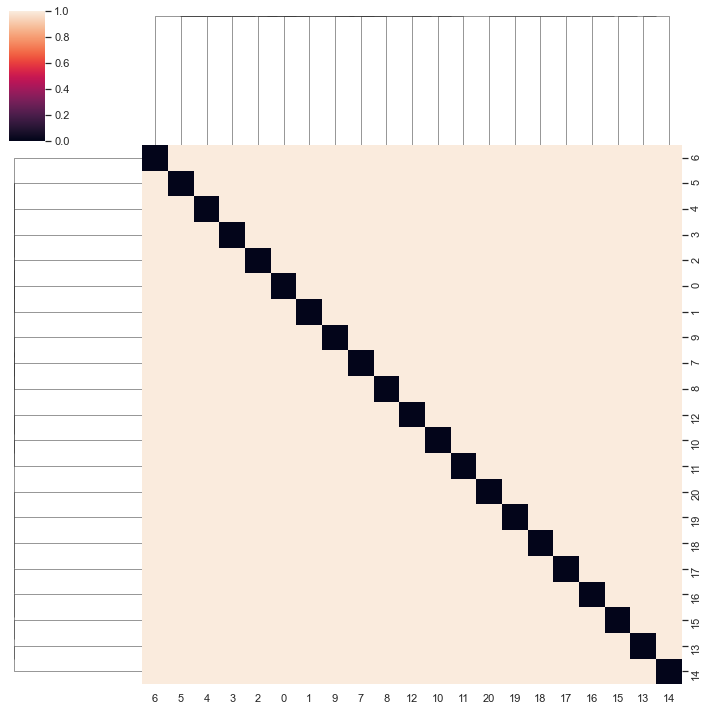

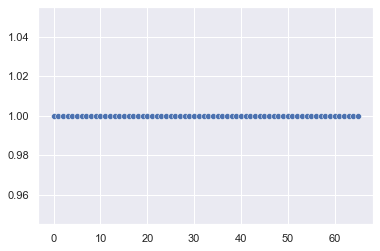

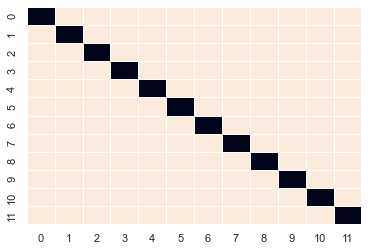

<Figure size 432x288 with 0 Axes>

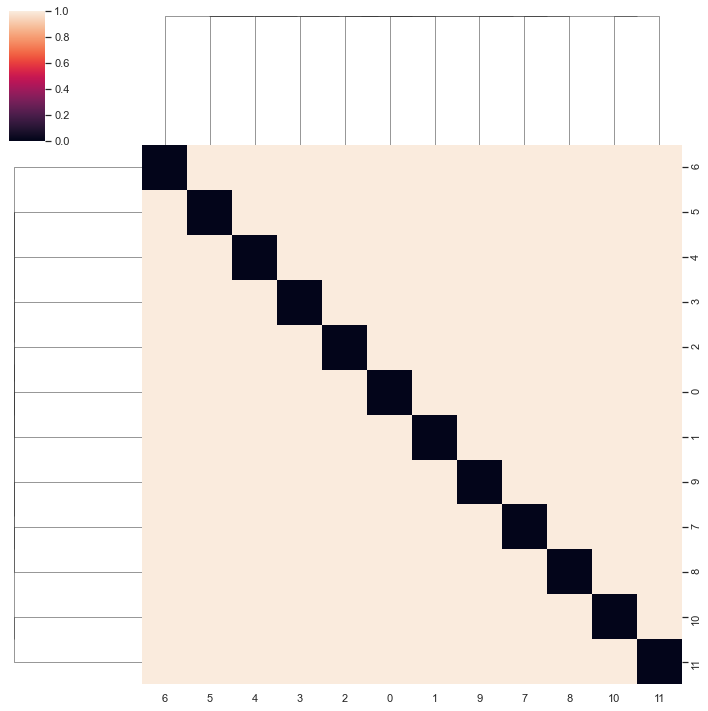

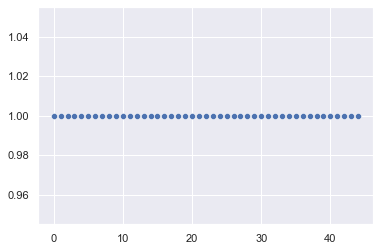

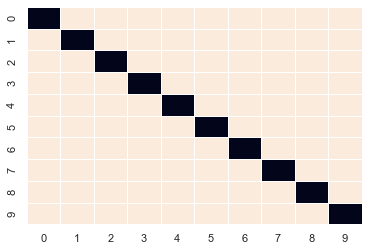

<Figure size 432x288 with 0 Axes>

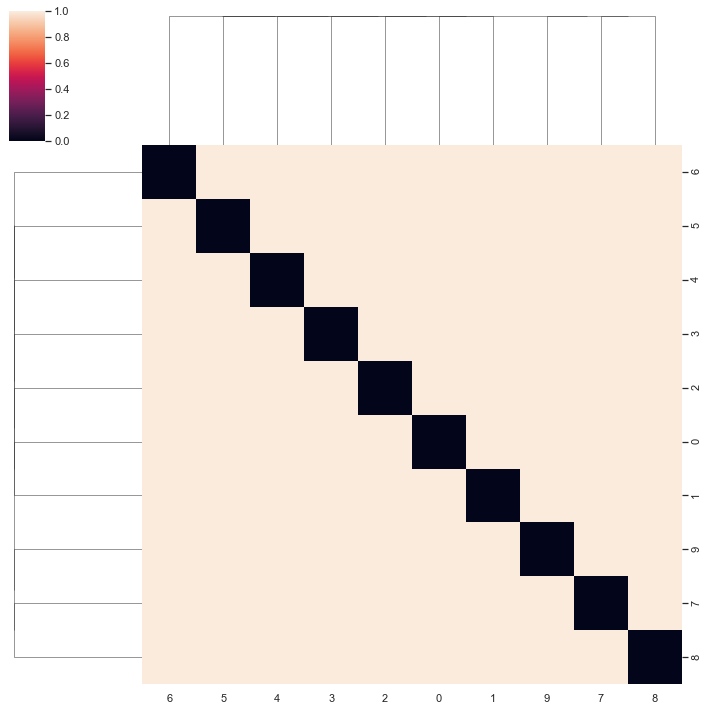

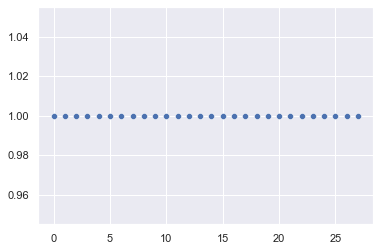

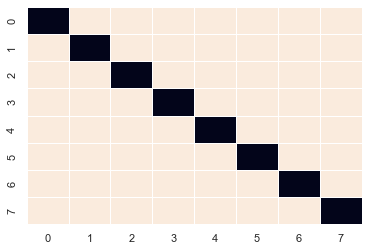

<Figure size 432x288 with 0 Axes>

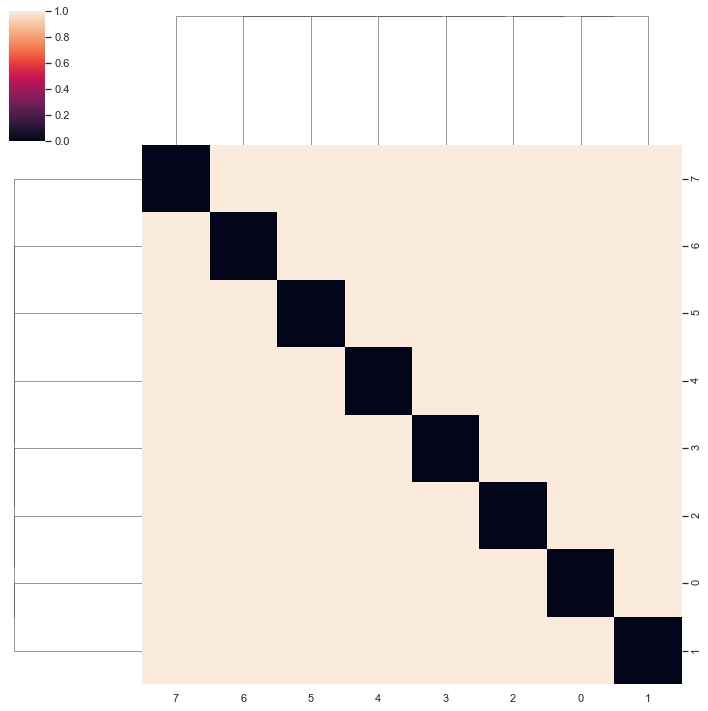

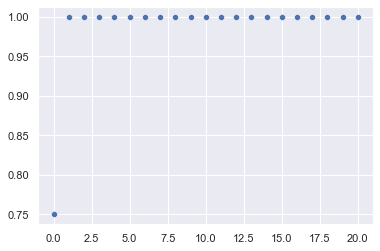

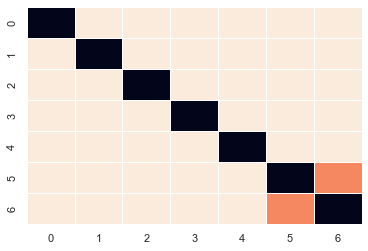

<Figure size 432x288 with 0 Axes>

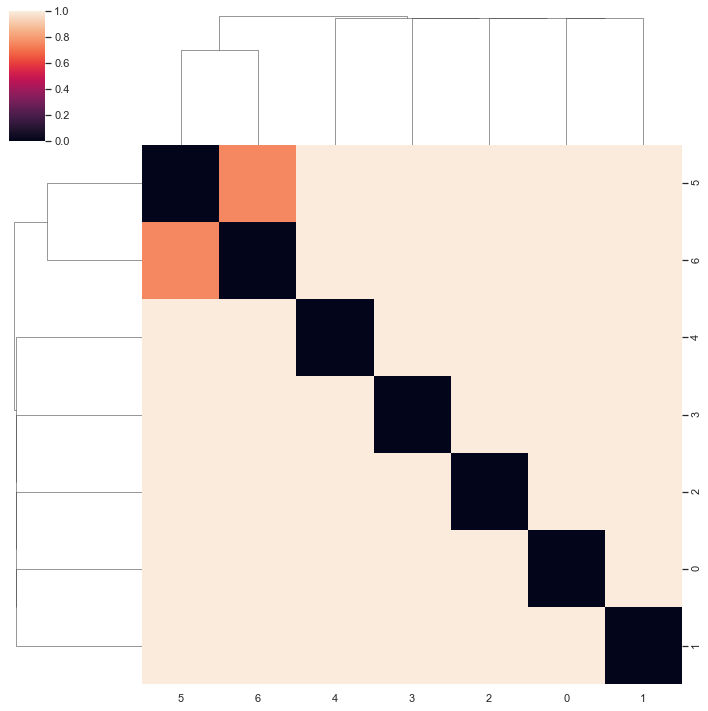

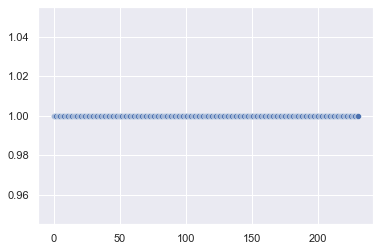

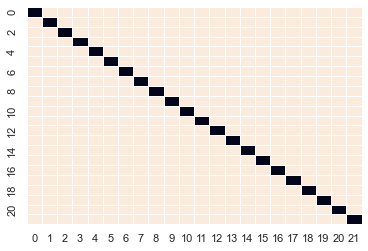

<Figure size 432x288 with 0 Axes>

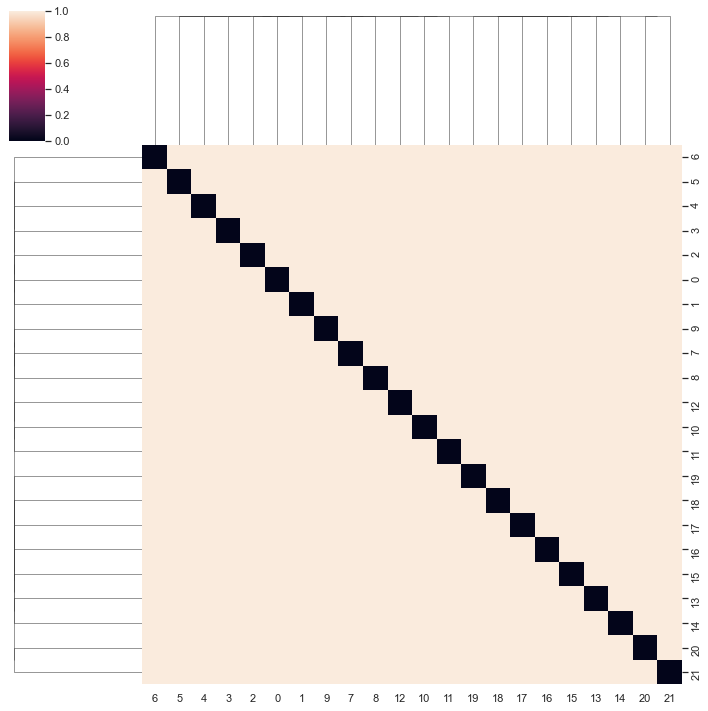

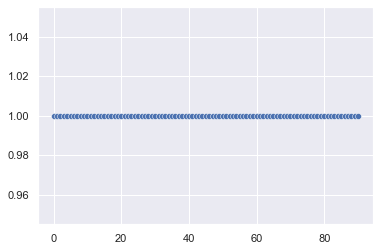

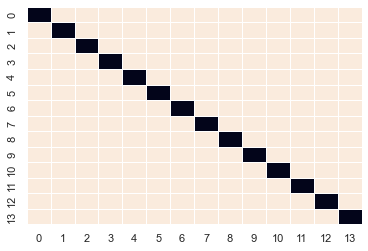

<Figure size 432x288 with 0 Axes>

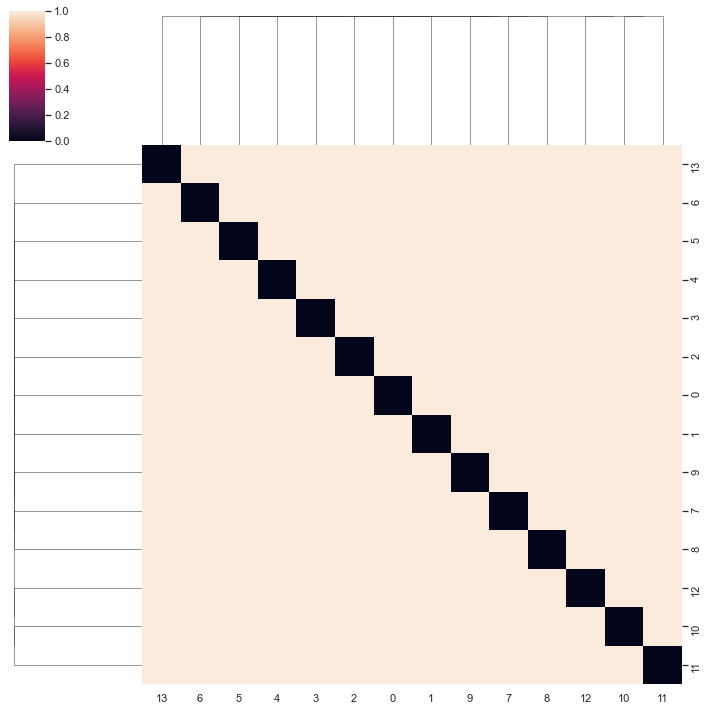

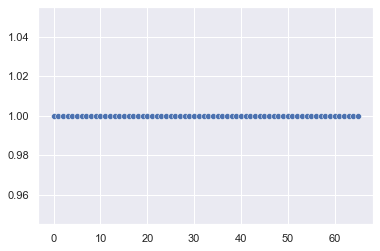

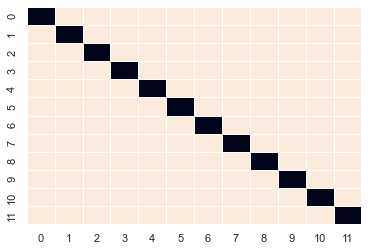

<Figure size 432x288 with 0 Axes>

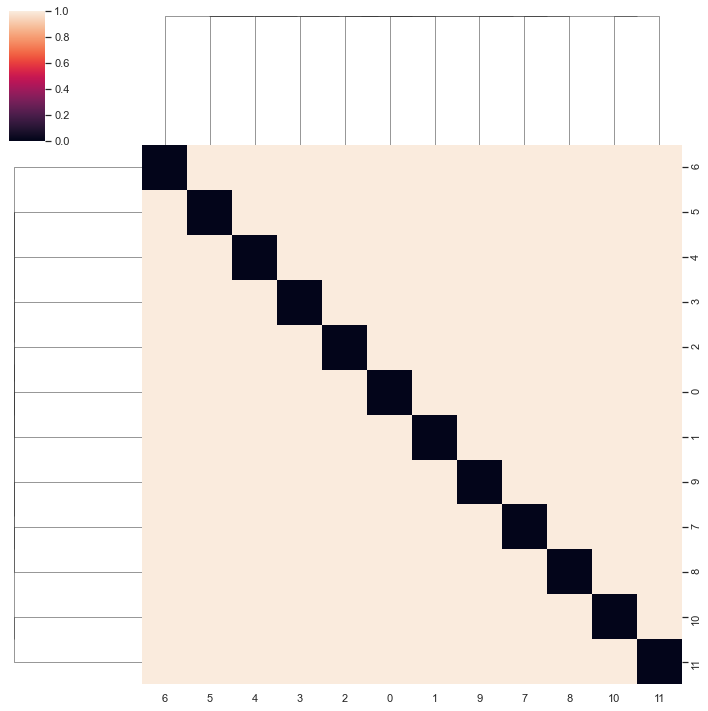

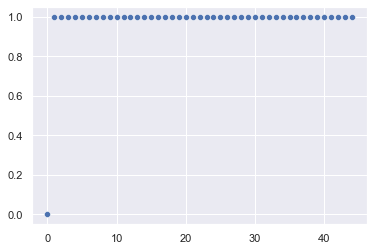

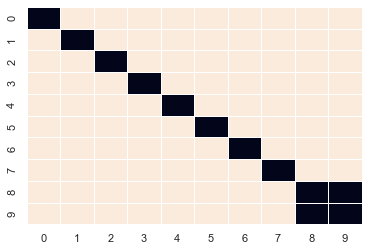

<Figure size 432x288 with 0 Axes>

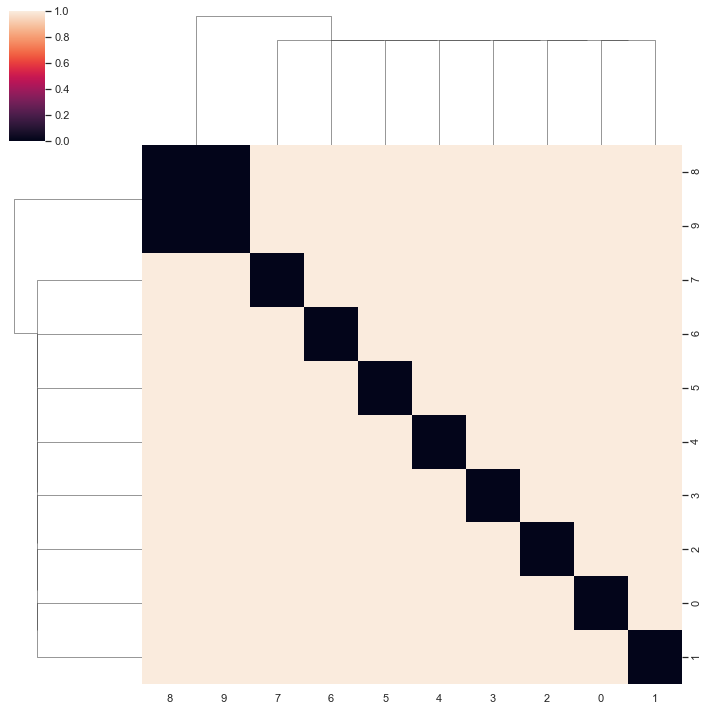

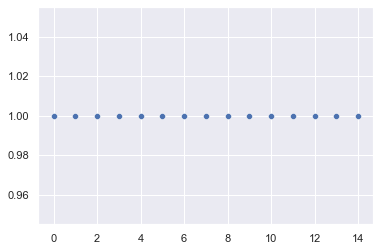

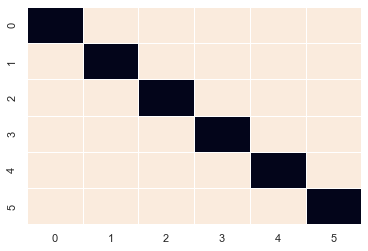

<Figure size 432x288 with 0 Axes>

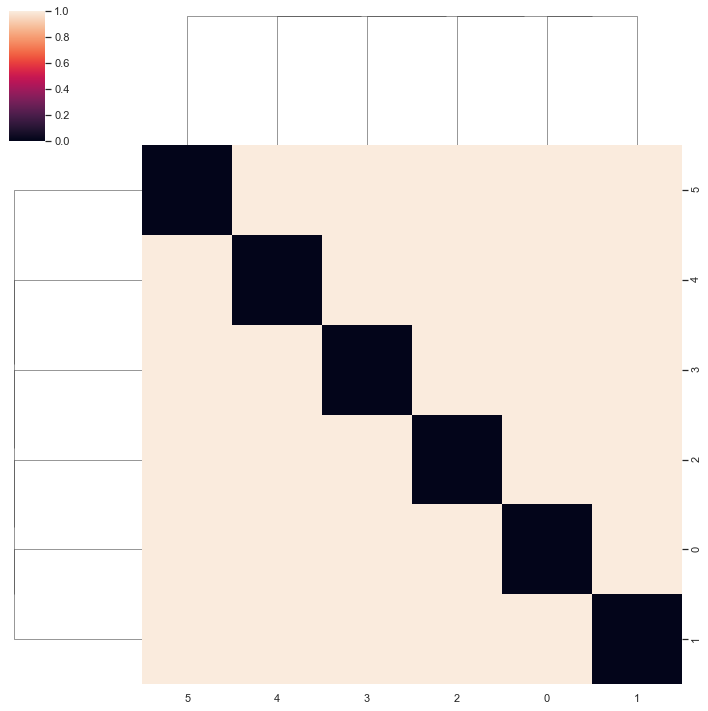

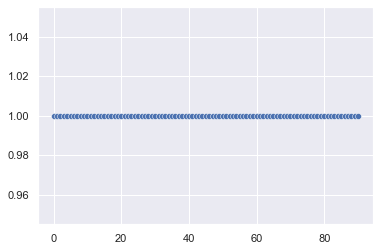

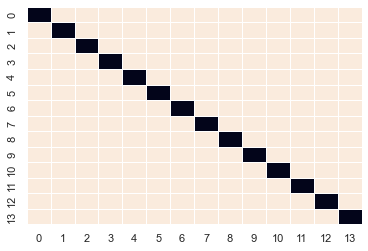

<Figure size 432x288 with 0 Axes>

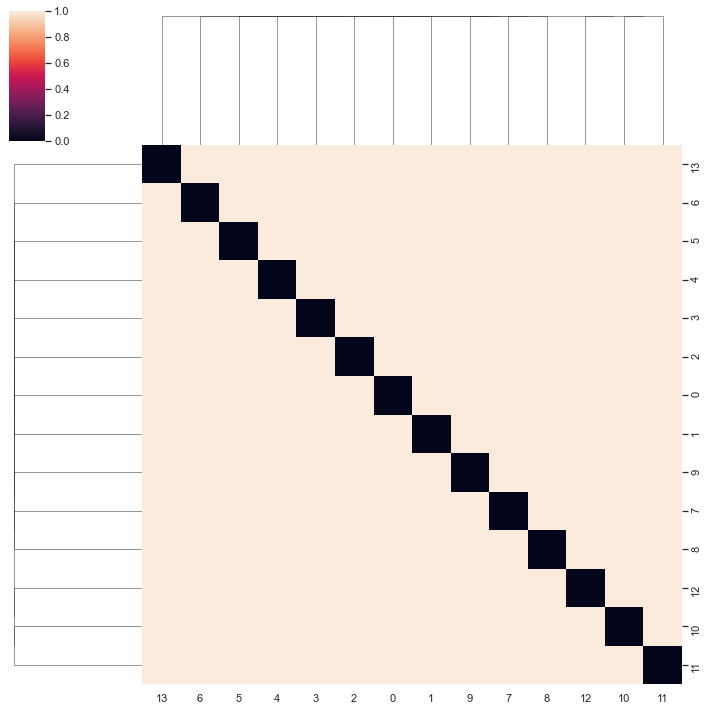

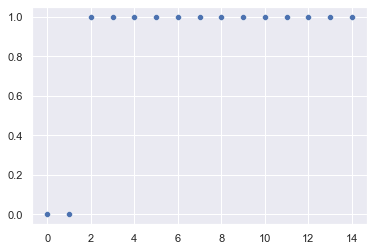

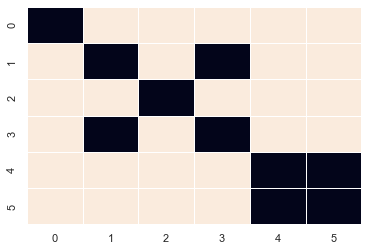

<Figure size 432x288 with 0 Axes>

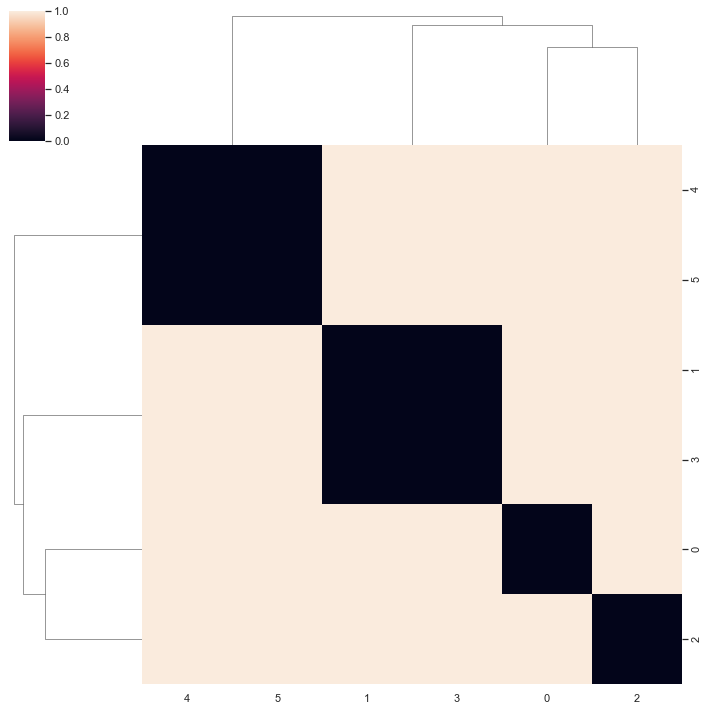

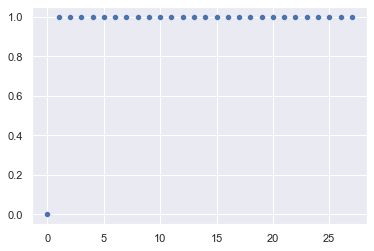

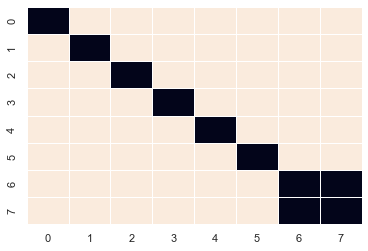

<Figure size 432x288 with 0 Axes>

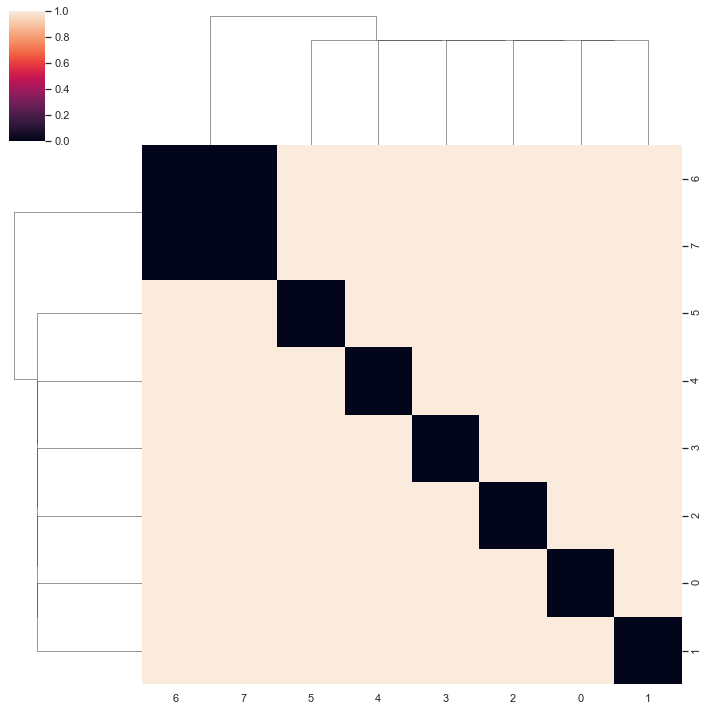

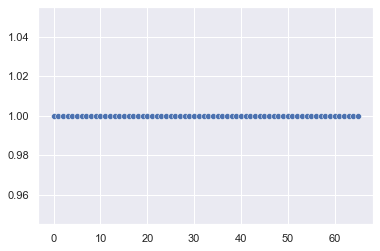

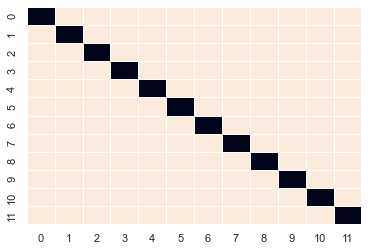

<Figure size 432x288 with 0 Axes>

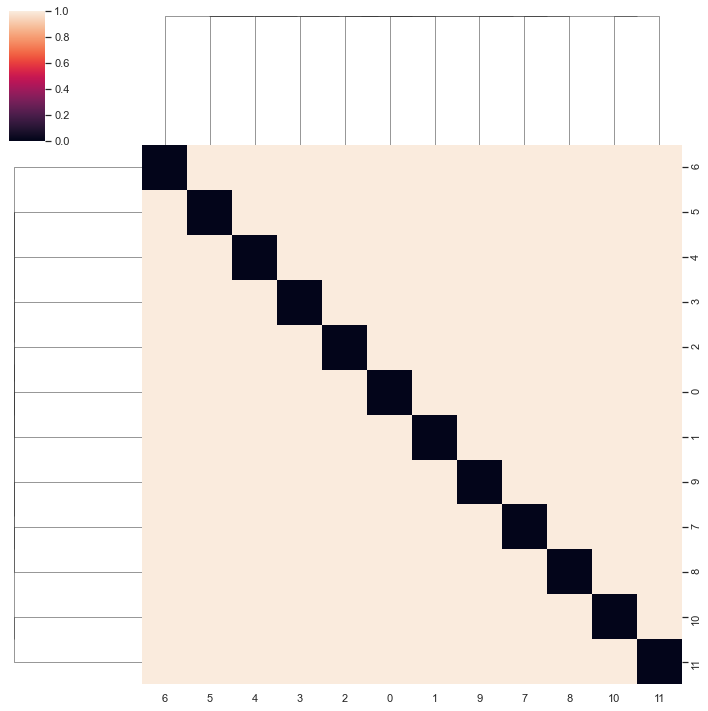

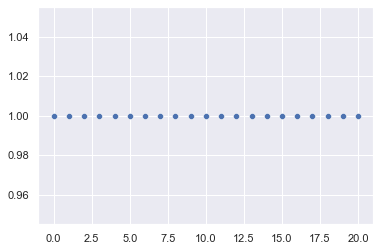

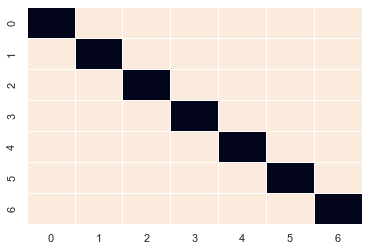

<Figure size 432x288 with 0 Axes>

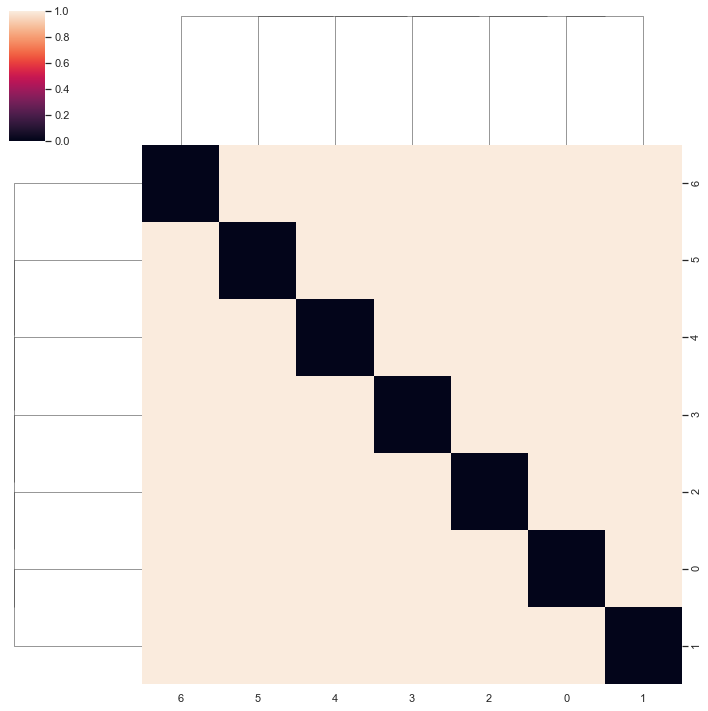

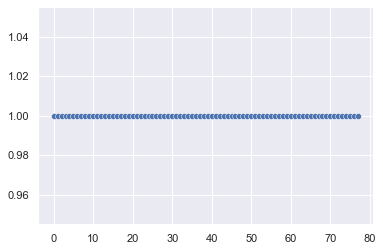

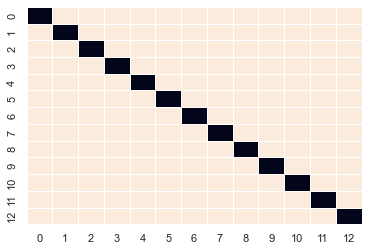

<Figure size 432x288 with 0 Axes>

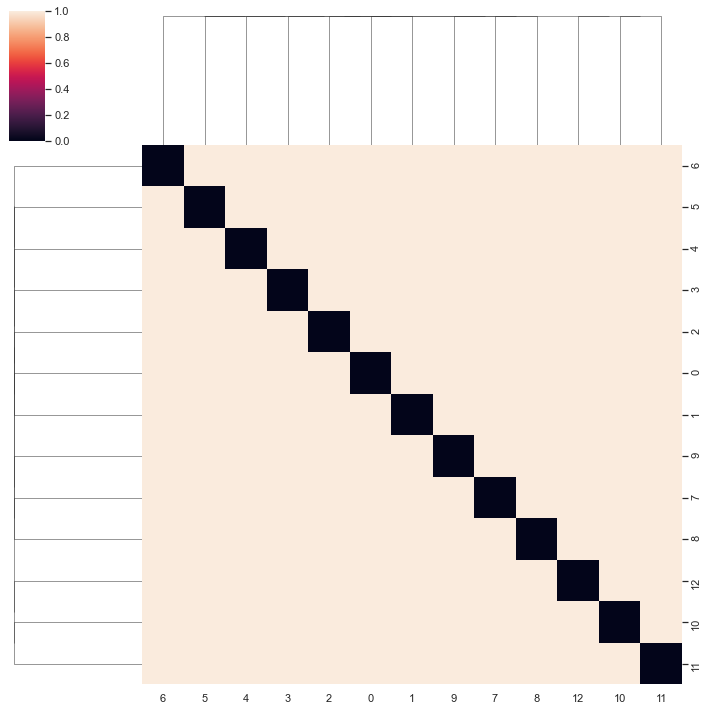

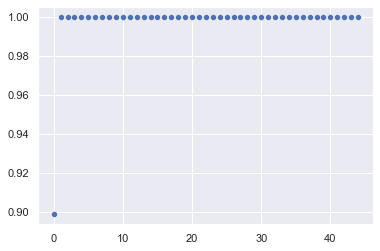

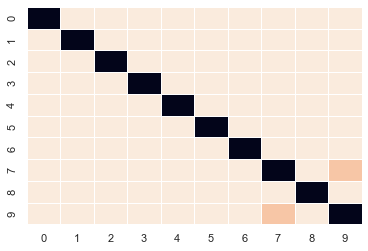

<Figure size 432x288 with 0 Axes>

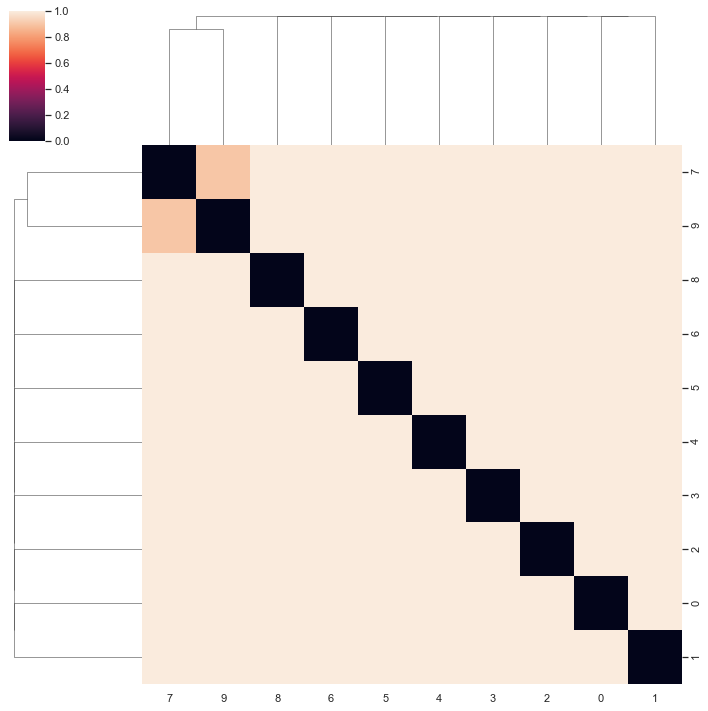

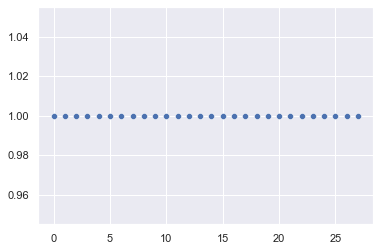

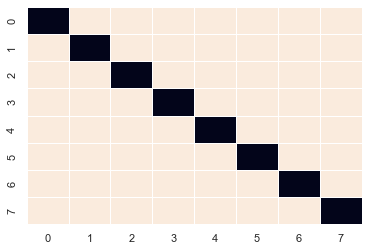

<Figure size 432x288 with 0 Axes>

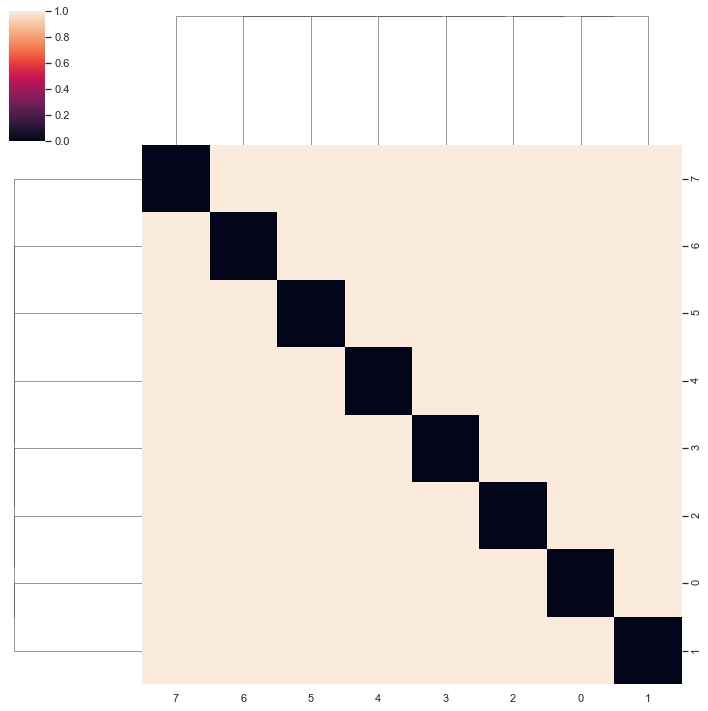

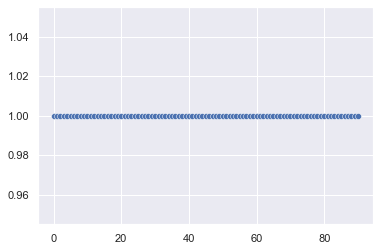

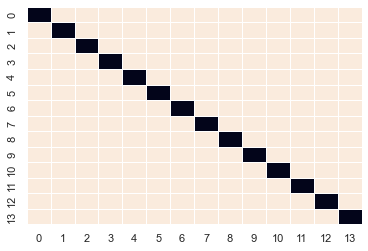

<Figure size 432x288 with 0 Axes>

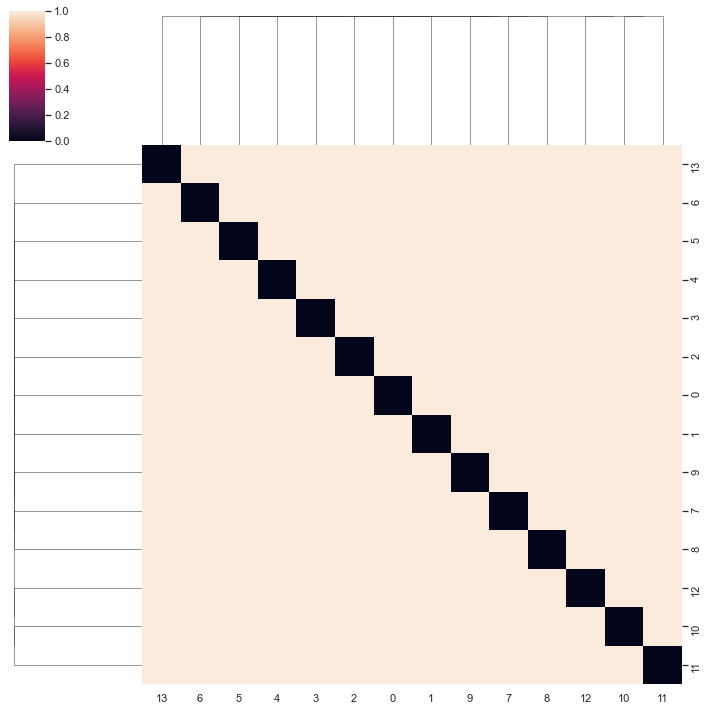

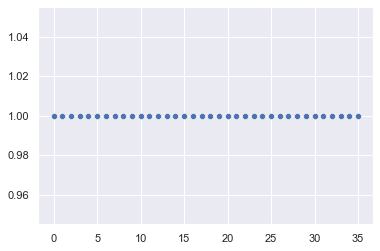

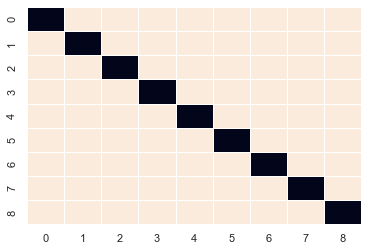

<Figure size 432x288 with 0 Axes>

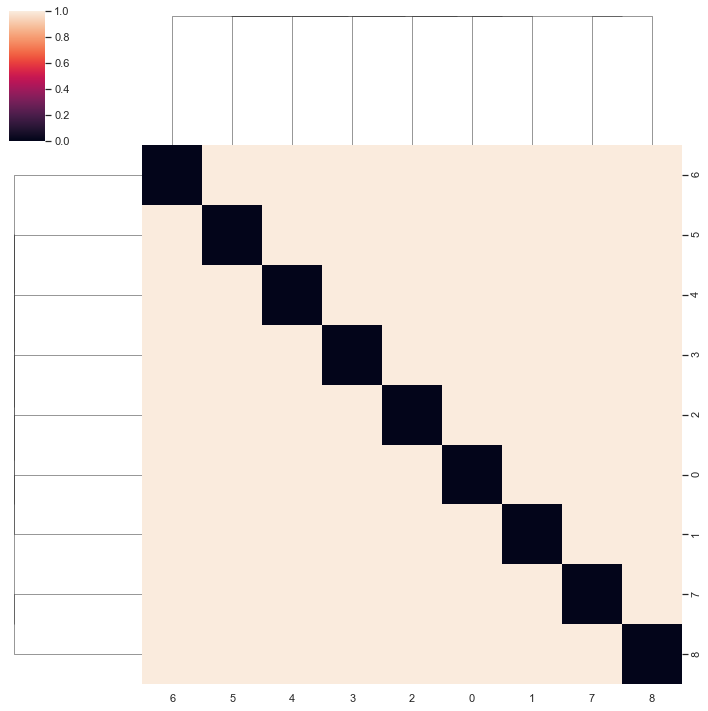

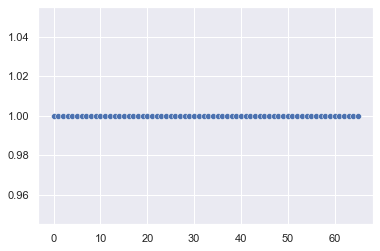

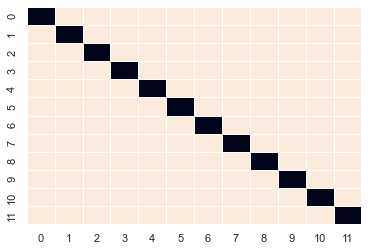

<Figure size 432x288 with 0 Axes>

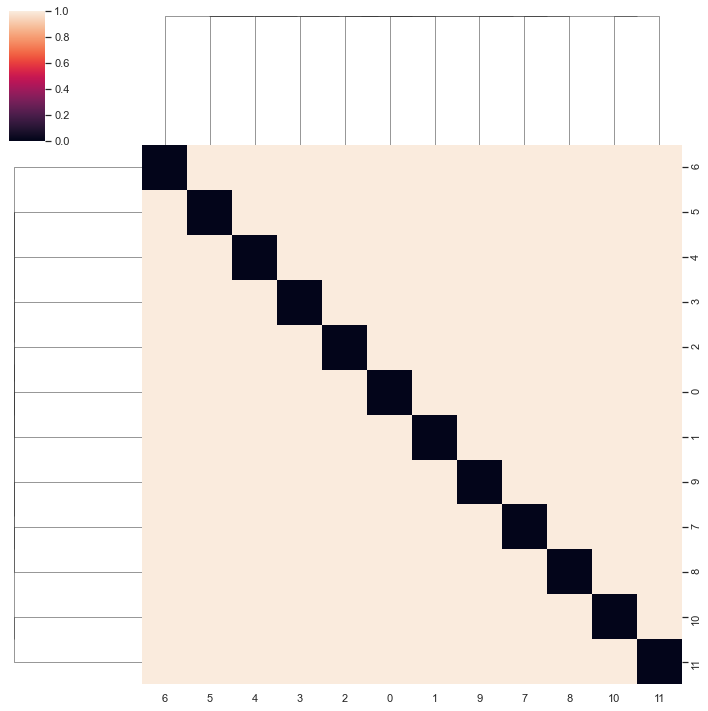

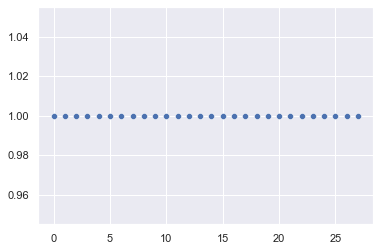

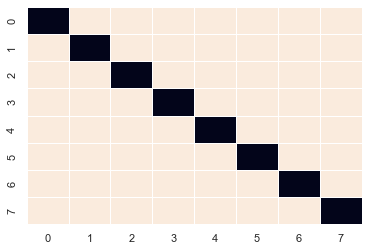

<Figure size 432x288 with 0 Axes>

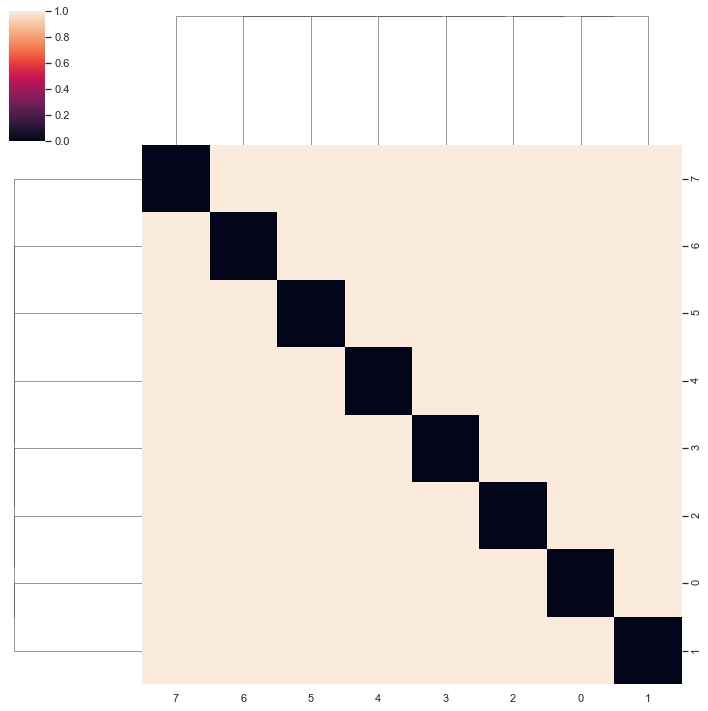

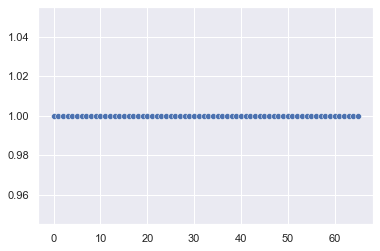

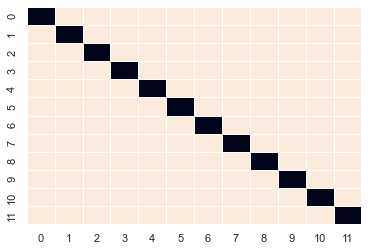

<Figure size 432x288 with 0 Axes>

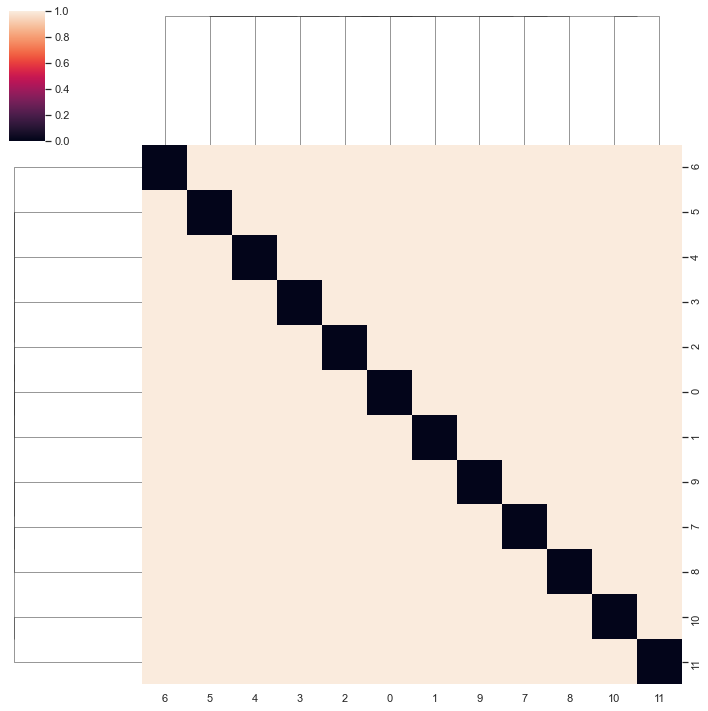

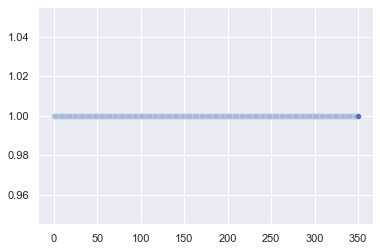

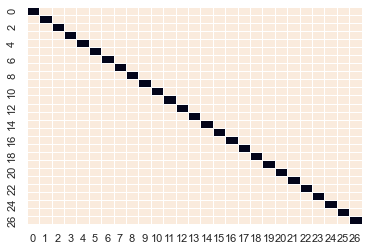

<Figure size 432x288 with 0 Axes>

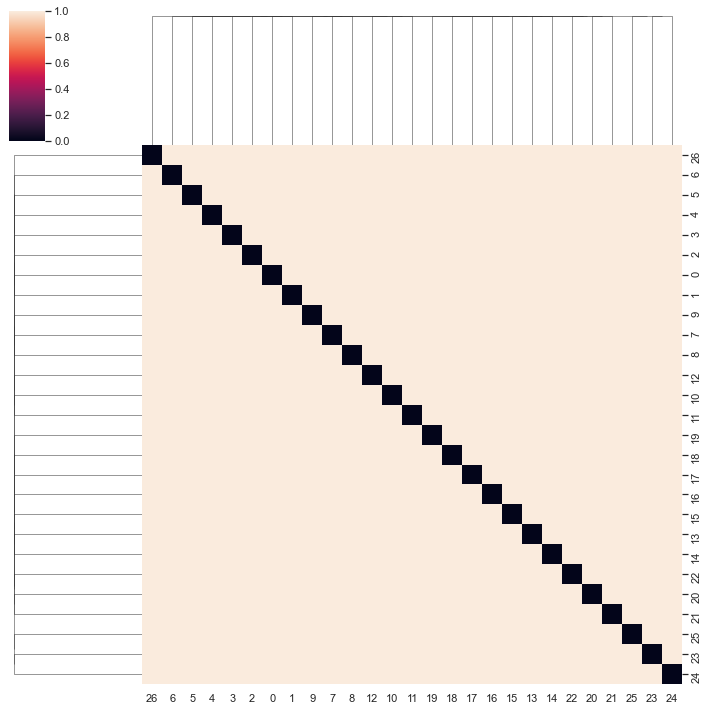

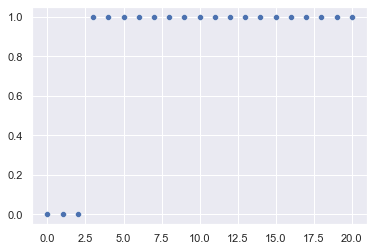

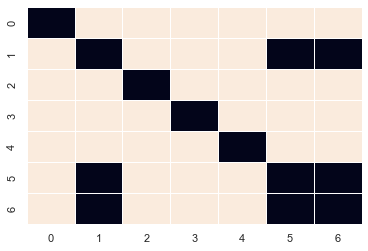

<Figure size 432x288 with 0 Axes>

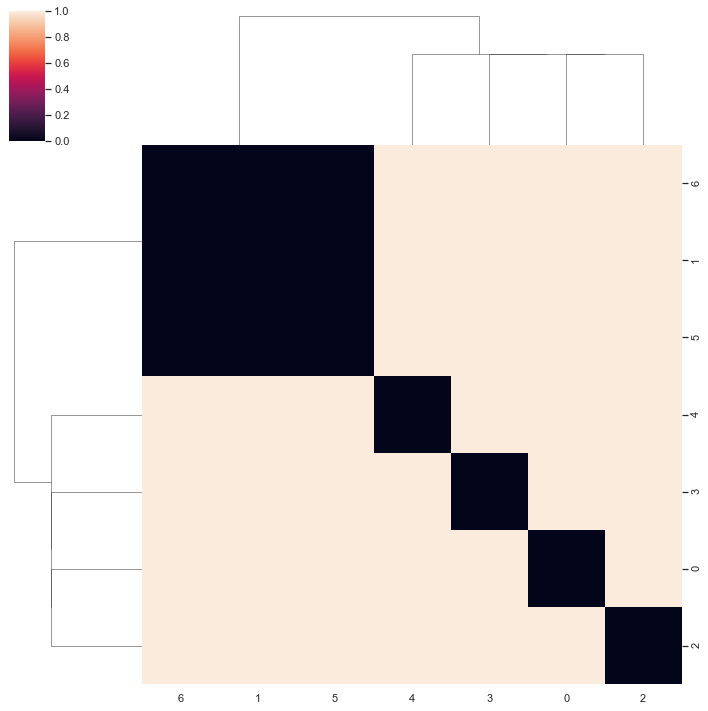

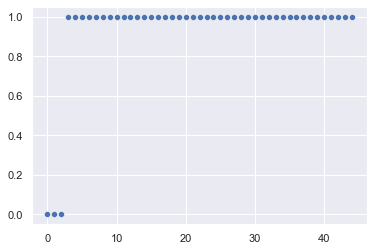

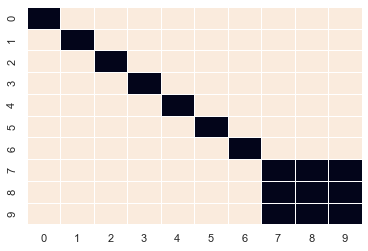

<Figure size 432x288 with 0 Axes>

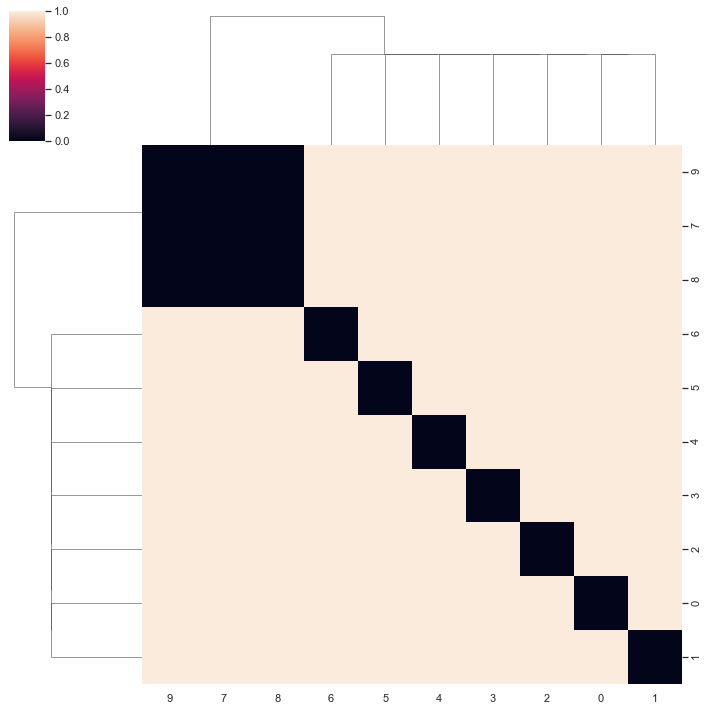

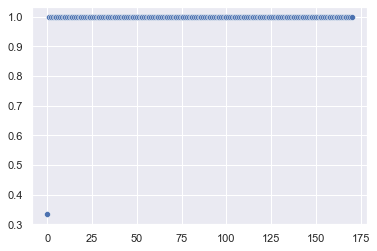

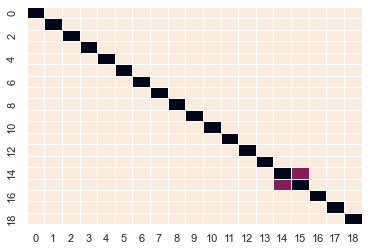

<Figure size 432x288 with 0 Axes>

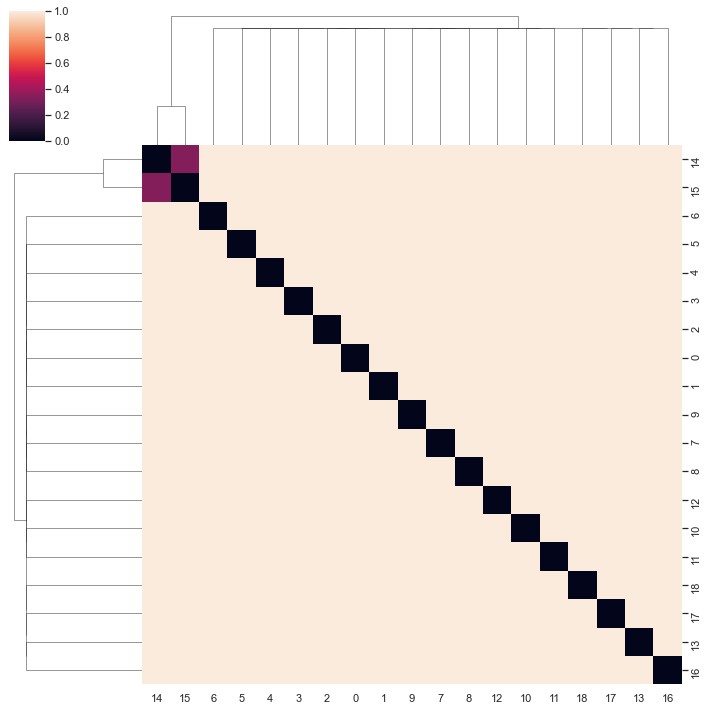

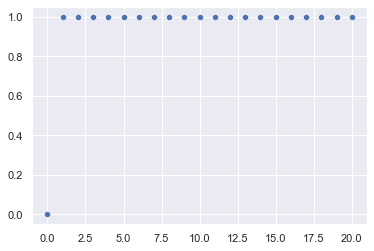

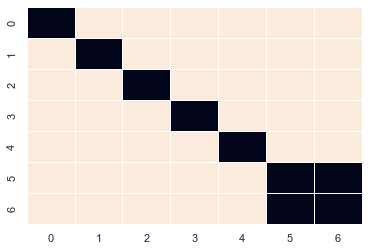

<Figure size 432x288 with 0 Axes>

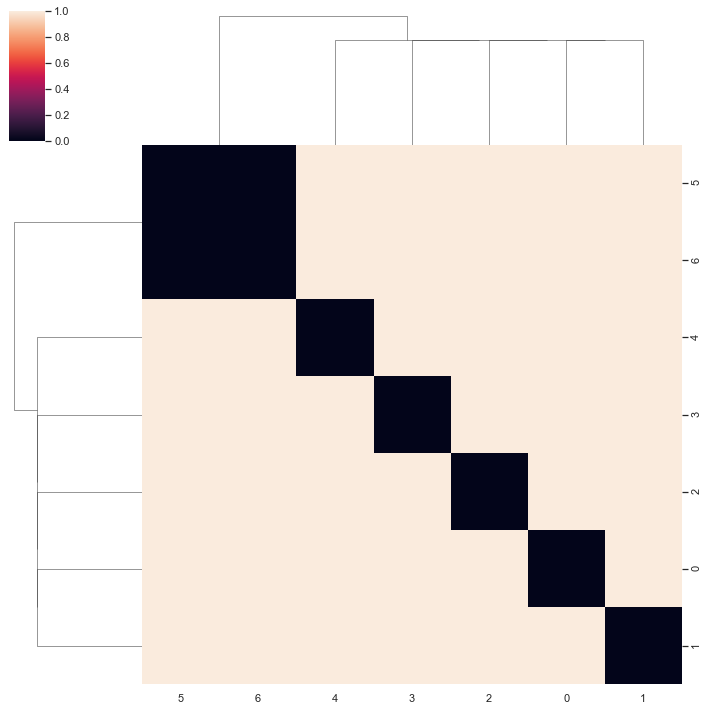

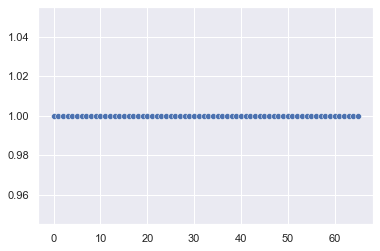

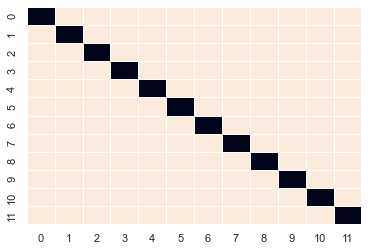

<Figure size 432x288 with 0 Axes>

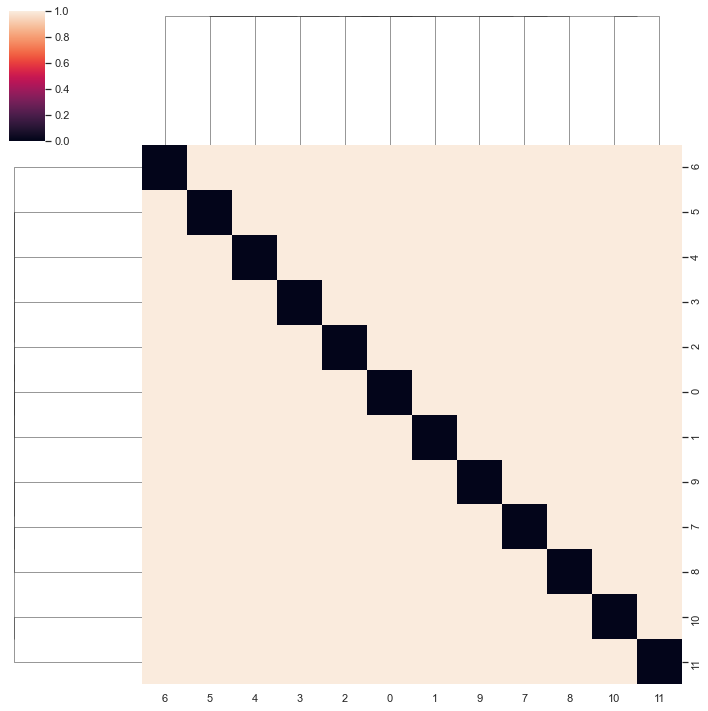

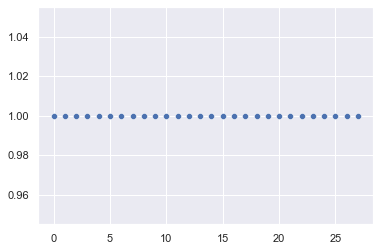

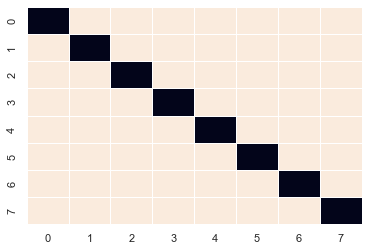

<Figure size 432x288 with 0 Axes>

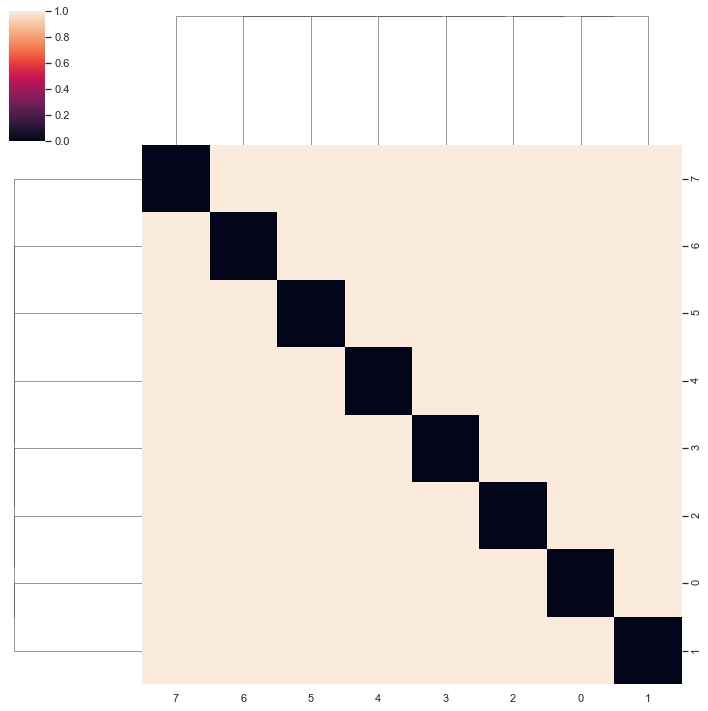

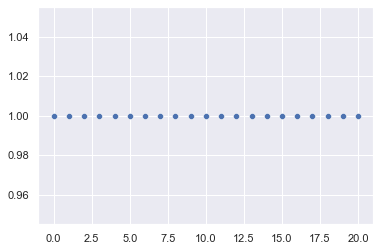

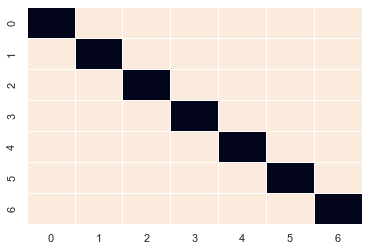

<Figure size 432x288 with 0 Axes>

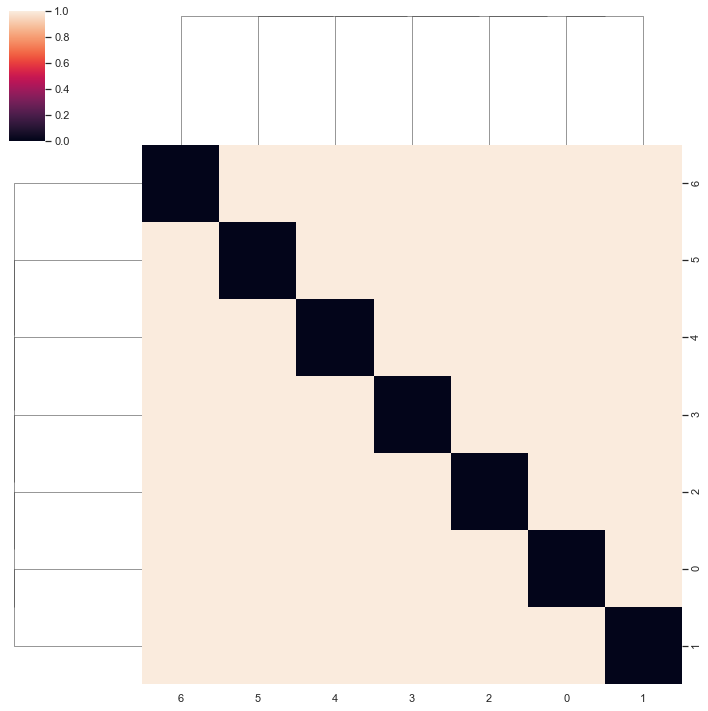

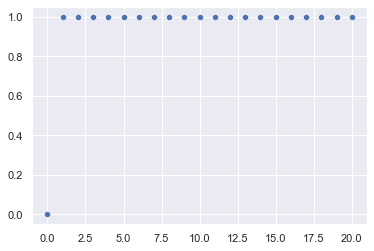

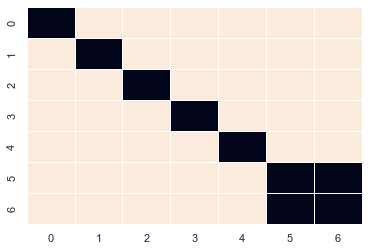

<Figure size 432x288 with 0 Axes>

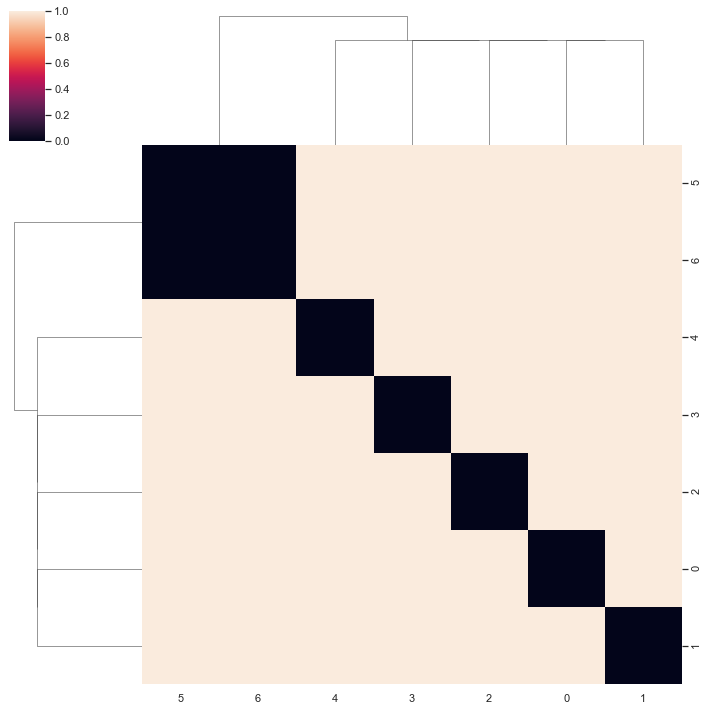

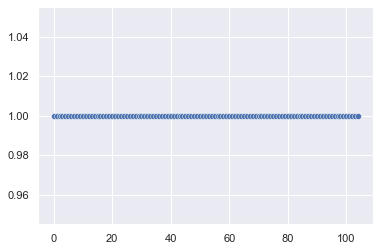

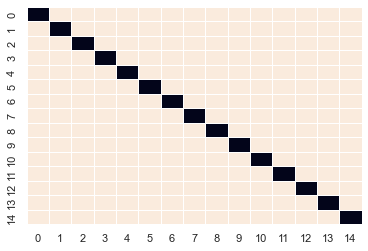

<Figure size 432x288 with 0 Axes>

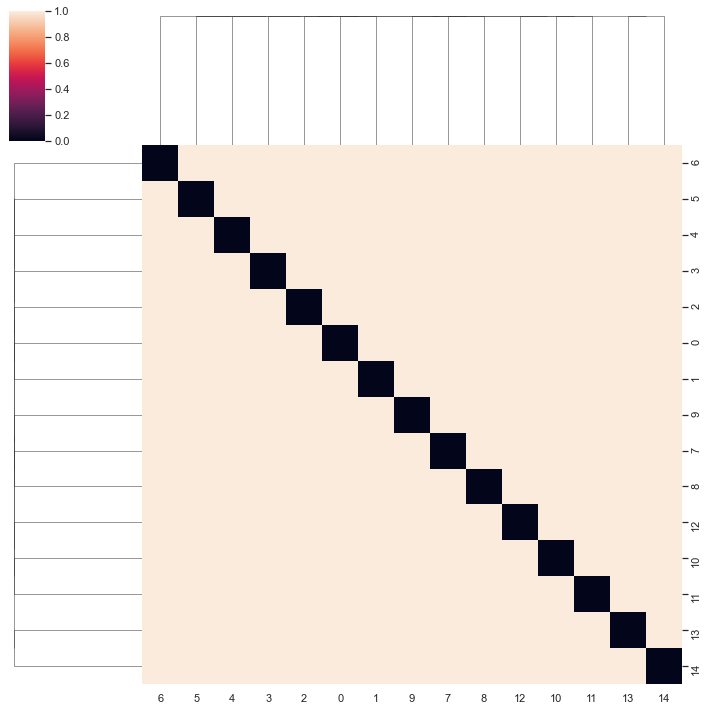

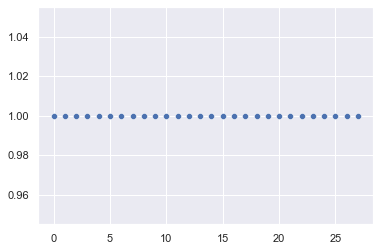

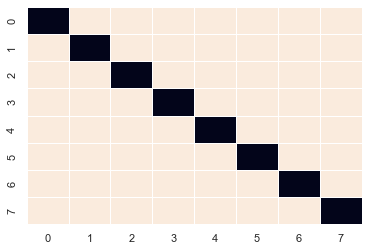

<Figure size 432x288 with 0 Axes>

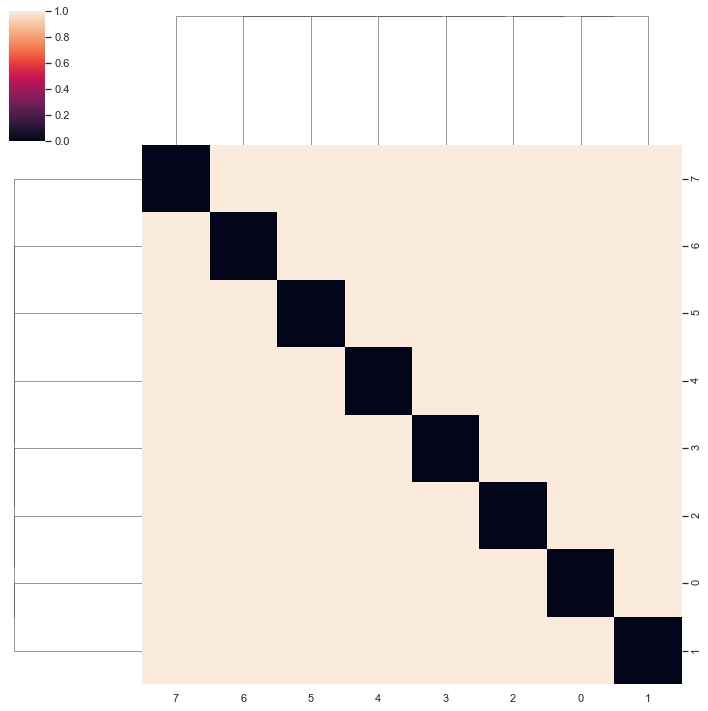

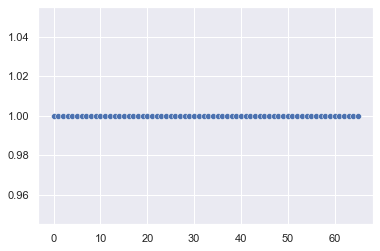

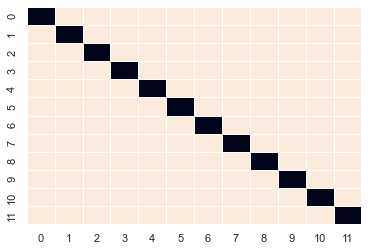

<Figure size 432x288 with 0 Axes>

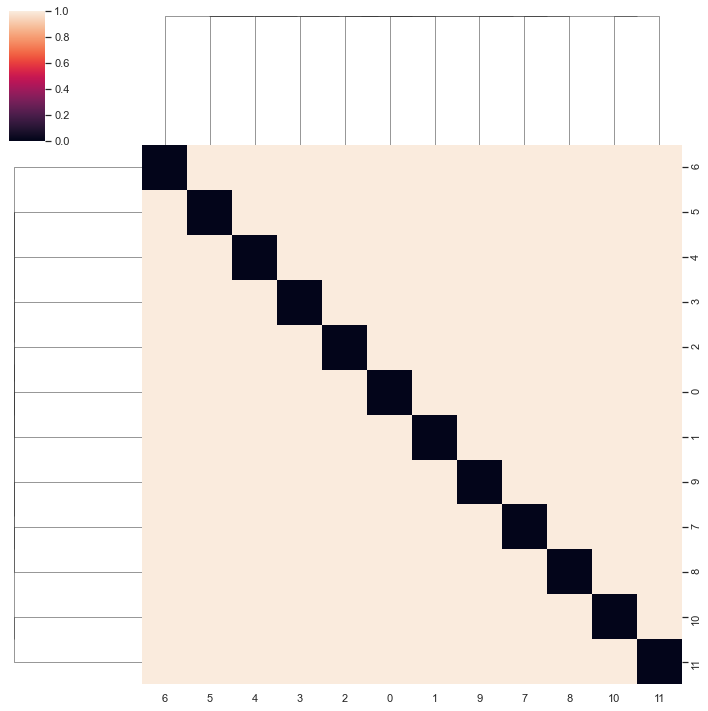

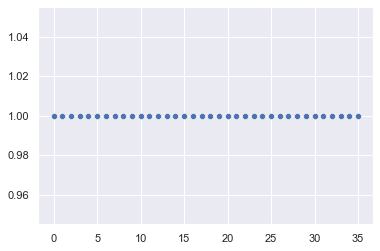

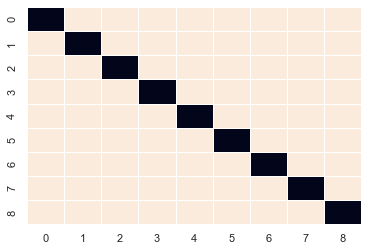

<Figure size 432x288 with 0 Axes>

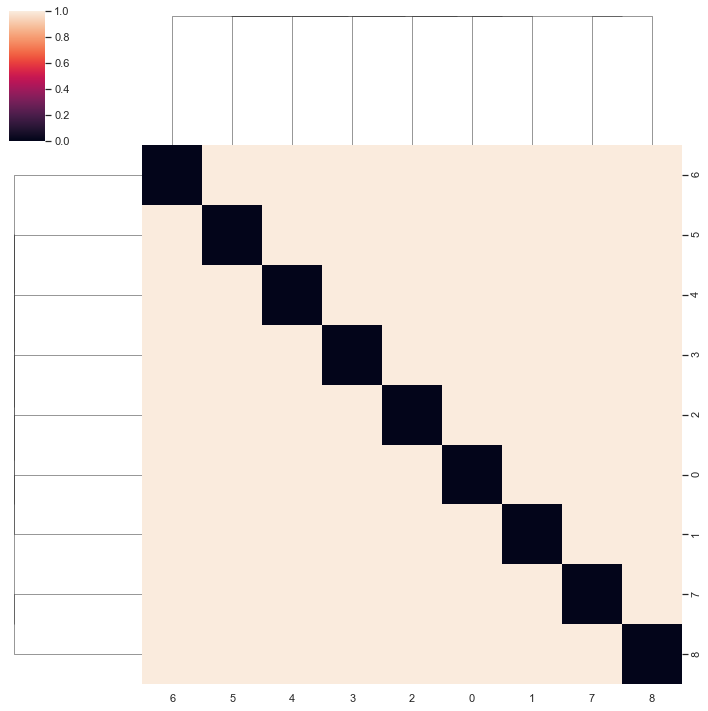

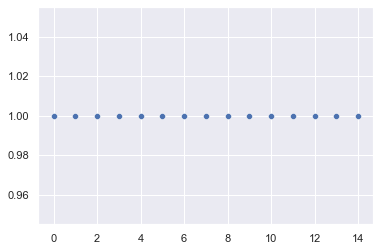

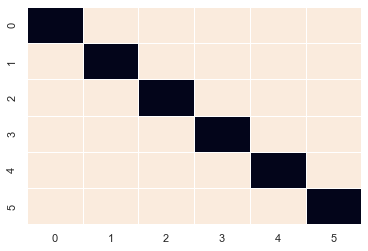

<Figure size 432x288 with 0 Axes>

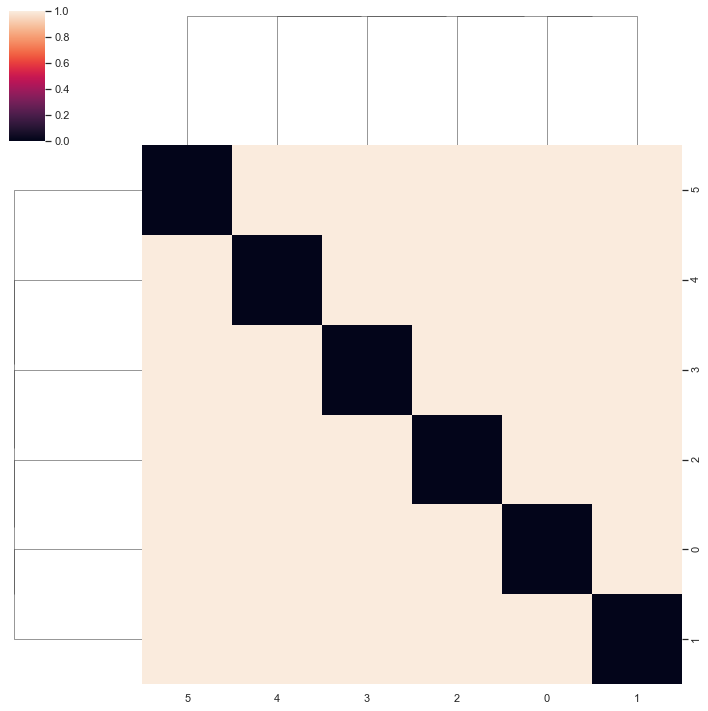

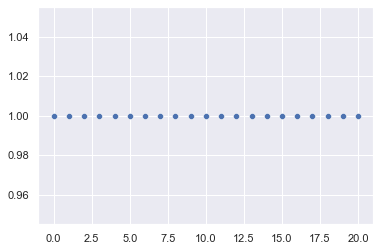

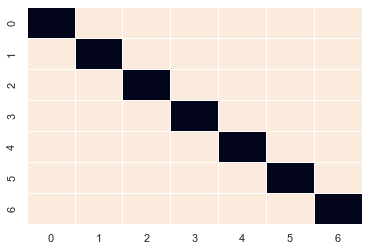

<Figure size 432x288 with 0 Axes>

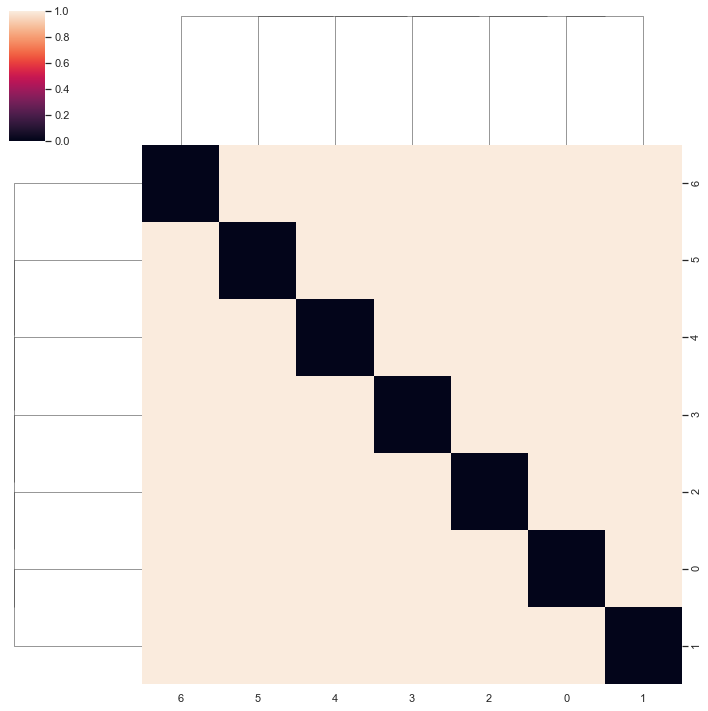

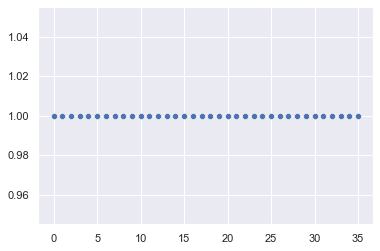

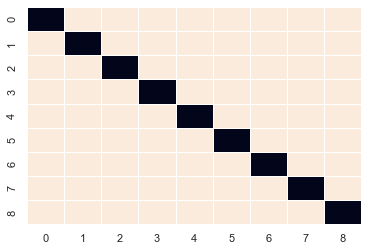

<Figure size 432x288 with 0 Axes>

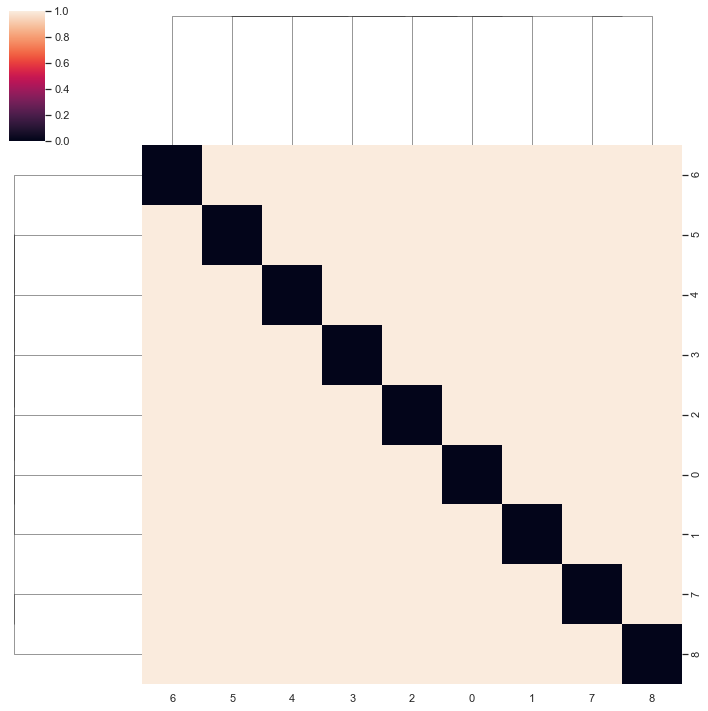

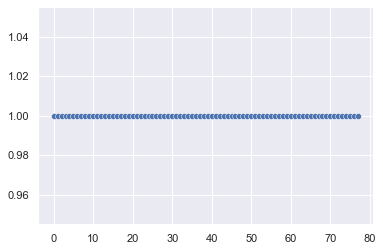

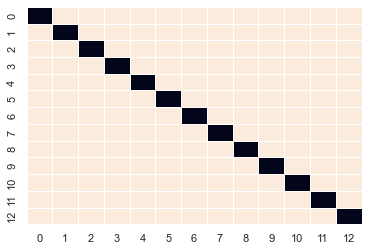

<Figure size 432x288 with 0 Axes>

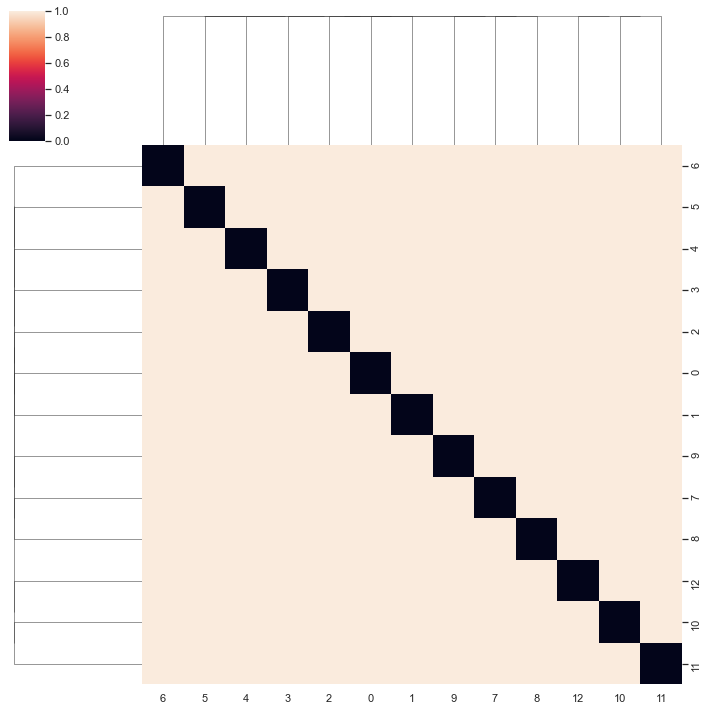

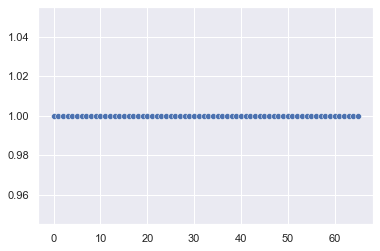

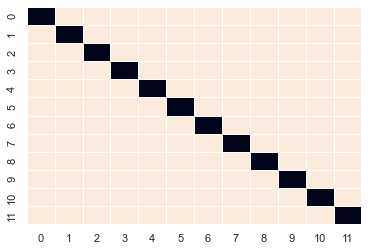

<Figure size 432x288 with 0 Axes>

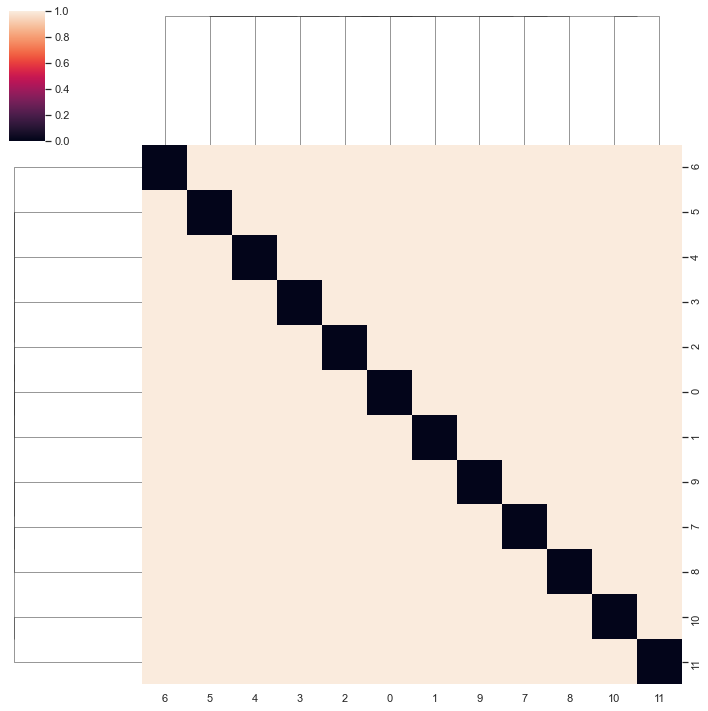

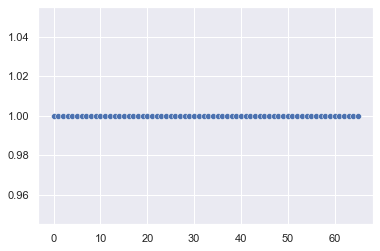

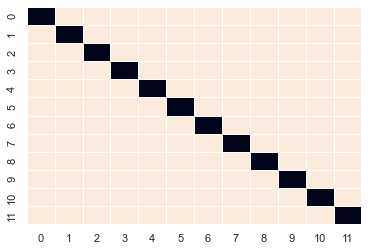

<Figure size 432x288 with 0 Axes>

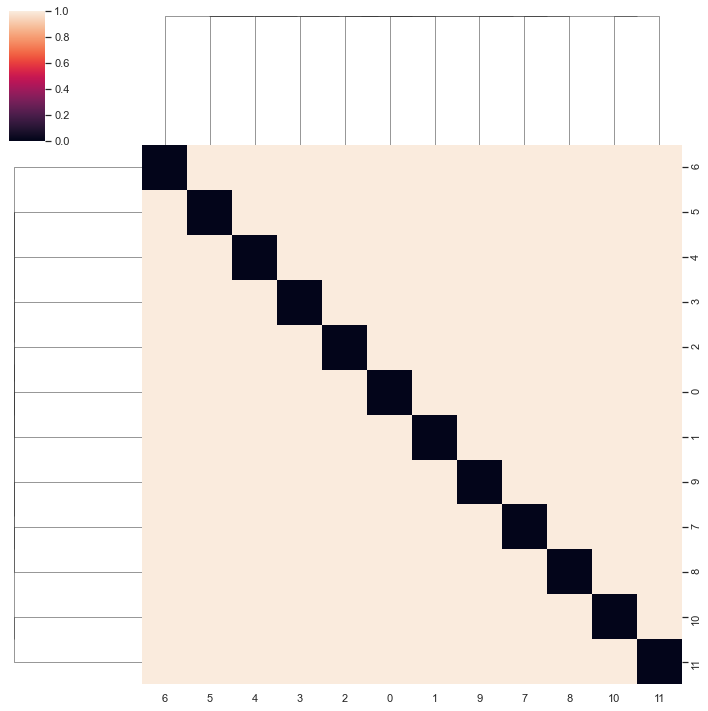

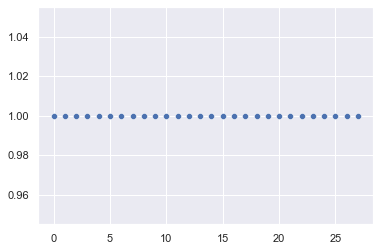

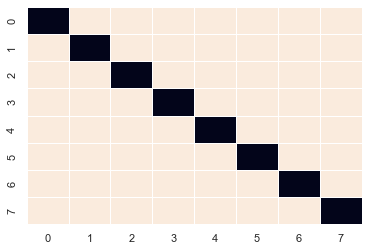

<Figure size 432x288 with 0 Axes>

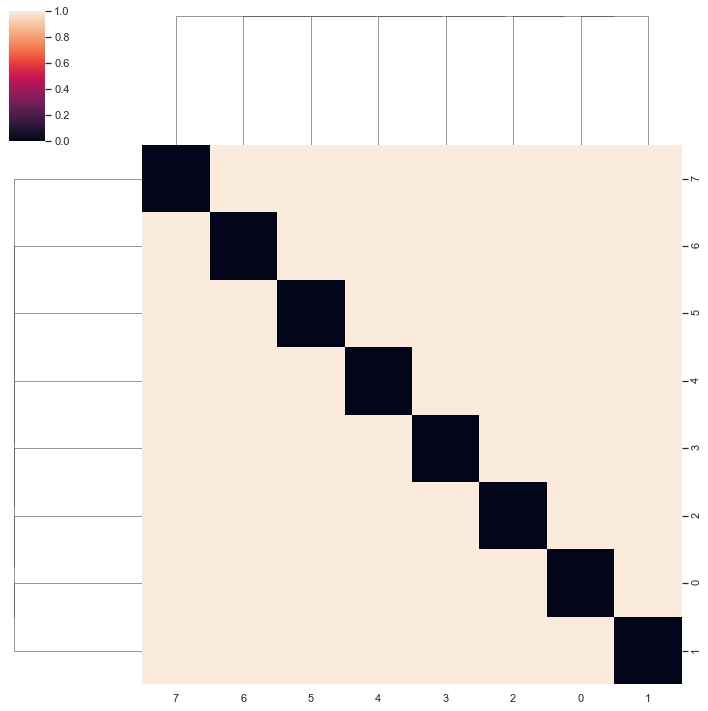

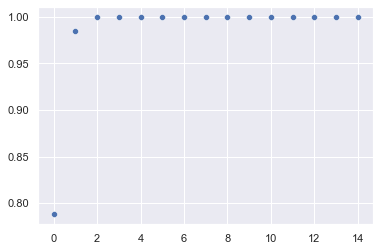

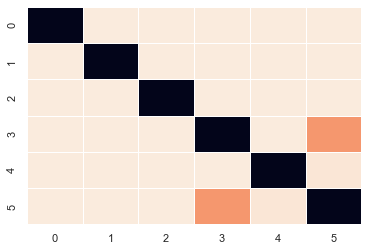

<Figure size 432x288 with 0 Axes>

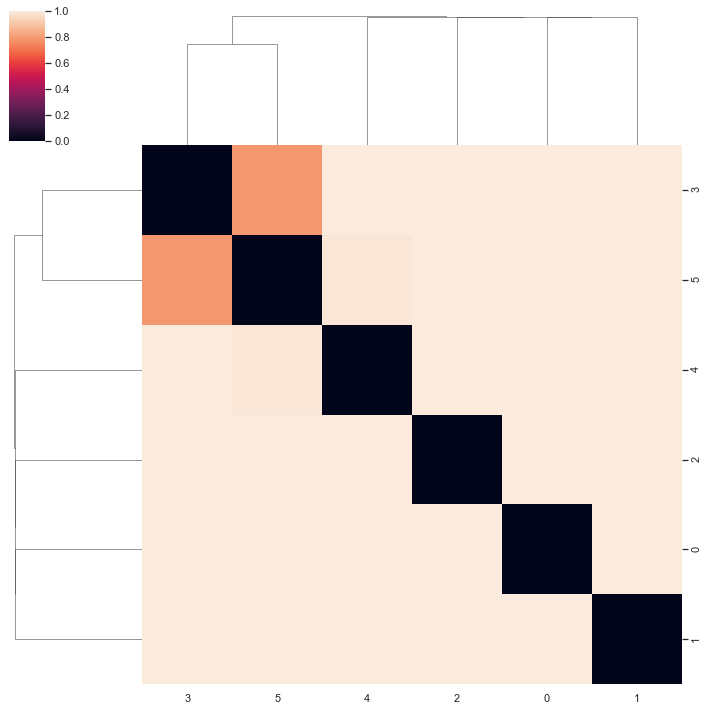

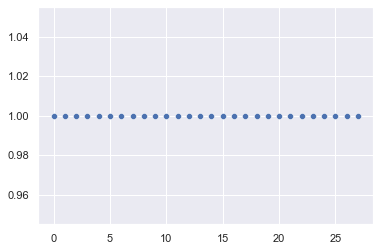

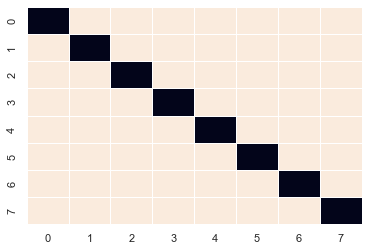

<Figure size 432x288 with 0 Axes>

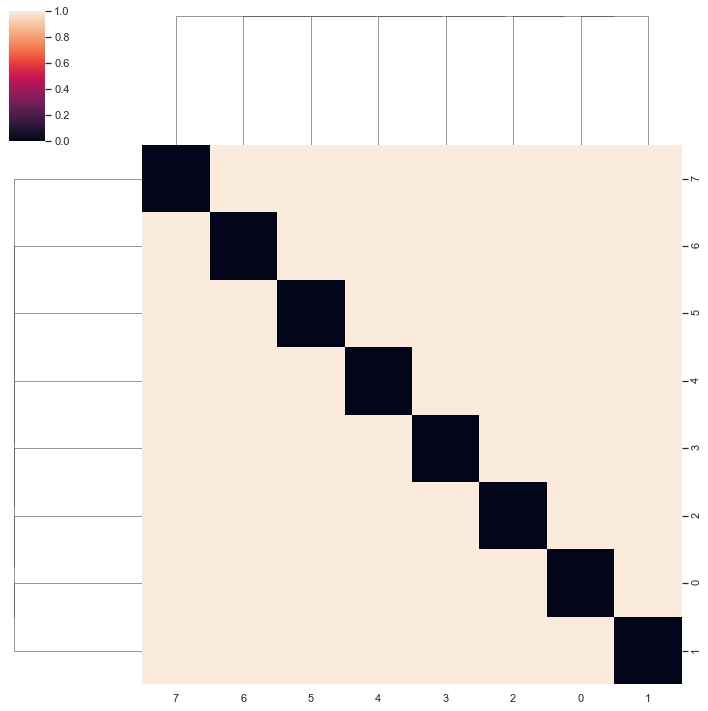

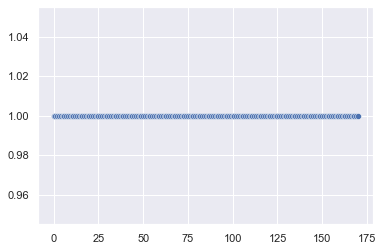

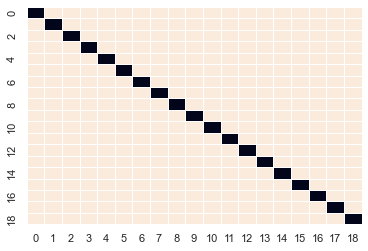

<Figure size 432x288 with 0 Axes>

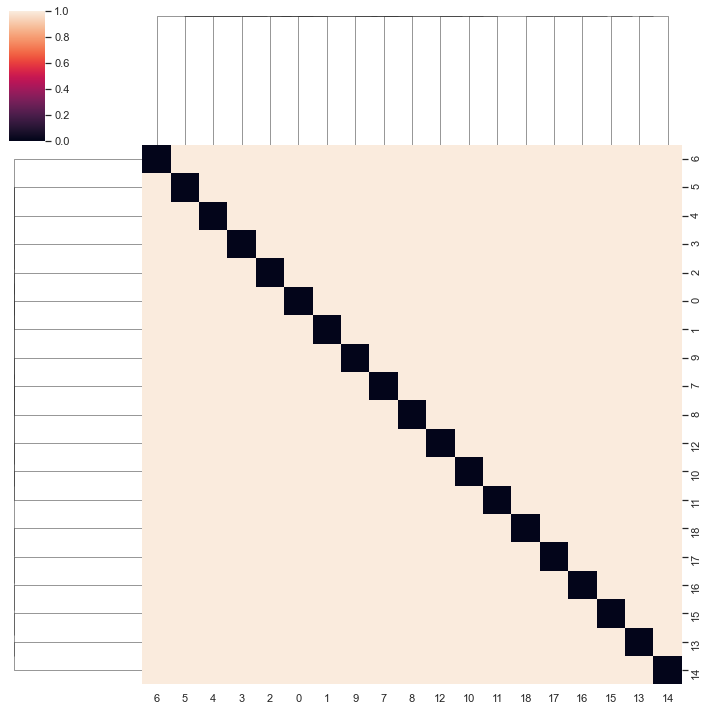

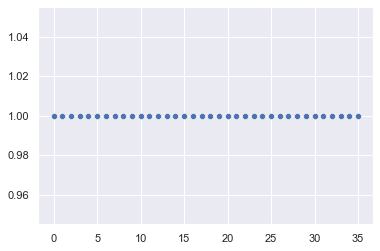

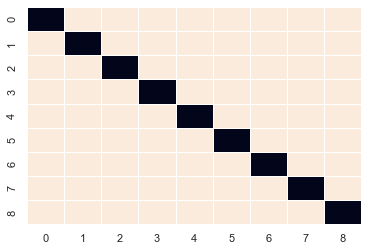

<Figure size 432x288 with 0 Axes>

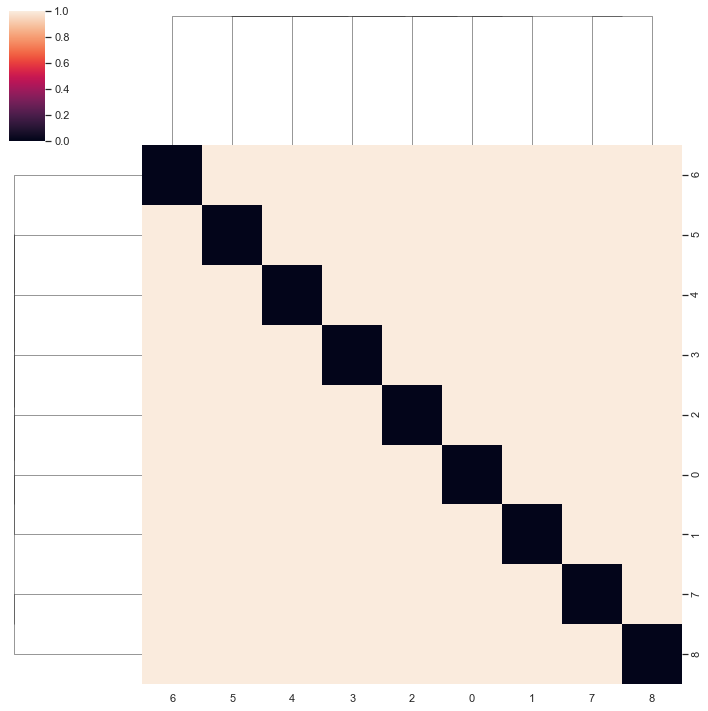

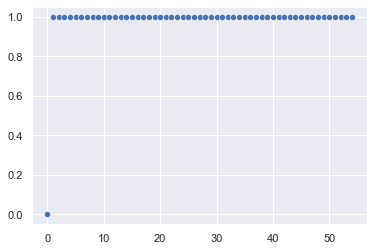

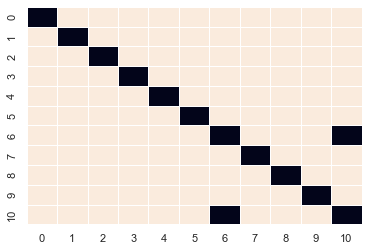

<Figure size 432x288 with 0 Axes>

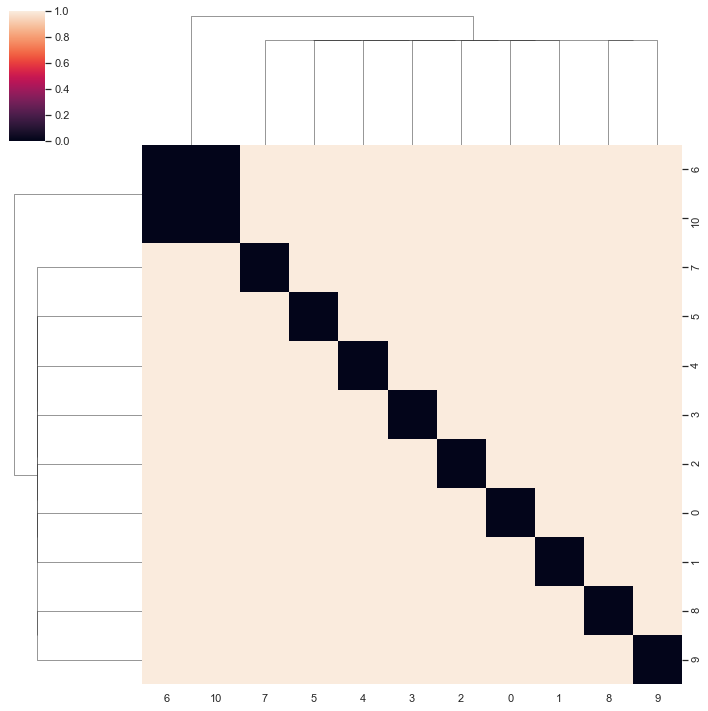

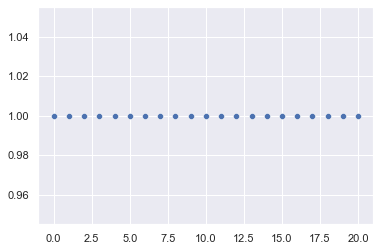

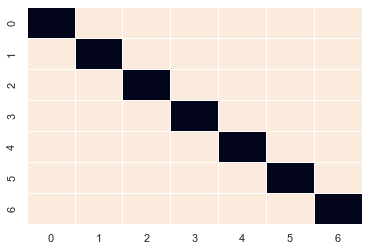

<Figure size 432x288 with 0 Axes>

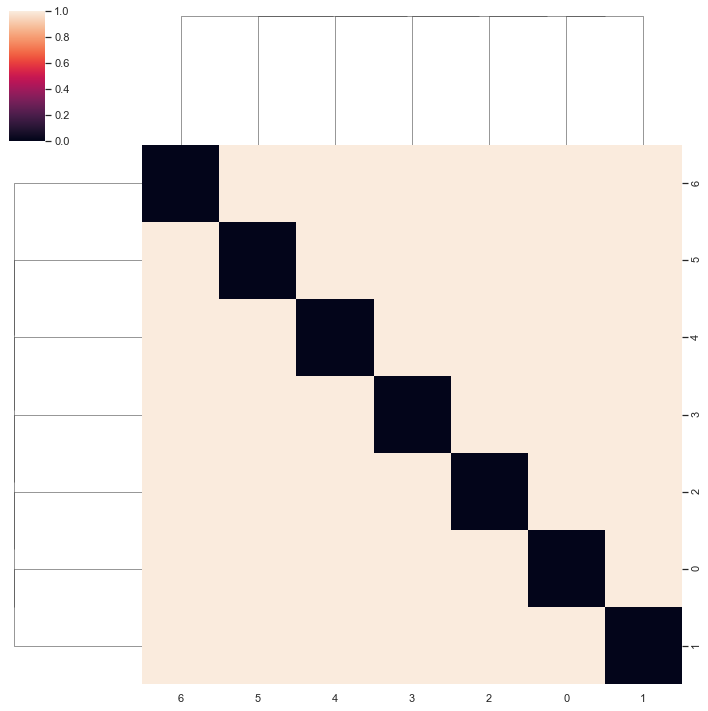

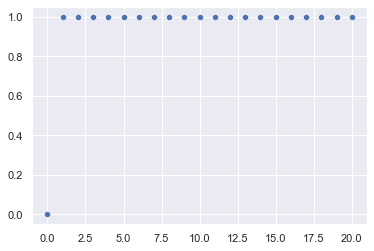

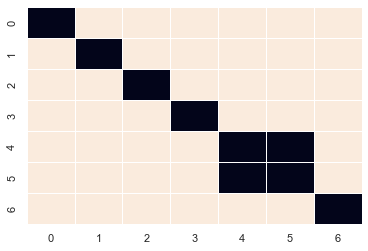

<Figure size 432x288 with 0 Axes>

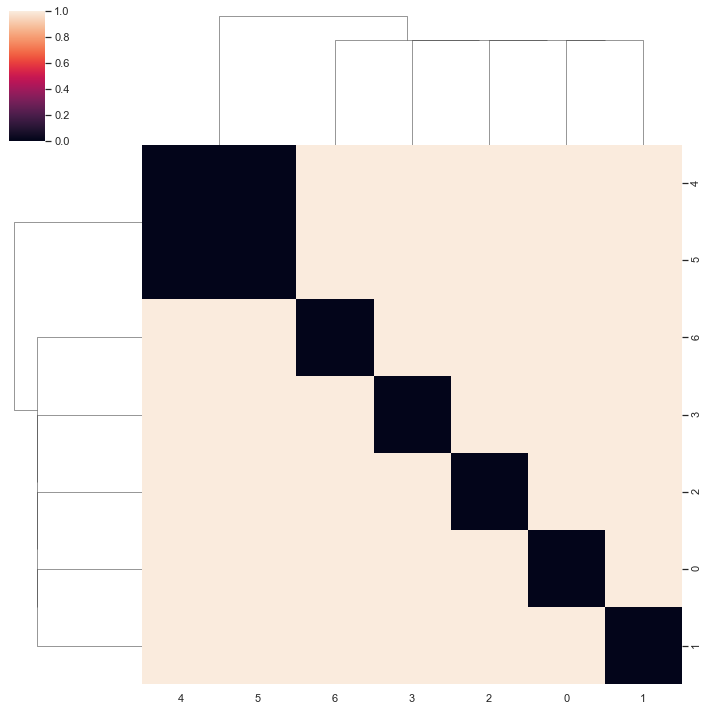

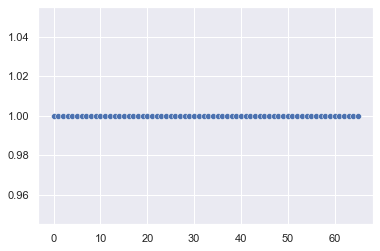

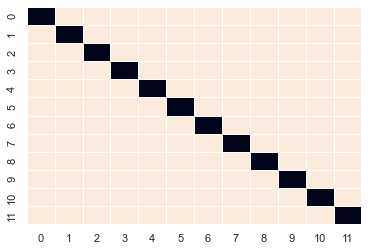

<Figure size 432x288 with 0 Axes>

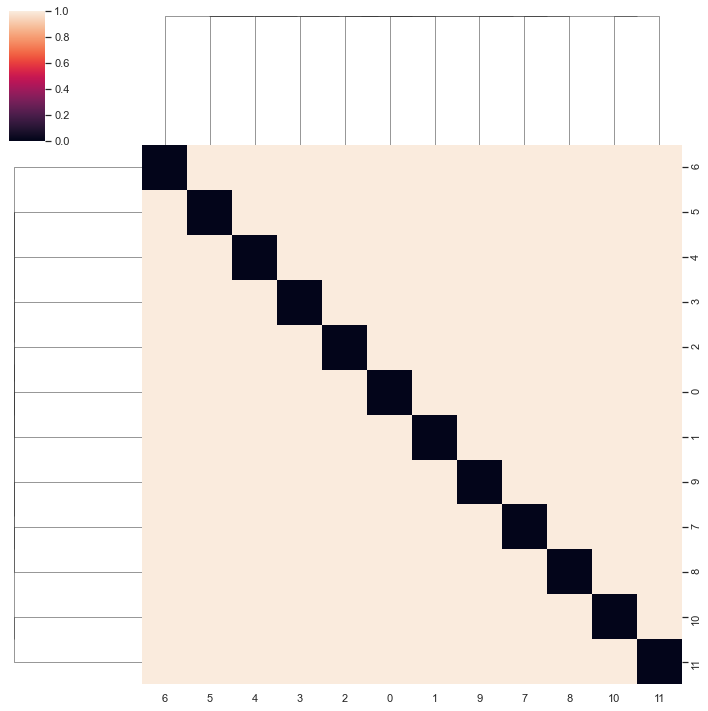

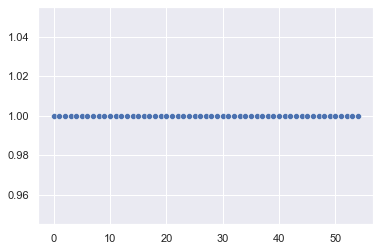

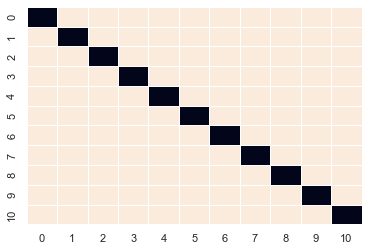

<Figure size 432x288 with 0 Axes>

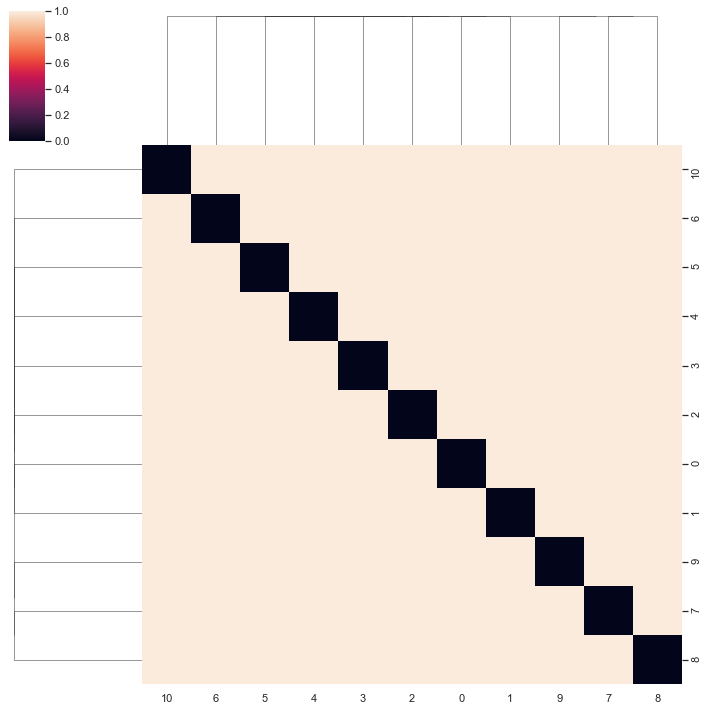

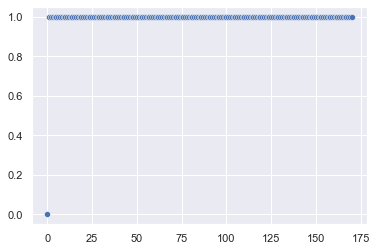

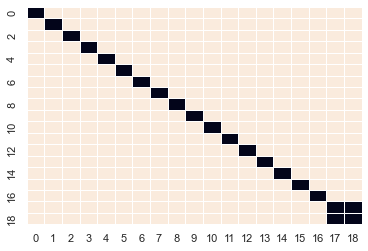

<Figure size 432x288 with 0 Axes>

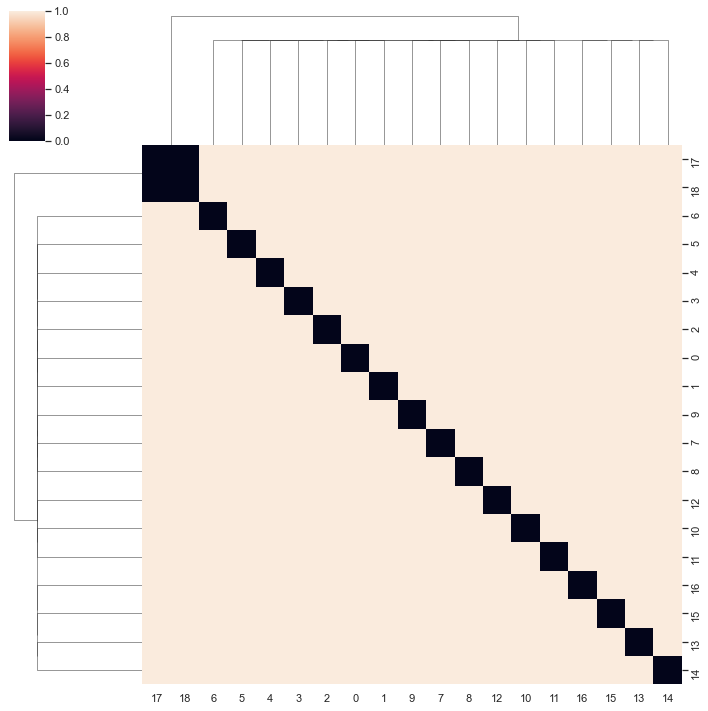

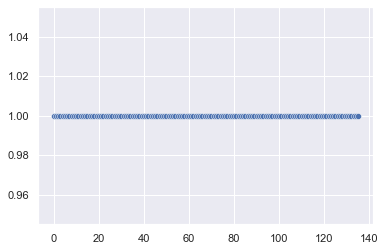

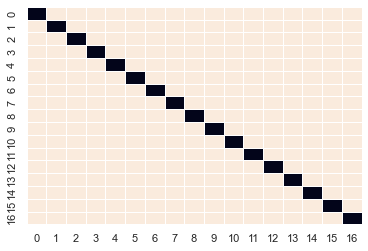

<Figure size 432x288 with 0 Axes>

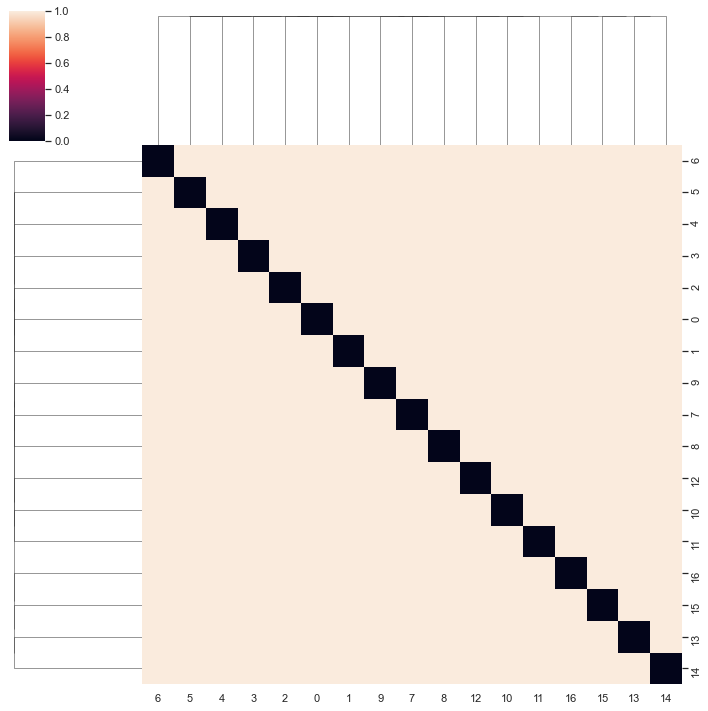

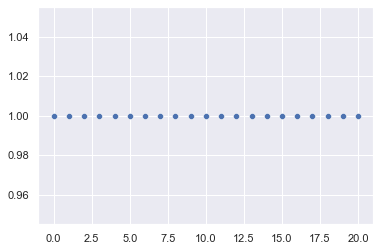

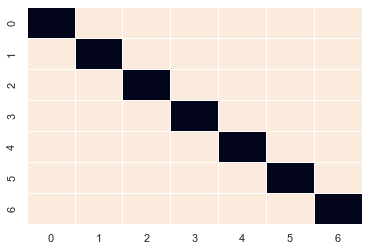

<Figure size 432x288 with 0 Axes>

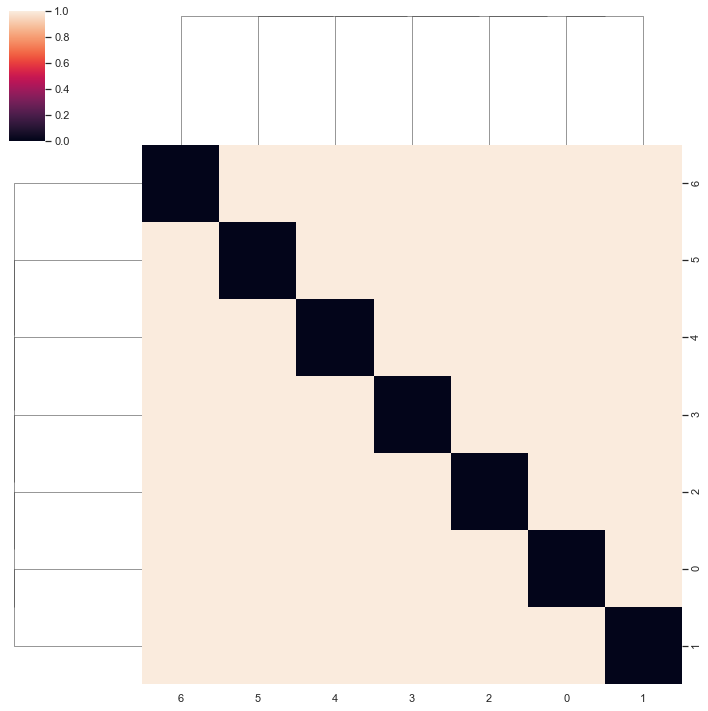

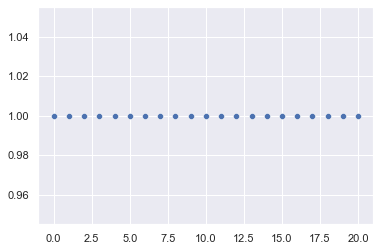

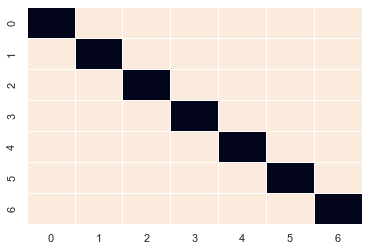

<Figure size 432x288 with 0 Axes>

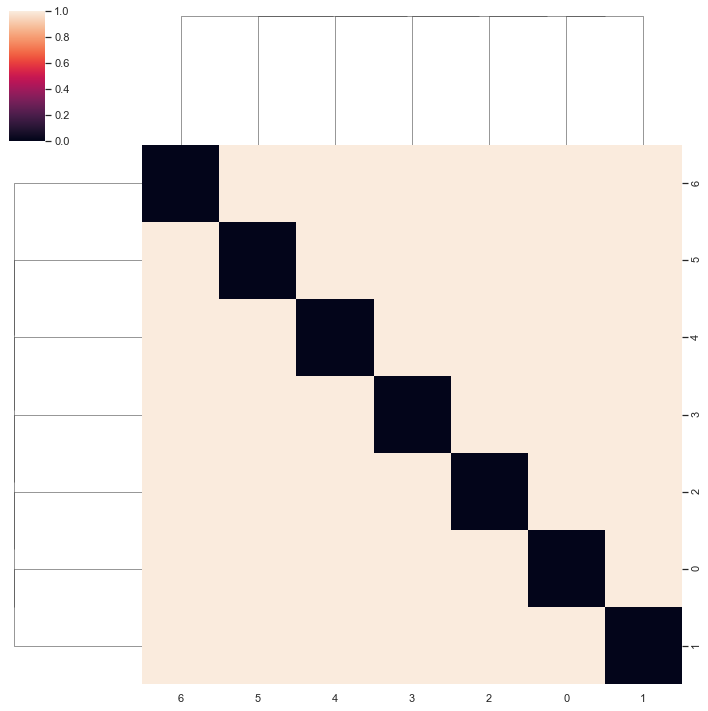

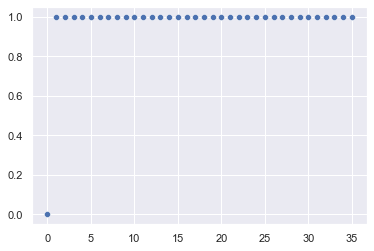

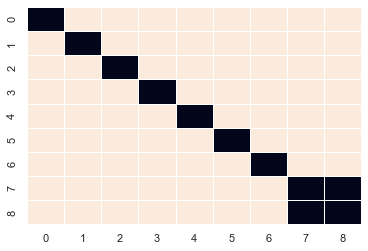

<Figure size 432x288 with 0 Axes>

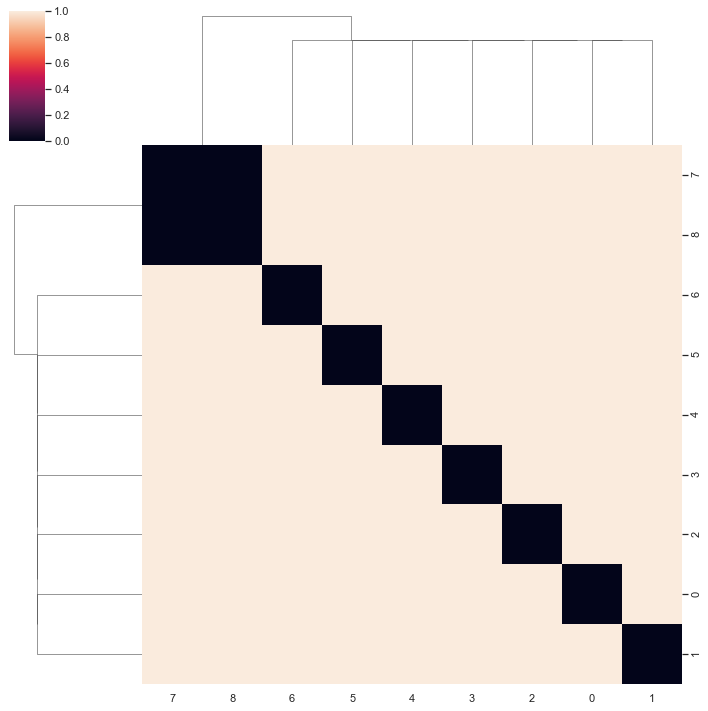

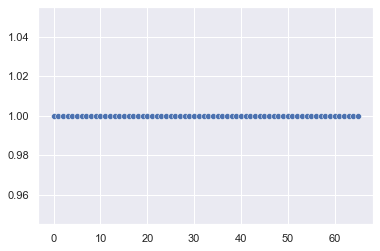

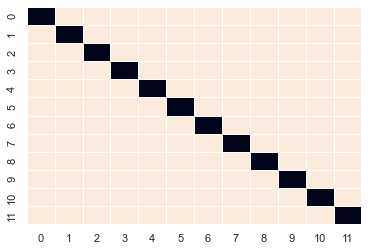

<Figure size 432x288 with 0 Axes>

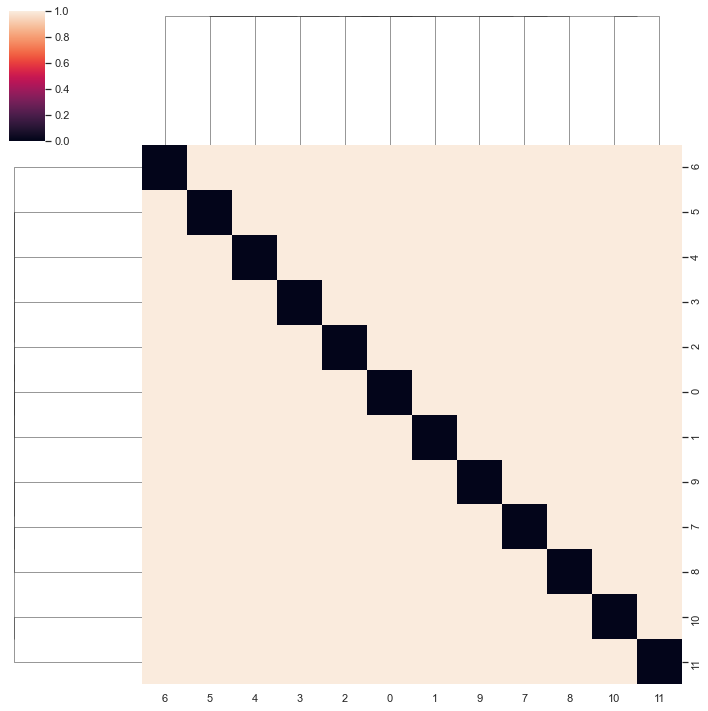

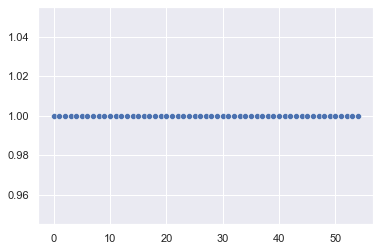

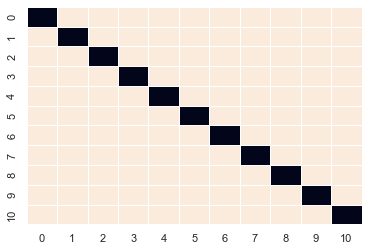

<Figure size 432x288 with 0 Axes>

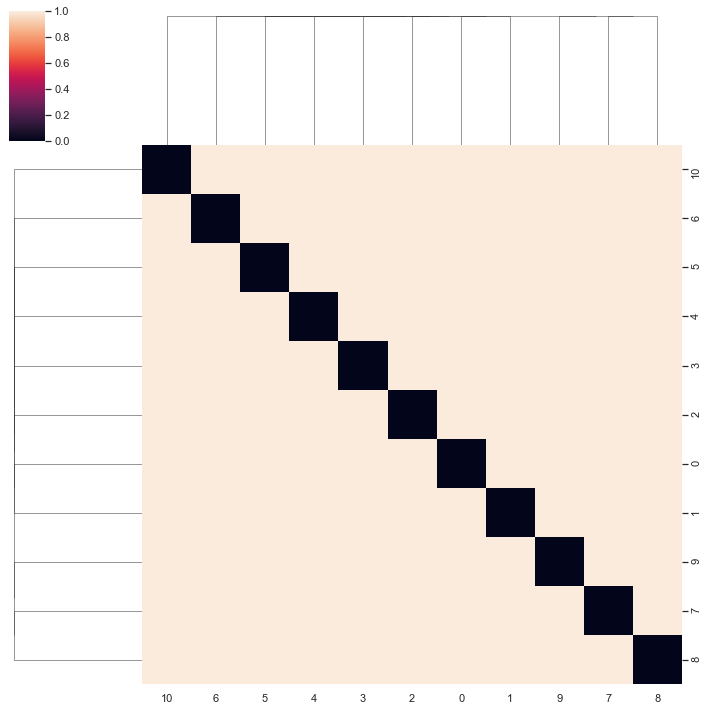

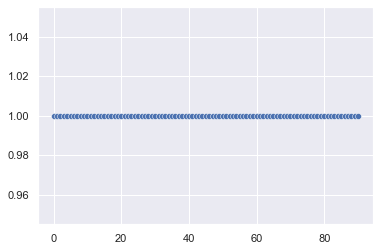

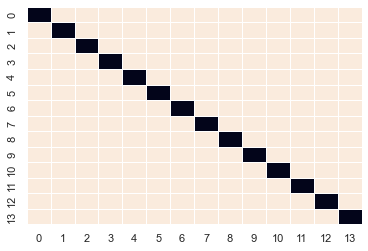

<Figure size 432x288 with 0 Axes>

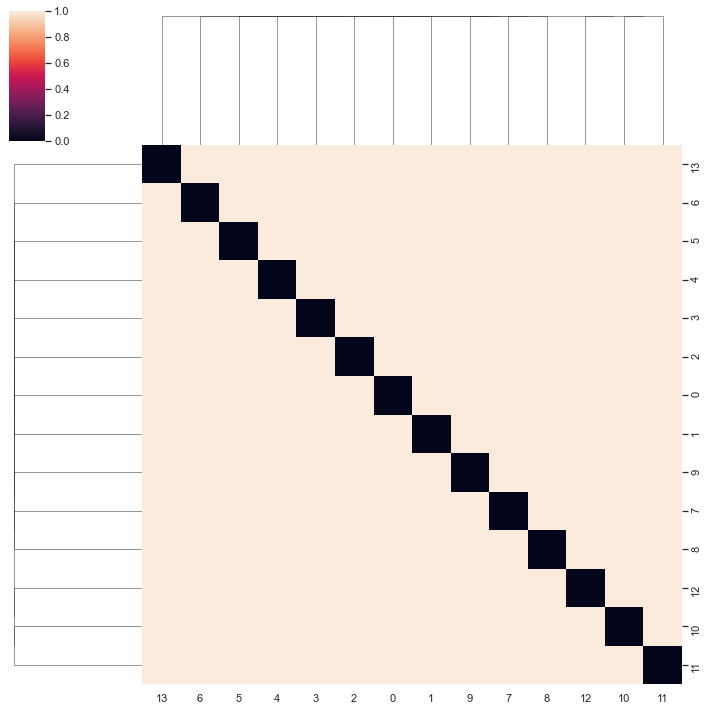

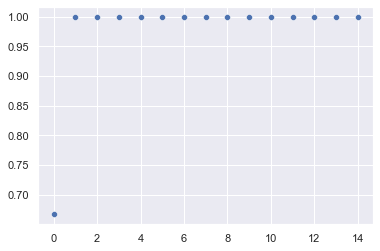

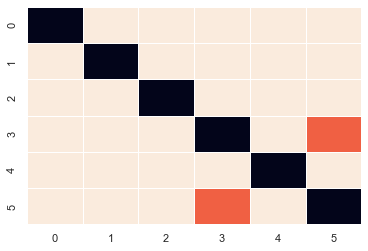

<Figure size 432x288 with 0 Axes>

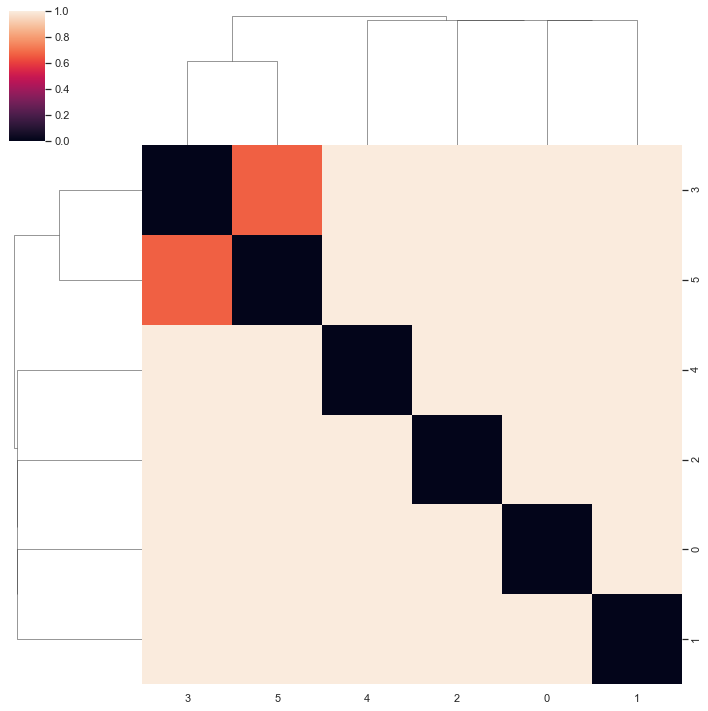

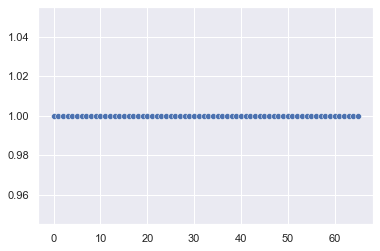

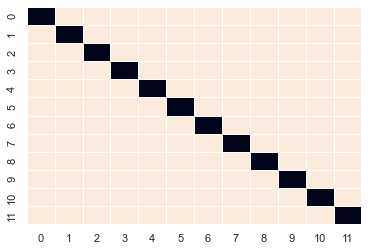

<Figure size 432x288 with 0 Axes>

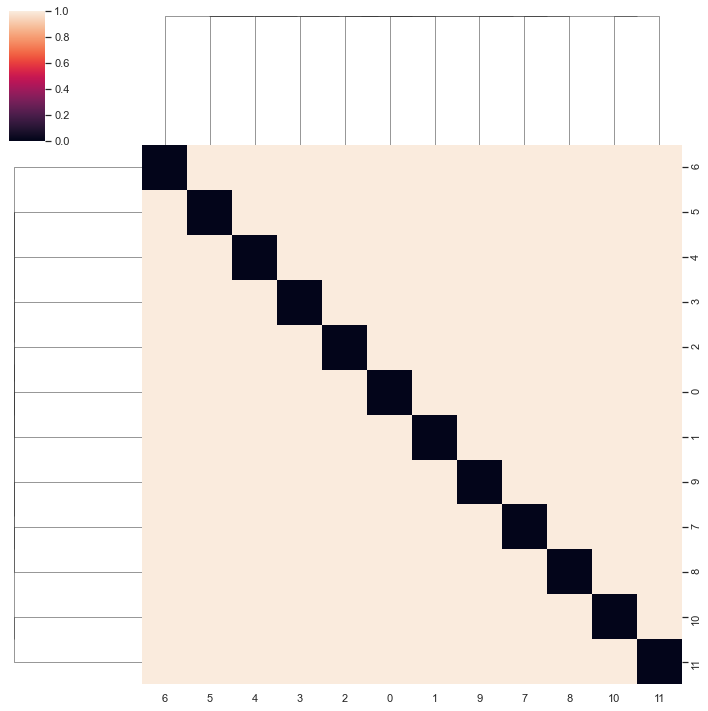

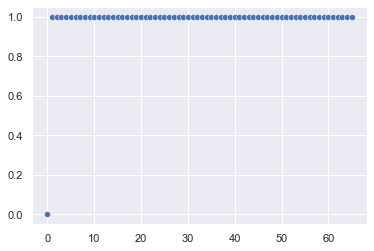

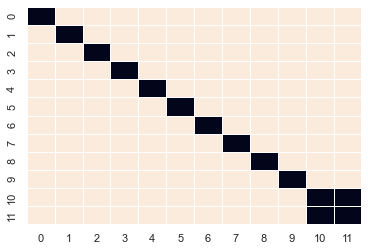

<Figure size 432x288 with 0 Axes>

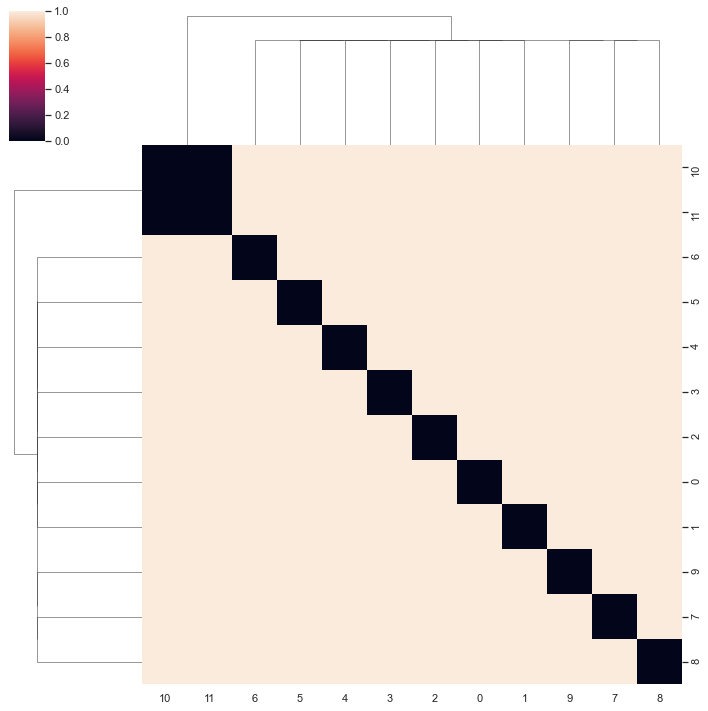

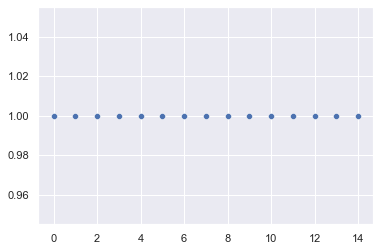

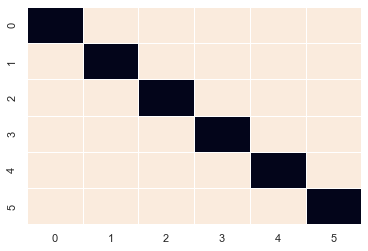

<Figure size 432x288 with 0 Axes>

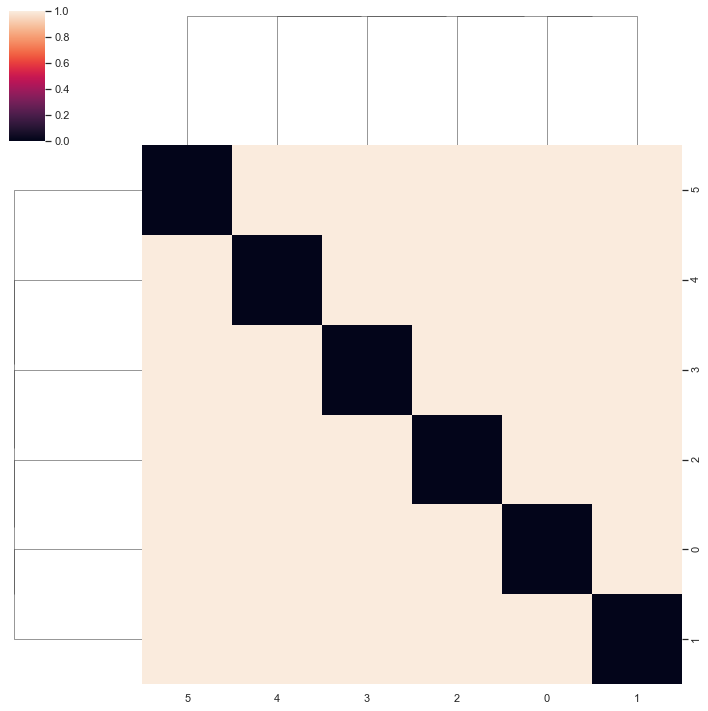

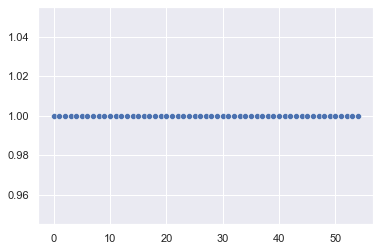

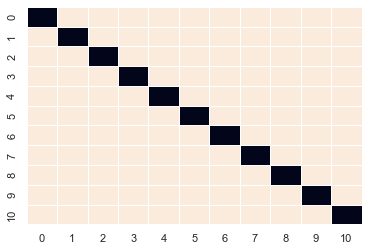

<Figure size 432x288 with 0 Axes>

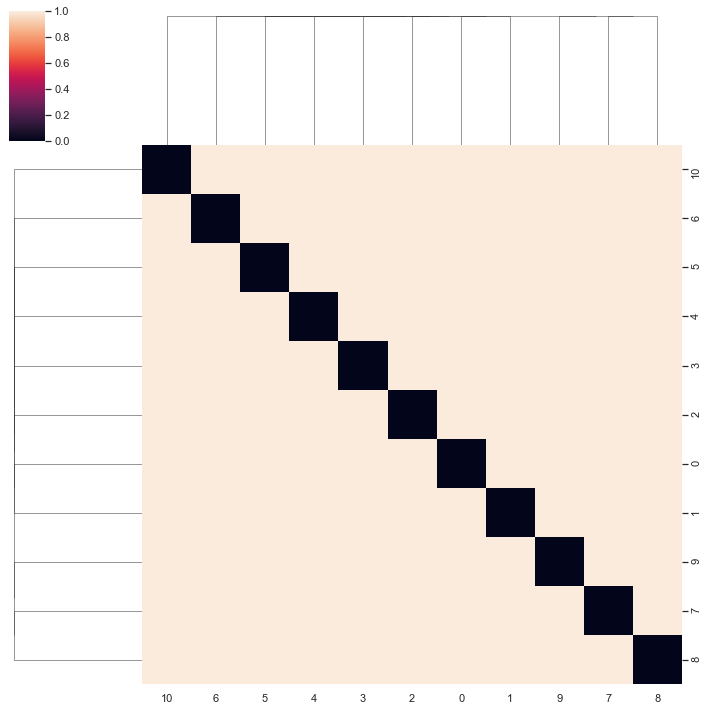

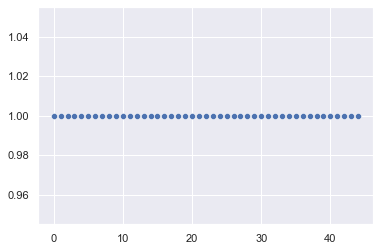

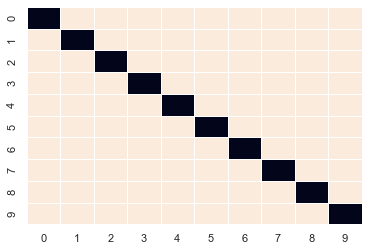

<Figure size 432x288 with 0 Axes>

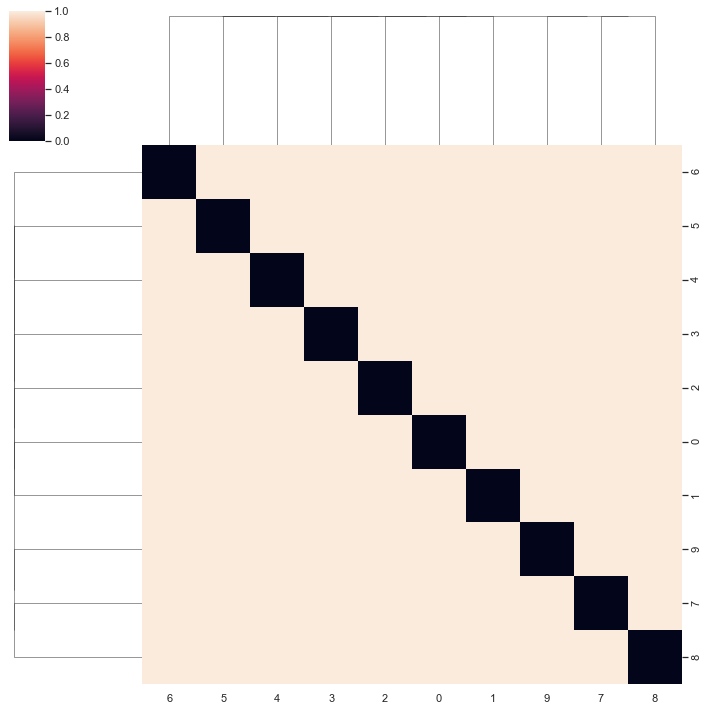

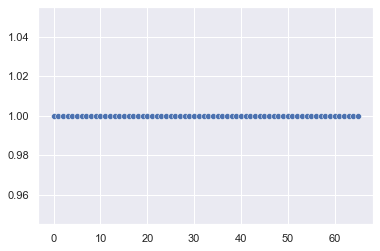

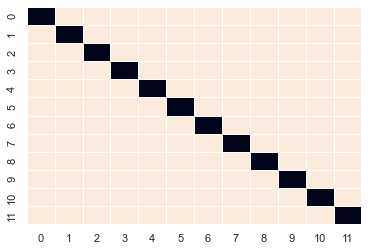

<Figure size 432x288 with 0 Axes>

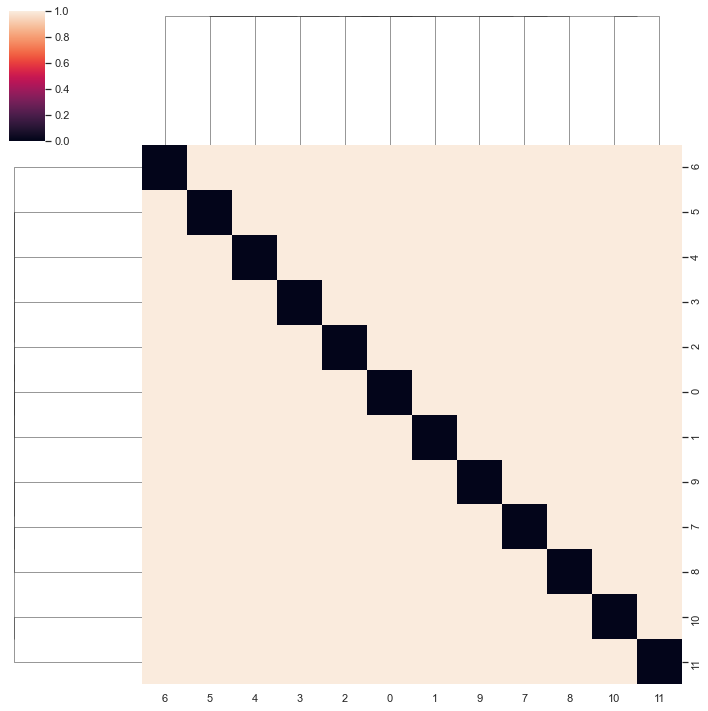

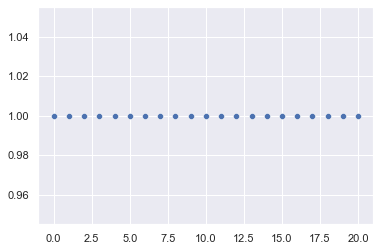

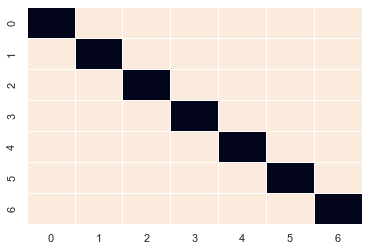

<Figure size 432x288 with 0 Axes>

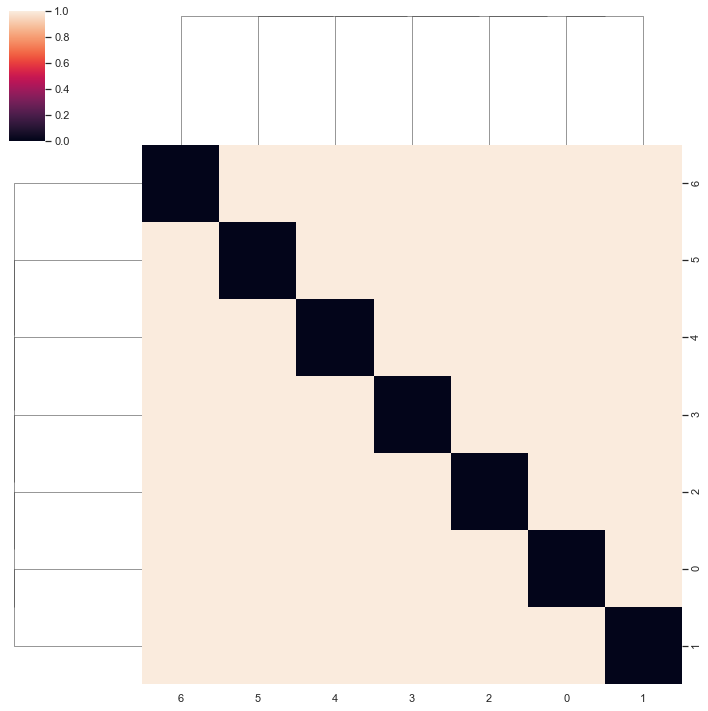

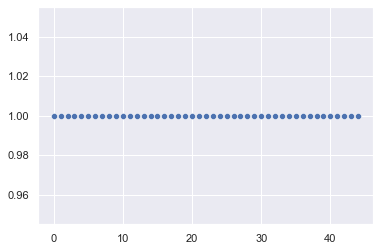

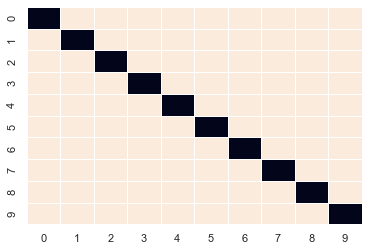

<Figure size 432x288 with 0 Axes>

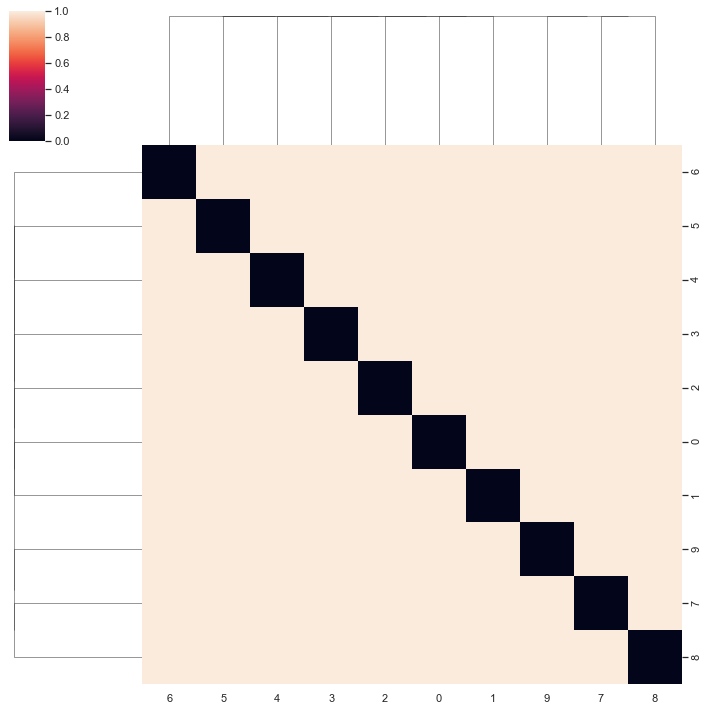

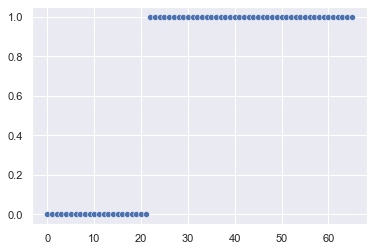

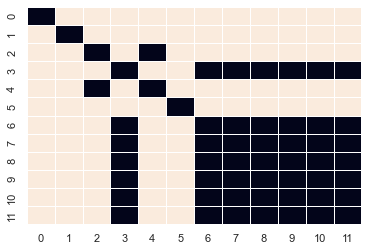

<Figure size 432x288 with 0 Axes>

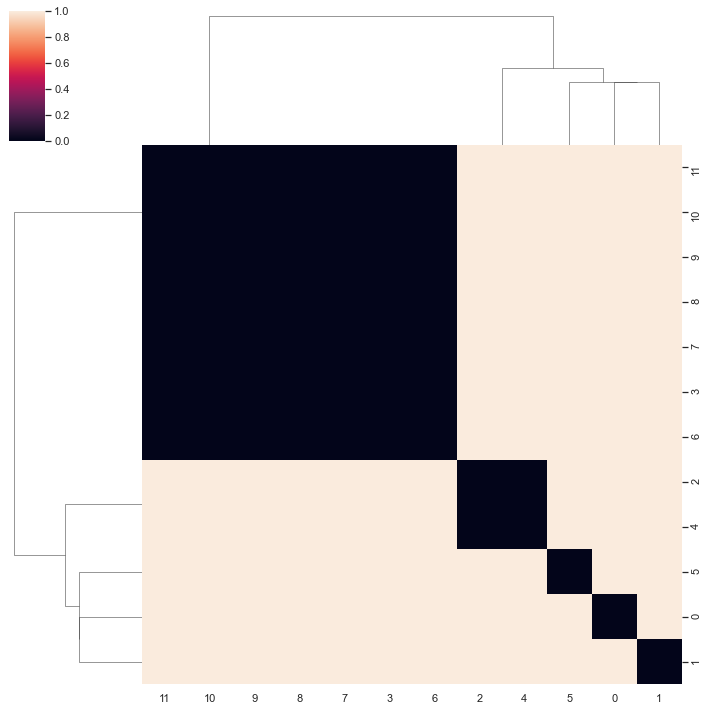

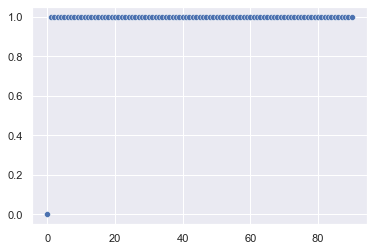

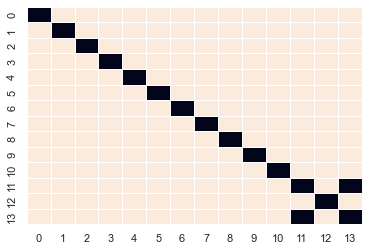

<Figure size 432x288 with 0 Axes>

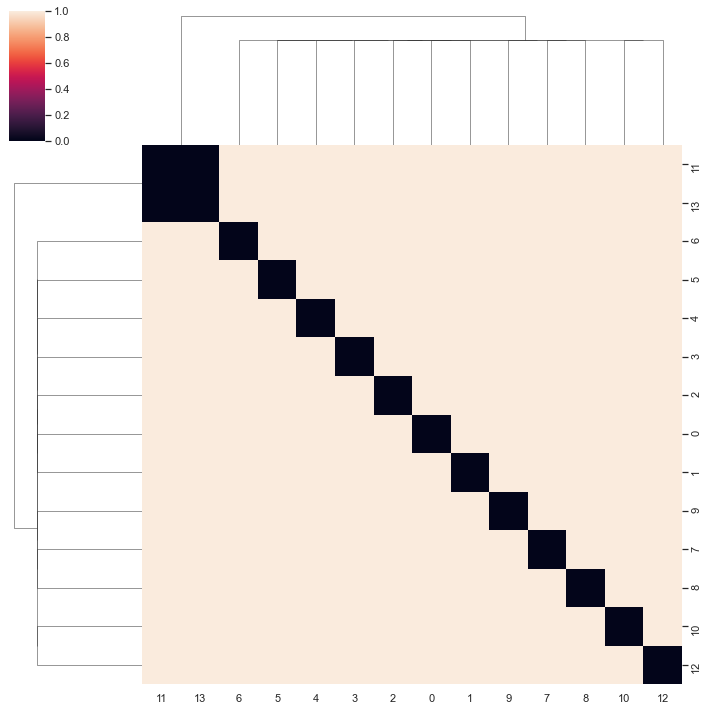

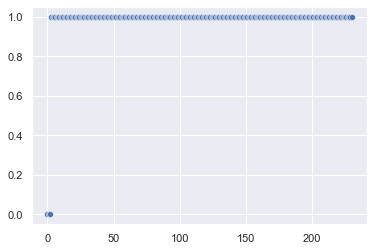

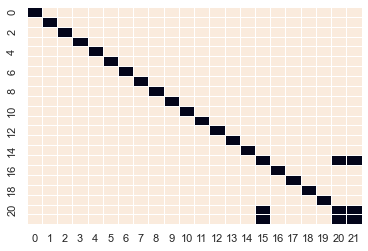

<Figure size 432x288 with 0 Axes>

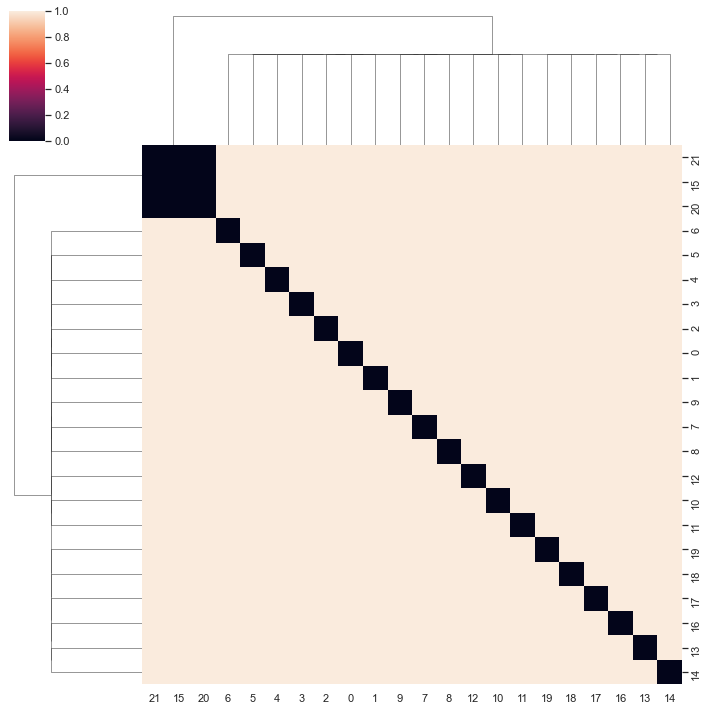

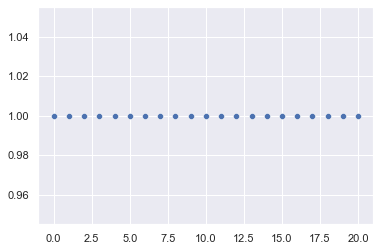

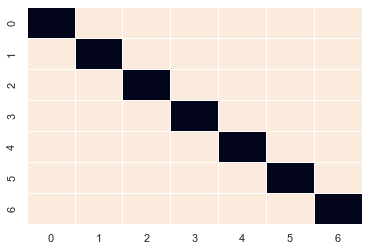

<Figure size 432x288 with 0 Axes>

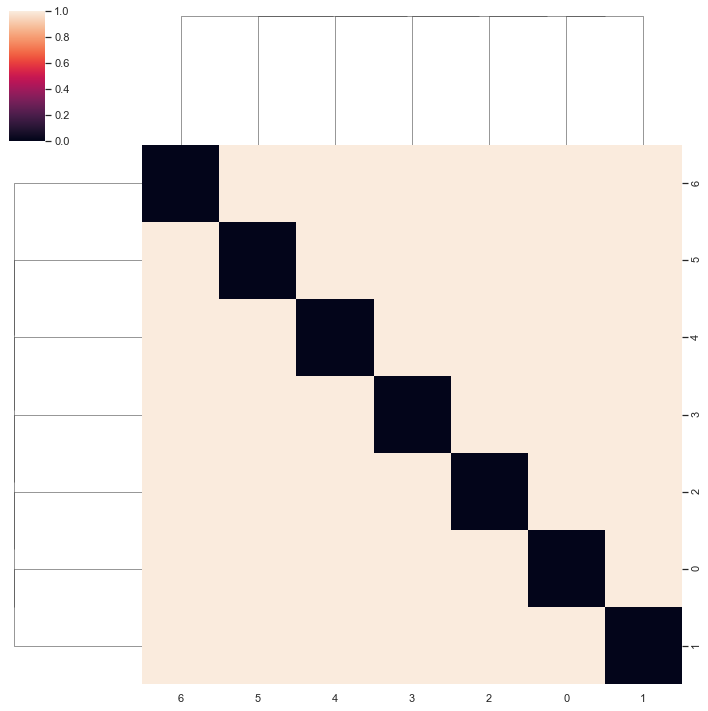

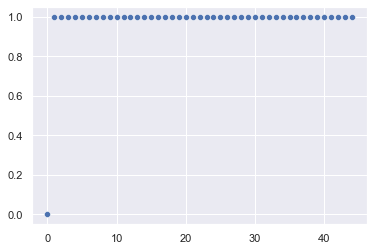

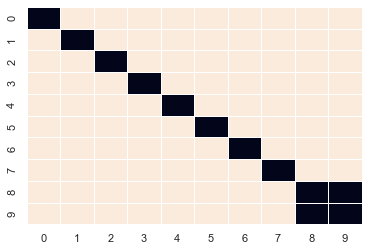

<Figure size 432x288 with 0 Axes>

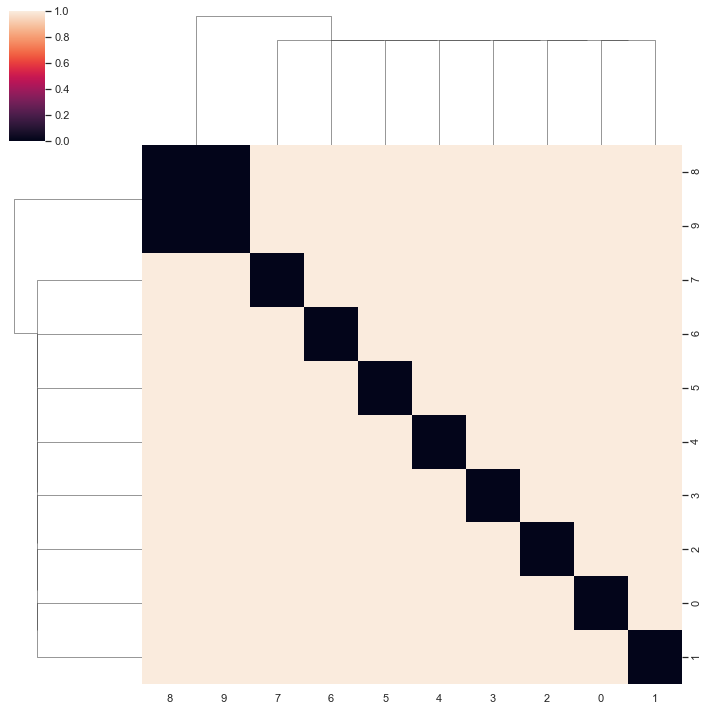

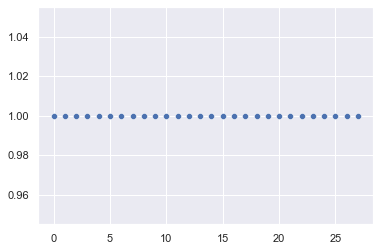

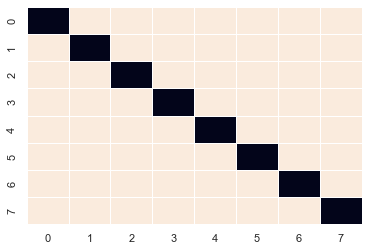

<Figure size 432x288 with 0 Axes>

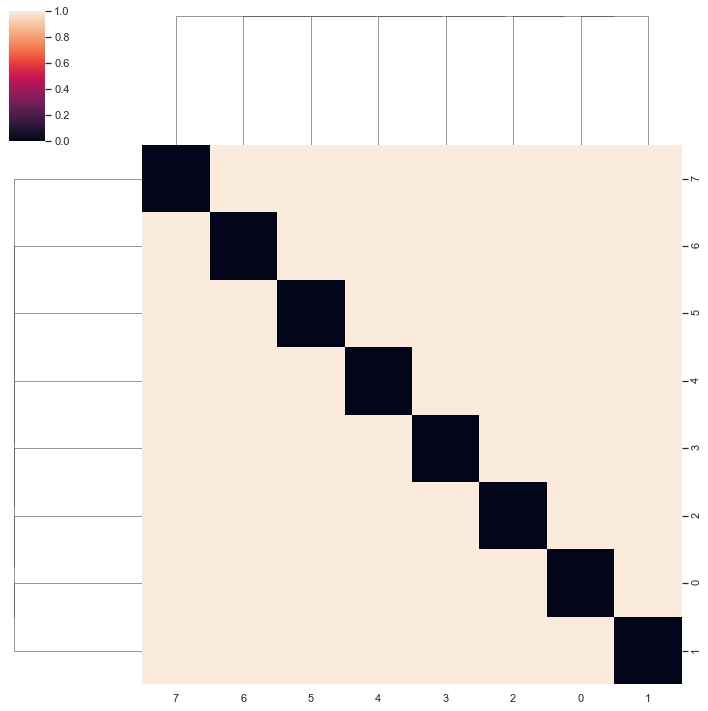

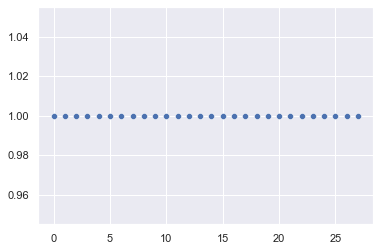

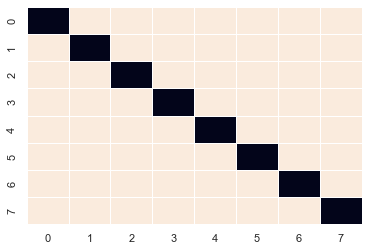

<Figure size 432x288 with 0 Axes>

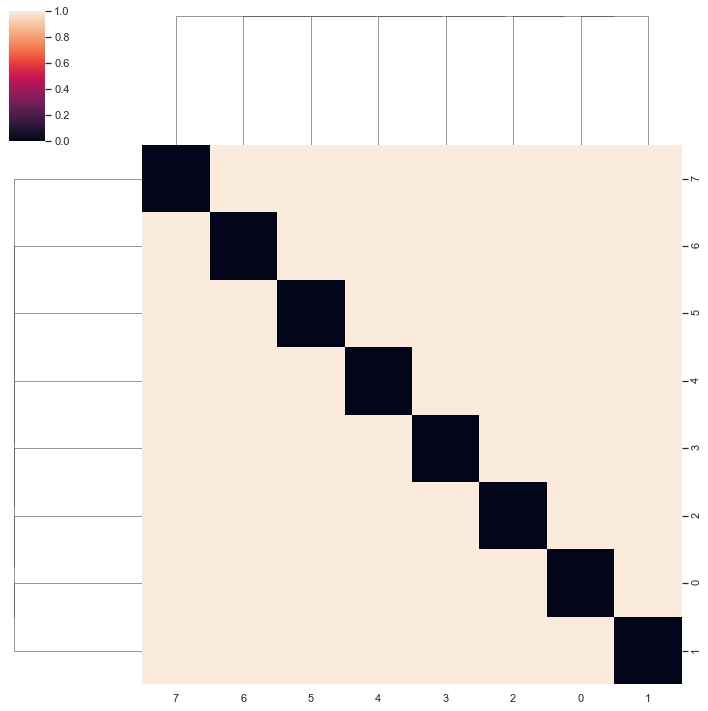

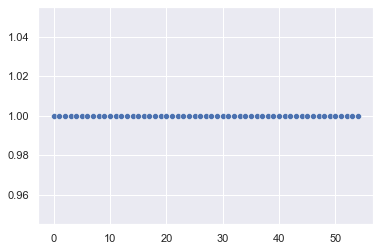

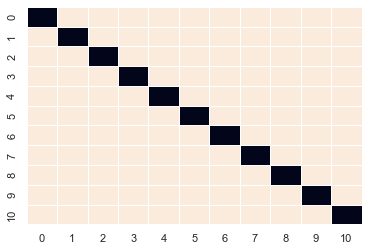

<Figure size 432x288 with 0 Axes>

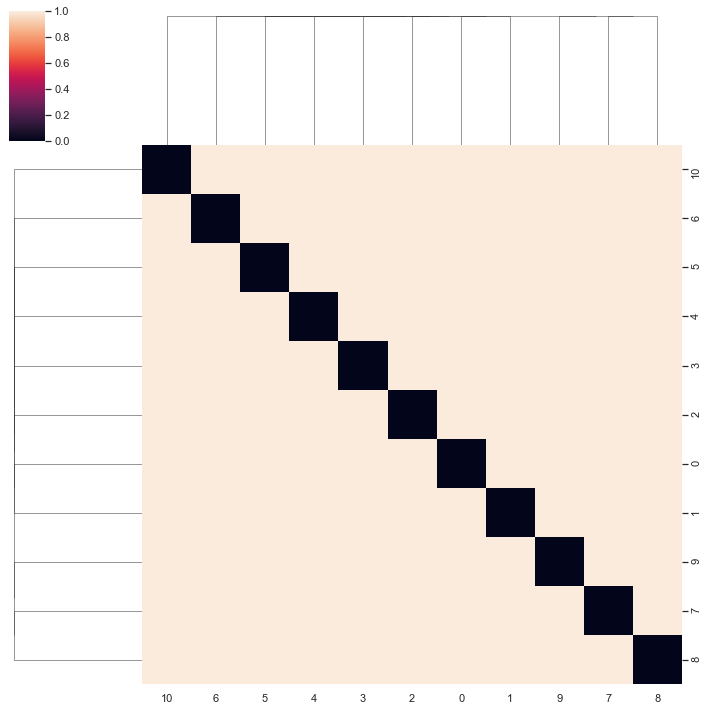

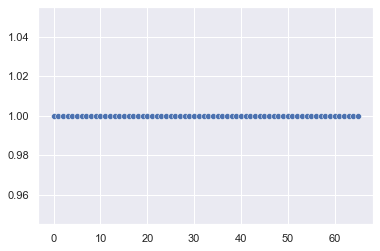

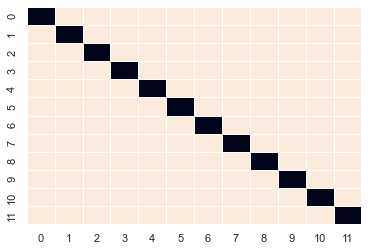

<Figure size 432x288 with 0 Axes>

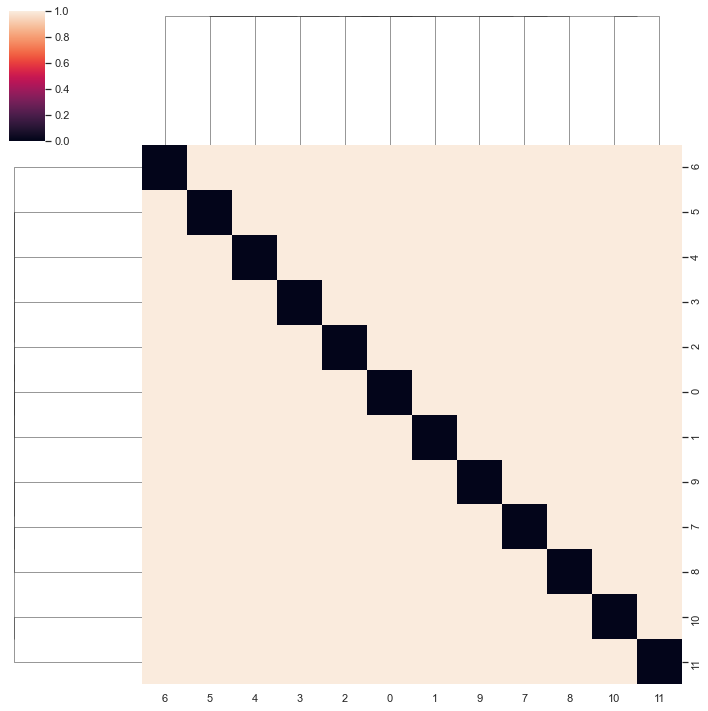

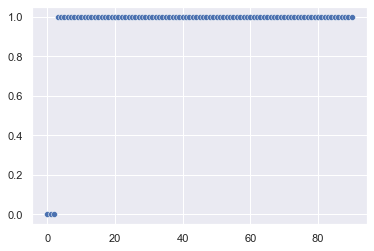

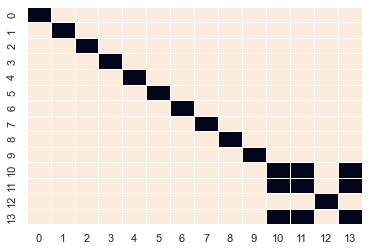

<Figure size 432x288 with 0 Axes>

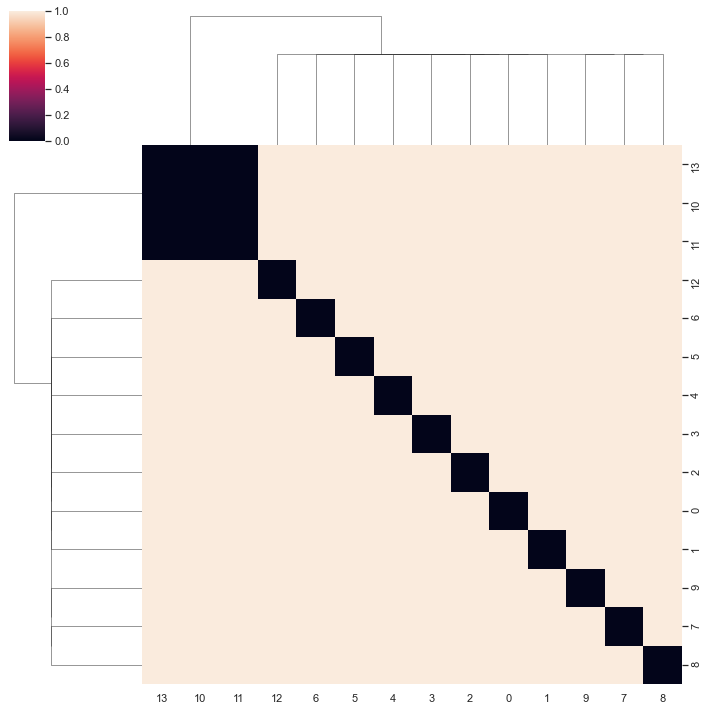

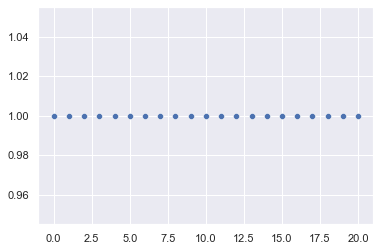

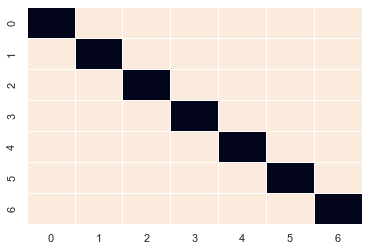

<Figure size 432x288 with 0 Axes>

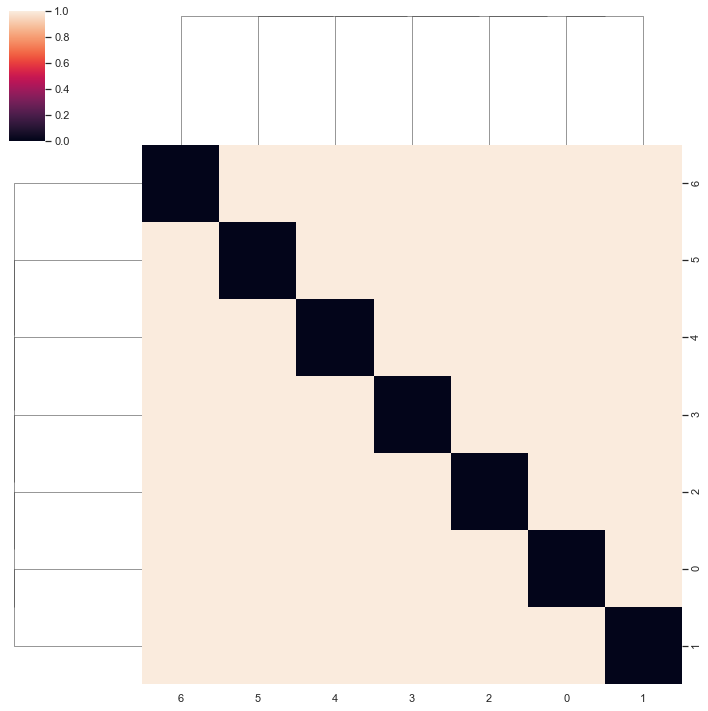

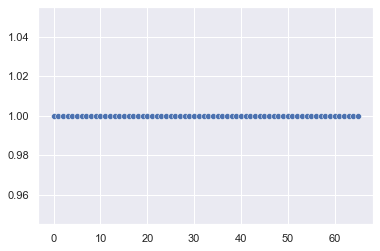

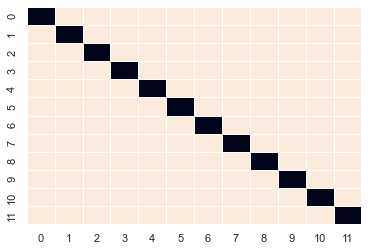

<Figure size 432x288 with 0 Axes>

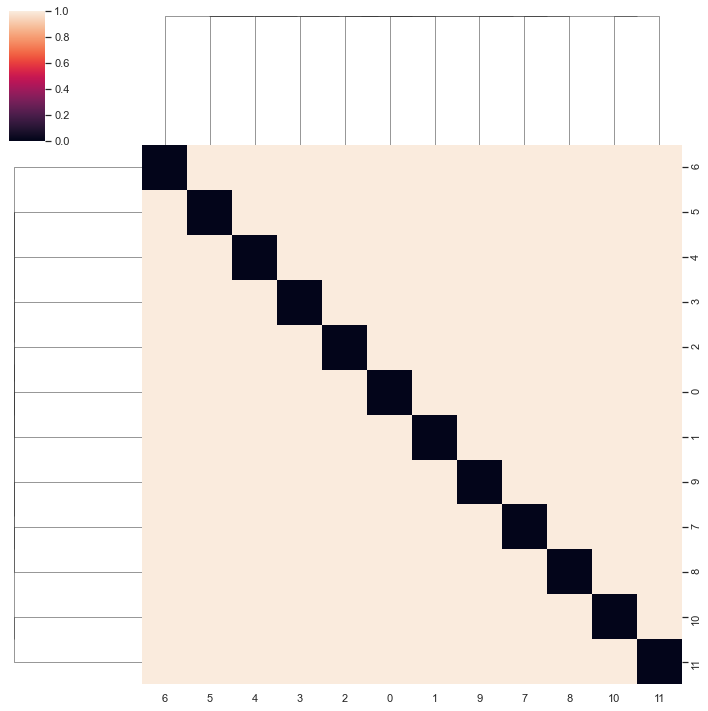

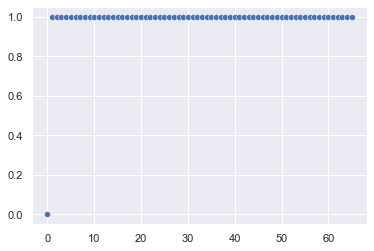

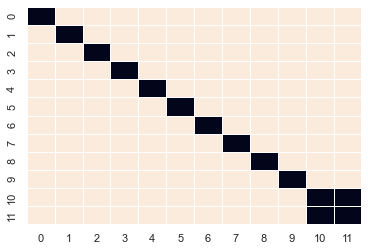

<Figure size 432x288 with 0 Axes>

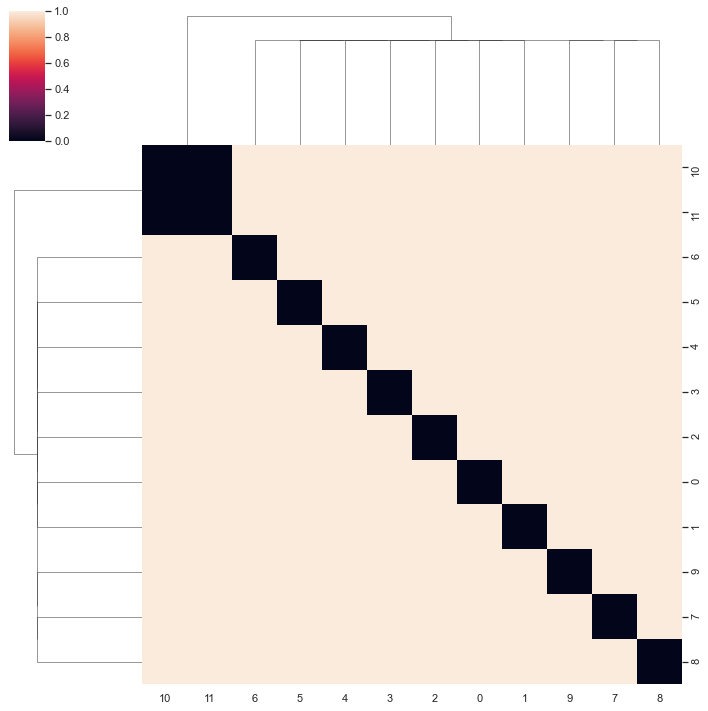

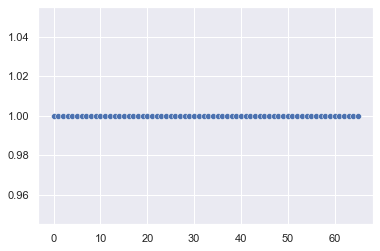

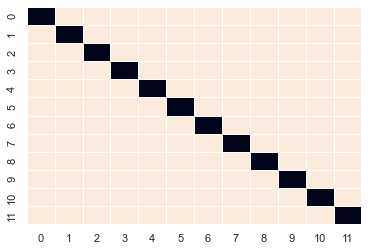

<Figure size 432x288 with 0 Axes>

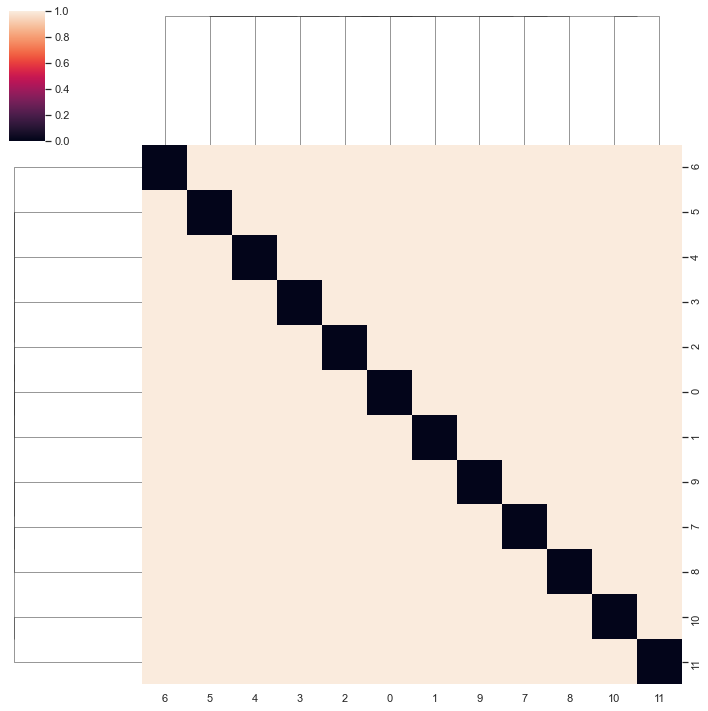

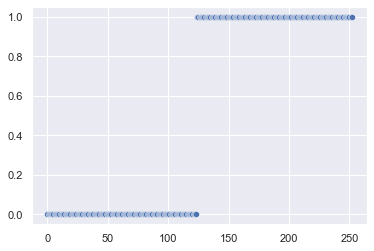

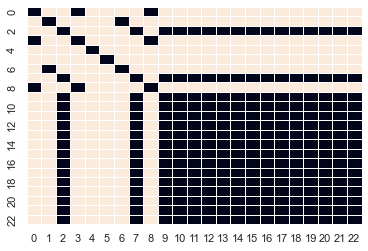

<Figure size 432x288 with 0 Axes>

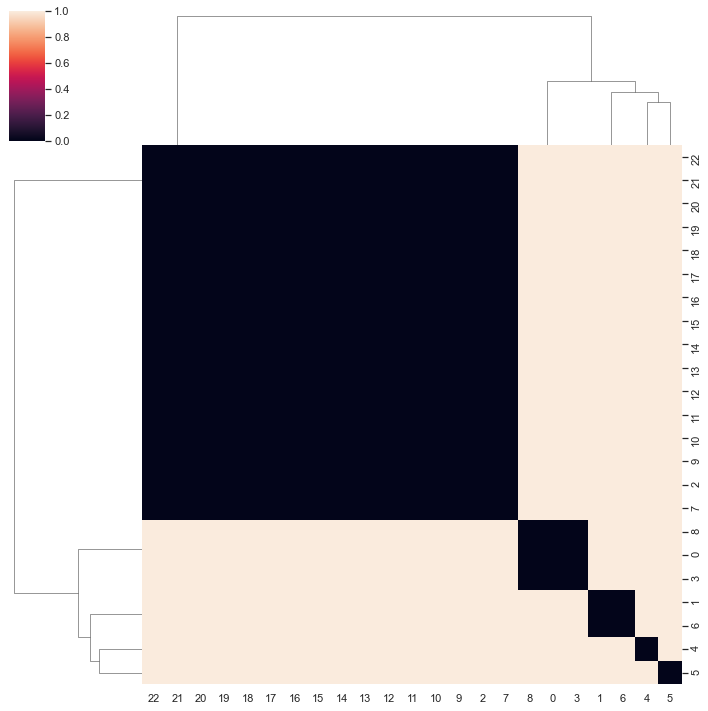

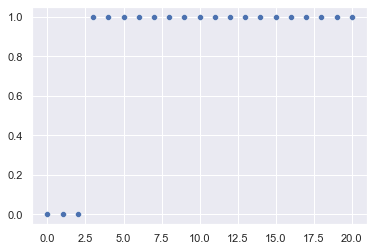

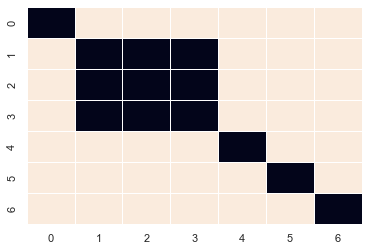

<Figure size 432x288 with 0 Axes>

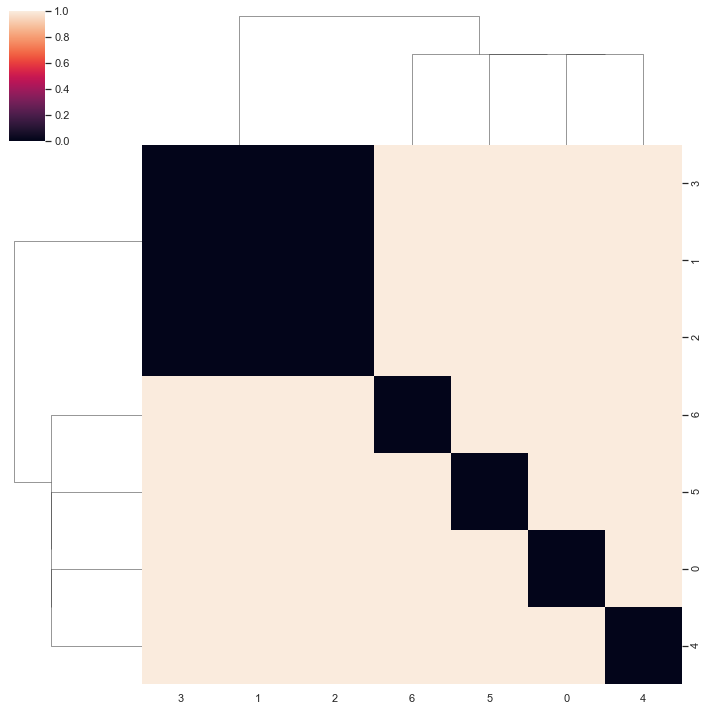

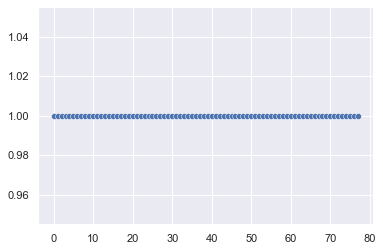

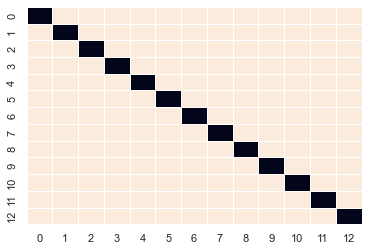

<Figure size 432x288 with 0 Axes>

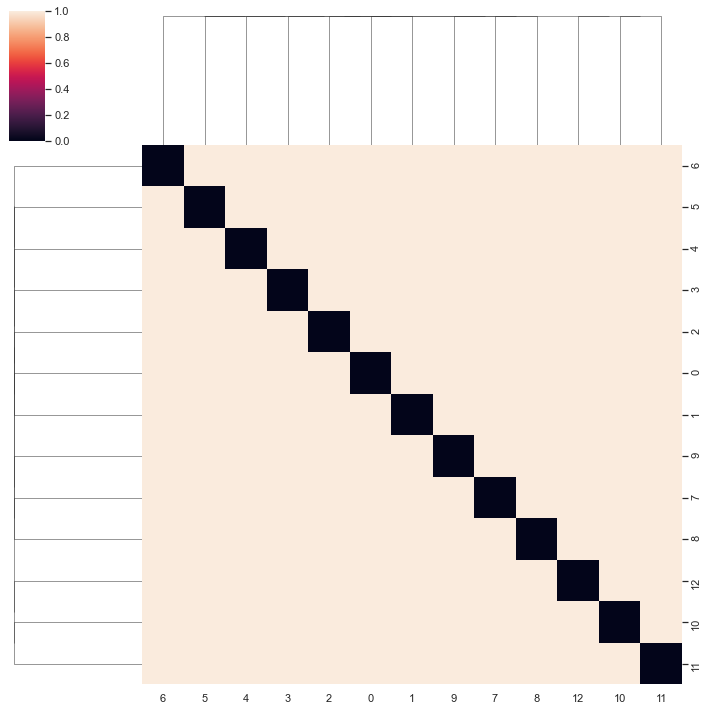

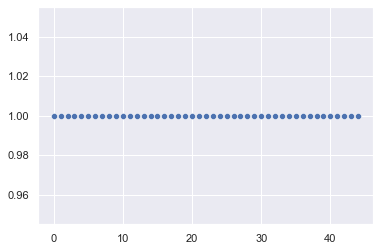

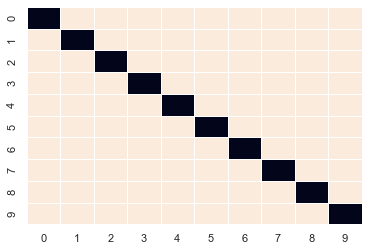

<Figure size 432x288 with 0 Axes>

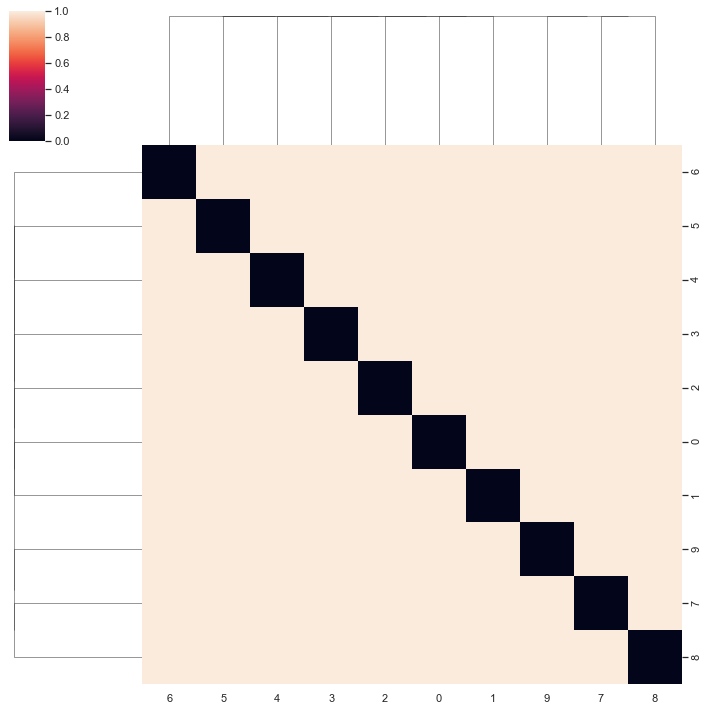

<Figure size 432x288 with 0 Axes>

In [29]:
#models_dir='weightedGraphs/csvEuler/aaa/'
models_dir='weightedGraphs/csvEuler/'
import sys
ipython_output = sys.stdout

#Store the original function for 'input()'
#from ipykernel.ipkernel import IPythonKernel
#ipython_input = IPythonKernel._input_request
try:
    file_out="weighteGraphs_csvEuler.txt"
    sys.stdout = open(file_out, 'w')
    
    print("ciao")
    good_models=[]
    considered_models=[]
    i=0
    import os
    files = os.listdir(models_dir)

    #file = open("nets.txt", "w")
    #file.write("Model considered and good models\n")
    
    for f in files:
        if f.endswith('AEuler.csv'):
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            AFile = models_dir+f
            BFile = models_dir+'fakeB.csv'
            %time computeMetrics_handleJVM(AFile,BFile,1.0,False,False,False,good_models)
finally:
    #Restore the correct input() and print()
    #IPythonKernel._input_request = ipython_input
    sys.stdout = ipython_output
    print('done')

## Laplacian on netschleuder with up to 50 nodes
- There were 1089 networks with up to 50 nodes. We are left with 422 networks after dropping
  - symmetric ones
  - ones with self loops

In [6]:
%%capture cap --no-stderr
print('ciao')

In [ ]:
%%capture cap --no-stderr
#%%writefile nets_output.txt
#models_dir='weightedGraphs/laplacian/csvLapl/aaa/'
models_dir='weightedGraphs/laplacian/csvLapl/'
with open('nets_output.txt', 'w') as out:
    print("ciao")
    good_models=[]
    considered_models=[]
    i=0
    import os
    files = os.listdir(models_dir)

    file = open("nets.txt", "w")
    file.write("Model considered and good models\n")


    for f in files:
        if f.endswith('ALapl.csv'):
            considered_models.append(f)
            file.write(f)
            file.write("\n")
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            AFile = models_dir+f
            BFile = models_dir+'fakeB.csv'
            %time computeMetrics_handleJVM(AFile,BFile,1.0,False,False,False,good_models)
    #computeMetrics_handleJVM('weightedGraphs/csv/moviegalaxies_814A.csv','weightedGraphs/csv/moviegalaxies_814B.csv',1.0)
    file.write("\n\n")
    file.write("The good models\n")
    file.write(str(good_models))
    file.close()
    print("###########")
    print("###########")
    print("#COMPLETED#")
    print("###########")
    print("###########")
    print('Good models',good_models)
    print(len(considered_models),'considered models',considered_models)
    out.write(cap.stdout)

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/si

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
[solve.c:3905] ERROR: (node 1) unresolved numerical troubles in LP 2 cannot be dealt with
[solve.c:4190] ERROR: Error <-6> in function call
[solve.c:4984] ERROR: Error <-6> in function call
[scip_solve.c:2748] ERROR: Error <-6> in function call


Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/si

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1217, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/si

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
[solve.c:3905] ERROR: (node 1) unresolved numerical troubles in LP 2 cannot be dealt with
[solve.c:4190] ERROR: Error <-6> in function call
[solve.c:4984] ERROR: Error <-6> in function call
[scip_solve.c:2748] ERROR: Error <-6> in function call


Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:62

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


[solve.c:3905] ERROR: (node 1) unresolved numerical troubles in LP 2 cannot be dealt with
[solve.c:4190] ERROR: Error <-6> in function call
[solve.c:4984] ERROR: Error <-6> in function call
[scip_solve.c:2748] ERROR: Error <-6> in function call


Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/and

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:62

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception o

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/and

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:62

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
[solve.c:3905] ERROR: (node 1) unresolved numerical troubles in LP 2 cannot be dealt with
[solve.

Py4JJavaError: An error occurred while calling t.computeMetrics.
: java.lang.UnsupportedOperationException: Something went wrong with the policy improvement LP.
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeInvariantImprovement(SimplePolicyIteration.java:529)
	at it.imt.erode.metrics.algorithm.affine.SimplePolicyIteration.computeMetrics(SimplePolicyIteration.java:211)
	at it.sssa.erode.metrics.commandline.EntryPointPythonMetrics.computeMetrics(EntryPointPythonMetrics.java:249)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.base/java.lang.Thread.run(Thread.java:834)


/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:62

## Giuseppe

## netschleuder
- 274 models have up to 60 edges

In [15]:
%%capture cap --no-stderr

import os
files = os.listdir('weightedGraphs/csv/')
filesCSV = [f for f in files if f.endswith('A.csv')]
with open('nets_output2.txt', 'w') as out:
    for f in filesCSV:
        print(f)
    out.write(cap.stdout)
#with open('nets_output.txt', 'w') as out:
#    len(filesCSV)
#    out.write(cap.stdout)

In [16]:
print('ciao')

ciao


In [20]:
%%capture cap --no-stderr
#%%writefile nets_output.txt
with open('nets_output.txt', 'w') as out:
    print("ciao")
    good_models=[]
    considered_models=[]
    i=0
    import os
    files = os.listdir('weightedGraphs/csv/')

    file = open("nets.txt", "w")
    file.write("Model considered and good models\n")


    for f in files:
        if f.endswith('A.csv'):
            considered_models.append(f)
            file.write(f)
            file.write("\n")
            print()
            print()
            print(i)
            i=i+1
            print("HANDLING ",f)
            AFile = 'weightedGraphs/csv/'+f
            BFile = 'weightedGraphs/csv/'+f.replace('A.csv','B.csv')
            %time computeMetrics_handleJVM(AFile,BFile,1.0,False,False,False,good_models)
    #computeMetrics_handleJVM('weightedGraphs/csv/moviegalaxies_814A.csv','weightedGraphs/csv/moviegalaxies_814B.csv',1.0)
    file.write("\n\n")
    file.write("The good models\n")
    file.write(str(good_models))
    file.close()
    print("###########")
    print("###########")
    print("#COMPLETED#")
    print("###########")
    print("###########")
    print('Good models',good_models)
    print(len(considered_models),'considered models',considered_models)
    out.write(cap.stdout)

/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:627: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/seaborn/matrix.py:62

In [19]:
str(good_models)

'[]'

## Trash

In [ ]:
py_metrics

In [ ]:
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax = sns.heatmap(py_metrics,annot=True,linewidths=.5)
plt.savefig('save_as_a_pdf.pdf')

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(py_metrics, cmap='hot', interpolation='nearest')
# plt.show()

In [ ]:
#%pip install seaborn